In [69]:
# ===================================================================
# IMPORTS
# ===================================================================
# Reload functions after changes
import importlib
import functions
importlib.reload(functions)
from functions import *


Libraries imported successfully
pymrio version: 0.5.4
Base path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit
EXIOBASE data path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Exiobase3_ixi_latest
Results will be saved to: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Results
Years for time series: 1995-2022
Loading population data from: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\exiobase3_population_2022_official.csv
Population data shape: (49, 3)
Columns: ['EXIOBASE3_Code', 'Population_2022', 'Source']

First 5 rows:
  EXIOBASE3_Code  Population_2022             Source
0             AT       9041851.00  World Bank (2022)
1             BE      11680210.00  World Bank (2022)
2             BG       6643324.00  World Bank (2022)
3             CY       1331370.00  World Bank (2022)
4             CZ      10672118.00  World Bank (2022)
Defined 20 emission categories
Defined 8 total value-added components
  - 2 tax components
 

In [81]:

# ===================================================================
# LOAD DATA
# ===================================================================

# Load EXIOBASE for single year
ixi_data = load_exiobase_year(SINGLE_YEAR)



Loading EXIOBASE data for year 2019...
✓ Year 2019 loaded successfully
  Regions: 49
  Sectors: 163


In [6]:
# ===================================================================
# SECTOR MAPPING
# ===================================================================

# Get all sectors from EXIOBASE
all_sectors = ixi_data.get_sectors()
print(f"Total sectors in EXIOBASE: {len(all_sectors)}")

# Create DataFrame with sector mapping
df_sectors = pd.DataFrame({'sector': all_sectors})
df_sectors['category'] = df_sectors['sector'].apply(category_of)
df_sectors['colour'] = df_sectors['sector'].apply(colour_of)

print("\nSector distribution:")
print(df_sectors['category'].value_counts())

# Create analysis-specific sector lists
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
service_sectors = get_sectors_by_categories(["Services"])
manufacturing_sectors = get_sectors_by_categories(["Manufacturing (Food & Beverages)", "Manufacturing (Textiles, Leather & Wood)", "Manufacturing (Machinery & Equipment)"])

print(f"\nFossil fuel sectors: {len(fossil_sectors)}")

print(f"Service sectors: {len(service_sectors)}")

print(f"Manufacturing sectors: {len(manufacturing_sectors)}")

Total sectors in EXIOBASE: 163

Sector distribution:
Waste & Recycling                           35
Services                                    19
Agriculture                                 17
Metals                                      15
Manufacturing (Food & Beverages)            12
Non-metallic Minerals                        9
Manufacturing (Machinery & Equipment)        8
Chemicals & Plastics                         7
Energy & Heat Infrastructure                 7
Renewables                                   7
Transport                                    7
Gas                                          5
Manufacturing (Textiles, Leather & Wood)     5
Oil                                          4
Coal                                         3
Construction & Trade                         3
Name: category, dtype: int64

Fossil fuel sectors: 12
Service sectors: 23
Manufacturing sectors: 25


In [74]:
# ===================================================================
# CALCULATE CLEAN VA COEFFICIENTS
# ===================================================================

# All components
v_clean_all, v_raw_all = calculate_clean_va_coefficients(
    ixi_data, VALUE_ADDED_COMPONENTS
)

# Profit only
v_clean_profit, v_raw_profit = calculate_clean_va_coefficients(
    ixi_data, PROFIT_COMPONENTS
)

# Without taxes
components_no_tax = [c for c in VALUE_ADDED_COMPONENTS if c not in TAX_COMPONENTS]
v_clean_no_tax, v_raw_no_tax = calculate_clean_va_coefficients(
    ixi_data, components_no_tax
)

# ===================================================================
# RUN RESPONSIBILITY CALCULATIONS
# ===================================================================

print("\n" + "="*70)
print("CALCULATING ALL RESPONSIBILITY METHODS")
print("="*70)

# Producer responsibility
producer_emissions, missing = calculate_producer_responsibility(
    ixi_data, EMISSION_CATEGORIES
)

# Consumer responsibility
consumer_by_country, consumer_details = calculate_consumer_responsibility(
    ixi_data, producer_emissions
)

# VABR - all components
vabr_all, vabr_all_details, consumer_baseline = calculate_vabr(
    ixi_data, producer_emissions, v_clean_all
)

# VABR - profit only
vabr_profit, vabr_profit_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_profit
)

# VABR - no taxes
vabr_no_tax, vabr_no_tax_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_no_tax
)
## Technology-adjusted VABR calculations
vabr_techA, vabr_techA_details, consumer_tcba = calculate_vabr_tech_adjusted(
    ixi_data=ixi_data,
    producer_emissions=producer_emissions,
    v_clean=v_clean_all,
    conserve_global=True
)

vabr_techB_total, vabr_techB_vabr_part, tech_penalty, sector_gaps = calculate_vabr_with_tech_penalty(
    ixi_data, producer_emissions, v_clean_all, benchmark_mode="world_avg", alpha=1.0
)

## Bottom-up supply drived responsibility calculation
# (producer-centric profit-based responsibility calculation)

pcpr_totals, pcpr_details, pcpr_flows = calculate_pcpr(
    ixi_data,
    producer_emissions,
    profit_components=PROFIT_COMPONENTS,
    method='inverse',
    return_flows=True,
    min_flow=1e5   # z.B. nur Flüsse > 100'000 t CO₂-eq
)

print("\n" + "="*70)
print("ALL CALCULATIONS COMPLETE")
print("="*70)


Calculating VA coefficients using 8 components...
  Set 146 negative VA values to 0
  Capped 37 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=1.6301
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 4 components...
  Set 123 negative VA values to 0
  Capped 15 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=36.3956
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 7 components...
  Set 41 negative VA values to 0
  Capped 59 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=37.3111
  AFTER cleaning:  Min=0.0000, Max=1.0000

CALCULATING ALL RESPONSIBILITY METHODS
Total producer emissions: 44.715 Gt CO2-eq
Total consumer emissions: 44.712 Gt CO2-eq

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCUL

In [82]:
v_clean, v_raw = calculate_clean_va_coefficients(ixi_data, VALUE_ADDED_COMPONENTS)


Calculating VA coefficients using 8 components...
  Set 146 negative VA values to 0
  Capped 37 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=1.6301
  AFTER cleaning:  Min=0.0000, Max=1.0000


In [83]:
print("v_clean shape:", v_clean.shape, "expected:", len(ixi_data.x))
print("v_clean min/max:", v_clean.min(), v_clean.max())
print("mean:", v_clean.mean())


v_clean shape: (7987,) expected: 7987
v_clean min/max: 0.0 1.0
mean: 0.2887237663554046


In [75]:
import numpy as np
import pandas as pd

def build_Y_by_region(ixi_data):
    """
    Returns:
      Y_reg: (n, R) matrix where column r is total final demand vector y_r
      regions: list of region codes (length R)
    """
    Y_full = ixi_data.Y
    regions = list(ixi_data.get_regions())
    n = len(ixi_data.x)

    Y_reg = np.zeros((n, len(regions)), dtype=float)
    for j, r in enumerate(regions):
        mask = (Y_full.columns.get_level_values(0) == r)
        Y_reg[:, j] = Y_full.loc[:, mask].sum(axis=1).values

    return Y_reg, regions

def aggregate_vec_to_country(vec, idx):
    """
    vec: length n (sector-region vector)
    idx: ixi_data.x.index (MultiIndex (region, sector))
    """
    regions = idx.get_level_values(0)
    out = pd.Series(0.0, index=pd.unique(regions))
    for r in out.index:
        out[r] = vec[regions == r].sum()
    return out


In [76]:
import numpy as np
import pandas as pd

def build_Y_by_region(ixi_data):
    """
    Returns:
      Y_reg: (n, R) matrix where column r is total final demand vector y_r
      regions: list of region codes (length R)
    """
    Y_full = ixi_data.Y
    regions = list(ixi_data.get_regions())
    n = len(ixi_data.x)

    Y_reg = np.zeros((n, len(regions)), dtype=float)
    for j, r in enumerate(regions):
        mask = (Y_full.columns.get_level_values(0) == r)
        Y_reg[:, j] = Y_full.loc[:, mask].sum(axis=1).values

    return Y_reg, regions

def aggregate_vec_to_country(vec, idx):
    """
    vec: length n (sector-region vector)
    idx: ixi_data.x.index (MultiIndex (region, sector))
    """
    regions = idx.get_level_values(0)
    out = pd.Series(0.0, index=pd.unique(regions))
    for r in out.index:
        out[r] = vec[regions == r].sum()
    return out



[Top-down VABR] global sum: 44711852968.24498  | CBA global sum: 44711852968.244934

=== Top 15 countries: Topdown vs Piñero literal ===
    VABR_topdown_massconserving  VABR_pinero_literal      abs_diff  \
CN               11489570699.11       12047313851.27  557743152.16   
US                6530820144.61        5928583742.43 -602236402.18   
WA                3088654868.08        2922742254.88 -165912613.20   
IN                2894541713.28        2972721408.00   78179694.72   
WM                2461713571.27        2656516873.17  194803301.89   
WF                1892448259.53        1969371099.46   76922839.93   
JP                1691074312.84        1366228819.63 -324845493.20   
RU                1499858376.09        1679804381.44  179946005.35   
WL                1256964388.73        1261677762.60    4713373.87   
DE                1224403758.10         946003177.53 -278400580.56   
BR                1053329613.49        1101641326.22   48311712.73   
ID                 938

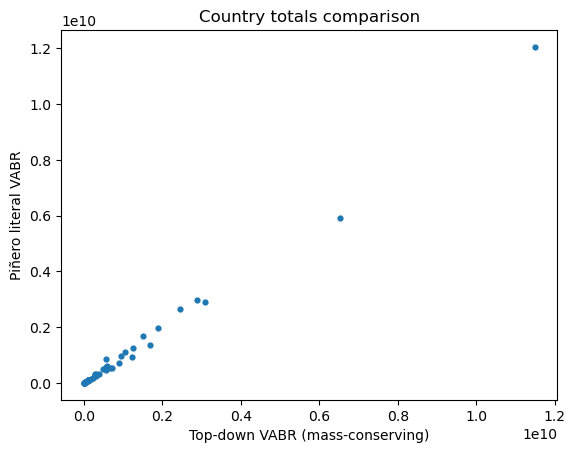

In [84]:
# --- Run both ---
idx = ixi_data.x.index

h_topdown_vec, cba_region = vabr_topdown_mass_conserving(ixi_data, producer_emissions, v_clean)
h_pinero_vec, _           = vabr_pinero_literal(ixi_data, producer_emissions, v_clean)

# --- Aggregate to country totals ---
topdown_country = aggregate_vec_to_country(h_topdown_vec, idx).sort_values(ascending=False)
pinero_country  = aggregate_vec_to_country(h_pinero_vec, idx).sort_values(ascending=False)

# --- Compare in one DataFrame ---
comp = pd.DataFrame({
    "VABR_topdown_massconserving": topdown_country,
    "VABR_pinero_literal": pinero_country
}).fillna(0.0)

comp["abs_diff"] = comp["VABR_pinero_literal"] - comp["VABR_topdown_massconserving"]
comp["pct_diff_vs_topdown"] = np.divide(
    comp["abs_diff"],
    comp["VABR_topdown_massconserving"],
    out=np.full_like(comp["abs_diff"], np.nan, dtype=float),
    where=(comp["VABR_topdown_massconserving"] != 0)
) * 100

print("\n=== Top 15 countries: Topdown vs Piñero literal ===")
print(comp.sort_values("VABR_topdown_massconserving", ascending=False).head(15))

print("\n=== Biggest absolute changes (Piñero - Topdown) ===")
print(comp.reindex(comp["abs_diff"].abs().sort_values(ascending=False).head(15).index))

# --- Optional: simple scatter plot ---
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(comp["VABR_topdown_massconserving"], comp["VABR_pinero_literal"], s=12)
plt.xlabel("Top-down VABR (mass-conserving)")
plt.ylabel("Piñero literal VABR")
plt.title("Country totals comparison")
plt.show()


In [86]:
def sector_delta_by_country(sec_topdown, sec_pinero, country_code, topn=25):
    """
    sec_topdown/sec_pinero: pd.Series indexed by (region, sector) with responsibility in tonnes
    """
    td = sec_topdown.xs(country_code, level=0)
    pi = sec_pinero.xs(country_code, level=0)
    delta = (pi - td).sort_values(ascending=False)

    out = pd.DataFrame({
        "topdown": td.reindex(delta.index),
        "pinero": pi.reindex(delta.index),
        "delta": delta,
        "pct_delta_vs_topdown": 100 * delta / td.reindex(delta.index).replace(0, np.nan)
    })
    return out.head(topn), out.tail(topn)

# Example: Australia
top_pos, top_neg = sector_delta_by_country(sec_bundle, sec_pinero, "AU", topn=20)
display(top_pos)
display(top_neg)


,topdown,pinero,delta,pct_delta_vs_topdown
sector,,,,
Mining of coal and lignite; extraction of peat (10),46166397.41,261730032.93,215563635.53,466.93
Production of electricity by coal,3216108.38,28482446.42,25266338.03,785.62
"Extraction of natural gas and services related to natural gas extraction, excluding surveying",5611365.24,23191201.66,17579836.42,313.29
Cattle farming,3459844.08,18719310.35,15259466.27,441.04
Manufacture of gas; distribution of gaseous fuels through mains,7156839.79,14241351.14,7084511.35,98.99
"Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)",22693669.12,29088943.04,6395273.92,28.18
"Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",6501118.96,12824557.85,6323438.88,97.27
Processing of meat cattle,1230379.38,7470657.95,6240278.57,507.18
Supporting and auxiliary transport activities; activities of travel agencies (63),12783632.48,18884078.02,6100445.53,47.72


,topdown,pinero,delta,pct_delta_vs_topdown
sector,,,,
Re-processing of secondary wood material into new wood material,0.00,0.00,0.00,NaN
Re-processing of secondary other non-ferrous metals into new other non-ferrous metals,0.00,0.00,0.00,NaN
Re-processing of secondary construction material into aggregates,0.00,0.00,0.00,NaN
Re-processing of secondary preciuos metals into new preciuos metals,0.00,0.00,0.00,NaN
"Manufacture of medical, precision and optical instruments, watches and clocks (33)",444744.58,443980.02,-764.57,-0.17
Activities auxiliary to financial intermediation (67),8345649.71,8230750.91,-114898.80,-1.38
"Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)",1301826.97,1110130.07,-191696.91,-14.73
"Manufacture of motor vehicles, trailers and semi-trailers (34)",2078642.75,1873618.49,-205024.26,-9.86
Research and development (73),6416449.08,6049460.15,-366988.93,-5.72


In [87]:
print(sec_bundle.sum(), sec_pinero.sum())
print("max abs sector diff:", (sec_pinero - sec_bundle).abs().max())


44711852968.24498 44064863965.3699
max abs sector diff: 519783099.97868353


In [85]:
import numpy as np
import pandas as pd

def _final_demand_by_region(ixi_data):
    """Return Yc: (n x R) matrix, each column is total final demand of region r."""
    regions = ixi_data.get_regions()
    Y = ixi_data.Y
    Yc = np.column_stack([
        Y.loc[:, Y.columns.get_level_values(0) == r].sum(axis=1).values
        for r in regions
    ])
    return regions, Yc

def _intensity_vector(producer_emissions, x):
    """f: emissions per € output"""
    return np.divide(
        producer_emissions, x,
        out=np.zeros_like(producer_emissions, dtype=float),
        where=(x != 0)
    )

def vabr_bundle_level_like_yours(ixi_data, producer_emissions, v_coeff):
    """
    Your current logic (mass-conserving):
    For each consuming region c:
      - compute total CBA emissions E_c (scalar)
      - allocate E_c across sector-regions i proportional to VA_i(c) = v_i * (B y_c)_i
    Returns: sector responsibility vector (n,), country totals (Series)
    """
    regions, Yc = _final_demand_by_region(ixi_data)
    B = ixi_data.L.values
    x = ixi_data.x.values.flatten()
    f = _intensity_vector(np.asarray(producer_emissions).flatten(), x)

    n, R = Yc.shape
    alloc = np.zeros(n, dtype=float)

    for c in range(R):
        y_c = Yc[:, c]
        g_c = B @ y_c                       # output induced by consumption bundle
        e_c_vec = f * g_c                   # sectoral emissions along supply chain
        E_c = e_c_vec.sum()                 # scalar total

        va_c = v_coeff * g_c                # VA creation pattern for this bundle
        va_sum = va_c.sum()

        if E_c == 0:
            continue
        if va_sum > 0:
            alloc += E_c * (va_c / va_sum)
        else:
            alloc += E_c / n

    idx = ixi_data.x.index
    sector_resp = pd.Series(alloc, index=idx, name="VABR_bundle")
    country_totals = sector_resp.groupby(level=0).sum()
    return sector_resp, country_totals

def vabr_pinero_literal(ixi_data, producer_emissions, v_coeff):
    """
    Literal Piñero-style:
      1) compute final-demand multipliers m = f' B   (one per final product j)
      2) for each consumer region c: t_c = (m ⊙ y_c)   (vector over final products j)
      3) reallocate: h_c = diag(v) B t_c  = v ⊙ (B t_c)
      4) sum over consumers c

    Returns: sector responsibility vector (n,), country totals (Series)
    """
    regions, Yc = _final_demand_by_region(ixi_data)
    B = ixi_data.L.values
    x = ixi_data.x.values.flatten()
    f = _intensity_vector(np.asarray(producer_emissions).flatten(), x)

    # m_j = (f' B)_j  -> final-demand emission multiplier per final product j
    m = (f @ B)  # shape (n,)

    # t_mat: (n x R), each column c is t_c over final products j
    t_mat = m[:, None] * Yc

    # h_mat = diag(v) B t_mat = v ⊙ (B @ t_mat)
    Bt = B @ t_mat
    h_mat = v_coeff[:, None] * Bt

    # total sector responsibility (sum over consuming regions)
    alloc = h_mat.sum(axis=1)

    idx = ixi_data.x.index
    sector_resp = pd.Series(alloc, index=idx, name="VABR_pinero_literal")
    country_totals = sector_resp.groupby(level=0).sum()
    return sector_resp, country_totals

def compare_vabr_variants(ixi_data, producer_emissions, v_clean):
    sec_bundle, c_bundle = vabr_bundle_level_like_yours(ixi_data, producer_emissions, v_clean)
    sec_pinero, c_pinero = vabr_pinero_literal(ixi_data, producer_emissions, v_clean)

    comp = pd.DataFrame({
        "VABR_bundle": c_bundle,
        "VABR_pinero_literal": c_pinero
    })
    comp["abs_diff"] = comp["VABR_pinero_literal"] - comp["VABR_bundle"]
    comp["pct_diff"] = 100 * comp["abs_diff"] / comp["VABR_bundle"].replace(0, np.nan)

    # Global checks (should match each other, and match global CBA total)
    print("Global totals (Gt CO2-eq):")
    print("  bundle-level:", sec_bundle.sum()/1e9)
    print("  pinero-lit:  ", sec_pinero.sum()/1e9)

    return comp.sort_values("abs_diff", ascending=False), sec_bundle, sec_pinero

# ---- RUN ----
comp_df, sec_bundle, sec_pinero = compare_vabr_variants(ixi_data, producer_emissions, v_clean)
display(comp_df.head(15))
display(comp_df.tail(15))


Global totals (Gt CO2-eq):
  bundle-level: 44.71185296824498
  pinero-lit:   44.0648639653699


,VABR_bundle,VABR_pinero_literal,abs_diff,pct_diff
region,,,,
CN,11489570699.11,12047313851.27,557743152.16,4.85
AU,561630210.99,856926763.53,295296552.55,52.58
WM,2461713571.27,2656516873.17,194803301.89,7.91
RU,1499858376.09,1679804381.44,179946005.35,12.00
IN,2894541713.28,2972721408.00,78179694.72,2.70
WF,1892448259.53,1969371099.46,76922839.93,4.06
BR,1053329613.49,1101641326.22,48311712.73,4.59
ID,938026315.28,985705976.84,47679661.57,5.08
MX,582545661.97,627918630.03,45372968.06,7.79


,VABR_bundle,VABR_pinero_literal,abs_diff,pct_diff
region,,,,
CZ,112801150.32,98812659.60,-13988490.73,-12.40
WE,288536504.56,273620646.37,-14915858.19,-5.17
BE,173214362.30,150375313.72,-22839048.58,-13.19
SE,128563909.37,105408160.26,-23155749.11,-18.01
CH,233164291.38,199702320.20,-33461971.18,-14.35
NL,301108126.22,253590721.03,-47517405.20,-15.78
ES,383419129.20,327507101.17,-55912028.03,-14.58
IT,570183602.54,463673435.22,-106510167.31,-18.68
FR,681069244.99,549710315.38,-131358929.61,-19.29


ANALYSIS


=== Aggregating producer emissions by country ===
Total producer emissions: 44.715 Gt

ANALYSIS 1: Top Emitters - Comparison of All Methods (2019)

Comparison DataFrame with EU aggregated shape: (22, 7)
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'VABR (TechA)', 'VABR (TechB+Penalty)', 'PCPR (Profit)']

Selected methods for bar plot: ['Producer', 'VABR (All VA)', 'VABR (TechB+Penalty)']
Top 9 countries ranked by: VABR (Profit)
Countries for bar plot (top): ['CN', 'US', 'EU', 'IN', 'WM', 'WA', 'WF', 'JP', 'RU']


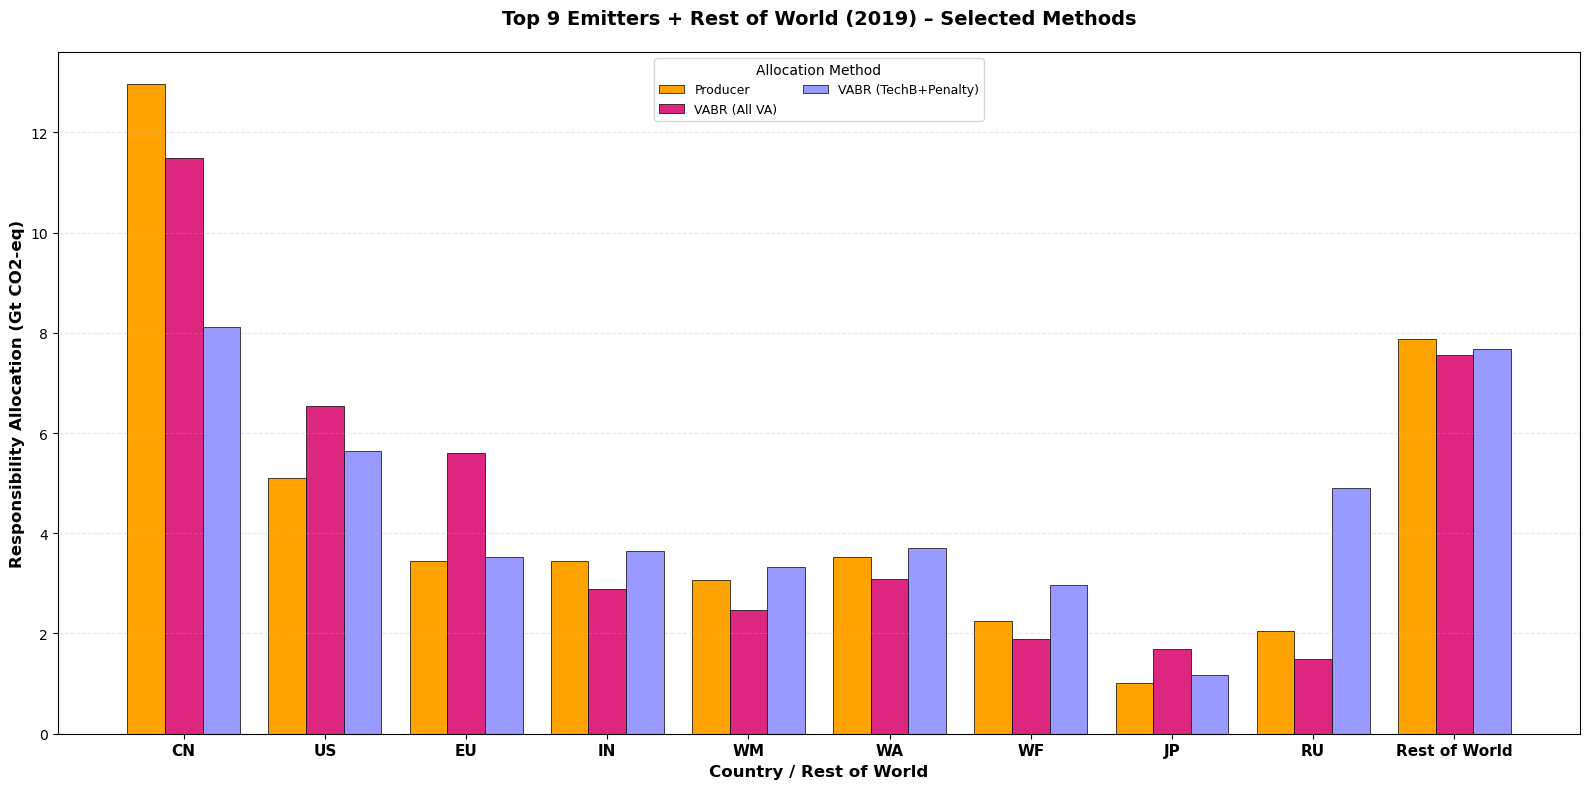


✓ Bar chart created for methods ['Producer', 'VABR (All VA)', 'VABR (TechB+Penalty)'] and top 9 countries (+ Rest of World, ranked by VABR (Profit))

Top 9 represent (without ROW):
  Producer            : 36.84 Gt (82.4% of global)
  VABR (All VA)       : 37.15 Gt (83.1% of global)
  VABR (TechB+Penalty): 37.03 Gt (82.8% of global)

### Detailed Method Comparison (Top Countries only) ###

CN:
  Producer:        12.96 Gt (100%)
  VABR (All VA)  : 11.49 Gt ( 88.7%)
  VABR (TechB+Penalty):  8.12 Gt ( 62.7%)
  → Closest to Producer: VABR (All VA) (diff: 1.47 Gt)

US:
  Producer:         5.10 Gt (100%)
  VABR (All VA)  :  6.53 Gt (128.0%)
  VABR (TechB+Penalty):  5.65 Gt (110.8%)
  → Closest to Producer: VABR (TechB+Penalty) (diff: 0.55 Gt)

EU:
  Producer:         3.45 Gt (100%)
  VABR (All VA)  :  5.60 Gt (162.2%)
  VABR (TechB+Penalty):  3.54 Gt (102.3%)
  → Closest to Producer: VABR (TechB+Penalty) (diff: 0.08 Gt)

IN:
  Producer:         3.45 Gt (100%)
  VABR (All VA)  :  2.89 Gt ( 84

In [53]:
# ===================================================================
# AGGREGATE PRODUCER EMISSIONS BY COUNTRY
# ===================================================================
print("\n=== Aggregating producer emissions by country ===")

regions = ixi_data.get_regions()
producer_by_country = {}

for region in regions:
    region_mask = ixi_data.x.index.get_level_values(0) == region
    region_indices = np.where(region_mask)[0]
    producer_by_country[region] = producer_emissions[region_indices].sum()

producer_series = pd.Series(producer_by_country)
print(f"Total producer emissions: {producer_series.sum()/1e9:.3f} Gt")

# ===================================================================
# ANALYSIS: TOP EMITTERS - ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 1: Top Emitters - Comparison of All Methods ({SINGLE_YEAR})")
print("="*70)

# Create comparison DataFrame with ALL 6 methods
comparison_df = pd.DataFrame({
    'Producer': producer_series / 1e9,
    'Consumer': consumer_by_country / 1e9,
    'VABR (All VA)': vabr_all / 1e9,
    'VABR (Profit)': vabr_profit / 1e9,
    'VABR (TechA)':    vabr_techA / 1e9, 
    'VABR (TechB+Penalty)': vabr_techB_total / 1e9,
    #'PCPR (All VA)': pcpr_all_totals / 1e9,
    'PCPR (Profit)': pcpr_totals / 1e9
})
# Aggregate EU as a single region in the comparison DataFrame
comparison_df_eu = aggregate_region_in_df(
    comparison_df,
    group_name="EU",
    members=EU_COUNTRIES,
    drop_members=True   # remove AT, BE, ... and keep only EU
)

print(f"\nComparison DataFrame with EU aggregated shape: {comparison_df_eu.shape}")
print(f"Methods: {list(comparison_df_eu.columns)}")
# ===================================================================
# FLEXIBLE BAR PLOT: SELECT METHODS & NUMBER OF COUNTRIES
# ===================================================================

# --- Parameter, die du oben im Notebook leicht ändern kannst ---
methods_for_plot = [
    'Producer',
    #'Consumer',
    'VABR (All VA)',
    #'VABR (Profit)',
    #'VABR (TechA)',
    'VABR (TechB+Penalty)',      
    #'PCPR (All VA)',
    #'PCPR (Profit)',
]
top_n_countries = 9          # ← hier Anzahl Länder einstellen
ranking_method = 'VABR (Profit)'  # ← nach welcher Methode sortieren?

# Filter: nimm nur Methoden, die es wirklich in comparison_df gibt
selected_methods = [m for m in methods_for_plot if m in comparison_df_eu.columns]
if len(selected_methods) == 0:
    raise ValueError("No valid methods selected for plotting.")

print(f"\nSelected methods for bar plot: {selected_methods}")
print(f"Top {top_n_countries} countries ranked by: {ranking_method}")

# Länder auswählen
if ranking_method not in comparison_df_eu.columns:
    raise ValueError(f"ranking_method '{ranking_method}' not found in comparison_df_eu.columns")

top_countries = comparison_df_eu[ranking_method].nlargest(top_n_countries).index.tolist()

plot_data_top = comparison_df_eu.loc[top_countries, selected_methods]

print(f"Countries for bar plot (top): {top_countries}")

# -------------------------------
# Rest of World (ROW) berechnen
# -------------------------------
rest_row = {}
for method in selected_methods:
    global_total = comparison_df_eu[method].sum()
    top_total = plot_data_top[method].sum()
    rest_row[method] = global_total - top_total

# DataFrame mit einer Zeile "Rest of World"
row_df = pd.DataFrame([rest_row], index=["Rest of World"])

# Plot-Daten: Top-Länder + ROW
plot_data = pd.concat([plot_data_top, row_df], axis=0)

countries_for_plot = list(plot_data.index)  # Top-Länder + "Rest of World"

# Farben (kannst du nach Lust anpassen/erweitern)
colors = {
    'Producer':        '#ffa300',
    'Consumer':        '#6bb314',
    'VABR (All VA)':   '#dc267f',
    'VABR (Profit)':   '#fe6100',
    'VABR (TechA)':    '#00bfc4',   # Farbe für TechA
    'VABR (TechB+Penalty)': '#9999ff',  # falls du es nutzt
    'PCPR (All VA)':   '#648fff',
    'PCPR (Profit)':   '#785ef0',
}

default_color = '#999999'

# --- Plot ---
fig, ax = plt.subplots(figsize=(16, 8))

n_methods = len(selected_methods)
x = np.arange(len(countries_for_plot))
width = 0.8 / n_methods   # dynamische Breite

for i, method in enumerate(selected_methods):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data[method].values,
        width,
        label=method,
        color=colors.get(method, default_color),
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(
    f'Top {top_n_countries} Emitters + Rest of World '
    f'({SINGLE_YEAR}) – Selected Methods',
    fontsize=14, fontweight='bold', pad=20
)
ax.set_ylabel('Responsibility Allocation (Gt CO2-eq)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country / Rest of World', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(countries_for_plot, fontsize=11, fontweight='bold', rotation=0)
ax.legend(title="Allocation Method", fontsize=9, title_fontsize=10, 
          loc='upper center', ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\n✓ Bar chart created for methods {selected_methods} "
      f"and top {top_n_countries} countries (+ Rest of World, ranked by {ranking_method})")

# ===================================================================
# SUMMARY: Anteil der Top-Länder (ohne ROW)
# ===================================================================

print(f"\nTop {top_n_countries} represent (without ROW):")
for method in selected_methods:
    top_sum = plot_data_top[method].sum()
    total = comparison_df[method].sum()
    percentage = (top_sum / total) * 100 if total > 0 else float('nan')
    print(f"  {method:20s}: {top_sum:5.2f} Gt ({percentage:4.1f}% of global)")

print("\n### Detailed Method Comparison (Top Countries only) ###")

for country in top_countries:
    producer = comparison_df_eu.loc[country, 'Producer']
    print(f"\n{country}:")
    print(f"  Producer:        {producer:5.2f} Gt (100%)")
    
    for method in selected_methods:
        if method == 'Producer':
            continue
        value = comparison_df_eu.loc[country, method]
        pct = (value / producer * 100) if producer > 0 else float('nan')
        print(f"  {method:15s}: {value:5.2f} Gt ({pct:5.1f}%)")
    
    methods_dict = {
        m: comparison_df_eu.loc[country, m]
        for m in selected_methods if m != 'Producer'
    }
    if methods_dict:
        closest = min(methods_dict.items(), key=lambda x: abs(x[1] - producer))
        print(f"  → Closest to Producer: {closest[0]} "
              f"(diff: {abs(closest[1] - producer):.2f} Gt)")


ANALYSIS: Per Capita Emissions (Top N + Rest of World) (2019)

Countries with population data: 22/22
Selected methods (per capita): ['Producer', 'Consumer', 'VABR (All VA)']
Per capita shape: (22, 3)

Top 10 per capita (by VABR (All VA)): ['CH', 'AU', 'US', 'NO', 'KR', 'CA', 'JP', 'TW', 'EU', 'RU']

Rest of World per capita (tonnes/person) for each method:
Producer        4.59
Consumer        4.25
VABR (All VA)   3.98
Name: Rest of World, dtype: float64


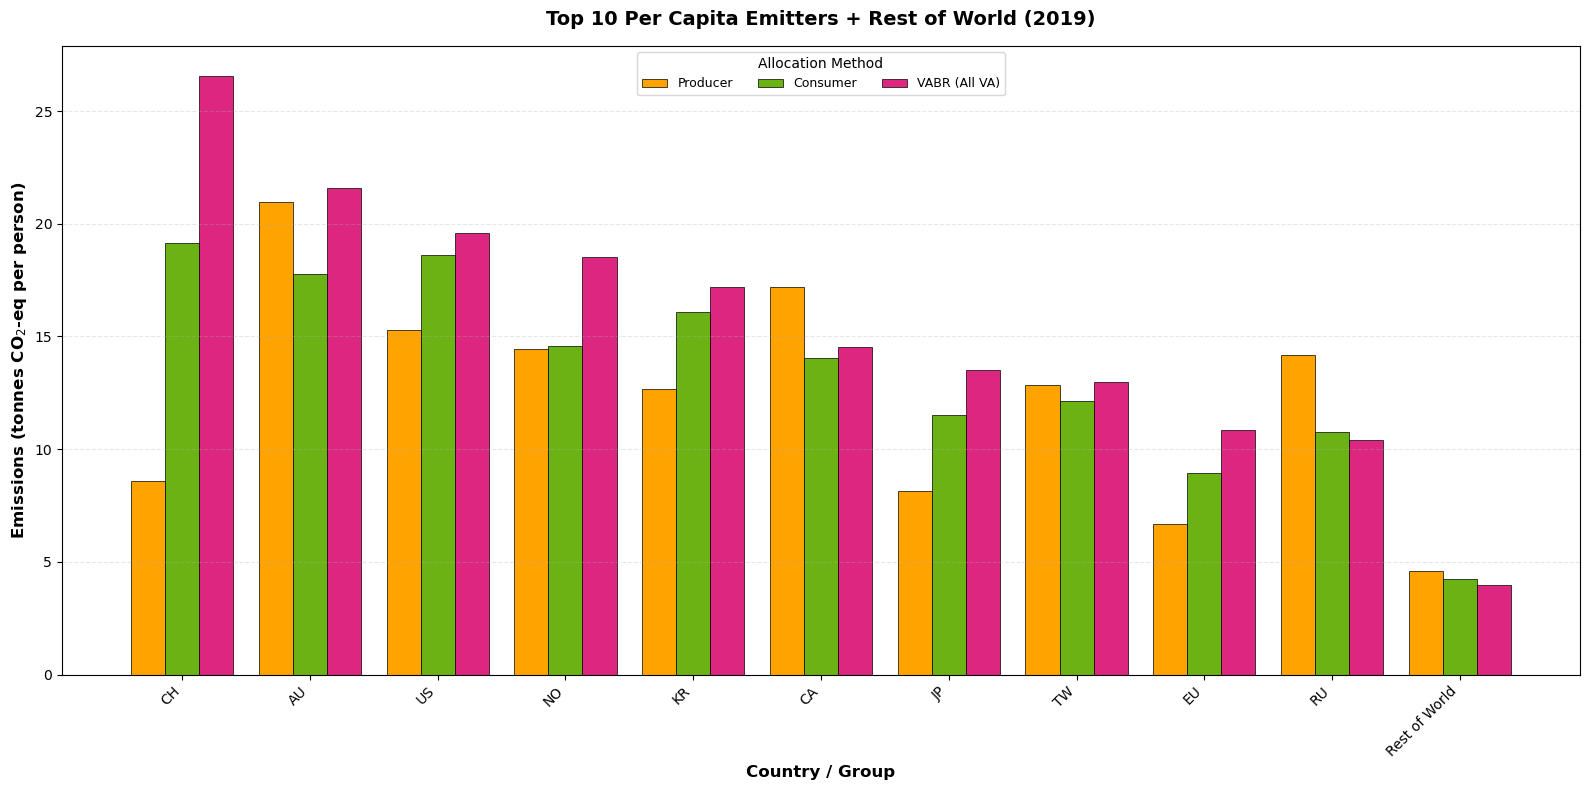


✓ Per capita bar chart created (Top N + Rest of World, EU aggregated)

Top 10 represent (per capita, countries only):
  Producer            : mean top=13.10 t/cap, mean all= 8.76 t/cap
  Consumer            : mean top=14.36 t/cap, mean all= 9.04 t/cap
  VABR (All VA)       : mean top=16.57 t/cap, mean all= 9.91 t/cap


In [24]:
# ===================================================================
# PER CAPITA EMISSIONS BAR PLOT - FLEXIBLE (Top N + Rest of World)
# with EU aggregated as a single region
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS: Per Capita Emissions (Top N + Rest of World) ({SINGLE_YEAR})")
print("="*70)

# --- EU aggregation for emissions and population ---
comparison_df_eu = aggregate_region_in_df(
    comparison_df,
    group_name="EU",
    members=EU_COUNTRIES,
    drop_members=True
)

population_2022_eu = aggregate_region_in_series(
    population_2022,
    group_name="EU",
    members=EU_COUNTRIES,
    drop_members=True
)

# --- Parameters you can easily change ---
methods_for_plot_pc = [
    'Producer',
    'Consumer',
    'VABR (All VA)',
    # 'VABR (Profit)',
    # 'VABR (TechA)',
    # 'VABR (TechB+Penalty)',
    # 'PCPR (All VA)',
    # 'PCPR (Profit)',
]
top_n_countries_pc = 10                 # Anzahl Länder
ranking_method_pc = 'VABR (All VA)'     # Ranking nach per-capita dieser Methode

# 1) Länder, für die sowohl Emissionen als auch Bevölkerung vorhanden sind
common_countries = comparison_df_eu.index.intersection(population_2022_eu.index)
print(f"\nCountries with population data: {len(common_countries)}/{len(comparison_df_eu)}")

# Filter: nimm nur Methoden, die es wirklich gibt
selected_methods_pc = [m for m in methods_for_plot_pc if m in comparison_df_eu.columns]
if len(selected_methods_pc) == 0:
    raise ValueError("No valid methods selected for per-capita plotting.")

print(f"Selected methods (per capita): {selected_methods_pc}")

# 2) Per-capita-DF (t CO2-eq pro Person)
#    comparison_df_eu ist in Gt -> *1e9 = tonnes
per_capita = pd.DataFrame(index=common_countries)

for method in selected_methods_pc:
    per_capita[method] = (
        comparison_df_eu.loc[common_countries, method] * 1e9
        / population_2022_eu.loc[common_countries]
    )

print(f"Per capita shape: {per_capita.shape}")

# 3) Top N Länder nach per-capita des Ranking-Methods auswählen
if ranking_method_pc not in per_capita.columns:
    raise ValueError(f"ranking_method_pc '{ranking_method_pc}' not found in per_capita.columns")

top_countries_pc = per_capita[ranking_method_pc].nlargest(top_n_countries_pc).index.tolist()
print(f"\nTop {top_n_countries_pc} per capita (by {ranking_method_pc}): {top_countries_pc}")

# 4) Rest of World per capita berechnen
rest_countries_pc = common_countries.difference(top_countries_pc)

rest_per_capita = {}
for method in selected_methods_pc:
    total_emissions_rest_tonnes = comparison_df_eu.loc[rest_countries_pc, method].sum() * 1e9
    total_pop_rest = population_2022_eu.loc[rest_countries_pc].sum()
    
    if total_pop_rest > 0:
        rest_per_capita[method] = total_emissions_rest_tonnes / total_pop_rest
    else:
        rest_per_capita[method] = np.nan

rest_per_capita = pd.Series(rest_per_capita, name='Rest of World')

print("\nRest of World per capita (tonnes/person) for each method:")
print(rest_per_capita.round(2))

# 5) Plot-Daten: Top N + Rest of World
plot_data_pc_top = per_capita.loc[top_countries_pc, selected_methods_pc].copy()
plot_data_pc_top.loc['Rest of World'] = rest_per_capita
countries_for_plot_pc = list(plot_data_pc_top.index)

# 6) Balkendiagramm
fig, ax = plt.subplots(figsize=(16, 8))

n_methods_pc = len(selected_methods_pc)
x_pc = np.arange(len(countries_for_plot_pc))
width_pc = 0.8 / n_methods_pc

colors_pc = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100',
    'VABR (TechA)': '#00bfc4',
    'VABR (TechB+Penalty)': '#9999ff',
    'PCPR (All VA)': '#648fff',
    'PCPR (Profit)': '#785ef0',
}
default_color_pc = '#999999'

for i, method in enumerate(selected_methods_pc):
    ax.bar(
        x_pc + i * width_pc - (n_methods_pc * width_pc / 2) + (width_pc / 2),
        plot_data_pc_top[method].values,
        width_pc,
        label=method,
        color=colors_pc.get(method, default_color_pc),
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(
    f'Top {top_n_countries_pc} Per Capita Emitters + Rest of World '
    f'({SINGLE_YEAR})',
    fontsize=14, fontweight='bold', pad=15
)
ax.set_ylabel('Emissions (tonnes CO$_2$-eq per person)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country / Group', fontsize=12, fontweight='bold')
ax.set_xticks(x_pc)
ax.set_xticklabels(countries_for_plot_pc, rotation=45, ha='right', fontsize=10)

# Legende zentriert oben
ax.legend(
    title="Allocation Method",
    fontsize=9,
    title_fontsize=10,
    loc='upper center',
    ncol=3
)

ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Per capita bar chart created (Top N + Rest of World, EU aggregated)")

# 7) Summary: Anteil der Top N (ohne ROW)
print(f"\nTop {top_n_countries_pc} represent (per capita, countries only):")
for method in selected_methods_pc:
    top_vals = per_capita.loc[top_countries_pc, method]
    all_vals = per_capita[method]
    print(f"  {method:20s}: "
          f"mean top={top_vals.mean():5.2f} t/cap, "
          f"mean all={all_vals.mean():5.2f} t/cap")



SLOPE CHART: Country Rankings Across Methods

Countries shown: 18
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'VABR (TechA)', 'VABR (TechB+Penalty)', 'PCPR (Profit)']


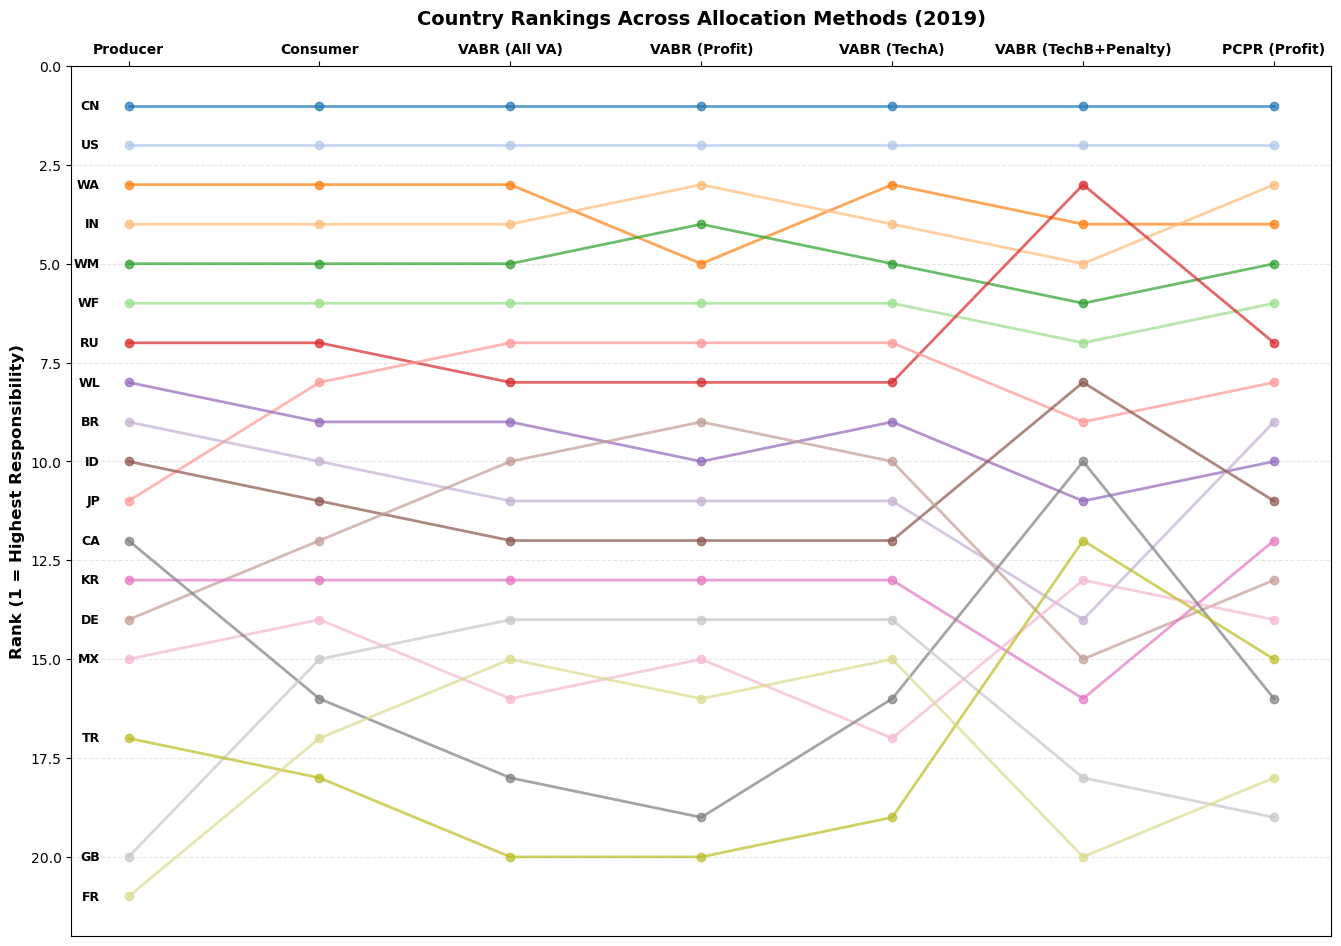


✓ Slope chart created

### Biggest Rank Changes ###

Producer → Consumer:
  Biggest rank improvements:
    GB: #20 → #15 (-5)
    FR: #21 → #17 (-4)
    JP: #11 → #8 (-3)
  Biggest rank declines:
    CA: #12 → #16 (+4)
    WL: #8 → #9 (+1)
    BR: #9 → #10 (+1)

Consumer → VABR (All VA):
  Biggest rank improvements:
    DE: #12 → #10 (-2)
    FR: #17 → #15 (-2)
    JP: #8 → #7 (-1)
  Biggest rank declines:
    MX: #14 → #16 (+2)
    CA: #16 → #18 (+2)
    TR: #18 → #20 (+2)

VABR (All VA) → VABR (Profit):
  Biggest rank improvements:
    IN: #4 → #3 (-1)
    WM: #5 → #4 (-1)
    DE: #10 → #9 (-1)
  Biggest rank declines:
    WA: #3 → #5 (+2)
    WL: #9 → #10 (+1)
    CA: #18 → #19 (+1)

VABR (Profit) → VABR (TechA):
  Biggest rank improvements:
    CA: #19 → #16 (-3)
    WA: #5 → #3 (-2)
    WL: #10 → #9 (-1)
  Biggest rank declines:
    MX: #15 → #17 (+2)
    IN: #3 → #4 (+1)
    WM: #4 → #5 (+1)

VABR (TechA) → VABR (TechB+Penalty):
  Biggest rank improvements:
    TR: #19 → #12 (-7

In [17]:
# ===================================================================
# SLOPE CHART: RANK CHANGES ACROSS ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print("SLOPE CHART: Country Rankings Across Methods")
print("="*70)

# Compute ranks (1 = highest emitter)
ranks = comparison_df.rank(ascending=False, method='min')

# Keep top 15 countries (appear in top 15 in any method)
top_countries = pd.Index(
    np.unique(
        np.concatenate([ranks[col].nsmallest(15).index for col in ranks.columns])
    )
)

# Filter to those countries only
ranks_filtered = ranks.loc[top_countries]

# Sort by average rank for better visualization
avg_rank = ranks_filtered.mean(axis=1).sort_values()
ranks_filtered = ranks_filtered.loc[avg_rank.index]

print(f"\nCountries shown: {len(ranks_filtered)}")
print(f"Methods: {list(ranks_filtered.columns)}")

# Define x positions
approaches = ranks_filtered.columns.tolist()
x = np.arange(len(approaches))

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

# Color palette
colors = plt.cm.tab20.colors

for i, country in enumerate(ranks_filtered.index):
    # Plot line
    ax.plot(x, ranks_filtered.loc[country], 
            marker='o', 
            color=colors[i % len(colors)],
            linewidth=2,
            markersize=6,
            alpha=0.7)
    
    # Add country label on the LEFT (at first method)
    ax.text(x[0] - 0.15, ranks_filtered.loc[country, approaches[0]],
            country, 
            ha='right',
            va='center', 
            fontsize=9,
            fontweight='bold')

# Set x-axis with method names on TOP
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove bottom labels
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(x)
ax.set_xticklabels(approaches, fontsize=10, fontweight='bold', rotation=0, ha='center')

# Y-axis
ax.set_ylabel("Rank (1 = Highest Responsibility)", fontsize=12, fontweight='bold')
ax.invert_yaxis()  # Rank 1 at top

# Title below x-axis labels
ax.set_title(f"Country Rankings Across Allocation Methods ({SINGLE_YEAR})", 
             fontsize=14, fontweight='bold', pad=30)

# Grid
ax.grid(alpha=0.3, linestyle='--', axis='y')

# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.05)

plt.show()

print("\n✓ Slope chart created")

# ===================================================================
# ANALYZE RANK CHANGES
# ===================================================================

print("\n### Biggest Rank Changes ###")

for method_idx in range(1, len(approaches)):
    prev_method = approaches[method_idx - 1]
    curr_method = approaches[method_idx]
    
    rank_change = ranks_filtered[curr_method] - ranks_filtered[prev_method]
    
    print(f"\n{prev_method} → {curr_method}:")
    
    # Biggest improvements (rank goes DOWN = better)
    improvers = rank_change.nsmallest(3)
    if len(improvers) > 0:
        print("  Biggest rank improvements:")
        for country, change in improvers.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")
    
    # Biggest declines (rank goes UP = worse)
    decliners = rank_change.nlargest(3)
    if len(decliners) > 0:
        print("  Biggest rank declines:")
        for country, change in decliners.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")

# ===================================================================
# KEY INSIGHTS
# ===================================================================

print("\n### Key Insights ###")

# Most stable countries (low variance in ranks)
rank_variance = ranks_filtered.var(axis=1).sort_values()
print("\nMost stable rankings (consistent across methods):")
for country in rank_variance.head(5).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    print(f"  {country}: avg rank {mean_rank:.1f} (±{std_rank:.1f})")

# Most volatile countries (high variance in ranks)
print("\nMost volatile rankings (vary greatly by method):")
for country in rank_variance.tail(5).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    min_rank = ranks_filtered.loc[country].min()
    max_rank = ranks_filtered.loc[country].max()
    print(f"  {country}: avg {mean_rank:.1f} (±{std_rank:.1f}), range #{int(min_rank)}-#{int(max_rank)}")

# ===================================================================
# COMPARE PRODUCER VS PCPR
# ===================================================================

print("\n### Producer vs PCPR Comparison ###")
producer_ranks = ranks_filtered['Producer']
pcpr_all_ranks = ranks_filtered['PCPR (Profit)']  # ✅ Fixed name
rank_diff = pcpr_all_ranks - producer_ranks

print("\nCountries that rank BETTER under PCPR:")
better = rank_diff[rank_diff < 0].sort_values()
for country, diff in better.head(5).items():
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

print("\nCountries that rank WORSE under PCPR:")
worse = rank_diff[rank_diff > 0].sort_values(ascending=False)
for country, diff in worse.head(5).items():
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

# ===================================================================
# ADDITIONAL INSIGHT: VABR VS PCPR
# ===================================================================

print("\n### VABR vs PCPR Comparison ###")
vabr_ranks = ranks_filtered['VABR (Profit)']
pcpr_ranks = ranks_filtered['PCPR (Profit)']
vabr_pcpr_diff = pcpr_ranks - vabr_ranks

print("\nCountries that rank BETTER under PCPR than VABR:")
better_pcpr = vabr_pcpr_diff[vabr_pcpr_diff < 0].sort_values()
for country, diff in better_pcpr.head(5).items():
    print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")

print("\nCountries that rank WORSE under PCPR than VABR:")
worse_pcpr = vabr_pcpr_diff[vabr_pcpr_diff > 0].sort_values(ascending=False)
for country, diff in worse_pcpr.head(5).items():
    print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")


SLOPE CHART: Country Rankings Across Methods

Countries shown: ['CN', 'US', 'EU', 'IN', 'WM', 'RU', 'JP', 'AU']
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'PCPR (Profit)', 'VABR (TechA)']


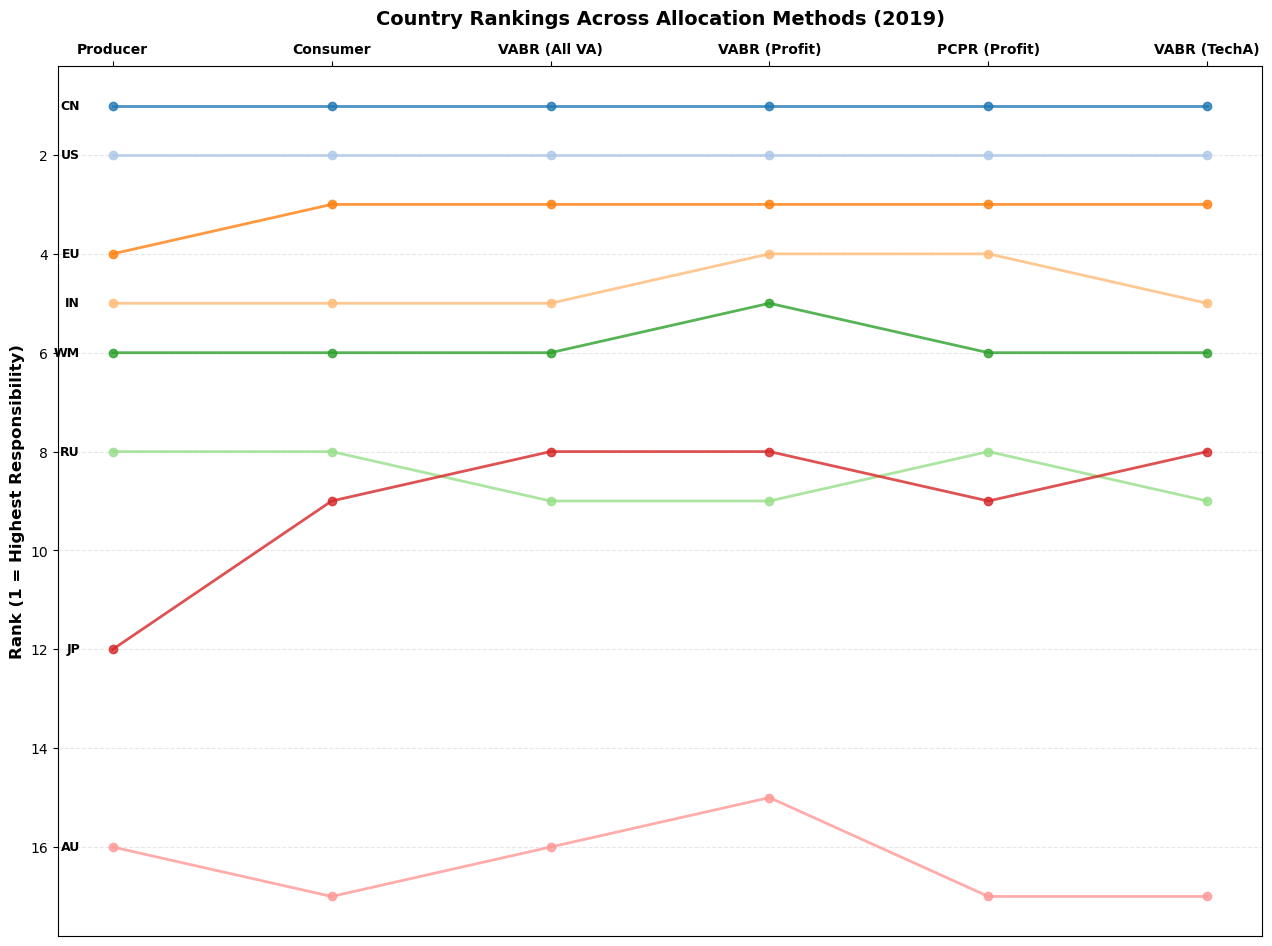


✓ Slope chart created

### Biggest Rank Changes (within selected countries/methods) ###

Producer → Consumer:
  Biggest rank improvements:
    JP: #12 → #9 (-3)
    EU: #4 → #3 (-1)
    CN: #1 → #1 (+0)
  Biggest rank declines:
    AU: #16 → #17 (+1)
    CN: #1 → #1 (+0)
    US: #2 → #2 (+0)

Consumer → VABR (All VA):
  Biggest rank improvements:
    JP: #9 → #8 (-1)
    AU: #17 → #16 (-1)
    CN: #1 → #1 (+0)
  Biggest rank declines:
    RU: #8 → #9 (+1)
    CN: #1 → #1 (+0)
    US: #2 → #2 (+0)

VABR (All VA) → VABR (Profit):
  Biggest rank improvements:
    IN: #5 → #4 (-1)
    WM: #6 → #5 (-1)
    AU: #16 → #15 (-1)
  Biggest rank declines:
    CN: #1 → #1 (+0)
    US: #2 → #2 (+0)
    EU: #3 → #3 (+0)

VABR (Profit) → PCPR (Profit):
  Biggest rank improvements:
    RU: #9 → #8 (-1)
    CN: #1 → #1 (+0)
    US: #2 → #2 (+0)
  Biggest rank declines:
    AU: #15 → #17 (+2)
    WM: #5 → #6 (+1)
    JP: #8 → #9 (+1)

PCPR (Profit) → VABR (TechA):
  Biggest rank improvements:
    JP: #

In [18]:
# ===================================================================
# SLOPE CHART: FLEXIBLE COUNTRY + METHOD SELECTION
# ===================================================================

print("\n" + "="*70)
print("SLOPE CHART: Country Rankings Across Methods")
print("="*70)

# -------- Parameters you can easily change --------
countries_for_slope = ['CN', 'US', 'WM', 'EU', 'AU', 'JP', 'RU', "IN"]

methods_for_slope = [
    'Producer',
    'Consumer',
    'VABR (All VA)',
    'VABR (Profit)',
    'PCPR (All VA)',
    'PCPR (Profit)',
    'VABR (TechA)',
    # 'VABR (TechB+Penalty)',
]

# --------------------------------------------------
# Choose which DataFrame to use (with EU aggregated if available)
df_rank_source = comparison_df_eu if 'comparison_df_eu' in globals() else comparison_df

# Filter methods to those that actually exist
methods_for_slope = [m for m in methods_for_slope if m in df_rank_source.columns]
if len(methods_for_slope) == 0:
    raise ValueError("No valid methods selected for slope chart.")

# Compute ranks (1 = highest emitter) only for selected methods
ranks = df_rank_source[methods_for_slope].rank(ascending=False, method='min')

# Filter countries
if countries_for_slope:
    available_countries = ranks.index.intersection(countries_for_slope)
    missing_countries = [c for c in countries_for_slope if c not in ranks.index]
    if missing_countries:
        print(f"Warning: these selected countries are not in the data: {missing_countries}")
    ranks_filtered = ranks.loc[available_countries]
else:
    # fallback: use all countries
    ranks_filtered = ranks.copy()

# Optional: sort by average rank for nicer layout
avg_rank = ranks_filtered.mean(axis=1).sort_values()
ranks_filtered = ranks_filtered.loc[avg_rank.index]

print(f"\nCountries shown: {list(ranks_filtered.index)}")
print(f"Methods: {list(ranks_filtered.columns)}")

# Define x positions
approaches = ranks_filtered.columns.tolist()
x = np.arange(len(approaches))

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

# Color palette
colors = plt.cm.tab20.colors

for i, country in enumerate(ranks_filtered.index):
    # Plot line
    ax.plot(
        x,
        ranks_filtered.loc[country],
        marker='o',
        color=colors[i % len(colors)],
        linewidth=2,
        markersize=6,
        alpha=0.8
    )
    
    # Add country label on the LEFT (at first method)
    ax.text(
        x[0] - 0.15,
        ranks_filtered.loc[country, approaches[0]],
        country,
        ha='right',
        va='center',
        fontsize=9,
        fontweight='bold'
    )

# Set x-axis with method names on TOP
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove bottom labels
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(x)
ax.set_xticklabels(approaches, fontsize=10, fontweight='bold', rotation=0, ha='center')

# Y-axis
ax.set_ylabel("Rank (1 = Highest Responsibility)", fontsize=12, fontweight='bold')
ax.invert_yaxis()  # Rank 1 at top

ax.set_title(
    f"Country Rankings Across Allocation Methods ({SINGLE_YEAR})",
    fontsize=14, fontweight='bold',
    pad=30
)

ax.grid(alpha=0.3, linestyle='--', axis='y')

plt.subplots_adjust(left=0.12, right=0.98, top=0.92, bottom=0.05)

plt.show()

print("\n✓ Slope chart created")

# ===================================================================
# ANALYZE RANK CHANGES (only for the selected countries/methods)
# ===================================================================

print("\n### Biggest Rank Changes (within selected countries/methods) ###")

for method_idx in range(1, len(approaches)):
    prev_method = approaches[method_idx - 1]
    curr_method = approaches[method_idx]
    
    rank_change = ranks_filtered[curr_method] - ranks_filtered[prev_method]
    
    print(f"\n{prev_method} → {curr_method}:")
    
    # Biggest improvements (rank goes DOWN = besser)
    improvers = rank_change.nsmallest(3)
    if len(improvers) > 0:
        print("  Biggest rank improvements:")
        for country, change in improvers.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")
    
    # Biggest declines (rank goes UP = schlechter)
    decliners = rank_change.nlargest(3)
    if len(decliners) > 0:
        print("  Biggest rank declines:")
        for country, change in decliners.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")

# ===================================================================
# KEY INSIGHTS (within selected set)
# ===================================================================

print("\n### Key Insights (selected countries) ###")

rank_variance = ranks_filtered.var(axis=1).sort_values()

print("\nMost stable rankings (consistent across methods):")
for country in rank_variance.head(min(5, len(rank_variance))).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    print(f"  {country}: avg rank {mean_rank:.1f} (±{std_rank:.1f})")

print("\nMost volatile rankings (vary greatly by method):")
for country in rank_variance.tail(min(5, len(rank_variance))).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    min_rank = ranks_filtered.loc[country].min()
    max_rank = ranks_filtered.loc[country].max()
    print(f"  {country}: avg {mean_rank:.1f} (±{std_rank:.1f}), range #{int(min_rank)}-#{int(max_rank)}")

# ===================================================================
# OPTIONAL: PRODUCER vs PCPR COMPARISON (only if both present)
# ===================================================================

if 'Producer' in ranks_filtered.columns and 'PCPR (All VA)' in ranks_filtered.columns:
    print("\n### Producer vs PCPR (All VA) Comparison ###")
    producer_ranks = ranks_filtered['Producer']
    pcpr_all_ranks = ranks_filtered['PCPR (All VA)']
    rank_diff = pcpr_all_ranks - producer_ranks

    print("\nCountries that rank BETTER under PCPR:")
    better = rank_diff[rank_diff < 0].sort_values()
    for country, diff in better.head(min(5, len(better))).items():
        print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

    print("\nCountries that rank WORSE under PCPR:")
    worse = rank_diff[rank_diff > 0].sort_values(ascending=False)
    for country, diff in worse.head(min(5, len(worse))).items():
        print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

# ===================================================================
# OPTIONAL: VABR vs PCPR (only if both present)
# ===================================================================

if 'VABR (All VA)' in ranks_filtered.columns and 'PCPR (All VA)' in ranks_filtered.columns:
    print("\n### VABR (All VA) vs PCPR (All VA) Comparison ###")
    vabr_ranks = ranks_filtered['VABR (All VA)']
    pcpr_ranks = ranks_filtered['PCPR (All VA)']
    vabr_pcpr_diff = pcpr_ranks - vabr_ranks

    print("\nCountries that rank BETTER under PCPR than VABR:")
    better_pcpr = vabr_pcpr_diff[vabr_pcpr_diff < 0].sort_values()
    for country, diff in better_pcpr.head(min(5, len(better_pcpr))).items():
        print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")

    print("\nCountries that rank WORSE under PCPR than VABR:")
    worse_pcpr = vabr_pcpr_diff[vabr_pcpr_diff > 0].sort_values(ascending=False)
    for country, diff in worse_pcpr.head(min(5, len(worse_pcpr))).items():
        print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")



SLOPE CHART: Country Rankings Across Methods (ALL REGIONS)

Total countries/regions: 49
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'VABR (TechA)', 'VABR (TechB+Penalty)', 'PCPR (Profit)']


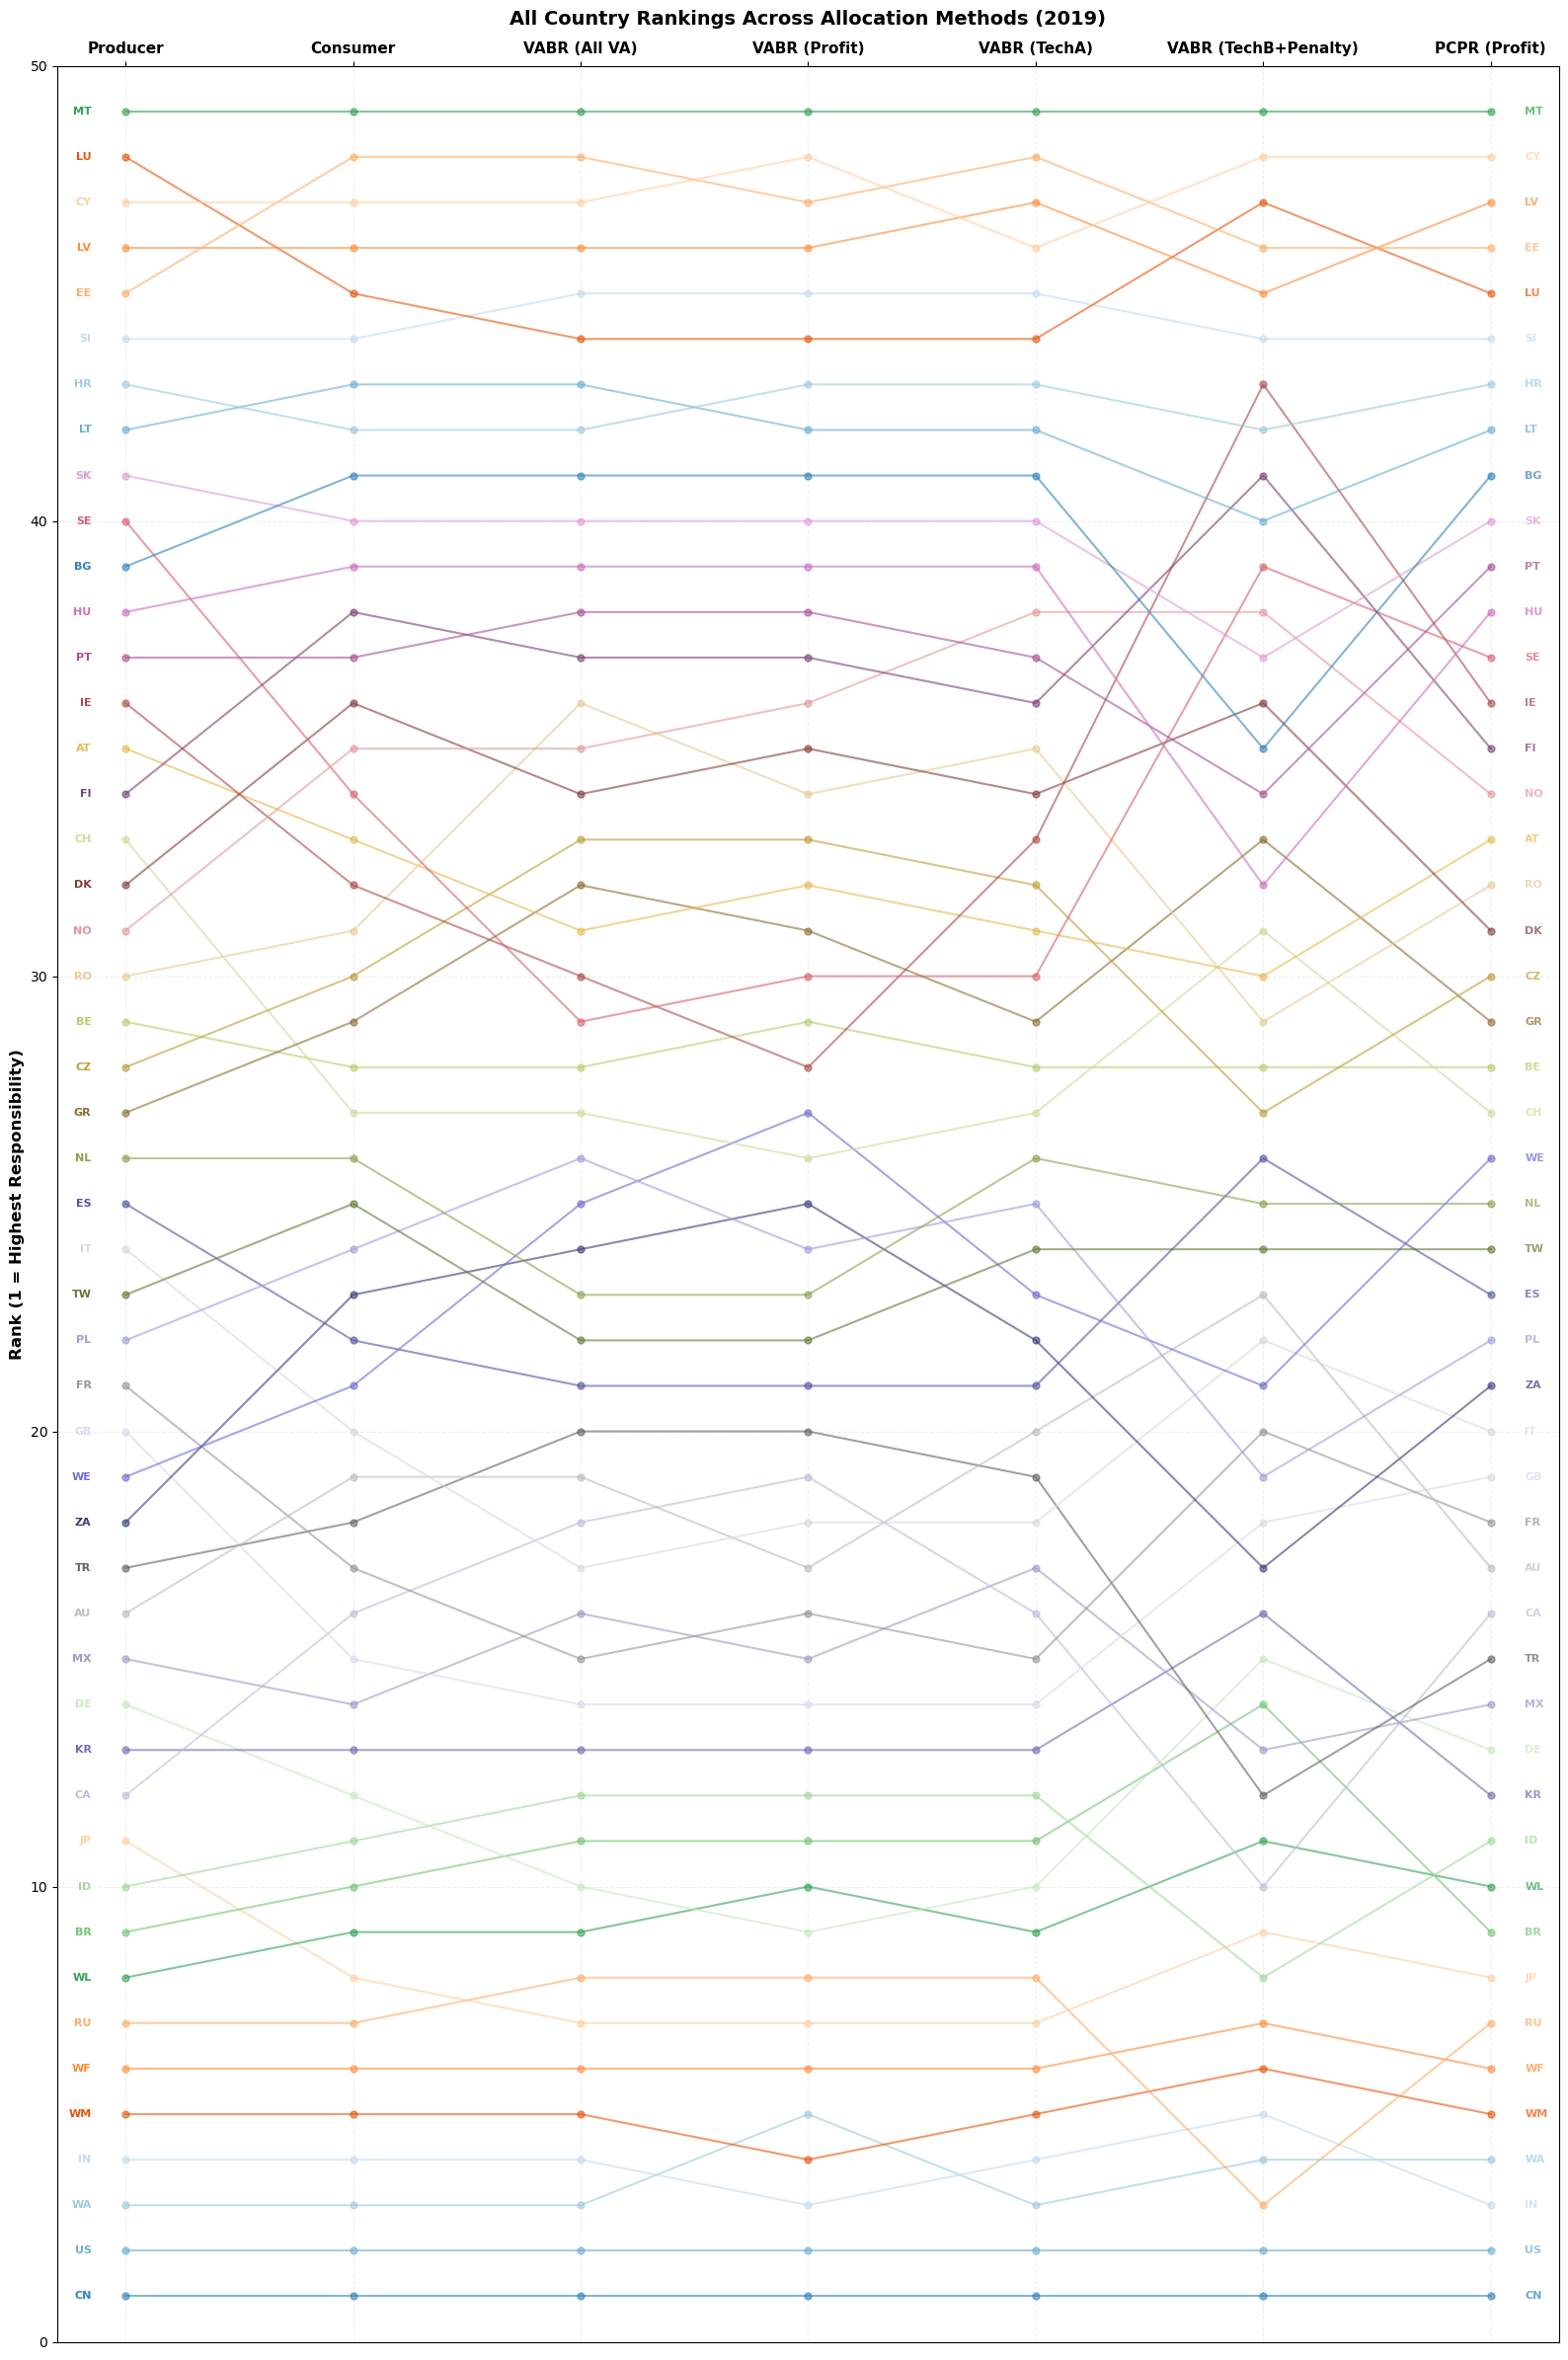


✓ Slope chart created (all regions)

### Biggest Rank Changes (All Regions) ###

Producer → Consumer:
  Biggest rank improvements:
    CH: #33 → #27 (-6)
    SE: #40 → #34 (-6)
    GB: #20 → #15 (-5)
    FR: #21 → #17 (-4)
    IT: #24 → #20 (-4)
  Biggest rank declines:
    ZA: #18 → #23 (+5)
    CA: #12 → #16 (+4)
    DK: #32 → #36 (+4)
    NO: #31 → #35 (+4)
    FI: #34 → #38 (+4)

Consumer → VABR (All VA):
  Biggest rank improvements:
    SE: #34 → #29 (-5)
    IT: #20 → #17 (-3)
    TW: #25 → #22 (-3)
    NL: #26 → #23 (-3)
    DE: #12 → #10 (-2)
  Biggest rank declines:
    RO: #31 → #36 (+5)
    WE: #21 → #25 (+4)
    GR: #29 → #32 (+3)
    CZ: #30 → #33 (+3)
    MX: #14 → #16 (+2)

VABR (All VA) → VABR (Profit):
  Biggest rank improvements:
    AU: #19 → #17 (-2)
    PL: #26 → #24 (-2)
    RO: #36 → #34 (-2)
    IE: #30 → #28 (-2)
    IN: #4 → #3 (-1)
  Biggest rank declines:
    WA: #3 → #5 (+2)
    WE: #25 → #27 (+2)
    WL: #9 → #10 (+1)
    CA: #18 → #19 (+1)
    FR: #15 → 

KeyError: 'PCPR (All VA)'

In [19]:
# ===================================================================
# SLOPE CHART: RANK CHANGES ACROSS ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print("SLOPE CHART: Country Rankings Across Methods (ALL REGIONS)")
print("="*70)

# Compute ranks (1 = highest emitter)
ranks = comparison_df.rank(ascending=False, method='min')

print(f"\nTotal countries/regions: {len(ranks)}")
print(f"Methods: {list(ranks.columns)}")

# Sort by average rank for better visualization
avg_rank = ranks.mean(axis=1).sort_values()
ranks_sorted = ranks.loc[avg_rank.index]

# Define x positions
approaches = ranks_sorted.columns.tolist()
x = np.arange(len(approaches))

# Plot - MUCH BIGGER for all countries
fig, ax = plt.subplots(figsize=(16, 24))  # Tall figure for all countries

# Color palette - cycle through colors
colors = plt.cm.tab20c.colors + plt.cm.tab20b.colors  # 40 colors

for i, country in enumerate(ranks_sorted.index):
    # Plot line
    ax.plot(x, ranks_sorted.loc[country], 
            marker='o', 
            color=colors[i % len(colors)],
            linewidth=1.5,
            markersize=5,
            alpha=0.6)
    
    # Add country label on the LEFT (at first method)
    ax.text(x[0] - 0.15, ranks_sorted.loc[country, approaches[0]],
            country, 
            ha='right',
            va='center', 
            fontsize=8,
            fontweight='bold',
            color=colors[i % len(colors)])
    
    # OPTIONAL: Also add label on the RIGHT (at last method) for easier reading
    ax.text(x[-1] + 0.15, ranks_sorted.loc[country, approaches[-1]],
            country, 
            ha='left',
            va='center', 
            fontsize=8,
            fontweight='bold',
            color=colors[i % len(colors)],
            alpha=0.7)

# Set x-axis with method names on TOP
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove bottom labels
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(x)
ax.set_xticklabels(approaches, fontsize=11, fontweight='bold', rotation=0, ha='center')

# Y-axis
ax.set_ylabel("Rank (1 = Highest Responsibility)", fontsize=12, fontweight='bold')
ax.set_ylim(len(ranks) + 1, 0)  # Rank 1 at top, with some margin
ax.invert_yaxis()

# Title
ax.set_title(f"All Country Rankings Across Allocation Methods ({SINGLE_YEAR})", 
             fontsize=14, fontweight='bold', pad=30)

# Grid
ax.grid(alpha=0.2, linestyle='--', axis='both')

# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.12, right=0.88, top=0.95, bottom=0.02)

plt.tight_layout()
plt.show()

print("\n✓ Slope chart created (all regions)")

# ===================================================================
# ANALYZE RANK CHANGES
# ===================================================================

print("\n### Biggest Rank Changes (All Regions) ###")

for method_idx in range(1, len(approaches)):
    prev_method = approaches[method_idx - 1]
    curr_method = approaches[method_idx]
    
    rank_change = ranks_sorted[curr_method] - ranks_sorted[prev_method]
    
    print(f"\n{prev_method} → {curr_method}:")
    
    # Biggest improvements (rank goes DOWN = better)
    improvers = rank_change.nsmallest(5)  # Show top 5
    if len(improvers) > 0:
        print("  Biggest rank improvements:")
        for country, change in improvers.items():
            old_rank = ranks_sorted.loc[country, prev_method]
            new_rank = ranks_sorted.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")
    
    # Biggest declines (rank goes UP = worse)
    decliners = rank_change.nlargest(5)
    if len(decliners) > 0:
        print("  Biggest rank declines:")
        for country, change in decliners.items():
            old_rank = ranks_sorted.loc[country, prev_method]
            new_rank = ranks_sorted.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")

# ===================================================================
# KEY INSIGHTS
# ===================================================================

print("\n### Key Insights (All Regions) ###")

# Most stable countries (low variance in ranks)
rank_variance = ranks_sorted.var(axis=1).sort_values()
print("\nMost stable rankings (consistent across methods):")
for country in rank_variance.head(10).index:
    mean_rank = ranks_sorted.loc[country].mean()
    std_rank = ranks_sorted.loc[country].std()
    print(f"  {country}: avg rank {mean_rank:.1f} (±{std_rank:.1f})")

# Most volatile countries (high variance in ranks)
print("\nMost volatile rankings (vary greatly by method):")
for country in rank_variance.tail(10).index:
    mean_rank = ranks_sorted.loc[country].mean()
    std_rank = ranks_sorted.loc[country].std()
    min_rank = ranks_sorted.loc[country].min()
    max_rank = ranks_sorted.loc[country].max()
    print(f"  {country}: avg {mean_rank:.1f} (±{std_rank:.1f}), range #{int(min_rank)}-#{int(max_rank)}")

# Compare traditional methods vs PCPR
print("\n### Producer vs PCPR Comparison ###")
producer_ranks = ranks_sorted['Producer']
pcpr_all_ranks = ranks_sorted['PCPR (All VA)']  # ✅ FIXED NAME
rank_diff = pcpr_all_ranks - producer_ranks

print("\nCountries that rank BETTER under PCPR:")
better = rank_diff[rank_diff < 0].sort_values()
for country, diff in better.head(10).items():  # Top 10
    old_emissions = comparison_df.loc[country, 'Producer']
    new_emissions = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} "
          f"({int(diff):+d}) | {old_emissions:.2f} → {new_emissions:.2f} Gt")

print("\nCountries that rank WORSE under PCPR:")
worse = rank_diff[rank_diff > 0].sort_values(ascending=False)
for country, diff in worse.head(10).items():  # Top 10
    old_emissions = comparison_df.loc[country, 'Producer']
    new_emissions = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} "
          f"({int(diff):+d}) | {old_emissions:.2f} → {new_emissions:.2f} Gt")

# ===================================================================
# ADDITIONAL: Countries with extreme changes
# ===================================================================

print("\n### Extreme Multipliers (PCPR vs Producer) ###")

multipliers = comparison_df['PCPR (All VA)'] / comparison_df['Producer']
multipliers = multipliers.replace([np.inf, -np.inf], np.nan).dropna()

print("\nHighest PCPR multipliers (most increased responsibility):")
for country in multipliers.nlargest(10).index:
    mult = multipliers[country]
    prod = comparison_df.loc[country, 'Producer']
    pcpr = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: {mult:.2f}x ({prod:.3f} → {pcpr:.3f} Gt)")

print("\nLowest PCPR multipliers (most decreased responsibility):")
for country in multipliers.nsmallest(10).index:
    mult = multipliers[country]
    prod = comparison_df.loc[country, 'Producer']
    pcpr = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: {mult:.2f}x ({prod:.3f} → {pcpr:.3f} Gt)")


RANKING TABLES: Country Rankings by Method

### ABSOLUTE EMISSIONS RANKING ###

Absolute Ranking Table (Top 20):
        Producer    Consumer VABR (All VA) VABR (Profit) VABR (TechA)  \
Rank                                                                    
1     CN (12.96)  CN (11.82)    CN (11.49)    CN (11.04)   CN (11.35)   
2      US (5.10)   US (6.21)     US (6.53)     US (6.59)    US (6.38)   
3      WA (3.52)   WA (3.70)     WA (3.09)     IN (2.96)    WA (3.19)   
4      IN (3.45)   IN (3.17)     IN (2.89)     WM (2.77)    IN (3.00)   
5      WM (3.06)   WM (2.54)     WM (2.46)     WA (2.37)    WM (2.81)   
6      WF (2.24)   WF (2.22)     WF (1.89)     WF (1.88)    WF (2.08)   
7      RU (2.04)   RU (1.55)     JP (1.69)     JP (1.68)    JP (1.62)   
8      WL (1.33)   JP (1.44)     RU (1.50)     RU (1.61)    RU (1.59)   
9      BR (1.18)   WL (1.30)     WL (1.26)     DE (1.21)    WL (1.27)   
10     ID (1.07)   BR (1.06)     DE (1.22)     WL (1.19)    DE (1.12)   
11     JP 

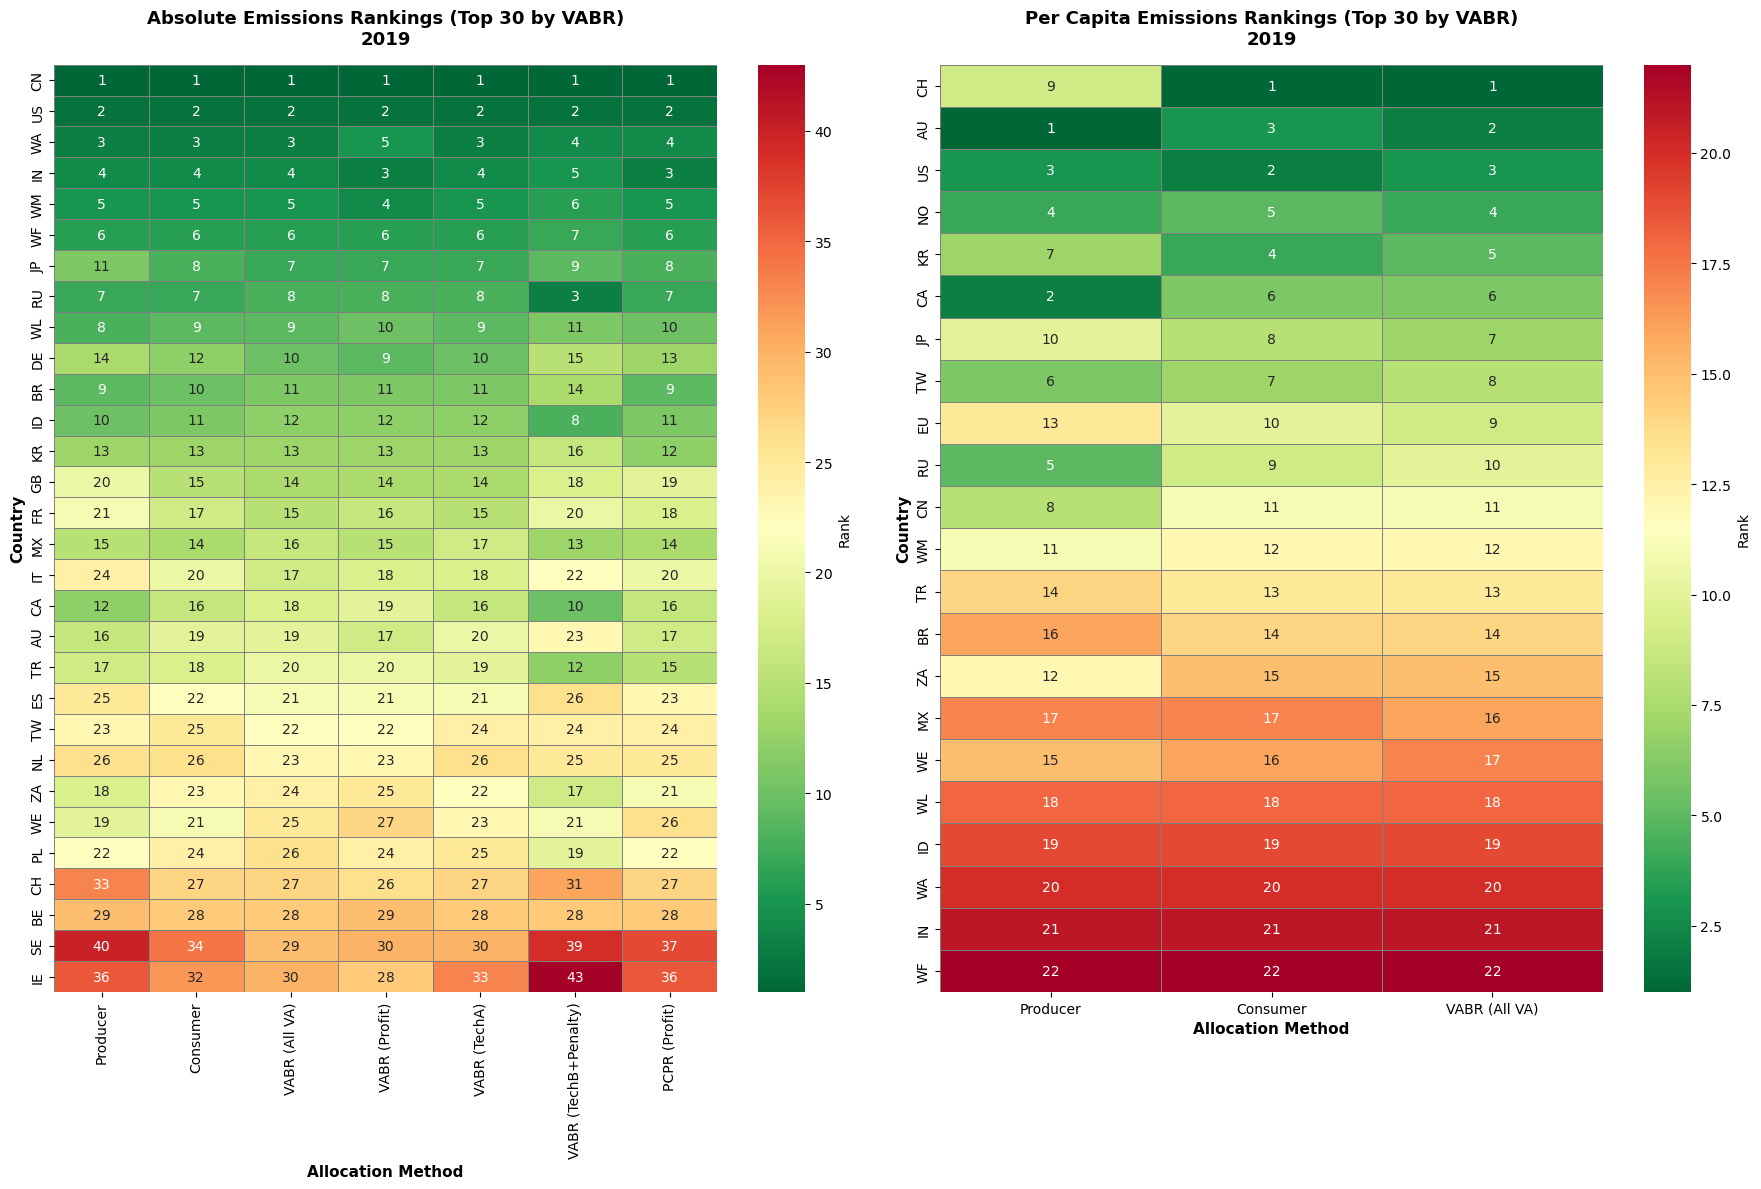


✓ Ranking heatmaps created and saved

### Ranking Stability Analysis ###

ABSOLUTE RANKINGS:

Most stable rankings (5 countries with smallest rank variation):
  CN: ranks [1. 1. 1. 1. 1. 1. 1.], std=0.00
  MT: ranks [49. 49. 49. 49. 49. 49. 49.], std=0.00
  US: ranks [2. 2. 2. 2. 2. 2. 2.], std=0.00
  WF: ranks [6. 6. 6. 6. 6. 7. 6.], std=0.38
  BE: ranks [29. 28. 28. 29. 28. 28. 28.], std=0.49

Most volatile rankings (5 countries with largest rank variation):
  WE: ranks [19. 21. 25. 27. 23. 21. 26.], range #19-#27, std=2.97
  ZA: ranks [18. 23. 24. 25. 22. 17. 21.], range #17-#25, std=2.99
  CA: ranks [12. 16. 18. 19. 16. 10. 16.], range #10-#19, std=3.20
  SE: ranks [40. 34. 29. 30. 30. 39. 37.], range #29-#40, std=4.60
  IE: ranks [36. 32. 30. 28. 33. 43. 36.], range #28-#43, std=4.93

PER CAPITA RANKINGS:

Most stable rankings (5 countries with smallest rank variation):
  WL: ranks [18. 18. 18.], std=0.00
  ID: ranks [19. 19. 19.], std=0.00
  WF: ranks [22. 22. 22.], std=0.00
  I

Ellipsis

In [20]:
# ===================================================================
# RANKING TABLES - ABSOLUTE AND PER CAPITA
# ===================================================================

print("\n" + "="*70)
print("RANKING TABLES: Country Rankings by Method")
print("="*70)

# ===================================================================
# 1. ABSOLUTE EMISSIONS RANKING TABLE
# ===================================================================

print("\n### ABSOLUTE EMISSIONS RANKING ###")

# Calculate ranks (already have this from before, but recalculate to be sure)
absolute_ranks = comparison_df.rank(ascending=False, method='min')

# Create ranking table: rows are ranks, columns are methods
n_countries = len(comparison_df)
n_methods = len(comparison_df.columns)

# Initialize empty DataFrame
absolute_ranking_table = pd.DataFrame(
    index=range(1, n_countries + 1),
    columns=comparison_df.columns
)
absolute_ranking_table.index.name = 'Rank'

# Fill table: for each method, sort countries by rank
for method in comparison_df.columns:
    # Sort countries by their emissions (highest first)
    sorted_countries = comparison_df[method].sort_values(ascending=False)
    
    # Assign country names to ranks
    for rank, (country, value) in enumerate(sorted_countries.items(), start=1):
        absolute_ranking_table.loc[rank, method] = f"{country} ({value:.2f})"

print("\nAbsolute Ranking Table (Top 20):")
print(absolute_ranking_table.head(20))

# Save to CSV
absolute_ranking_table.to_csv(RESULTS_PATH / f'absolute_ranking_table_{SINGLE_YEAR}.csv')
print(f"\n✓ Saved to: {RESULTS_PATH / f'absolute_ranking_table_{SINGLE_YEAR}.csv'}")

# ===================================================================
# 2. PER CAPITA EMISSIONS RANKING TABLE
# ===================================================================

print("\n### PER CAPITA EMISSIONS RANKING ###")

# Calculate ranks for per capita data
per_capita_ranks = per_capita.rank(ascending=False, method='min')

n_countries_pc = len(per_capita)

# Initialize empty DataFrame
per_capita_ranking_table = pd.DataFrame(
    index=range(1, n_countries_pc + 1),
    columns=per_capita.columns
)
per_capita_ranking_table.index.name = 'Rank'

# Fill table: for each method, sort countries by rank
for method in per_capita.columns:
    # Sort countries by their per capita emissions (highest first)
    sorted_countries = per_capita[method].sort_values(ascending=False)
    
    # Assign country names to ranks
    for rank, (country, value) in enumerate(sorted_countries.items(), start=1):
        per_capita_ranking_table.loc[rank, method] = f"{country} ({value:.2f})"

print("\nPer Capita Ranking Table (Top 20):")
print(per_capita_ranking_table.head(20))

# Save to CSV
per_capita_ranking_table.to_csv(RESULTS_PATH / f'per_capita_ranking_table_{SINGLE_YEAR}.csv')
print(f"\n✓ Saved to: {RESULTS_PATH / f'per_capita_ranking_table_{SINGLE_YEAR}.csv'}")

# ===================================================================
# 3. VISUAL REPRESENTATION - HEATMAP STYLE (OPTIONAL)
# ===================================================================

print("\n### Creating Visual Ranking Heatmaps ###")

# For visual heatmap, we just show rank numbers (not country names)
# This makes it easier to see patterns

# ABSOLUTE RANKINGS HEATMAP (Top 30)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

# Get rank numbers for heatmap
absolute_rank_numbers = absolute_ranks.copy()
absolute_rank_numbers = absolute_rank_numbers.sort_values(by='VABR (All VA)')

# Show top 30 countries only
top30_absolute = absolute_rank_numbers.head(30)

# Create heatmap
sns.heatmap(
    top30_absolute,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn_r',  # Green = high rank (worse), Red = low rank (better)
    cbar_kws={'label': 'Rank'},
    ax=ax1,
    linewidths=0.5,
    linecolor='gray'
)

ax1.set_title(f'Absolute Emissions Rankings (Top 30 by VABR)\n{SINGLE_YEAR}',
              fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Allocation Method', fontsize=11, fontweight='bold')
ax1.set_ylabel('Country', fontsize=11, fontweight='bold')

# PER CAPITA RANKINGS HEATMAP (Top 30)
per_capita_rank_numbers = per_capita_ranks.copy()
per_capita_rank_numbers = per_capita_rank_numbers.sort_values(by='VABR (All VA)')

# Show top 30 countries only
top30_per_capita = per_capita_rank_numbers.head(30)

sns.heatmap(
    top30_per_capita,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Rank'},
    ax=ax2,
    linewidths=0.5,
    linecolor='gray'
)

ax2.set_title(f'Per Capita Emissions Rankings (Top 30 by VABR)\n{SINGLE_YEAR}',
              fontsize=13, fontweight='bold', pad=15)
ax2.set_xlabel('Allocation Method', fontsize=11, fontweight='bold')
ax2.set_ylabel('Country', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_PATH / f'ranking_heatmaps_{SINGLE_YEAR}.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Ranking heatmaps created and saved")

# ===================================================================
# 4. SUMMARY STATISTICS - RANK CHANGES
# ===================================================================

print("\n### Ranking Stability Analysis ###")

# For absolute rankings
print("\nABSOLUTE RANKINGS:")
rank_std_absolute = absolute_ranks.std(axis=1).sort_values()

print("\nMost stable rankings (5 countries with smallest rank variation):")
for country in rank_std_absolute.head(5).index:
    ranks_list = absolute_ranks.loc[country].values
    print(f"  {country}: ranks {ranks_list}, std={rank_std_absolute[country]:.2f}")

print("\nMost volatile rankings (5 countries with largest rank variation):")
for country in rank_std_absolute.tail(5).index:
    ranks_list = absolute_ranks.loc[country].values
    min_rank = int(ranks_list.min())
    max_rank = int(ranks_list.max())
    print(f"  {country}: ranks {ranks_list}, range #{min_rank}-#{max_rank}, std={rank_std_absolute[country]:.2f}")

# For per capita rankings
print("\nPER CAPITA RANKINGS:")
rank_std_per_capita = per_capita_ranks.std(axis=1).sort_values()

print("\nMost stable rankings (5 countries with smallest rank variation):")
for country in rank_std_per_capita.head(5).index:
    ranks_list = per_capita_ranks.loc[country].values
    print(f"  {country}: ranks {ranks_list}, std={rank_std_per_capita[country]:.2f}")

print("\nMost volatile rankings (5 countries with largest rank variation):")
for country in rank_std_per_capita.tail(5).index:
    ranks_list = per_capita_ranks.loc[country].values
    min_rank = int(ranks_list.min())
    max_rank = int(ranks_list.max())
    print(f"  {country}: ranks {ranks_list}, range #{min_rank}-#{max_rank}, std={rank_std_per_capita[country]:.2f}")

# ===================================================================
# 5. EXPORT FULL TABLES TO EXCEL
# ===================================================================

print("\n### Exporting to Excel ###")

with pd.ExcelWriter(RESULTS_PATH / f'ranking_tables_{SINGLE_YEAR}.xlsx') as writer:
    # Sheet 1: Absolute rankings
    absolute_ranking_table.to_excel(writer, sheet_name='Absolute Rankings')
    
    # Sheet 2: Per capita rankings
    per_capita_ranking_table.to_excel(writer, sheet_name='Per Capita Rankings')
    
    # Sheet 3: Absolute rank numbers (for further analysis)
    absolute_ranks.to_excel(writer, sheet_name='Absolute Rank Numbers')
    
    # Sheet 4: Per capita rank numbers
    per_capita_ranks.to_excel(writer, sheet_name='Per Capita Rank Numbers')
    
    # Sheet 5: Summary statistics
    summary_df = pd.DataFrame({
        'Absolute_Mean_Rank': absolute_ranks.mean(),
        'Absolute_Std_Rank': absolute_ranks.std(),
        'PerCapita_Mean_Rank': per_capita_ranks.mean(),
        'PerCapita_Std_Rank': per_capita_ranks.std()
    })
    summary_df.to_excel(writer, sheet_name='Summary')

print(f"✓ Saved comprehensive Excel file to: {RESULTS_PATH / f'ranking_tables_{SINGLE_YEAR}.xlsx'}")

print("\n" + "="*70)
print("✓ ALL RANKING TABLES COMPLETE")
print("="*70)
...

In [25]:
# ===================================================================
# ANALYSIS 3: WORLD MAP - DOMINANT RESPONSIBILITY METHOD (PER CAPITA)
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 3: World Map - Dominant Method per Capita ({SINGLE_YEAR})")
print("="*70)

import geopandas as gpd
from matplotlib.patches import Rectangle

# ===================================================================
# SELECT METHODS TO COMPARE ON THE MAP
# ===================================================================

# Choose any subset of methods that exist in per_capita.columns
# (e.g. 'Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'PCPR (Profit)', ...)
methods_for_map = [
    'Producer',
    #'Consumer',
    #'VABR (All VA)',
    'VABR (Profit)',
    'PCPR (Profit)',
]

# Filter to methods that actually exist in per_capita
available_methods_for_map = [m for m in methods_for_map if m in per_capita.columns]
if len(available_methods_for_map) < 2:
    raise ValueError(
        f"Need at least 2 valid methods for the map. "
        f"Available in per_capita: {list(per_capita.columns)}"
    )

print(f"\nMethods compared on map (per capita): {available_methods_for_map}")

# ===================================================================
# PREPARE DATA: Determine dominant method for each country
# ===================================================================

# Subset per_capita to selected methods
map_input = per_capita[available_methods_for_map].copy()

# Dominant method and value
map_input['dominant_method'] = map_input[available_methods_for_map].idxmax(axis=1)
map_input['max_value'] = map_input[available_methods_for_map].max(axis=1)

print(f"\nCountries by dominant method (per capita):")
print(map_input['dominant_method'].value_counts())

# ===================================================================
# COUNTRY CODE MAPPING (EXIOBASE → SHAPEFILE SOV_A3)
# ===================================================================

exiobase_to_sov = {
    'AT': 'AUT', 'BE': 'BEL', 'BG': 'BGR', 'CY': 'CYN', 'CZ': 'CZE',
    'DE': 'DEU', 'DK': 'DN1', 'EE': 'EST', 'ES': 'ESP', 'FI': 'FI1',
    'FR': 'FR1', 'GR': 'GRC', 'HR': 'HRV', 'HU': 'HUN', 'IE': 'IRL',
    'IT': 'ITA', 'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA', 'MT': 'MLT',
    'NL': 'NL1', 'PL': 'POL', 'PT': 'PRT', 'RO': 'ROU', 'SE': 'SWE',
    'SI': 'SVN', 'SK': 'SVK', 'GB': 'GB1', 'US': 'US1', 'JP': 'JPN',
    'CN': 'CH1', 'CA': 'CAN', 'KR': 'KOR', 'BR': 'BRA', 'IN': 'IND',
    'MX': 'MEX', 'RU': 'RUS', 'AU': 'AU1', 'CH': 'CHE', 'TR': 'TUR',
    'TW': 'TWN', 'NO': 'NOR', 'ID': 'IDN', 'ZA': 'ZAF'
}

iso2_to_sov = {
    'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA', 'AO': 'AGO', 'AR': 'ARG',
    'AM': 'ARM', 'AZ': 'AZE', 'BD': 'BGD', 'BH': 'BHR', 'BY': 'BLR',
    'BZ': 'BLZ', 'BJ': 'BEN', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH',
    'BW': 'BWA', 'BF': 'BFA', 'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR',
    'CV': 'CPV', 'CF': 'CAF', 'TD': 'TCD', 'CL': 'CHL', 'CO': 'COL',
    'KM': 'COM', 'CG': 'COG', 'CD': 'COD', 'CR': 'CRI', 'CI': 'CIV',
    'CU': 'CUB', 'DJ': 'DJI', 'DO': 'DOM', 'EC': 'ECU', 'EG': 'EGY',
    'SV': 'SLV', 'GQ': 'GNQ', 'ER': 'ERI', 'ET': 'ETH', 'FJ': 'FJI',
    'GA': 'GAB', 'GM': 'GMB', 'GE': 'GEO', 'GH': 'GHA', 'GT': 'GTM',
    'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HT': 'HTI', 'HN': 'HND',
    'IS': 'ISL', 'IR': 'IRN', 'IQ': 'IRQ', 'IL': 'ISR', 'JM': 'JAM',
    'JO': 'JOR', 'KE': 'KEN', 'KW': 'KWT', 'KG': 'KGZ', 'LA': 'LAO',
    'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR', 'LY': 'LBY', 'MK': 'MKD',
    'MG': 'MDG', 'MW': 'MWI', 'MY': 'MYS', 'MV': 'MDV', 'ML': 'MLI',
    'MR': 'MRT', 'MU': 'MUS', 'MD': 'MDA', 'MN': 'MNG', 'ME': 'MNE',
    'MA': 'MAR', 'MZ': 'MOZ', 'MM': 'MMR', 'NA': 'NAM', 'NP': 'NPL',
    'NZ': 'NZ1', 'NI': 'NIC', 'NE': 'NER', 'NG': 'NGA', 'OM': 'OMN',
    'PK': 'PAK', 'PA': 'PAN', 'PG': 'PNG', 'PY': 'PRY', 'PE': 'PER',
    'PH': 'PHL', 'QA': 'QAT', 'RW': 'RWA', 'SA': 'SAU', 'SN': 'SEN',
    'RS': 'SRB', 'SC': 'SYC', 'SL': 'SLE', 'SG': 'SGP', 'SO': 'SOM',
    'LK': 'LKA', 'SD': 'SDN', 'SR': 'SUR', 'SZ': 'SWZ', 'SY': 'SYR',
    'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA', 'TG': 'TGO', 'TN': 'TUN',
    'TM': 'TKM', 'UG': 'UGA', 'UA': 'UKR', 'AE': 'ARE', 'UY': 'URY',
    'UZ': 'UZB', 'VE': 'VEN', 'VN': 'VNM', 'YE': 'YEM', 'ZM': 'ZMB',
    'ZW': 'ZWE', 'KZ': 'KA1'
}

row_regions = {
    'WA': ['AF', 'AS', 'AM', 'AZ', 'BD', 'BT', 'BN', 'KH', 'CK', 'FJ', 'PF', 'GE',
           'GU', 'HK', 'KZ', 'KI', 'KP', 'KG', 'LA', 'MO', 'MY', 'MV', 'MH', 'FM',
           'MN', 'MM', 'NR', 'NP', 'NC', 'NZ', 'NU', 'MP', 'PK', 'PW', 'PG', 'PH',
           'PN', 'WS', 'SG', 'SB', 'LK', 'TJ', 'TH', 'TP', 'TK', 'TO', 'TM', 'TV',
           'UZ', 'VU', 'VN'],
    'WL': ['AI', 'AG', 'AR', 'AW', 'BS', 'BB', 'BZ', 'BM', 'BO', 'KY', 'CL', 'CO',
           'CR', 'CU', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GD', 'GP', 'GT', 'GY',
           'HT', 'HN', 'JM', 'MQ', 'NI', 'PA', 'PY', 'PE', 'PR', 'KN', 'LC', 'PM',
           'VC', 'SR', 'TT', 'TC', 'UY', 'VE', 'VG', 'VI', 'GF'],
    'WE': ['AL', 'AD', 'BY', 'BA', 'FO', 'GI', 'IS', 'IM', 'LI', 'MK', 'MD', 'MC',
           'ME', 'SM', 'RS', 'UA', 'VA'],
    'WF': ['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'KM', 'CD',
           'CG', 'CI', 'DJ', 'GQ', 'EH', 'ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'KE',
           'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'YT', 'MA', 'MZ', 'NA',
           'NE', 'NG', 'RE', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'SH', 'SD', 'SZ',
           'TZ', 'TG', 'TN', 'UG', 'ZM', 'ZW'],
    'WM': ['BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'PS', 'QA', 'SA',
           'SY', 'AE', 'YE', 'EG']
}

# ===================================================================
# EXPAND DATA: Map EXIOBASE regions and ROW regions to country polygons
# ===================================================================

map_data = []

for country_code, row_data in map_input.iterrows():
    if country_code in exiobase_to_sov:
        # Individual EXIOBASE country
        map_data.append({
            'SOV_A3': exiobase_to_sov[country_code],
            'dominant_method': row_data['dominant_method'],
            'max_value': row_data['max_value'],
        })
    elif country_code in row_regions:
        # ROW region - assign to all member countries
        for member_iso2 in row_regions[country_code]:
            member_sov = iso2_to_sov.get(member_iso2, member_iso2)
            map_data.append({
                'SOV_A3': member_sov,
                'dominant_method': row_data['dominant_method'],
                'max_value': row_data['max_value'],
            })

map_df = pd.DataFrame(map_data)
print(f"\nExpanded to {len(map_df)} countries/territories")

# ===================================================================
# LOAD SHAPEFILE AND MERGE
# ===================================================================

# Use your RESULTS_PATH for consistency (from functions.py)
shapefile_path = RESULTS_PATH / "geodata" / "ne_110m_admin_0_countries" / "ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
world = world.to_crs('ESRI:54030')  # Robinson projection

# Merge data with shapefile
world = world.merge(map_df, on='SOV_A3', how='left')

print(f"Countries with data: {world['dominant_method'].notna().sum()}")

# ===================================================================
# CREATE MAP
# ===================================================================

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Method colors (same as in your bar plots)
method_colors = {
    'Producer':             '#ffa300',
    'Consumer':             '#6bb314',
    'VABR (All VA)':        '#dc267f',
    'VABR (Profit)':        '#fe6100',
    'VABR (TechA)':         '#00bfc4',
    'VABR (TechB+Penalty)': '#9999ff',
    'PCPR (All VA)':        '#648fff',
    'PCPR (Profit)':        '#785ef0',
}

# Assign colors based on dominant method
world['color'] = world['dominant_method'].map(method_colors)
world['color'] = world['color'].fillna('#CCCCCC')  # Gray for missing data

# Plot polygons
world.plot(
    color=world['color'],
    linewidth=0.3,
    edgecolor='white',
    ax=ax,
    missing_kwds={'color': '#CCCCCC', 'edgecolor': 'white', 'linewidth': 0.3}
)

# Ocean background
ax.set_facecolor('#E6F3FF')
ax.axis('off')

# Title
ax.set_title(
    f'Dominant profit-based responsibility per capita: VABR vs PCPR ({SINGLE_YEAR})',
    fontsize=16, fontweight='bold', pad=20
)

# Legend: only for methods actually shown on the map
legend_elements = []
for m in available_methods_for_map:
    color = method_colors.get(m, '#999999')
    legend_elements.append(
        Rectangle((0, 0), 1, 1, fc=color, edgecolor='black', linewidth=0.5, label=m)
    )

ax.legend(
    handles=legend_elements,
    loc='lower left',
    title='Dominant Method',
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout()
plt.show()

print("\n✓ World map created")
print(f"\nCountries by dominant method (per capita, selected methods only):")
print(world['dominant_method'].value_counts())



ANALYSIS 3: World Map - Dominant Method per Capita (2019)


ValueError: Need at least 2 valid methods for the map. Available in per_capita: ['Producer', 'Consumer', 'VABR (All VA)']


SECTORAL COMPARISON: VABR (All VA) vs VABR (Profit) + Producer
Requested countries: ['US', 'EU', 'CN', 'WM', 'RU', 'IN']
Available country keys in vabr_all_details (first 15): ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE']

Processing US...
  Categories found (VABR): 16
  Category index: ['Agriculture', 'Chemicals & Plastics', 'Coal', 'Construction & Trade', 'Energy & Utilities Infrastructure', 'Gas', 'Manufacturing (Food & Beverages)', 'Manufacturing (Machinery & Equipment)', 'Manufacturing (Textiles, Leather & Wood)', 'Metals', 'Non-metallic Minerals', 'Oil', 'Renewables', 'Services', 'Transport', 'Waste & Recycling']

Processing EU...
  Categories found (VABR): 16
  Category index: ['Agriculture', 'Chemicals & Plastics', 'Coal', 'Construction & Trade', 'Energy & Utilities Infrastructure', 'Gas', 'Manufacturing (Food & Beverages)', 'Manufacturing (Machinery & Equipment)', 'Manufacturing (Textiles, Leather & Wood)', 'Metals', 'Non-metallic 

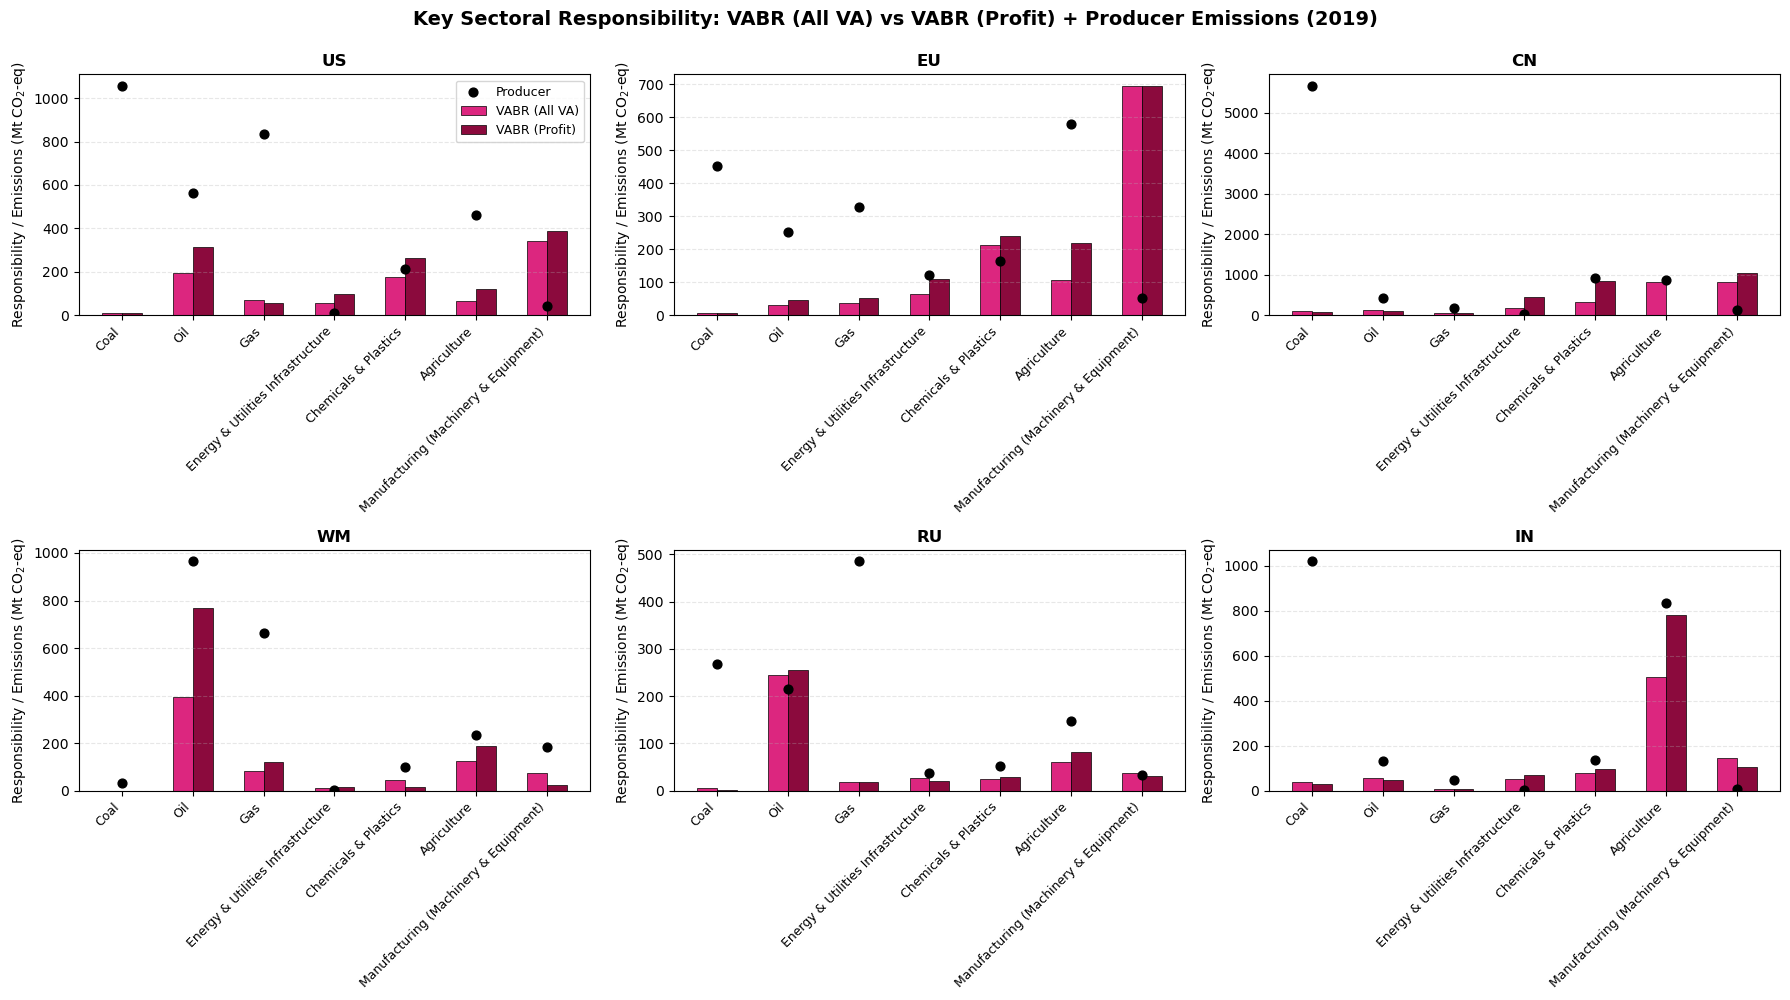


✓ Focused sectoral comparison with producer dots created

### PROFIT RATIOS FOR KEY SECTORS ###

US:
  Coal                          : 0.94x ↓ (12.1 → 11.3 Mt)
  Oil                           : 1.62x ↑ (192.8 → 312.3 Mt)
  Gas                           : 0.81x ↓ (71.9 → 58.1 Mt)
  Energy & Utilities Infrastructure: 1.74x ↑ (56.1 → 97.3 Mt)
  Chemicals & Plastics          : 1.49x ↑ (176.8 → 263.3 Mt)
  Agriculture                   : 1.80x ↑ (66.8 → 120.6 Mt)
  Manufacturing (Machinery & Equipment): 1.13x ↑ (340.7 → 386.2 Mt)

EU:
  Coal                          : 1.01x → (6.9 → 6.9 Mt)
  Oil                           : 1.42x ↑ (31.6 → 44.8 Mt)
  Gas                           : 1.45x ↑ (36.1 → 52.4 Mt)
  Energy & Utilities Infrastructure: 1.69x ↑ (65.7 → 111.1 Mt)
  Chemicals & Plastics          : 1.12x ↑ (214.2 → 240.8 Mt)
  Agriculture                   : 2.02x ↑ (107.9 → 218.3 Mt)
  Manufacturing (Machinery & Equipment): 1.00x → (695.0 → 693.5 Mt)

CN:
  Coal                        

In [ ]:
# ===================================================================
# SECTORAL ANALYSIS: VABR (All VA) vs VABR (Profit) BY COUNTRY
# WITH PRODUCER DOTS + EU AGGREGATED
# ===================================================================

print("\n" + "="*70)
print("SECTORAL COMPARISON: VABR (All VA) vs VABR (Profit) + Producer")
print("="*70)

# ----------------------------------------
# Countries to analyze (EU statt DE)
# ----------------------------------------
countries_to_analyze = ['US', 'EU', 'CN', 'WM', 'RU', 'IN']
print(f"Requested countries: {countries_to_analyze}")

# Available countries in VABR details (original regions)
available_countries = list(vabr_all_details.keys())
print(f"Available country keys in vabr_all_details (first 15): {available_countries[:15]}")

# ===================================================================
# Helper: aggregate sectors to categories (robust to index type)
# ===================================================================

def aggregate_sectors_to_categories(sector_series):
    """
    Aggregiert Sektor-Level Emissionen nach aggregierten Kategorien.
    Funktioniert sowohl für:
      - MultiIndex (region, sector)
      - einfacher Index (sector)
    """
    data = []
    
    for idx, value in sector_series.items():
        # idx can be ('DE', 'Production of electricity by coal') or just 'Production of electricity by coal'
        if isinstance(idx, tuple) and len(idx) >= 2:
            region, sector = idx[0], idx[1]
        else:
            sector = idx
        category = category_of(sector)
        data.append({
            'category': category,
            'emissions': value
        })
    
    df = pd.DataFrame(data)
    category_totals = df.groupby('category')['emissions'].sum()
    
    return category_totals

# ===================================================================
# Prepare producer emissions as Series with (region, sector) index
# ===================================================================

producer_series_sr = pd.Series(producer_emissions, index=ixi_data.x.index)

# ===================================================================
# Aggregate data for each country (including EU)
# ===================================================================

sectoral_comparison = {}
producer_sectoral = {}

for country in countries_to_analyze:
    print(f"\nProcessing {country}...")
    
    # ---------- VABR data ----------
    if country == 'EU':
        # Aggregate all EU member countries that exist in the details
        eu_members = [c for c in EU_COUNTRIES if c in vabr_all_details]
        if not eu_members:
            print("  ⚠ No EU member countries found in vabr_all_details – skipping EU.")
            continue
        
        # Concatenate all member Series and aggregate by sector name
        vabr_all_concat = pd.concat([vabr_all_details[c] for c in eu_members])
        vabr_profit_concat = pd.concat([vabr_profit_details[c] for c in eu_members])
        
        # For category aggregation we don't need region explicitly – aggregate_sectors_to_categories handles both index types
        vabr_all_sectors = vabr_all_concat
        vabr_profit_sectors = vabr_profit_concat
        
        # Producer emissions for EU: sum over all EU regions
        producer_eu = producer_series_sr[producer_series_sr.index.get_level_values(0).isin(EU_COUNTRIES)]
        producer_sectors = producer_eu
    else:
        # Normal country: just take its Series
        if country not in vabr_all_details:
            print(f"  ⚠ {country} not in vabr_all_details – skipping.")
            continue
        
        vabr_all_sectors = vabr_all_details[country]
        vabr_profit_sectors = vabr_profit_details[country]
        
        # Producer emissions for this country
        mask_country = producer_series_sr.index.get_level_values(0) == country
        producer_sectors = producer_series_sr[mask_country]
    
    # ---------- Aggregate to categories ----------
    vabr_all_cat = aggregate_sectors_to_categories(vabr_all_sectors)
    vabr_profit_cat = aggregate_sectors_to_categories(vabr_profit_sectors)
    producer_cat = aggregate_sectors_to_categories(producer_sectors)
    
    # Store all in Mt CO2-eq
    sectoral_comparison[country] = pd.DataFrame({
        'VABR (All VA)': vabr_all_cat / 1e6,
        'VABR (Profit)': vabr_profit_cat / 1e6,
    })
    producer_sectoral[country] = producer_cat / 1e6  # Mt
    
    print(f"  Categories found (VABR): {len(sectoral_comparison[country])}")
    print(f"  Category index: {sectoral_comparison[country].index.tolist()}")

# ===================================================================
# MULTI-PANEL PLOT: SPECIFIC KEY SECTORS + PRODUCER DOT
# ===================================================================

print("\n=== Creating focused sectoral comparison with producer dots ===")

focus_sectors = [
    'Coal',
    'Oil', 
    'Gas',
    "Energy & Utilities Infrastructure",
    'Chemicals & Plastics',
    'Agriculture',
    "Manufacturing (Machinery & Equipment)"
]

print(f"\nFocus sectors: {focus_sectors}")

# 6 countries -> 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Colors
color_all = '#dc267f'      # Pink/Magenta
color_profit = '#8b0a3d'   # Dark magenta
color_producer_dot = 'black'

for idx, country in enumerate(countries_to_analyze):
    ax = axes[idx]
    
    if country not in sectoral_comparison:
        ax.text(0.5, 0.5, f"{country}\nNo data", 
                ha='center', va='center', fontsize=11)
        ax.set_title(country, fontsize=12, fontweight='bold')
        ax.axis('off')
        continue
    
    country_data = sectoral_comparison[country]
    producer_data = producer_sectoral[country]
    
    # Sectors for this country that match focus list
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        ax.text(0.5, 0.5, f"{country}\nNo data for\nfocus sectors", 
                ha='center', va='center', fontsize=11)
        ax.set_title(country, fontsize=12, fontweight='bold')
        ax.axis('off')
        continue
    
    data = country_data.loc[available_focus]
    categories = data.index.tolist()
    x_pos = np.arange(len(categories))
    
    # Slightly narrower bars so dots are visible
    width = 0.28
    
    # Bars for VABR
    ax.bar(
        x_pos - width/2,
        data['VABR (All VA)'],
        width,
        label='VABR (All VA)',
        color=color_all,
        edgecolor='black',
        linewidth=0.5,
        zorder=1
    )
    ax.bar(
        x_pos + width/2,
        data['VABR (Profit)'],
        width,
        label='VABR (Profit)',
        color=color_profit,
        edgecolor='black',
        linewidth=0.5,
        zorder=1
    )
    
    # Producer dots (same categories, may be missing for some)
    producer_vals = [producer_data.get(cat, np.nan) for cat in categories]
    ax.scatter(
        x_pos,
        producer_vals,
        color=color_producer_dot,
        marker='o',
        s=40,
        zorder=5,
        label='Producer' if idx == 0 else None
    )
    
    # Formatting
    ax.set_title(country, fontsize=12, fontweight='bold')
    ax.set_ylabel('Responsibility / Emissions (Mt CO$_2$-eq)', fontsize=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Legend only in first subplot
    if idx == 0:
        ax.legend(fontsize=9, loc='upper right')

# Turn off any extra axes if fewer than 6 countries end up plotted
for j in range(len(countries_to_analyze), len(axes)):
    axes[j].axis('off')

fig.suptitle(
    f'Key Sectoral Responsibility: VABR (All VA) vs VABR (Profit) '
    f'+ Producer Emissions ({SINGLE_YEAR})',
    fontsize=14,
    fontweight='bold',
    y=0.995
)

plt.tight_layout()
plt.show()

print("\n✓ Focused sectoral comparison with producer dots created")

# ===================================================================
# SUMMARY: Profit Ratios for Focus Sectors
# ===================================================================

print("\n### PROFIT RATIOS FOR KEY SECTORS ###")

for country in countries_to_analyze:
    if country not in sectoral_comparison:
        continue
    
    print(f"\n{country}:")
    country_data = sectoral_comparison[country]
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        print("  No data for focus sectors")
        continue
    
    for sector in available_focus:
        all_va = country_data.loc[sector, 'VABR (All VA)']
        profit = country_data.loc[sector, 'VABR (Profit)']
        
        if all_va > 0:
            ratio = profit / all_va
            change = "↑" if ratio > 1.05 else ("↓" if ratio < 0.95 else "→")
            print(f"  {sector:30s}: {ratio:.2f}x {change} "
                  f"({all_va:.1f} → {profit:.1f} Mt)")
        else:
            print(f"  {sector:30s}: No emissions in All-VA")



SECTORAL COMPARISON: VABR (All VA) vs VABR (Profit) + Producer
Requested countries: ['US', 'EU', 'CN', 'WM', 'RU', 'IN']
Available country keys in vabr_all_details (first 15): ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE']

Processing US...
  Categories found (VABR): 14
  Category index: ['Agriculture', 'Chemicals & Plastics', 'Construction & Trade', 'Energy & Heat Infrastructure', 'Manufacturing (Food & Beverages)', 'Manufacturing (Machinery & Equipment)', 'Manufacturing (Textiles, Leather & Wood)', 'Metals', 'Non-metallic Minerals', 'Renewables', 'Services', 'Transport', 'Waste & Recycling', 'Fossil Fuels']

Processing EU...
  Categories found (VABR): 14
  Category index: ['Agriculture', 'Chemicals & Plastics', 'Construction & Trade', 'Energy & Heat Infrastructure', 'Manufacturing (Food & Beverages)', 'Manufacturing (Machinery & Equipment)', 'Manufacturing (Textiles, Leather & Wood)', 'Metals', 'Non-metallic Minerals', 'Renewables', 'Servi

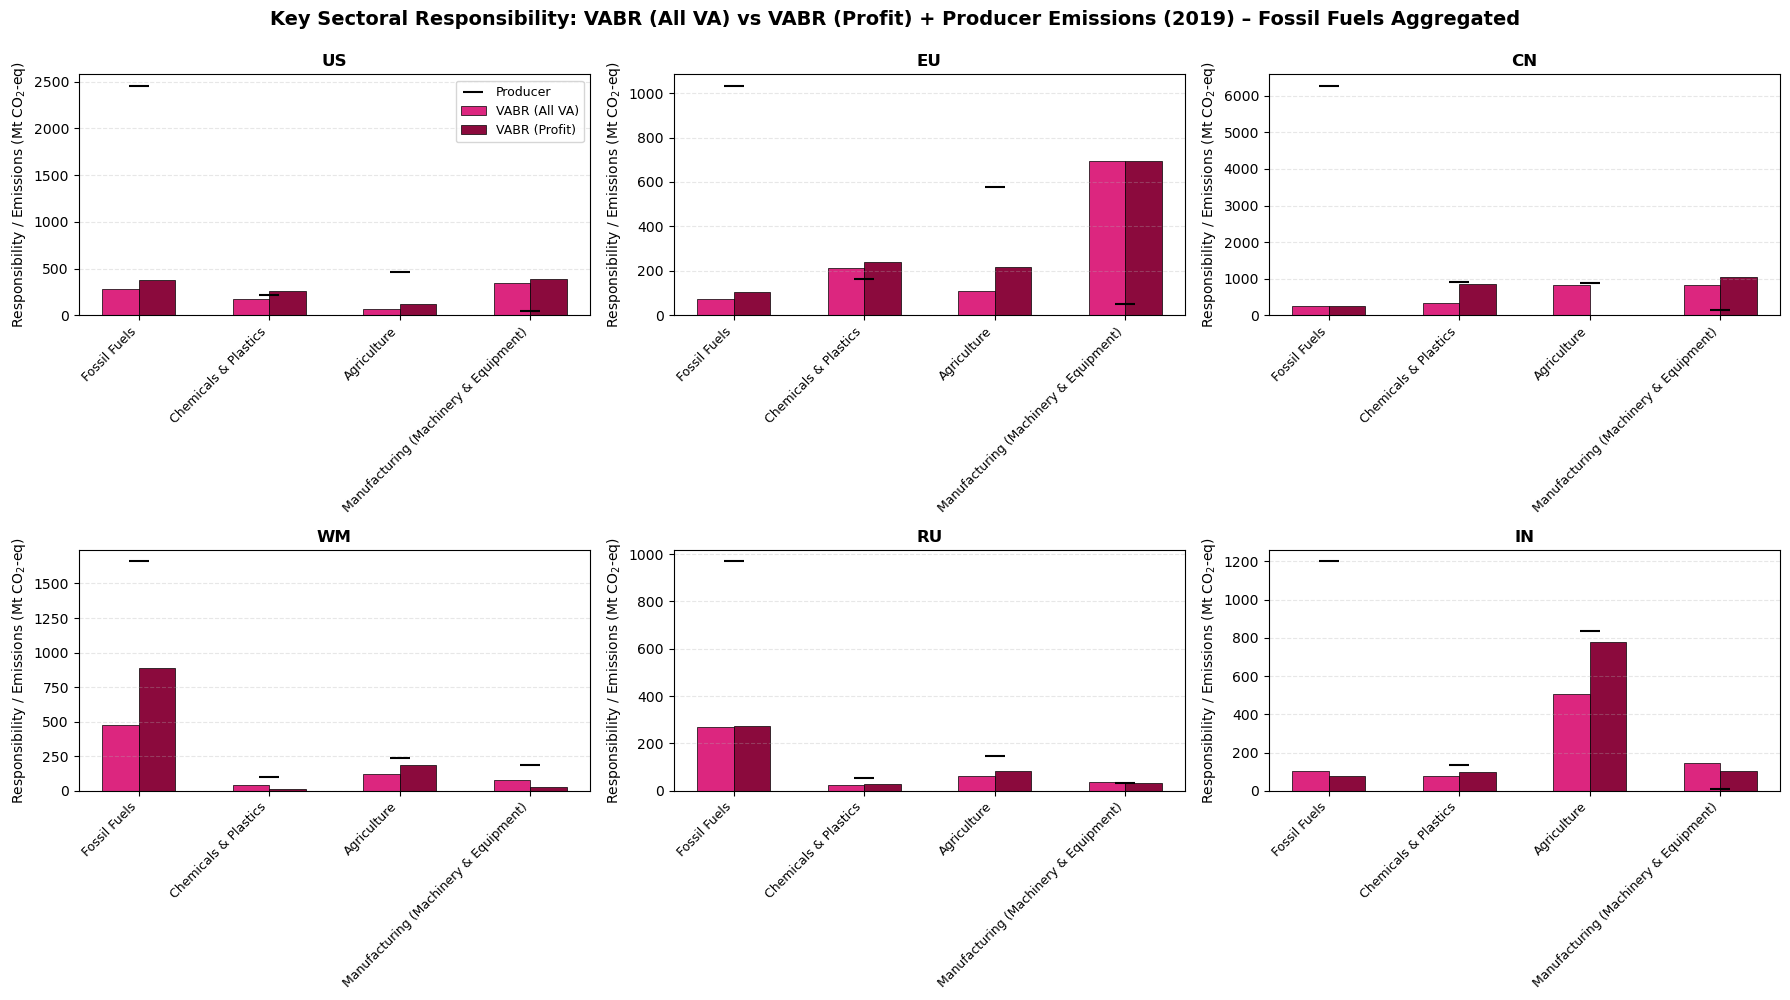


✓ Focused sectoral comparison with producer dots (Fossil Fuels aggregated) created

### PROFIT RATIOS FOR KEY SECTORS (Fossil Fuels aggregated) ###

US:
  Fossil Fuels                  : 1.38x ↑ (276.8 → 381.7 Mt)
  Chemicals & Plastics          : 1.49x ↑ (176.8 → 263.3 Mt)
  Agriculture                   : 1.80x ↑ (66.8 → 120.6 Mt)
  Manufacturing (Machinery & Equipment): 1.13x ↑ (340.7 → 386.2 Mt)

EU:
  Fossil Fuels                  : 1.40x ↑ (74.6 → 104.1 Mt)
  Chemicals & Plastics          : 1.12x ↑ (214.2 → 240.8 Mt)
  Agriculture                   : 2.02x ↑ (107.9 → 218.3 Mt)
  Manufacturing (Machinery & Equipment): 1.00x → (695.0 → 693.5 Mt)

CN:
  Fossil Fuels                  : 0.98x → (260.6 → 256.5 Mt)
  Chemicals & Plastics          : 2.51x ↑ (336.0 → 842.8 Mt)
  Agriculture                   : 0.00x ↓ (826.2 → 0.0 Mt)
  Manufacturing (Machinery & Equipment): 1.25x ↑ (829.9 → 1040.7 Mt)

WM:
  Fossil Fuels                  : 1.88x ↑ (473.9 → 889.2 Mt)
  Chemicals & Plasti

In [26]:
# ===================================================================
# SECTORAL ANALYSIS: VABR (All VA) vs VABR (Profit) BY COUNTRY
# WITH PRODUCER DOTS + EU AGGREGATED, FOSSIL FUELS AGGREGATED
# ===================================================================

print("\n" + "="*70)
print("SECTORAL COMPARISON: VABR (All VA) vs VABR (Profit) + Producer")
print("="*70)

# ----------------------------------------
# Countries to analyze (EU statt DE)
# ----------------------------------------
countries_to_analyze = ['US', 'EU', 'CN', 'WM', 'RU', 'IN']
print(f"Requested countries: {countries_to_analyze}")

# Available countries in VABR details (original regions)
available_countries = list(vabr_all_details.keys())
print(f"Available country keys in vabr_all_details (first 15): {available_countries[:15]}")

# ===================================================================
# Helper: aggregate sectors to categories (robust to index type)
# ===================================================================

def aggregate_sectors_to_categories(sector_series):
    """
    Aggregiert Sektor-Level Emissionen nach aggregierten Kategorien.
    Funktioniert sowohl für:
      - MultiIndex (region, sector)
      - einfacher Index (sector)
    """
    data = []
    
    for idx, value in sector_series.items():
        # idx can be ('DE', 'Production of electricity by coal') or just 'Production of electricity by coal'
        if isinstance(idx, tuple) and len(idx) >= 2:
            region, sector = idx[0], idx[1]
        else:
            sector = idx
        category = category_of(sector)
        data.append({
            'category': category,
            'emissions': value
        })
    
    df = pd.DataFrame(data)
    category_totals = df.groupby('category')['emissions'].sum()
    
    return category_totals

def aggregate_fossil_categories(category_series):
    """
    Fasst die Kategorien 'Coal', 'Oil' und 'Gas' zu einer Kategorie
    'Fossil Fuels' zusammen. Alle anderen Kategorien bleiben unverändert.
    """
    series = category_series.copy()
    
    fossil_total = 0.0
    for cat in ['Coal', 'Oil', 'Gas']:
        if cat in series.index:
            fossil_total += series.loc[cat]
            series = series.drop(cat)
    
    if fossil_total != 0:
        series.loc['Fossil Fuels'] = fossil_total
    
    return series

# ===================================================================
# Prepare producer emissions as Series with (region, sector) index
# ===================================================================

producer_series_sr = pd.Series(producer_emissions, index=ixi_data.x.index)

# ===================================================================
# Aggregate data for each country (including EU)
# ===================================================================

sectoral_comparison = {}
producer_sectoral = {}

for country in countries_to_analyze:
    print(f"\nProcessing {country}...")
    
    # ---------- VABR data ----------
    if country == 'EU':
        # Aggregate all EU member countries that exist in the details
        eu_members = [c for c in EU_COUNTRIES if c in vabr_all_details]
        if not eu_members:
            print("  ⚠ No EU member countries found in vabr_all_details – skipping EU.")
            continue
        
        # Concatenate all member Series
        vabr_all_concat = pd.concat([vabr_all_details[c] for c in eu_members])
        vabr_profit_concat = pd.concat([vabr_profit_details[c] for c in eu_members])
        
        vabr_all_sectors = vabr_all_concat
        vabr_profit_sectors = vabr_profit_concat
        
        # Producer emissions for EU: sum over all EU regions
        producer_eu = producer_series_sr[producer_series_sr.index.get_level_values(0).isin(EU_COUNTRIES)]
        producer_sectors = producer_eu
    else:
        # Normal country: just take its Series
        if country not in vabr_all_details:
            print(f"  ⚠ {country} not in vabr_all_details – skipping.")
            continue
        
        vabr_all_sectors = vabr_all_details[country]
        vabr_profit_sectors = vabr_profit_details[country]
        
        # Producer emissions for this country
        mask_country = producer_series_sr.index.get_level_values(0) == country
        producer_sectors = producer_series_sr[mask_country]
    
    # ---------- Aggregate to categories ----------
    vabr_all_cat = aggregate_sectors_to_categories(vabr_all_sectors)
    vabr_profit_cat = aggregate_sectors_to_categories(vabr_profit_sectors)
    producer_cat = aggregate_sectors_to_categories(producer_sectors)
    
    # ---------- Aggregate fossil categories (Coal + Oil + Gas) ----------
    vabr_all_cat = aggregate_fossil_categories(vabr_all_cat)
    vabr_profit_cat = aggregate_fossil_categories(vabr_profit_cat)
    producer_cat = aggregate_fossil_categories(producer_cat)
    
    # Store all in Mt CO2-eq
    sectoral_comparison[country] = pd.DataFrame({
        'VABR (All VA)': vabr_all_cat / 1e6,
        'VABR (Profit)': vabr_profit_cat / 1e6,
    })
    producer_sectoral[country] = producer_cat / 1e6  # Mt
    
    print(f"  Categories found (VABR): {len(sectoral_comparison[country])}")
    print(f"  Category index: {sectoral_comparison[country].index.tolist()}")

# ===================================================================
# MULTI-PANEL PLOT: FOSSIL FUELS AGGREGATED + PRODUCER DOT
# ===================================================================

print("\n=== Creating focused sectoral comparison with producer dots (Fossil Fuels aggregated) ===")

focus_sectors = [
    'Fossil Fuels',
    "Energy & Utilities Infrastructure",
    'Chemicals & Plastics',
    'Agriculture',
    "Manufacturing (Machinery & Equipment)",
    #"Services"

]

print(f"\nFocus sectors: {focus_sectors}")

# 6 countries -> 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Colors
color_all = '#dc267f'      # Pink/Magenta (VABR All VA)
color_profit = '#8b0a3d'   # Dark magenta (VABR Profit)
color_producer_dot = 'black'

for idx, country in enumerate(countries_to_analyze):
    ax = axes[idx]
    
    if country not in sectoral_comparison:
        ax.text(0.5, 0.5, f"{country}\nNo data", 
                ha='center', va='center', fontsize=11)
        ax.set_title(country, fontsize=12, fontweight='bold')
        ax.axis('off')
        continue
    
    country_data = sectoral_comparison[country]
    producer_data = producer_sectoral[country]
    
    # Sectors for this country that match focus list
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        ax.text(0.5, 0.5, f"{country}\nNo data for\nfocus sectors", 
                ha='center', va='center', fontsize=11)
        ax.set_title(country, fontsize=12, fontweight='bold')
        ax.axis('off')
        continue
    
    data = country_data.loc[available_focus]
    categories = data.index.tolist()
    x_pos = np.arange(len(categories))
    
    # Slightly narrower bars so dots are visible
    width = 0.28
    
    # Bars for VABR
    ax.bar(
        x_pos - width/2,
        data['VABR (All VA)'],
        width,
        label='VABR (All VA)',
        color=color_all,
        edgecolor='black',
        linewidth=0.5,
        zorder=1
    )
    ax.bar(
        x_pos + width/2,
        data['VABR (Profit)'],
        width,
        label='VABR (Profit)',
        color=color_profit,
        edgecolor='black',
        linewidth=0.5,
        zorder=1
    )
    

# Producer dots (same categories, may be missing for some)
    producer_vals = [producer_data.get(cat, np.nan) for cat in categories]
    ax.scatter(
        x_pos,
        producer_vals,
        color=color_producer_dot,
        marker='_',
        s=200,
        zorder=5,
        label='Producer' if idx == 0 else None
    )
    
    # Formatting
    ax.set_title(country, fontsize=12, fontweight='bold')
    ax.set_ylabel('Responsibility / Emissions (Mt CO$_2$-eq)', fontsize=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Legend only in first subplot
    if idx == 0:
        ax.legend(fontsize=9, loc='upper right')

# Turn off any extra axes if fewer than 6 countries end up plotted
for j in range(len(countries_to_analyze), len(axes)):
    axes[j].axis('off')

fig.suptitle(
    f'Key Sectoral Responsibility: VABR (All VA) vs VABR (Profit) '
    f'+ Producer Emissions ({SINGLE_YEAR}) – Fossil Fuels Aggregated',
    fontsize=14,
    fontweight='bold',
    y=0.995
)

plt.tight_layout()
plt.show()

print("\n✓ Focused sectoral comparison with producer dots (Fossil Fuels aggregated) created")

# ===================================================================
# SUMMARY: Profit Ratios for Focus Sectors
# ===================================================================

print("\n### PROFIT RATIOS FOR KEY SECTORS (Fossil Fuels aggregated) ###")

for country in countries_to_analyze:
    if country not in sectoral_comparison:
        continue
    
    print(f"\n{country}:")
    country_data = sectoral_comparison[country]
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        print("  No data for focus sectors")
        continue
    
    for sector in available_focus:
        all_va = country_data.loc[sector, 'VABR (All VA)']
        profit = country_data.loc[sector, 'VABR (Profit)']
        
        if all_va > 0:
            ratio = profit / all_va
            change = "↑" if ratio > 1.05 else ("↓" if ratio < 0.95 else "→")
            print(f"  {sector:30s}: {ratio:.2f}x {change} "
                  f"({all_va:.1f} → {profit:.1f} Mt)")
        else:
            print(f"  {sector:30s}: No emissions in All-VA")



SECTORAL COMPARISON: VABR (All VA) vs VABR (Profit) + Producer
Requested countries: ['US', 'EU', 'CN', 'WM', 'RU', 'IN']
Available country keys in vabr_all_details (first 15): ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE']

Processing US...
  Categories found (VABR): 14
  Category index: ['Agriculture', 'Chemicals & Plastics', 'Construction & Trade', 'Energy & Heat Infrastructure', 'Manufacturing (Food & Beverages)', 'Manufacturing (Machinery & Equipment)', 'Manufacturing (Textiles, Leather & Wood)', 'Metals', 'Non-metallic Minerals', 'Renewables', 'Services', 'Transport', 'Waste & Recycling', 'Fossil & Power']

Processing EU...
  Categories found (VABR): 14
  Category index: ['Agriculture', 'Chemicals & Plastics', 'Construction & Trade', 'Energy & Heat Infrastructure', 'Manufacturing (Food & Beverages)', 'Manufacturing (Machinery & Equipment)', 'Manufacturing (Textiles, Leather & Wood)', 'Metals', 'Non-metallic Minerals', 'Renewables', 'Ser

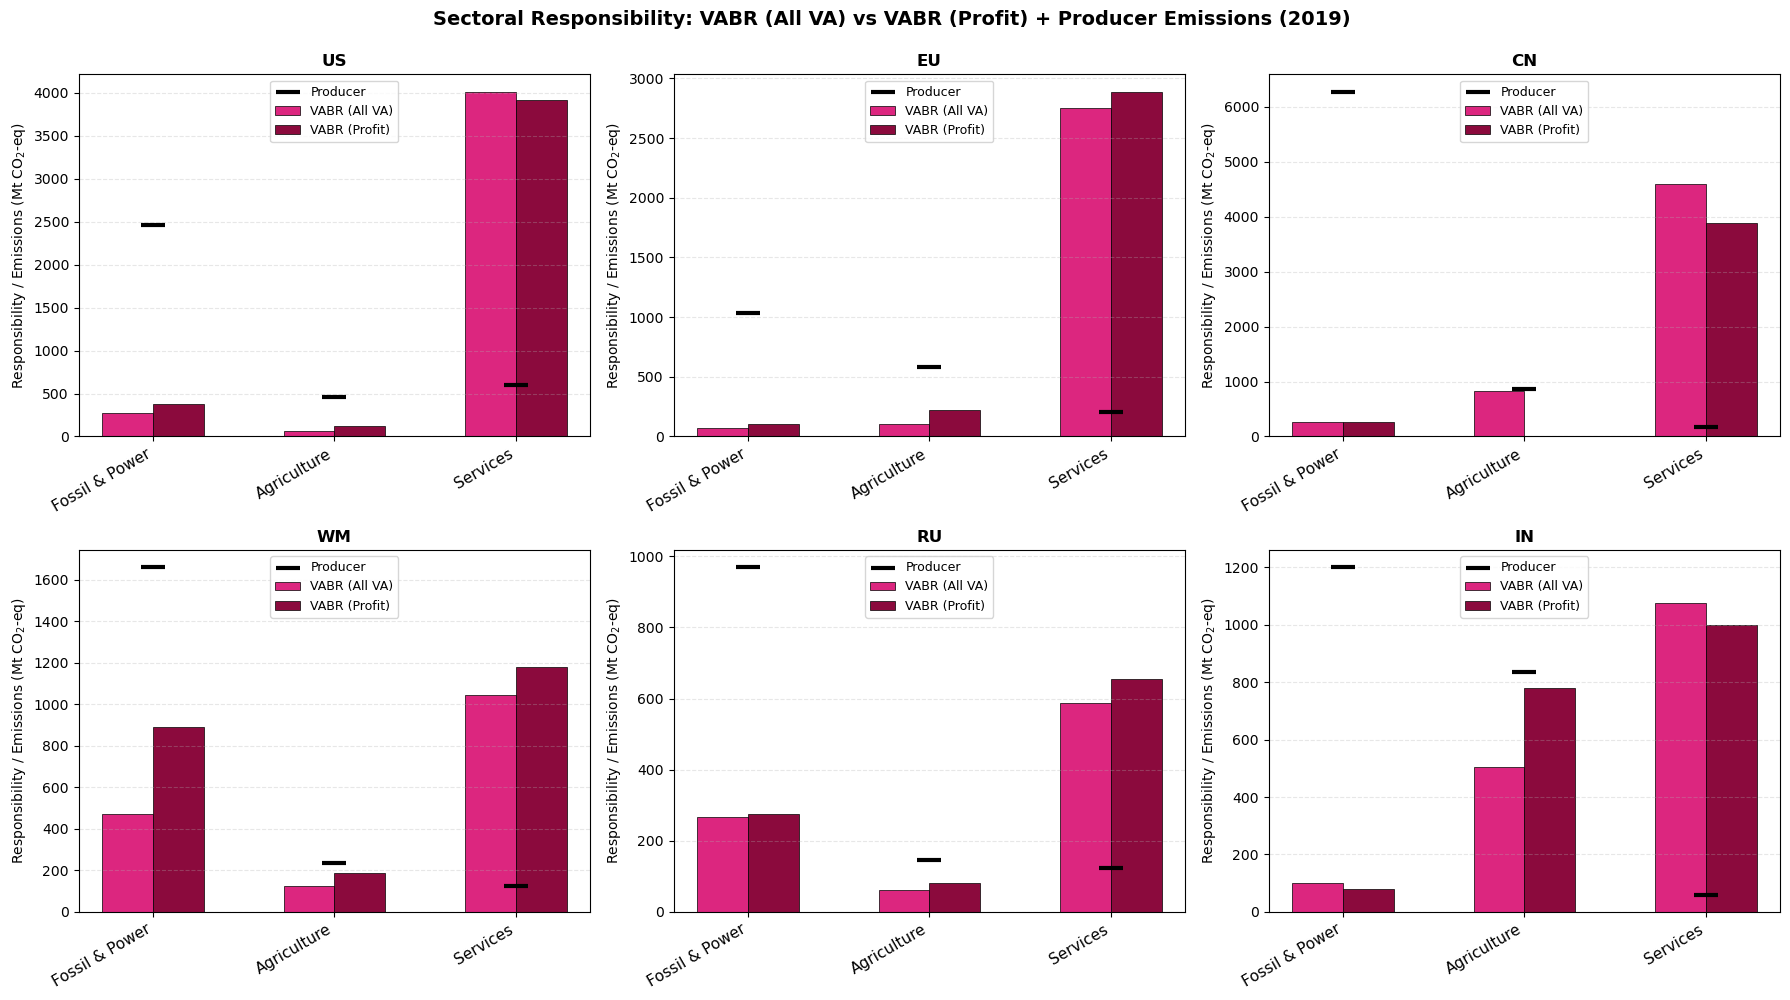


✓ Focused sectoral comparison with producer dots (Fossil & Power aggregated) created

### PROFIT RATIOS FOR KEY SECTORS (Fossil & Power aggregated) ###

US:
  Fossil & Power                : 1.38x ↑ (276.8 → 381.7 Mt)
  Agriculture                   : 1.80x ↑ (66.8 → 120.6 Mt)
  Services                      : 0.98x → (4012.9 → 3917.3 Mt)

EU:
  Fossil & Power                : 1.40x ↑ (74.6 → 104.1 Mt)
  Agriculture                   : 2.02x ↑ (107.9 → 218.3 Mt)
  Services                      : 1.05x ↑ (2750.0 → 2889.3 Mt)

CN:
  Fossil & Power                : 0.98x → (260.6 → 256.5 Mt)
  Agriculture                   : 0.00x ↓ (826.2 → 0.0 Mt)
  Services                      : 0.84x ↓ (4596.0 → 3883.2 Mt)

WM:
  Fossil & Power                : 1.88x ↑ (473.9 → 889.2 Mt)
  Agriculture                   : 1.51x ↑ (124.6 → 188.4 Mt)
  Services                      : 1.13x ↑ (1044.8 → 1179.2 Mt)

RU:
  Fossil & Power                : 1.02x → (268.2 → 274.1 Mt)
  Agriculture            

In [33]:
# ===================================================================
# SECTORAL ANALYSIS: VABR (All VA) vs VABR (Profit) BY COUNTRY
# WITH PRODUCER DOTS + EU AGGREGATED, FOSSIL & POWER AGGREGATED
# ===================================================================

print("\n" + "="*70)
print("SECTORAL COMPARISON: VABR (All VA) vs VABR (Profit) + Producer")
print("="*70)

# ----------------------------------------
# Countries to analyze (EU statt DE)
# ----------------------------------------
countries_to_analyze = ['US', 'EU', 'CN', 'WM', 'RU', 'IN']
print(f"Requested countries: {countries_to_analyze}")

# Available countries in VABR details (original regions)
available_countries = list(vabr_all_details.keys())
print(f"Available country keys in vabr_all_details (first 15): {available_countries[:15]}")

# ===================================================================
# Helper: aggregate sectors to categories (robust to index type)
# ===================================================================

def aggregate_sectors_to_categories(sector_series):
    """
    Aggregiert Sektor-Level Emissionen nach aggregierten Kategorien.
    Funktioniert sowohl für:
      - MultiIndex (region, sector)
      - einfacher Index (sector)
    """
    data = []
    
    for idx, value in sector_series.items():
        # idx can be ('DE', 'Production of electricity by coal') or just 'Production of electricity by coal'
        if isinstance(idx, tuple) and len(idx) >= 2:
            region, sector = idx[0], idx[1]
        else:
            sector = idx
        category = category_of(sector)
        data.append({
            'category': category,
            'emissions': value
        })
    
    df = pd.DataFrame(data)
    category_totals = df.groupby('category')['emissions'].sum()
    
    return category_totals

def aggregate_fossil_power_categories(category_series):
    """
    Fasst die Kategorien 'Coal', 'Oil', 'Gas' und
    'Energy & Utilities Infrastructure' zu einer Kategorie
    'Fossil & Power' zusammen. Alle anderen Kategorien bleiben unverändert.
    """
    series = category_series.copy()
    
    fossil_power_total = 0.0
    for cat in ['Coal', 'Oil', 'Gas', 'Energy & Utilities Infrastructure']:
        if cat in series.index:
            fossil_power_total += series.loc[cat]
            series = series.drop(cat)
    
    if fossil_power_total != 0:
        series.loc['Fossil & Power'] = fossil_power_total
    
    return series

# ===================================================================
# Prepare producer emissions as Series with (region, sector) index
# ===================================================================

producer_series_sr = pd.Series(producer_emissions, index=ixi_data.x.index)

# ===================================================================
# Aggregate data for each country (including EU)
# ===================================================================

sectoral_comparison = {}
producer_sectoral = {}

for country in countries_to_analyze:
    print(f"\nProcessing {country}...")
    
    # ---------- VABR data ----------
    if country == 'EU':
        # Aggregate all EU member countries that exist in the details
        eu_members = [c for c in EU_COUNTRIES if c in vabr_all_details]
        if not eu_members:
            print("  ⚠ No EU member countries found in vabr_all_details – skipping EU.")
            continue
        
        # Concatenate all member Series
        vabr_all_concat = pd.concat([vabr_all_details[c] for c in eu_members])
        vabr_profit_concat = pd.concat([vabr_profit_details[c] for c in eu_members])
        
        vabr_all_sectors = vabr_all_concat
        vabr_profit_sectors = vabr_profit_concat
        
        # Producer emissions for EU: sum over all EU regions
        producer_eu = producer_series_sr[producer_series_sr.index.get_level_values(0).isin(EU_COUNTRIES)]
        producer_sectors = producer_eu
    else:
        # Normal country: just take its Series
        if country not in vabr_all_details:
            print(f"  ⚠ {country} not in vabr_all_details – skipping.")
            continue
        
        vabr_all_sectors = vabr_all_details[country]
        vabr_profit_sectors = vabr_profit_details[country]
        
        # Producer emissions for this country
        mask_country = producer_series_sr.index.get_level_values(0) == country
        producer_sectors = producer_series_sr[mask_country]
    
    # ---------- Aggregate to categories ----------
    vabr_all_cat = aggregate_sectors_to_categories(vabr_all_sectors)
    vabr_profit_cat = aggregate_sectors_to_categories(vabr_profit_sectors)
    producer_cat = aggregate_sectors_to_categories(producer_sectors)
    
    # ---------- Aggregate Fossil + Power ----------
    vabr_all_cat = aggregate_fossil_power_categories(vabr_all_cat)
    vabr_profit_cat = aggregate_fossil_power_categories(vabr_profit_cat)
    producer_cat = aggregate_fossil_power_categories(producer_cat)
    
    # Store all in Mt CO2-eq
    sectoral_comparison[country] = pd.DataFrame({
        'VABR (All VA)': vabr_all_cat / 1e6,
        'VABR (Profit)': vabr_profit_cat / 1e6,
    })
    producer_sectoral[country] = producer_cat / 1e6  # Mt
    
    print(f"  Categories found (VABR): {len(sectoral_comparison[country])}")
    print(f"  Category index: {sectoral_comparison[country].index.tolist()}")

# ===================================================================
# MULTI-PANEL PLOT: FOSSIL & POWER AGGREGATED + PRODUCER DOT
# ===================================================================

print("\n=== Creating focused sectoral comparison with producer dots (Fossil & Power aggregated) ===")

focus_sectors = [
    'Fossil & Power',
    #'Chemicals & Plastics',
    'Agriculture',
    #"Transport"
    #"Manufacturing (Machinery & Equipment)",
    #'Construction & Trade',
    'Services'
]

print(f"\nFocus sectors: {focus_sectors}")

# 6 countries -> 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Colors
color_all = '#dc267f'      # Pink/Magenta (VABR All VA)
color_profit = '#8b0a3d'   # Dark magenta (VABR Profit)
color_producer_dot = 'black'

for idx, country in enumerate(countries_to_analyze):
    ax = axes[idx]
    
    if country not in sectoral_comparison:
        ax.text(0.5, 0.5, f"{country}\nNo data", 
                ha='center', va='center', fontsize=11)
        ax.set_title(country, fontsize=12, fontweight='bold')
        ax.axis('off')
        continue
    
    country_data = sectoral_comparison[country]
    producer_data = producer_sectoral[country]
    
    # Sectors for this country that match focus list
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        ax.text(0.5, 0.5, f"{country}\nNo data for\nfocus sectors", 
                ha='center', va='center', fontsize=11)
        ax.set_title(country, fontsize=12, fontweight='bold')
        ax.axis('off')
        continue
    
    data = country_data.loc[available_focus]
    categories = data.index.tolist()
    x_pos = np.arange(len(categories))
    
    # Slightly narrower bars so dots are visible
    width = 0.28
    
    # Bars for VABR
    ax.bar(
        x_pos - width/2,
        data['VABR (All VA)'],
        width,
        label='VABR (All VA)',
        color=color_all,
        edgecolor='black',
        linewidth=0.5,
        zorder=1
    )
    ax.bar(
        x_pos + width/2,
        data['VABR (Profit)'],
        width,
        label='VABR (Profit)',
        color=color_profit,
        edgecolor='black',
        linewidth=0.5,
        zorder=1
    )
    
    # Producer dots (same categories, may be missing for some)
    producer_vals = [producer_data.get(cat, np.nan) for cat in categories]
    ax.scatter(
        x_pos,
        producer_vals,
        color=color_producer_dot,
        marker='_',
        s=300,
        linewidths=3, 
        zorder=5,
        label='Producer'
    )
    
    # Formatting
    ax.set_title(country, fontsize=12, fontweight='bold')
    ax.set_ylabel('Responsibility / Emissions (Mt CO$_2$-eq)', fontsize=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=30, ha='right', fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Legend in jedem Subplot oben links
    ax.legend(fontsize=9, loc='upper center')

# Turn off any extra axes if fewer than 6 countries end up plotted
for j in range(len(countries_to_analyze), len(axes)):
    axes[j].axis('off')

fig.suptitle(
    f'Sectoral Responsibility: VABR (All VA) vs VABR (Profit) '
    f'+ Producer Emissions ({SINGLE_YEAR}) ',
    fontsize=14,
    fontweight='bold',
    y=0.995
)

plt.tight_layout()
plt.show()

print("\n✓ Focused sectoral comparison with producer dots (Fossil & Power aggregated) created")

# ===================================================================
# SUMMARY: Profit Ratios for Focus Sectors
# ===================================================================

print("\n### PROFIT RATIOS FOR KEY SECTORS (Fossil & Power aggregated) ###")

for country in countries_to_analyze:
    if country not in sectoral_comparison:
        continue
    
    print(f"\n{country}:")
    country_data = sectoral_comparison[country]
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        print("  No data for focus sectors")
        continue
    
    for sector in available_focus:
        all_va = country_data.loc[sector, 'VABR (All VA)']
        profit = country_data.loc[sector, 'VABR (Profit)']
        
        if all_va > 0:
            ratio = profit / all_va
            change = "↑" if ratio > 1.05 else ("↓" if ratio < 0.95 else "→")
            print(f"  {sector:30s}: {ratio:.2f}x {change} "
                  f"({all_va:.1f} → {profit:.1f} Mt)")
        else:
            print(f"  {sector:30s}: No emissions in All-VA")


In [49]:
# ===================================================================
# DIAGNOSTIC: Why does China have (almost) no agriculture responsibility
# under profit-only VABR?
# ===================================================================

country = 'CN'

print(f"\n=== DIAGNOSTIC: {country} – Agriculture under profit-only VABR ===")

idx = ixi_data.x.index
regions = idx.get_level_values(0)
sectors = idx.get_level_values(1)

# 1) Define agriculture sectors (from your classification)
agri_sectors = sector_classification['Agriculture']

# Mask: CN + agriculture sectors
mask_cn_agri = (regions == country) & (sectors.isin(agri_sectors))
cn_agri_idx = idx[mask_cn_agri]

if mask_cn_agri.sum() == 0:
    print(f"⚠ No agriculture sectors found for {country} in EXIOBASE index.")
else:
    # 2) Build Series for output, emissions and profit VA
    output_all = ixi_data.x.values.flatten()
    output_series = pd.Series(output_all, index=idx, name="output")

    producer_series = pd.Series(
        producer_emissions,
        index=idx,
        name="producer_emissions_t"
    )

    # Profit VA per sector-region (same as in PCPR / profit-only VABR)
    VA_profit_all = ixi_data.factor_inputs.F.loc[PROFIT_COMPONENTS].sum(axis=0).values
    VA_profit_series = pd.Series(VA_profit_all, index=idx, name="VA_profit")

    # Profit-only VA coefficient that you use in calculate_vabr (cleaned)
    v_clean_profit_series = pd.Series(v_clean_profit, index=idx, name="v_clean_profit")

    # VABR (Profit) sector-level allocations for China
    vabr_profit_cn = vabr_profit_details[country]  # index: (region, sector)

    # 3) Assemble diagnostic DataFrame for CN agriculture
    df_cn_agri = pd.DataFrame(index=cn_agri_idx)
    df_cn_agri['output'] = output_series.loc[cn_agri_idx]
    df_cn_agri['producer_emissions_t'] = producer_series.loc[cn_agri_idx]
    df_cn_agri['VA_profit'] = VA_profit_series.loc[cn_agri_idx]
    df_cn_agri['v_clean_profit'] = v_clean_profit_series.loc[cn_agri_idx]

    # Emission intensity per M€ output
    df_cn_agri['intensity_t_per_MEUR'] = (
        df_cn_agri['producer_emissions_t'] /
        df_cn_agri['output'].replace(0, np.nan)
    )

    # VABR (Profit) allocation to these sectors (may be all zeros)
    df_cn_agri['VABR_profit_alloc_t'] = (
        vabr_profit_cn.reindex(cn_agri_idx).fillna(0)
    )

    # 4) Shares of total Chinese profit VA and total Chinese VABR (Profit)
    mask_cn_all = (regions == country)
    VA_profit_cn_total = VA_profit_series[mask_cn_all].sum()
    vabr_profit_cn_total = vabr_profit_cn.sum()

    df_cn_agri['share_of_CN_profit_VA'] = (
        df_cn_agri['VA_profit'] / VA_profit_cn_total
        if VA_profit_cn_total > 0 else np.nan
    )
    df_cn_agri['share_of_CN_VABR_profit'] = (
        df_cn_agri['VABR_profit_alloc_t'] / vabr_profit_cn_total
        if vabr_profit_cn_total > 0 else np.nan
    )

    # 5) Print summary
    print(f"\nNumber of CN agriculture sectors: {len(df_cn_agri)}")
    print(f"Total CN profit VA (all sectors): {VA_profit_cn_total/1e9:.2f} B€")
    print(f"Total CN VABR (Profit):           {vabr_profit_cn_total/1e9:.2f} Gt")

    print("\nCN agriculture – key indicators:")
    display_cols = [
        'output',
        'producer_emissions_t',
        'VA_profit',
        'v_clean_profit',
        'intensity_t_per_MEUR',
        'VABR_profit_alloc_t',
        'share_of_CN_profit_VA',
        'share_of_CN_VABR_profit'
    ]
    print(df_cn_agri[display_cols].sort_values('producer_emissions_t', ascending=False))

    # 6) Aggregated totals for CN agriculture
    total_agri_emissions = df_cn_agri['producer_emissions_t'].sum()
    total_agri_profit_VA = df_cn_agri['VA_profit'].sum()
    total_agri_vabr_profit = df_cn_agri['VABR_profit_alloc_t'].sum()

    print("\n--- Aggregated CN agriculture ---")
    print(f"Total agri emissions:          {total_agri_emissions/1e6:.2f} Mt")
    print(f"Total agri profit VA:          {total_agri_profit_VA/1e9:.4f} B€")
    print(f"Share of CN profit VA:         {total_agri_profit_VA / VA_profit_cn_total * 100 if VA_profit_cn_total > 0 else np.nan:.4f} %")
    print(f"Total VABR (Profit) to agri:   {total_agri_vabr_profit/1e6:.4f} Mt")
    print(f"Share of CN VABR (Profit):     {total_agri_vabr_profit / vabr_profit_cn_total * 100 if vabr_profit_cn_total > 0 else np.nan:.4f} %")



=== DIAGNOSTIC: CN – Agriculture under profit-only VABR ===

Number of CN agriculture sectors: 17
Total CN profit VA (all sectors): 0.00 B€
Total CN VABR (Profit):           11.04 Gt

CN agriculture – key indicators:
                                                             output  \
region sector                                                         
CN     Cultivation of paddy rice                          169230.37   
       Cultivation of vegetables, fruit, nuts             599515.14   
       Cattle farming                                      74584.82   
       Cultivation of cereal grains nec                   150957.05   
       Pigs farming                                        82600.57   
       Cultivation of wheat                                92315.61   
       Raw milk                                            48769.02   
       Cultivation of oil seeds                           124905.20   
       Poultry farming                                    149629.36   
 

In [50]:
# Inspect factor inputs for one agriculture sector, e.g. CN "Cattle farming"
sector_example = ('CN', 'Cattle farming')

print("\nFactor input breakdown for", sector_example, ":\n")
print(ixi_data.factor_inputs.F.loc[
    ALL_VALUE_ADDED_COMPONENTS,  # all VA components
    :
].loc[:, sector_example])



Factor input breakdown for ('CN', 'Cattle farming') :

stressor
Taxes less subsidies on products purchased: Total                                                   0.00
Other net taxes on production                                                                   62194.16
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled          0.00
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled       0.00
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled         0.00
Operating surplus: Consumption of fixed capital                                                     0.00
Operating surplus: Rents on land                                                                    0.00
Operating surplus: Royalties on resources                                                           0.00
Operating surplus: Remaining net operating surplus                                             

In [30]:
# ===================================================================
# SECTORS WITH HIGHEST PROFIT (OPERATING SURPLUS) - CORRECT UNITS!
# ===================================================================

print("\n=== SECTORS WITH HIGHEST PROFIT COMPONENT ===")
print("(EXIOBASE values are in million €)")

# Get profit components
profit_data = ixi_data.factor_inputs.F.loc[PROFIT_COMPONENTS]

# Sum all profit components per sector
total_profit_by_sector = profit_data.sum(axis=0)

# Handle negative profits
total_profit_positive = total_profit_by_sector.copy()
n_negative = (total_profit_positive < 0).sum()
total_profit_positive[total_profit_positive < 0] = 0

print(f"\nRemoved {n_negative} sectors with negative operating surplus")

# Values are ALREADY in million €, so:
# million € / 1000 = billion € (Milliarden)
total_profit_billions = total_profit_positive / 1e3

# Sort descending
profit_sorted = total_profit_billions.sort_values(ascending=False)

# Show top 30
print("\nTop 30 sectors by total operating surplus:")
print("="*90)
print(f"{'Rank':<5}{'Region':<6}{'Sector':<55}{'Profit (bn €)':<15}{'Category'}")
print("="*90)

for i, (sector, profit) in enumerate(profit_sorted.head(30).items(), 1):
    region, sector_name = sector
    category = category_of(sector_name)
    print(f"{i:<5}{region:<6}{sector_name[:54]:<55}{profit:>10.1f} bn €    {category}")

# Total
total_global = total_profit_billions.sum()
print("\n" + "="*90)
print(f"GLOBAL TOTAL operating surplus (all sectors): {total_global:,.0f} billion € "
      f"(~{total_global*1.1:,.0f} billion USD)")

# Aggregate by category
print("\n\nOperating Surplus by CATEGORY:")
print("="*90)

profit_by_category = {}
for (region, sector_name), profit in total_profit_billions.items():
    category = category_of(sector_name)
    if category not in profit_by_category:
        profit_by_category[category] = 0
    profit_by_category[category] += profit

profit_category_sorted = pd.Series(profit_by_category).sort_values(ascending=False)

for category, profit in profit_category_sorted.items():
    pct = (profit / total_global) * 100
    print(f"{category:<35s}: {profit:>10.1f} bn € ({pct:5.1f}%)")

# FOSSIL FUELS specifically
print("\n\nFOSSIL FUEL SECTORS (Top 15):")
print("="*90)

fossil_sectors_profit = []
for (region, sector_name), profit in total_profit_billions.items():
    category = category_of(sector_name)
    if category in ['Coal', 'Oil', 'Gas']:
        fossil_sectors_profit.append({
            'region': region,
            'sector': sector_name,
            'category': category,
            'profit': profit
        })

fossil_df = pd.DataFrame(fossil_sectors_profit).sort_values('profit', ascending=False)

total_fossil = fossil_df['profit'].sum()
print(f"Total Fossil Fuel Operating Surplus: {total_fossil:.1f} bn € "
      f"({total_fossil/total_global*100:.1f}% of global)")
print()

for i, (idx, row) in enumerate(fossil_df.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['region']:4s} | {row['sector'][:50]:50s} | "
          f"{row['profit']:8.1f} bn € | {row['category']}")

# Compare to Egli
print("\n\nCOMPARISON TO EGLI ET AL. (2024):")
print("="*90)
print(f"EXIOBASE 2019 Fossil Fuel Operating Surplus: ~{total_fossil:.0f} billion €")
print(f"Egli 2022 O&G Total Profits:                  $1,200 billion USD (boom year)")
print(f"Egli 2022 O&G Superprofits:                    $490 billion USD (above normal)")
print("\nNote:")
print("  - EXIOBASE 2019 = pre-pandemic, normal prices")
print("  - Egli 2022 = post-Ukraine invasion, extreme price spike")
print("  - EXIOBASE = operating surplus (broader than net profit)")
print("  - Egli = company-level net profits")


=== SECTORS WITH HIGHEST PROFIT COMPONENT ===
(EXIOBASE values are in million €)

Removed 123 sectors with negative operating surplus

Top 30 sectors by total operating surplus:
Rank RegionSector                                                 Profit (bn €)  Category
1    US    Real estate activities (70)                                1691.3 bn €    Services
2    CN    Real estate activities (70)                                 514.5 bn €    Services
3    US    Other business activities (74)                              498.5 bn €    Services
4    JP    Real estate activities (70)                                 378.9 bn €    Services
5    US    Wholesale trade and commission trade, except of motor       377.8 bn €    Construction & Trade
6    WM    Extraction of crude petroleum and services related to       360.1 bn €    Oil
7    CN    Construction (45)                                           342.7 bn €    Construction & Trade
8    US    Public administration and defence; compulso

In [37]:
# ===================================================================
# MOST INEFFICIENT SECTORS (FILTERED - realistic sectors only)
# ===================================================================

print("\n=== MOST INEFFICIENT SECTORS (Filtered, realistic only) ===")

# Falls du intensity_series noch nicht gebaut hast, z.B. so:
# producer_emissions: in t CO2-eq
# total_output: monetary output (z.B. Mio €)
total_output = ixi_data.x.values.flatten()
intensity_series = pd.Series(
    np.divide(
        producer_emissions,
        total_output,
        out=np.zeros_like(producer_emissions, dtype=float),
        where=(total_output > 0)
    ),
    index=ixi_data.x.index,
    name="intensity_t_per_MEUR"
)

# Minimum output to avoid weird ratios from tiny sectors
min_output = 1000  # gleiche Einheit wie in ixi_data.x (z.B. Mio €)

# Make output a Series with same index as intensity_series / x
output_series = pd.Series(total_output, index=ixi_data.x.index)

# Filter: only sectors with sufficient output
mask_output = output_series > min_output
intensity_filtered = intensity_series[mask_output]

print(f"\nSectors analyzed: {len(intensity_filtered)} (filtered from {len(intensity_series)})")

# Sort descending by intensity
intensity_sorted_filtered = intensity_filtered.sort_values(ascending=False)

print("\nTop 30 most emission-intensive PRODUCTIVE sectors:")
print("="*80)

for i, ((region, sector), intensity) in enumerate(intensity_sorted_filtered.head(30).items(), 1):
    category = category_of(sector)
    output = output_series.loc[(region, sector)]
    print(f"{i:2d}. {region:4s} | {sector[:40]:40s} | {intensity:8.0f} t/M€ | {category}")

# ===================================================================
# CATEGORY AVERAGES (productive sectors only)
# ===================================================================

print("\n\nCategory averages (productive sectors only):")
print("="*80)

category_intensities_filtered = {}

for (region, sector), intensity in intensity_filtered.items():
    category = category_of(sector)
    if category not in category_intensities_filtered:
        category_intensities_filtered[category] = []
    category_intensities_filtered[category].append(intensity)

# Calculate average per category
category_avg_filtered = {
    cat: np.mean(vals) for cat, vals in category_intensities_filtered.items()
}
category_sorted_filtered = pd.Series(category_avg_filtered).sort_values(ascending=False)

for category, avg_intensity in category_sorted_filtered.items():
    n_sectors = len(category_intensities_filtered[category])
    print(f"{category:35s}: {avg_intensity:8.0f} t/M€ (n={n_sectors})")



=== MOST INEFFICIENT SECTORS (Filtered, realistic only) ===

Sectors analyzed: 3508 (filtered from 7987)

Top 30 most emission-intensive PRODUCTIVE sectors:
 1. IN   | Cattle farming                           |   108933 t/M€ | Agriculture
 2. IN   | Production of electricity by coal        |    80276 t/M€ | Coal
 3. TW   | Production of electricity by coal        |    72815 t/M€ | Coal
 4. ZA   | Production of electricity by coal        |    68310 t/M€ | Coal
 5. WE   | Production of electricity by coal        |    56352 t/M€ | Coal
 6. WF   | Mining of coal and lignite; extraction o |    45746 t/M€ | Coal
 7. WA   | Production of electricity by coal        |    35011 t/M€ | Coal
 8. BR   | Landfill of waste: Food                  |    28566 t/M€ | Waste & Recycling
 9. TW   | Production of electricity by gas         |    27604 t/M€ | Gas
10. US   | Production of electricity by coal        |    26847 t/M€ | Coal
11. WA   | Cultivation of paddy rice                |    25968 t/M€ | Agr

EFFICIENCY BIAS


=== EFFICIENCY BIAS ANALYSIS ===

Data points: 20
  sector country  intensity  va_coeff    label
0   Coal      EU    8955.11      0.28  EU Coal
1   Coal      CN    7125.29      0.14  CN Coal
2   Coal      US   15156.68      0.42  US Coal
3   Coal      RU    9010.79      0.19  RU Coal
4   Coal      WM   26533.46      0.05  WM Coal
5    Oil      EU     521.12      0.14   EU Oil
6    Oil      CN     369.50      0.12   CN Oil
7    Oil      US     511.89      0.41   US Oil
8    Oil      RU     504.63      0.64   RU Oil
9    Oil      WM    1484.07      0.79   WM Oil


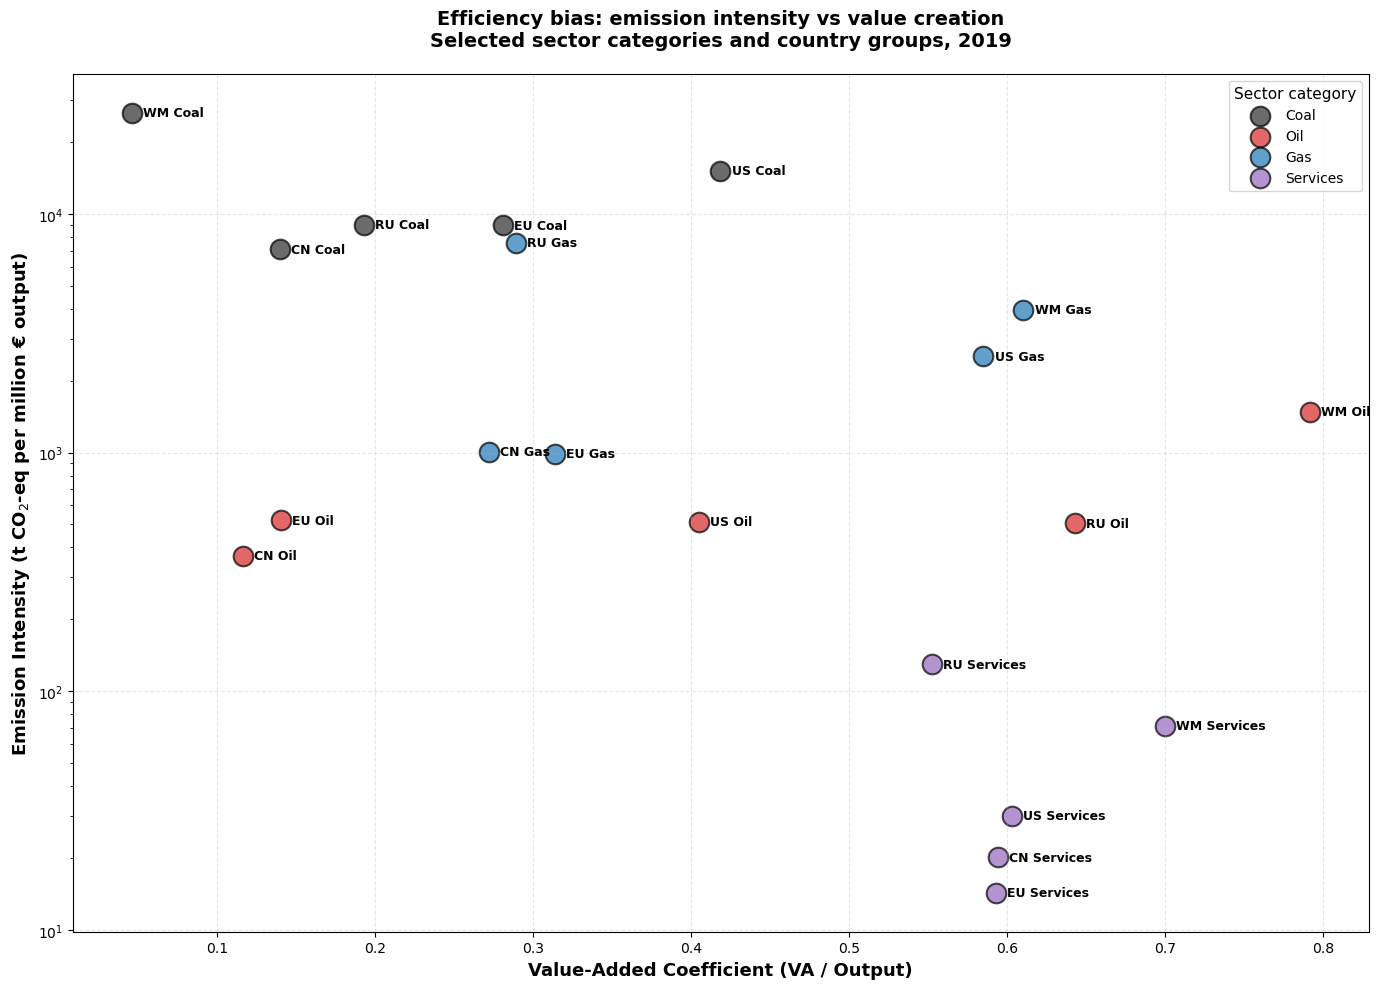


✓ Efficiency bias scatterplot created

### EFFICIENCY BIAS PATTERNS ###

Most emission-intensive (top 5):
  WM Coal                  :    26533 t/M€, VA=0.046
  US Coal                  :    15157 t/M€, VA=0.419
  RU Coal                  :     9011 t/M€, VA=0.193
  EU Coal                  :     8955 t/M€, VA=0.281
  RU Gas                   :     7559 t/M€, VA=0.289

Highest value-added (top 5):
  WM Oil                   : VA=0.792,     1484 t/M€
  WM Services              : VA=0.700,       72 t/M€
  RU Oil                   : VA=0.643,      505 t/M€
  WM Gas                   : VA=0.610,     3967 t/M€
  US Services              : VA=0.603,       30 t/M€

'Dirty but poor' sectors (high emissions, low value):
  EU Coal                  :     8955 t/M€, VA=0.281
  CN Coal                  :     7125 t/M€, VA=0.140
  RU Coal                  :     9011 t/M€, VA=0.193
  WM Coal                  :    26533 t/M€, VA=0.046
  CN Gas                   :     1008 t/M€, VA=0.272
  RU Gas     

In [51]:
# ===================================================================
# EFFICIENCY BIAS SCATTERPLOT
# Emission Intensity vs Value-Added Coefficients
# ===================================================================

print("\n=== EFFICIENCY BIAS ANALYSIS ===")

# EU countries
eu_countries = [
    'AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 
    'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 
    'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'GB'
]

# Sectors to analyze (category names from your sector_classification)
focus_sectors = ['Coal', 'Oil', 'Gas', 'Services']

# Country groups (EXIOBASE regions)
country_groups = ['EU', 'CN', 'US', 'RU', 'WM']

# ===================================================================
# STEP 1: Calculate emission intensity and VA coefficients per sector
# ===================================================================

# Total output (same order as producer_emissions)
total_output = ixi_data.x.values.flatten()

# Emission intensity in t CO2-eq per million € output
intensity_t_per_meur = np.divide(
    producer_emissions,
    total_output,
    out=np.zeros_like(producer_emissions, dtype=float),
    where=(total_output > 0)
)

intensity_series = pd.Series(intensity_t_per_meur, index=ixi_data.x.index, name="intensity_t_per_meur")

# Value-added coefficients (already cleaned) – one per sector-region
va_series = pd.Series(v_clean_all, index=ixi_data.x.index, name="va_coeff")

# Output as Series for weighting
output_series = pd.Series(total_output, index=ixi_data.x.index, name="output")

# ===================================================================
# STEP 2: Aggregate by sector category and country/region
# ===================================================================

plot_data = []

for sector_cat in focus_sectors:
    for country_group in country_groups:
        
        # Select regions
        if country_group == 'EU':
            regions_to_include = eu_countries
        else:
            regions_to_include = [country_group]
        
        # Mask: sectors belonging to this region group AND this sector category
        mask = pd.Series(
            [
                (region in regions_to_include) and (category_of(sector) == sector_cat)
                for region, sector in ixi_data.x.index
            ],
            index=ixi_data.x.index
        )
        
        if mask.sum() == 0:
            continue  # no matching sectors
        
        intensities = intensity_series[mask]
        va_coeffs = va_series[mask]
        outputs = output_series[mask]
        
        if outputs.sum() <= 0:
            continue
        
        # Output-weighted averages
        avg_intensity = np.average(intensities, weights=outputs)
        avg_va = np.average(va_coeffs, weights=outputs)
        
        plot_data.append({
            'sector': sector_cat,
            'country': country_group,
            'intensity': avg_intensity,
            'va_coeff': avg_va,
            'label': f"{country_group} {sector_cat}"
        })

# Create DataFrame
df_plot = pd.DataFrame(plot_data)

print(f"\nData points: {len(df_plot)}")
print(df_plot.head(10))

if df_plot.empty:
    print("⚠ df_plot is empty – check focus_sectors / country_groups / category_of() mapping.")
else:
    # ===================================================================
    # STEP 3: Create Scatterplot
    # ===================================================================

    # Colors per sector
    sector_colors = {
        'Coal': '#2c2c2c',           # Black
        'Oil': '#d62728',            # Red
        'Gas': '#1f77b4',            # Blue
        'Metals': '#bcbd22',         # Yellow-green (not used here)
        'Services': '#9467bd',       # Purple
        'Renewables': '#2ca02c'      # Green (not used here)
    }

    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot each sector
    for sector in focus_sectors:
        sector_data = df_plot[df_plot['sector'] == sector]
        if sector_data.empty:
            continue
        
        ax.scatter(
            sector_data['va_coeff'],
            sector_data['intensity'],
            c=sector_colors.get(sector, '#333333'),
            s=200,
            alpha=0.7,
            edgecolors='black',
            linewidth=1.5,
            label=sector
        )
        
        # Labels for each point
        for _, row in sector_data.iterrows():
            ax.annotate(
                row['label'],
                (row['va_coeff'], row['intensity']),
                xytext=(8, 0),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold',
                va='center'
            )

    # Formatting
    ax.set_xlabel('Value-Added Coefficient (VA / Output)', 
                  fontsize=13, fontweight='bold')
    ax.set_ylabel('Emission Intensity (t CO$_2$-eq per million € output)', 
                  fontsize=13, fontweight='bold')
    ax.set_title(
        'Efficiency bias: emission intensity vs value creation\n'
        f'Selected sector categories and country groups, {SINGLE_YEAR}',
        fontsize=14, fontweight='bold',
        pad=20
    )

    # Log scale for Y-axis (intensity varies a lot)
    ax.set_yscale('log')

    ax.grid(True, alpha=0.3, linestyle='--')

    ax.legend(
        title='Sector category',
        fontsize=10,
        title_fontsize=11,
        loc='upper right'
    )

    plt.tight_layout()
    plt.show()

    print("\n✓ Efficiency bias scatterplot created")

    # ===================================================================
    # SUMMARY: Identify patterns
    # ===================================================================

    print("\n### EFFICIENCY BIAS PATTERNS ###")

    # Highest emission intensity (dirty)
    print("\nMost emission-intensive (top 5):")
    for _, row in df_plot.nlargest(5, 'intensity').iterrows():
        print(f"  {row['label']:25s}: {row['intensity']:8.0f} t/M€, VA={row['va_coeff']:.3f}")

    # Highest value-added (most profitable)
    print("\nHighest value-added (top 5):")
    for _, row in df_plot.nlargest(5, 'va_coeff').iterrows():
        print(f"  {row['label']:25s}: VA={row['va_coeff']:.3f}, {row['intensity']:8.0f} t/M€")

    # "Dirty but poor" (high intensity, low VA)
    print("\n'Dirty but poor' sectors (high emissions, low value):")
    dirty_poor = df_plot[
        (df_plot['intensity'] > df_plot['intensity'].median()) &
        (df_plot['va_coeff'] < df_plot['va_coeff'].median())
    ]
    for _, row in dirty_poor.iterrows():
        print(f"  {row['label']:25s}: {row['intensity']:8.0f} t/M€, VA={row['va_coeff']:.3f}")

    # "Clean and rich" (low intensity, high VA)
    print("\n'Clean and profitable' sectors (low emissions, high value):")
    clean_rich = df_plot[
        (df_plot['intensity'] < df_plot['intensity'].median()) &
        (df_plot['va_coeff'] > df_plot['va_coeff'].median())
    ]
    for _, row in clean_rich.iterrows():
        print(f"  {row['label']:25s}: {row['intensity']:8.0f} t/M€, VA={row['va_coeff']:.3f}")



=== EFFICIENCY BIAS ANALYSIS (Coal vs Oil & Gas vs Services) ===

Data points: 15
      sector country  intensity  va_coeff   emissions_t  emissions_Mt  \
0       Coal      EU    8955.11      0.28  452621079.56        452.62   
1       Coal      CN    7125.29      0.14 5661830492.59       5661.83   
2       Coal      US   15156.68      0.42 1056505716.69       1056.51   
3       Coal      RU    9010.79      0.19  267970975.42        267.97   
4       Coal      WM   26533.46      0.05   34189262.12         34.19   
5  Oil & Gas      EU     713.00      0.21  577089316.51        577.09   
6  Oil & Gas      CN     456.30      0.14  612223345.70        612.22   
7  Oil & Gas      US     978.45      0.45 1398541322.82       1398.54   
8  Oil & Gas      RU    1423.85      0.60  701468342.22        701.47   
9  Oil & Gas      WM    1990.94      0.75 1626354033.53       1626.35   

          label  
0       EU Coal  
1       CN Coal  
2       US Coal  
3       RU Coal  
4       WM Coal  
5  EU

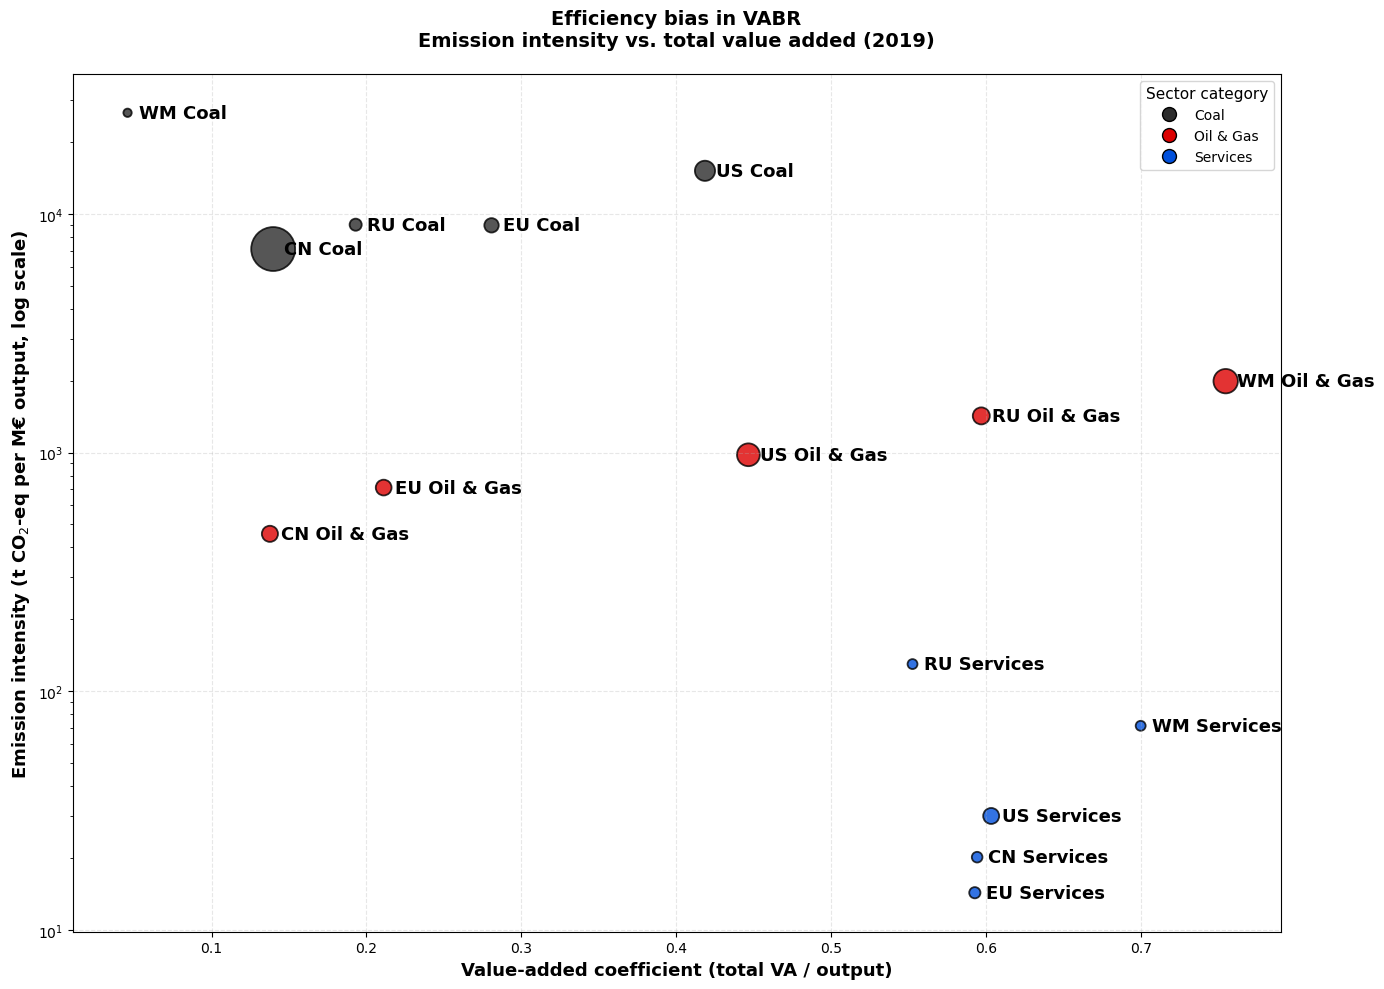


✓ Efficiency bias scatterplot with size ∝ emissions created

### EFFICIENCY BIAS PATTERNS (Coal vs Oil & Gas vs Services) ###

Most emission-intensive (top 5 points):
  WM Coal                  :    26533 t/unit, VA=0.046, Emissions=34.2 Mt
  US Coal                  :    15157 t/unit, VA=0.419, Emissions=1056.5 Mt
  RU Coal                  :     9011 t/unit, VA=0.193, Emissions=268.0 Mt
  EU Coal                  :     8955 t/unit, VA=0.281, Emissions=452.6 Mt
  CN Coal                  :     7125 t/unit, VA=0.140, Emissions=5661.8 Mt

Largest emitters (top 5 points by total emissions):
  CN Coal                  :   5661.8 Mt, intensity=    7125 t/unit, VA=0.140
  WM Oil & Gas             :   1626.4 Mt, intensity=    1991 t/unit, VA=0.755
  US Oil & Gas             :   1398.5 Mt, intensity=     978 t/unit, VA=0.447
  US Coal                  :   1056.5 Mt, intensity=   15157 t/unit, VA=0.419
  RU Oil & Gas             :    701.5 Mt, intensity=    1424 t/unit, VA=0.597


In [52]:
# ===================================================================
# EFFICIENCY BIAS SCATTERPLOT
# Emission Intensity vs Value-Added Coefficients
# Coal vs Oil & Gas vs Services
# Punktgröße ∝ Emissionen
# ===================================================================

print("\n=== EFFICIENCY BIAS ANALYSIS (Coal vs Oil & Gas vs Services) ===")

# EU countries
eu_countries = [
    'AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 
    'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 
    'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'GB'
]

# Sector categories for plotting
focus_sectors = ['Coal', 'Oil & Gas', 'Services']

# Country groups (EXIOBASE regions)
country_groups = ['EU', 'CN', 'US', 'RU', 'WM']  # AU optional

# ===================================================================
# STEP 1: Emission intensity (t CO2-eq per monetary unit) & VA coeffs
# ===================================================================

total_output = ixi_data.x.values.flatten()

# t CO2-eq per unit output (Skalierung egal, wichtig sind Relationen)
intensity_t_per_output = np.divide(
    producer_emissions,
    total_output,
    out=np.zeros_like(producer_emissions, dtype=float),
    where=(total_output > 0)
)
intensity_series = pd.Series(
    intensity_t_per_output, 
    index=ixi_data.x.index, 
    name="intensity_t_per_output"
)

va_series = pd.Series(v_clean_all, index=ixi_data.x.index, name="va_coeff")
output_series = pd.Series(total_output, index=ixi_data.x.index, name="output")

# ===================================================================
# STEP 2: Aggregate by sector category (Coal / Oil&Gas / Services)
#         and country/region – plus total emissions for point size
# ===================================================================

plot_data = []

for sector_cat in focus_sectors:
    for country_group in country_groups:
        
        # Welche EXIOBASE-Regionen gehören zu dieser Gruppe?
        if country_group == 'EU':
            regions_to_include = eu_countries
        else:
            regions_to_include = [country_group]
        
        # Welche Kategorien zählen für diese Plot-Kategorie?
        if sector_cat == 'Oil & Gas':
            cat_list = ['Oil', 'Gas']
        else:
            cat_list = [sector_cat]
        
        # Mask: richtige Region + richtige Kategorie
        mask = pd.Series(
            [
                (region in regions_to_include) and (category_of(sector) in cat_list)
                for region, sector in ixi_data.x.index
            ],
            index=ixi_data.x.index
        )
        
        if mask.sum() == 0:
            continue
        
        intensities = intensity_series[mask]
        va_coeffs   = va_series[mask]
        outputs     = output_series[mask]
        
        if outputs.sum() <= 0:
            continue
        
        # Output-gewichtete Mittelwerte
        avg_intensity = np.average(intensities, weights=outputs)
        avg_va        = np.average(va_coeffs,   weights=outputs)
        
        # Gesamtemissionen dieses Clusters (intensity * output)
        total_emissions_t = float((intensities * outputs).sum())  # ≈ Summe producer_emissions für diese Zellen
        
        plot_data.append({
            'sector':        sector_cat,
            'country':       country_group,
            'intensity':     avg_intensity,
            'va_coeff':      avg_va,
            'emissions_t':   total_emissions_t,
            'emissions_Mt':  total_emissions_t / 1e6,
            'label':         f"{country_group} {sector_cat}"
        })

df_plot = pd.DataFrame(plot_data)

print(f"\nData points: {len(df_plot)}")
print(df_plot.head(10))

if df_plot.empty:
    print("⚠ df_plot is empty – check focus_sectors / country_groups / category_of() mapping.")
else:
    # ===================================================================
    # STEP 3: Scatterplot mit Punktgröße ∝ Emissionen
    # ===================================================================

    from matplotlib.lines import Line2D

    sector_colors = {
        'Coal':      '#2c2c2c',  # Black
        'Oil & Gas': '#DC0000',  # Red
        'Services':  '#0050DC',  # Blue
    }

    # Punktgrößen nach Emissionen skalieren
    max_em = df_plot['emissions_Mt'].max()
    min_size = 30    # minimale Punktgröße
    max_size = 1000  # maximale Punktgröße

    fig, ax = plt.subplots(figsize=(14, 10))

    for sector in focus_sectors:
        sector_data = df_plot[df_plot['sector'] == sector]
        if sector_data.empty:
            continue
        
        sizes = min_size + (sector_data['emissions_Mt'] / max_em) * (max_size - min_size)
        
        sc = ax.scatter(
            sector_data['va_coeff'],
            sector_data['intensity'],
            s=sizes,
            c=sector_colors.get(sector, '#333333'),
            alpha=0.8,
            edgecolors='black',
            linewidth=1.3,
            # kein label hier – Legend wird manuell gebaut
        )
        
        # Labels
        for _, row in sector_data.iterrows():
            ax.annotate(
                row['label'],
                (row['va_coeff'], row['intensity']),
                xytext=(8, 0),
                textcoords='offset points',
                fontsize=13,
                fontweight='bold',
                va='center'
            )

    ax.set_xlabel('Value-added coefficient (total VA / output)', 
                  fontsize=13, fontweight='bold')
    ax.set_ylabel('Emission intensity (t CO$_2$-eq per M€ output, log scale)', 
                  fontsize=13, fontweight='bold')
    ax.set_title(
        f'Efficiency bias in VABR\n'
        f'Emission intensity vs. total value added ({SINGLE_YEAR})',
        fontsize=14, fontweight='bold', pad=20
    )

    # Log-Skala für Intensity, weil die stark variiert
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, linestyle='--')

    # ===== feste Legendensymbole mit gleicher Größe =====
    legend_handles = [
        Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            label='Coal',
            markerfacecolor=sector_colors['Coal'],
            markeredgecolor='black',
            markersize=10
        ),
        Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            label='Oil & Gas',
            markerfacecolor=sector_colors['Oil & Gas'],
            markeredgecolor='black',
            markersize=10
        ),
        Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            label='Services',
            markerfacecolor=sector_colors['Services'],
            markeredgecolor='black',
            markersize=10
        ),
    ]

    ax.legend(
        handles=legend_handles,
        title='Sector category',
        fontsize=10,
        title_fontsize=11,
        loc='upper right'
    )

    plt.tight_layout()
    plt.show()

    print("\n✓ Efficiency bias scatterplot with size ∝ emissions created")

    # ===================================================================
    # STEP 4: Summary für Text
    # ===================================================================

    print("\n### EFFICIENCY BIAS PATTERNS (Coal vs Oil & Gas vs Services) ###")

    print("\nMost emission-intensive (top 5 points):")
    for _, row in df_plot.nlargest(5, 'intensity').iterrows():
        print(f"  {row['label']:25s}: {row['intensity']:8.0f} t/unit, "
              f"VA={row['va_coeff']:.3f}, Emissions={row['emissions_Mt']:.1f} Mt")

    print("\nLargest emitters (top 5 points by total emissions):")
    for _, row in df_plot.nlargest(5, 'emissions_Mt').iterrows():
        print(f"  {row['label']:25s}: {row['emissions_Mt']:8.1f} Mt, "
              f"intensity={row['intensity']:8.0f} t/unit, VA={row['va_coeff']:.3f}")


In [ ]:
# ===================================================================
# DEBUG: What's in "IN Coal"?
# ===================================================================

print("\n=== DEBUGGING IN COAL AGGREGATION ===")

# Get all Indian Coal sectors
mask_in_coal = pd.Series([
    (region == 'IN' and category_of(sector) == 'Coal')
    for region, sector in ixi_data.x.index
], index=ixi_data.x.index)

print(f"\nIndian Coal sectors: {mask_in_coal.sum()}")

# Show details
for (region, sector) in ixi_data.x.index[mask_in_coal]:
    idx = ixi_data.x.index.get_loc((region, sector))
    
    intensity_kg = emission_intensity_kg[idx]
    va = v_clean_all[idx]
    output = total_output[idx]
    
    print(f"\n{sector}")
    print(f"  Emission intensity: {intensity_kg:,.0f} kg/€")
    print(f"  VA coefficient: {va:.3f}")
    print(f"  Output: {output/1e6:,.0f} M€")
    print(f"  Weight in aggregate: {output/total_output[mask_in_coal].sum()*100:.1f}%")

# Weighted average (what the plot shows)
intensities = emission_intensity_kg[mask_in_coal.values]
vas = v_clean_all[mask_in_coal.values]
outputs = total_output[mask_in_coal.values]

weighted_intensity = np.average(intensities, weights=outputs)
weighted_va = np.average(vas, weights=outputs)

print(f"\nWeighted averages (what plot shows):")
print(f"  Intensity: {weighted_intensity:,.0f} kg/€")
print(f"  VA: {weighted_va:.3f}")

In [29]:
# ===================================================================
# PLOT 1: TOP 30 EMITTERS - DETAILED SCATTER
# ===================================================================

print("\n" + "="*70)
print("PLOT 1: Top 30 Emitting Sectors - Efficiency Bias Analysis")
print("="*70)

# Select top 30 by total emissions
top30 = plot_data.nlargest(30, 'total_emissions').copy()

print(f"Top 30 sectors represent: {top30['total_emissions'].sum():.2f} Gt ({top30['total_emissions'].sum()/plot_data['total_emissions'].sum()*100:.1f}% of filtered total)")

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Plot each category
for category in top30['category'].unique():
    cat_data = top30[top30['category'] == category]
    
    ax.scatter(
        cat_data['va_coefficient'],
        cat_data['emission_intensity'],
        c=[colors_map[category]],
        label=category,
        s=cat_data['total_emissions'] * 200,  # Size by emissions
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5
    )

# Add labels for each point
for idx, row in top30.iterrows():
    region = row['region']
    sector_short = row['sector'][:30]  # Truncate long names
    
    # Offset text slightly to avoid overlap
    ax.annotate(
        f"{region}-{sector_short}",
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=7,
        alpha=0.8,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Top 30 Emitting Sectors: Efficiency Bias Analysis ({SINGLE_YEAR})\n(Bubble size = total emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Legend
ax.legend(
    title='Sector Category',
    loc='upper right',
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Top 30 scatter plot created")

# Print the list
print("\nTop 30 Sectors:")
print(top30[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient', 'category']].to_string())


PLOT 1: Top 30 Emitting Sectors - Efficiency Bias Analysis


KeyError: 'total_emissions'

In [30]:
# ===================================================================
# COAL DEEP DIVE - TOP 10 ONLY (CLEAN & SIMPLE)
# ===================================================================

# Select TOP 15 coal sectors only
top15_coal = coal_sectors.nlargest(15, 'total_emissions').copy()

fig, ax = plt.subplots(figsize=(12, 8))

# Scatter
scatter = ax.scatter(
    top15_coal['va_coefficient'],
    top15_coal['emission_intensity'],
    s=top15_coal['total_emissions'] * 500,
    c=top15_coal['total_emissions'],
    cmap='Reds',
    alpha=0.7,
    edgecolors='black',
    linewidths=1.5
)

# Labels - manually positioned for clarity
for idx, row in top10_coal.iterrows():
    # Short label: just region + first few words of sector
    sector_words = row['sector'].split()[:3]  # First 3 words
    label = f"{row['region']}\n{' '.join(sector_words)}\n{row['total_emissions']:.2f} Gt"
    
    ax.annotate(
        label,
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        ha='left',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.8),
        arrowprops=dict(arrowstyle='->', lw=0.8)
    )

ax.set_yscale('log')
ax.set_xlabel('Value-Added Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Coal Sectors: Top 15 Emitters - Efficiency Bias ({SINGLE_YEAR})',
    fontsize=13,
    fontweight='bold',
    pad=15
)

ax.grid(True, alpha=0.3, linestyle='--', which='both')
ax.set_xlim(-0.05, 0.55)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Emissions (Gt)', fontsize=10)

plt.tight_layout()
plt.show()

NameError: name 'coal_sectors' is not defined

In [ ]:
# ===================================================================
# TABLE: Top 20 Coal Sectors - Complete Details
# ===================================================================

print("\n" + "="*70)
print("TABLE: Top 20 Coal Sectors - Efficiency Bias Details")
print("="*70)

top20_coal_table = coal_sectors.nlargest(20, 'total_emissions').copy()

# Create clean table
coal_table = top20_coal_table[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].copy()
coal_table.columns = ['Region', 'Sector', 'Emissions (Gt)', 'Emission Intensity', 'VA Coefficient']
coal_table = coal_table.reset_index(drop=True)
coal_table.index = coal_table.index + 1  # Start from 1

print("\n")
print(coal_table.to_string())
print("\n")

# Summary
print("Key Statistics:")
print(f"Total (Top 20): {coal_table['Emissions (Gt)'].sum():.2f} Gt")
print(f"Average VA coefficient: {coal_table['VA Coefficient'].mean():.3f}")
print(f"Range emission intensity: {coal_table['Emission Intensity'].min():.0f} - {coal_table['Emission Intensity'].max():.0f} kg/EUR")

In [31]:
# ===================================================================
# PLOT: FOSSIL FUELS DEEP DIVE (Coal + Gas + Oil)
# ===================================================================

print("\n" + "="*70)
print("PLOT 1: Fossil Fuels Efficiency Bias - Top 20 Emitters")
print("="*70)

# Filter for fossil fuel sectors (Coal, Gas, Oil)
fossil_cats = ['Coal', 'Gas', 'Oil']
fossil_sectors = plot_data[plot_data['category'].isin(fossil_cats)].copy()

print(f"Total fossil fuel sectors: {len(fossil_sectors)}")
print(f"  Coal: {len(fossil_sectors[fossil_sectors['category']=='Coal'])}")
print(f"  Gas: {len(fossil_sectors[fossil_sectors['category']=='Gas'])}")
print(f"  Oil: {len(fossil_sectors[fossil_sectors['category']=='Oil'])}")
print(f"Total fossil emissions: {fossil_sectors['total_emissions'].sum():.2f} Gt")

# Select top 20 by total emissions
top20_fossil = fossil_sectors.nlargest(20, 'total_emissions').copy()

print(f"\nTop 20 represent: {top20_fossil['total_emissions'].sum():.2f} Gt ({top20_fossil['total_emissions'].sum()/fossil_sectors['total_emissions'].sum()*100:.1f}% of fossil total)")

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for the 3 fossil fuel types
fossil_colors = {
    'Coal': '#7f7f7f',
    'Gas': '#1f77b4', 
    'Oil': '#d62728'
}

# Plot each fossil fuel type separately
for fuel_type in ['Coal', 'Gas', 'Oil']:
    fuel_data = top20_fossil[top20_fossil['category'] == fuel_type]
    
    if len(fuel_data) > 0:
        ax.scatter(
            fuel_data['va_coefficient'],
            fuel_data['emission_intensity'],
            s=fuel_data['total_emissions'] * 400,
            c=fossil_colors[fuel_type],
            label=fuel_type,
            alpha=0.7,
            edgecolors='black',
            linewidths=1.5
        )

# Add labels for each point
for idx, row in top20_fossil.iterrows():
    region = row['region']
    # Short sector name - first 2-3 words
    sector_words = row['sector'].split()[:3]
    sector_short = ' '.join(sector_words)
    emissions_gt = row['total_emissions']
    
    label_text = f"{region}\n{sector_short}\n{emissions_gt:.2f} Gt"
    
    ax.annotate(
        label_text,
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(8, 5),
        textcoords='offset points',
        fontsize=7.5,
        ha='left',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='gray', linewidth=0.5),
        arrowprops=dict(arrowstyle='->', lw=0.7, color='gray')
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Fossil Fuels: Efficiency Bias Analysis - Top 20 Emitters ({SINGLE_YEAR})\n(Bubble size = total emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Legend
ax.legend(
    title='Fuel Type',
    loc='upper right',
    frameon=True,
    fontsize=11,
    title_fontsize=12,
    markerscale=1.5
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Fossil fuels scatter plot created")

# Print breakdown by fuel type
print("\n### Top 20 Breakdown by Fuel Type ###")
for fuel in ['Coal', 'Gas', 'Oil']:
    fuel_count = len(top20_fossil[top20_fossil['category'] == fuel])
    fuel_emissions = top20_fossil[top20_fossil['category'] == fuel]['total_emissions'].sum()
    print(f"{fuel}: {fuel_count} sectors, {fuel_emissions:.2f} Gt")


PLOT 1: Fossil Fuels Efficiency Bias - Top 20 Emitters


KeyError: 'category'

In [ ]:
# ===================================================================
# PLOT: CATEGORY-LEVEL ALLOCATION COMPARISON (BAR CHART)
# ===================================================================

print("\n" + "="*70)
print("PLOT: Sector Category Allocation - Bar Chart Comparison")
print("="*70)

# Use the category_table from before (if not already created, recreate it)
# Aggregate producer emissions by category
category_producer = bias_df_filtered.groupby('category')['total_emissions'].sum()

# Aggregate VABR by category
vabr_comparison = pd.DataFrame({
    'VABR_all': vabr_all_sector_data / 1e9,
    'VABR_profit': vabr_profit_sector_data / 1e9
})
vabr_comparison = vabr_comparison.merge(
    bias_df[['category']], 
    left_index=True, 
    right_index=True, 
    how='left'
)

category_vabr_all = vabr_comparison.groupby('category')['VABR_all'].sum()
category_vabr_profit = vabr_comparison.groupby('category')['VABR_profit'].sum()

# Create DataFrame
plot_data_cat = pd.DataFrame({
    'Producer': category_producer,
    'VABR (All VA)': category_vabr_all,
    'VABR (Profit)': category_vabr_profit
})

# Sort by Producer emissions (descending)
plot_data_cat = plot_data_cat.sort_values('Producer', ascending=False)

print(f"\nCategories: {len(plot_data_cat)}")
print(f"Total Producer: {plot_data_cat['Producer'].sum():.2f} Gt")
print(f"Total VABR (all): {plot_data_cat['VABR (All VA)'].sum():.2f} Gt")
print(f"Total VABR (profit): {plot_data_cat['VABR (Profit)'].sum():.2f} Gt")

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Bar positions
x = np.arange(len(plot_data_cat))
width = 0.28

# Plot 3 grouped bars
bars1 = ax.bar(x - width, plot_data_cat['Producer'], width, 
               label='Producer', color='#ffa300', edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x, plot_data_cat['VABR (All VA)'], width,
               label='VABR (All VA)', color='#dc267f', edgecolor='black', linewidth=0.5)
bars3 = ax.bar(x + width, plot_data_cat['VABR (Profit)'], width,
               label='VABR (Profit Only)', color='#785ef0', edgecolor='black', linewidth=0.5)

# Labels and title
ax.set_xlabel('Sector Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Responsibility Allocation (Gt CO2-eq)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Allocation by Sector Category: Producer vs. VABR Methods ({SINGLE_YEAR})',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Set x-axis
ax.set_xticks(x)
ax.set_xticklabels(plot_data_cat.index, rotation=45, ha='right', fontsize=10)

# Legend
ax.legend(fontsize=11, loc='upper right', frameon=True)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Category-level bar chart created")

# Print some key insights
print("\n### Key Patterns ###")

# Categories with large discrepancies
print("\nCategories where VABR (all) differs most from Producer:")
plot_data_cat['Abs_Diff'] = abs(plot_data_cat['Producer'] - plot_data_cat['VABR (All VA)'])
top_diff = plot_data_cat.nlargest(5, 'Abs_Diff')

for cat, row in top_diff.iterrows():
    ratio = (row['VABR (All VA)'] / row['Producer'] * 100) if row['Producer'] > 0 else 0
    print(f"  {cat}: Producer {row['Producer']:.2f} Gt → VABR {row['VABR (All VA)']:.2f} Gt ({ratio:.0f}%)")

In [48]:
import pandas as pd
import numpy as np

# --------------------------------------
# Helper: aggregate coal responsibility
# --------------------------------------
def aggregate_coal_responsibility(sector_series):
    """
    Sum responsibility for all sectors that belong to category 'Coal'.
    sector_series is a pd.Series indexed by (region, sector) or sector.
    Returns value in Mt CO2-eq.
    """
    total = 0.0
    for idx, value in sector_series.items():
        # idx can be ('DE', 'Mining of coal...') or just 'Mining of coal...'
        if isinstance(idx, tuple) and len(idx) >= 2:
            sector = idx[1]
        else:
            sector = idx
        if category_of(sector) == "Coal":
            total += value
    return total / 1e6  # convert to Mt CO2-eq


# --------------------------------------
# Countries and methods
# --------------------------------------
countries_for_table = ['IN', 'CN', 'US', 'DE']

rows = []

for c in countries_for_table:
    if c not in vabr_all_details or c not in vabr_techA_details:
        print(f"Warning: {c} not found in one of the detail dicts – skipping.")
        continue
    
    coal_vabr = aggregate_coal_responsibility(vabr_all_details[c])
    coal_vabr_techA = aggregate_coal_responsibility(vabr_techA_details[c])
    
    delta_mt = coal_vabr_techA - coal_vabr
    delta_pct = (delta_mt / coal_vabr * 100) if coal_vabr > 0 else np.nan
    
    rows.append({
        "Country": c,
        "Coal VABR (All VA) [Mt]": coal_vabr,
        "Coal T-VABR (Option A) [Mt]": coal_vabr_techA,
        "Δ (T-VABR − VABR) [Mt]": delta_mt,
        "Δ (%)": delta_pct
    })

coal_table = pd.DataFrame(rows).set_index("Country").round(1)
coal_table


,Coal VABR (All VA) [Mt],Coal T-VABR (Option A) [Mt],Δ (T-VABR − VABR) [Mt],Δ (%)
Country,,,,
IN,38.70,40.20,1.50,3.90
CN,97.10,96.50,-0.60,-0.70
US,12.10,12.00,-0.10,-0.80
DE,1.90,1.70,-0.20,-8.30


In [51]:
import pandas as pd
import numpy as np

# ================================================================
# PARAMETERS: countries + sectors
# ================================================================
countries_for_table = ['IN', 'CN', 'US', 'EU', 'WM', 'RU', 'AU']  # choose 4–6

# EXIOBASE sector names you want to aggregate over (default: coal mining)
sectors_of_interest = [
    "Mining of coal and lignite; extraction of peat (10)",
    # you can add more related sectors here if you want to broaden it
]

# ================================================================
# PREP: producer emissions as Series and VA data
# ================================================================
producer_series_sr = pd.Series(producer_emissions, index=ixi_data.x.index)

factor_inputs = ixi_data.factor_inputs.F  # rows: VA components, cols: MultiIndex (region, sector)

# ================================================================
# HELPER: aggregate emissions + VA for a region or EU for chosen sectors
# ================================================================
def aggregate_for_region(region_code, sectors_list):
    """
    Returns:
      total_emissions_t : producer emissions in tonnes CO2-eq (sum over selected sectors)
      total_va          : value added in same monetary unit as EXIOBASE (sum over selected sectors)
      vabr_tonnes       : VABR (All VA) responsibility in tonnes CO2-eq (sum over selected sectors)
    """
    # --- EU case ---
    if region_code == "EU":
        members = [c for c in EU_COUNTRIES if c in vabr_all_details]
        if not members:
            print("⚠ No EU members found in vabr_all_details – returning zeros.")
            return 0.0, 0.0, 0.0
        
        # Producer emissions for EU
        mask_eu = producer_series_sr.index.get_level_values(0).isin(members)
        mask_sec = producer_series_sr.index.get_level_values(1).isin(sectors_list)
        prod_sel = producer_series_sr[mask_eu & mask_sec]
        total_emissions_t = prod_sel.sum()
        
        # VA for EU (sum across VA components + all relevant sectors)
        cols_eu = factor_inputs.columns.get_level_values(0).isin(members)
        cols_sec = factor_inputs.columns.get_level_values(1).isin(sectors_list)
        cols_mask = cols_eu & cols_sec
        if cols_mask.any():
            va_sel = factor_inputs.loc[VALUE_ADDED_COMPONENTS, factor_inputs.columns[cols_mask]].sum().sum()
        else:
            va_sel = 0.0
        
        # VABR for EU: sum across member countries + chosen sectors
        vabr_sum = 0.0
        for m in members:
            if m not in vabr_all_details:
                continue
            s = vabr_all_details[m]
            # s is indexed by (region, sector)
            mask_m = s.index.get_level_values(0) == m
            mask_s = s.index.get_level_values(1).isin(sectors_list)
            vabr_sum += s[mask_m & mask_s].sum()
        
        return float(total_emissions_t), float(va_sel), float(vabr_sum)
    
    # --- Single country case ---
    # Producer emissions
    mask_country = producer_series_sr.index.get_level_values(0) == region_code
    mask_sec = producer_series_sr.index.get_level_values(1).isin(sectors_list)
    prod_sel = producer_series_sr[mask_country & mask_sec]
    total_emissions_t = prod_sel.sum()
    
    # VA
    cols_country = factor_inputs.columns.get_level_values(0) == region_code
    cols_sec = factor_inputs.columns.get_level_values(1).isin(sectors_list)
    cols_mask = cols_country & cols_sec
    if cols_mask.any():
        va_sel = factor_inputs.loc[VALUE_ADDED_COMPONENTS, factor_inputs.columns[cols_mask]].sum().sum()
    else:
        va_sel = 0.0
    
    # VABR (All VA)
    if region_code in vabr_all_details:
        s = vabr_all_details[region_code]  # Series indexed by (region, sector)
        mask_c = s.index.get_level_values(0) == region_code
        mask_s = s.index.get_level_values(1).isin(sectors_list)
        vabr_sum = s[mask_c & mask_s].sum()
    else:
        print(f"⚠ {region_code} not in vabr_all_details – setting VABR=0.")
        vabr_sum = 0.0
    
    return float(total_emissions_t), float(va_sel), float(vabr_sum)

# ================================================================
# BUILD TABLE
# ================================================================
rows = []

for c in countries_for_table:
    total_e, total_va, vabr_e = aggregate_for_region(c, sectors_of_interest)
    
    if total_va > 0:
        intensity = total_e / total_va  # t CO2-eq per monetary unit VA (often t per million €)
    else:
        intensity = np.nan
    
    if total_e > 0:
        vabr_share = 100.0 * vabr_e / total_e  # %
    else:
        vabr_share = np.nan
    
    rows.append({
        "Country": c,
        "Emission intensity (t CO₂-eq per VA unit)": intensity,
        "VABR / PBA (%)": vabr_share
    })

mini_table = pd.DataFrame(rows).set_index("Country")
mini_table_rounded = mini_table.round(2)
mini_table_rounded


,Emission intensity (t CO₂-eq per VA unit),VABR / PBA (%)
Country,,
IN,1685.85,64.91
CN,16973.27,5.18
US,5246.28,9.89
EU,4461.48,12.61
WM,17668853601.71,0.00
RU,39991.05,1.99
AU,645.62,116.13


In [21]:
import pandas as pd
import numpy as np

# ================================================================
# PARAMETERS: countries + sectors
# ================================================================
countries_for_table = ['IN', 'CN', 'US', 'EU', 'WM', 'RU', 'AU']  # choose freely

# EXIOBASE sector names you want to aggregate over (default: coal mining)
sectors_of_interest = [
    "Mining of coal and lignite; extraction of peat (10)",
    # add more sectors here if you want to broaden the definition
]

# ================================================================
# PREP: producer emissions, VA, and tech-adjusted info
# ================================================================
producer_series_sr = pd.Series(producer_emissions, index=ixi_data.x.index)
factor_inputs = ixi_data.factor_inputs.F  # rows: VA components, cols: (region, sector)

# excess_emissions & sector_gaps come from calculate_vabr_with_tech_penalty(...)
# excess_emissions is sector_gaps["excess_emissions"]
excess_emissions = sector_gaps["excess_emissions"]

alpha = 1.0  # same as used in calculate_vabr_with_tech_penalty

# Global totals for scaling (mass-conserving)
base_total = vabr_all.sum()                         # global VABR total (t CO2-eq)
raw_total = base_total + alpha * excess_emissions.sum()
scale_factor = base_total / raw_total if raw_total > 0 else 1.0

print(f"\nGlobal base VABR total:        {base_total/1e9:.2f} Gt")
print(f"Global raw VABR+penalty total: {raw_total/1e9:.2f} Gt")
print(f"Scaling factor (Prod-adjusted): {scale_factor:.4f}")

# Build a sector-level Series of standard VABR (All VA) with MultiIndex (region, sector)
vabr_sector_all = []

for country, s in vabr_all_details.items():
    # s is already indexed by (region, sector)
    vabr_sector_all.append(s)

vabr_sector_all = pd.concat(vabr_sector_all)
# In case of duplicates, sum them (shouldn't hurt)
vabr_sector_all = vabr_sector_all.groupby(level=[0, 1]).sum()

# Align with excess_emissions index (fill missing with 0)
vabr_sector_all = vabr_sector_all.reindex(excess_emissions.index, fill_value=0.0)

# Production-adjusted VABR at sector level (mass-conserving)
prod_adj_sector = (vabr_sector_all + alpha * excess_emissions) * scale_factor

# ================================================================
# HELPER: aggregate emissions, VA, VABR, Prod-adjusted for region/EU
# ================================================================
def aggregate_for_region(region_code, sectors_list):
    """
    Returns:
      total_emissions_t : producer emissions in tonnes CO2-eq (sum over selected sectors)
      total_va          : value added (same monetary unit as EXIOBASE, sum over selected sectors)
      vabr_tonnes       : VABR (All VA) responsibility in tonnes CO2-eq (sum over selected sectors)
      prod_adj_tonnes   : Production-adjusted VABR in tonnes CO2-eq (sum over selected sectors)
    """
    # --- EU case (aggregate over member countries) ---
    if region_code == "EU":
        members = [c for c in EU_COUNTRIES if c in vabr_all_details]
        if not members:
            print("⚠ No EU members found in vabr_all_details – returning zeros.")
            return 0.0, 0.0, 0.0, 0.0
        
        # Producer emissions for EU
        mask_eu = producer_series_sr.index.get_level_values(0).isin(members)
        mask_sec = producer_series_sr.index.get_level_values(1).isin(sectors_list)
        prod_sel = producer_series_sr[mask_eu & mask_sec]
        total_emissions_t = prod_sel.sum()
        
        # VA for EU (across all VA components and relevant sectors)
        cols_eu = factor_inputs.columns.get_level_values(0).isin(members)
        cols_sec = factor_inputs.columns.get_level_values(1).isin(sectors_list)
        cols_mask = cols_eu & cols_sec
        if cols_mask.any():
            va_sel = factor_inputs.loc[VALUE_ADDED_COMPONENTS, factor_inputs.columns[cols_mask]].sum().sum()
        else:
            va_sel = 0.0
        
        # VABR for EU: sum across member countries + chosen sectors
        vabr_sum = 0.0
        prod_adj_sum = 0.0
        
        for m in members:
            if m not in vabr_all_details:
                continue
            
            # VABR
            s_vabr = vabr_all_details[m]
            mask_m = s_vabr.index.get_level_values(0) == m
            mask_s = s_vabr.index.get_level_values(1).isin(sectors_list)
            vabr_sum += s_vabr[mask_m & mask_s].sum()
            
            # Production-adjusted VABR at sector level
            mask_m2 = prod_adj_sector.index.get_level_values(0) == m
            mask_s2 = prod_adj_sector.index.get_level_values(1).isin(sectors_list)
            prod_adj_sum += prod_adj_sector[mask_m2 & mask_s2].sum()
        
        return float(total_emissions_t), float(va_sel), float(vabr_sum), float(prod_adj_sum)
    
    # --- Single country case ---
    # Producer emissions
    mask_country = producer_series_sr.index.get_level_values(0) == region_code
    mask_sec = producer_series_sr.index.get_level_values(1).isin(sectors_list)
    prod_sel = producer_series_sr[mask_country & mask_sec]
    total_emissions_t = prod_sel.sum()
    
    # VA
    cols_country = factor_inputs.columns.get_level_values(0) == region_code
    cols_sec = factor_inputs.columns.get_level_values(1).isin(sectors_list)
    cols_mask = cols_country & cols_sec
    if cols_mask.any():
        va_sel = factor_inputs.loc[VALUE_ADDED_COMPONENTS, factor_inputs.columns[cols_mask]].sum().sum()
    else:
        va_sel = 0.0
    
    # VABR (All VA) at sector level
    if region_code in vabr_all_details:
        s_vabr = vabr_all_details[region_code]  # (region, sector)
        mask_c = s_vabr.index.get_level_values(0) == region_code
        mask_s = s_vabr.index.get_level_values(1).isin(sectors_list)
        vabr_sum = s_vabr[mask_c & mask_s].sum()
    else:
        print(f"⚠ {region_code} not in vabr_all_details – setting VABR=0.")
        vabr_sum = 0.0
    
    # Production-adjusted VABR for this country and sectors
    mask_c2 = prod_adj_sector.index.get_level_values(0) == region_code
    mask_s2 = prod_adj_sector.index.get_level_values(1).isin(sectors_list)
    prod_adj_sum = prod_adj_sector[mask_c2 & mask_s2].sum()
    
    return float(total_emissions_t), float(va_sel), float(vabr_sum), float(prod_adj_sum)

# ================================================================
# BUILD TABLE (no ratios, just PBA / VABR / Prod-adjusted)
# ================================================================
rows = []

for c in countries_for_table:
    total_e, total_va, vabr_e, prod_adj_e = aggregate_for_region(c, sectors_of_interest)
    
    if total_va > 0:
        intensity = total_e / total_va   # t CO2-eq per VA unit
    else:
        intensity = np.nan
    
    rows.append({
        "Country": c,
        "Emission intensity (t CO₂-eq per VA unit)": intensity,
        "PBA (Mt CO₂-eq)":            total_e / 1e6,
        "VABR (Mt CO₂-eq)":           vabr_e / 1e6,
        "Prod-adjusted (Mt CO₂-eq)":  prod_adj_e / 1e6,
    })

mini_table = pd.DataFrame(rows).set_index("Country")
mini_table_rounded = mini_table.round(2)

print("\n=== Sector-level table: PBA, VABR, Production-adjusted (Mt CO₂-eq) ===")
print(mini_table_rounded)



Global base VABR total:        44.71 Gt
Global raw VABR+penalty total: 57.68 Gt
Scaling factor (Prod-adjusted): 0.7751

=== Sector-level table: PBA, VABR, Production-adjusted (Mt CO₂-eq) ===
         Emission intensity (t CO₂-eq per VA unit)  PBA (Mt CO₂-eq)  \
Country                                                               
IN                                         1685.85            59.59   
CN                                        16973.27           808.89   
US                                         5246.28            62.85   
EU                                         4461.48            27.76   
WM                                  17668853601.71            12.04   
RU                                        39991.05            79.99   
AU                                          645.62            39.75   

         VABR (Mt CO₂-eq)  Prod-adjusted (Mt CO₂-eq)  
Country                                               
IN                  38.68                      29.98  
CN 

In [9]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# World-average emission intensity for coal mining
# ---------------------------------------------------------

coal_sector_name = "Mining of coal and lignite; extraction of peat (10)"

# Flattened output and emissions
x = ixi_data.x.values.flatten()                      # output
e = np.asarray(producer_emissions).flatten()         # emissions (t CO2-eq)

idx = ixi_data.x.index                               # MultiIndex (region, sector)

# 1) Mask for coal mining sector across all regions
mask_coal = (idx.get_level_values(1) == coal_sector_name)

x_coal = x[mask_coal]
e_coal = e[mask_coal]

# ---------------------------------------------------------
# A) World-average intensity per unit of OUTPUT (t / currency)
#    This is what your technology benchmark in Option B uses.
# ---------------------------------------------------------
if x_coal.sum() > 0:
    world_avg_intensity_output = e_coal.sum() / x_coal.sum()
else:
    world_avg_intensity_output = np.nan

print(f"World average intensity (coal mining, per unit output): "
      f"{world_avg_intensity_output:.3e} t CO2-eq per currency unit")

# Optional: per million currency units to get nicer numbers
print(f" => {world_avg_intensity_output * 1e6:.2f} t CO2-eq per 1e6 currency units")


# ---------------------------------------------------------
# B) World-average intensity per unit of VALUE ADDED
#    (for your 't CO2 / € VA' narrative)
# ---------------------------------------------------------

factor_inputs = ixi_data.factor_inputs.F  # rows: VA components, cols: (region, sector)

# Columns that correspond to coal mining
cols = factor_inputs.columns
mask_cols_coal = (cols.get_level_values(1) == coal_sector_name)

# Total VA in coal mining (sum over all VA components + regions)
if mask_cols_coal.any():
    va_coal_total = factor_inputs.loc[VALUE_ADDED_COMPONENTS, cols[mask_cols_coal]].sum().sum()
else:
    va_coal_total = 0.0

if va_coal_total > 0:
    world_avg_intensity_va = e_coal.sum() / va_coal_total
else:
    world_avg_intensity_va = np.nan

print(f"\nWorld average intensity (coal mining, per unit VA): "
      f"{world_avg_intensity_va:.3e} t CO2-eq per VA currency unit")
print(f" => {world_avg_intensity_va * 1e6:.2f} t CO2-eq per 1e6 VA currency units")


World average intensity (coal mining, per unit output): 2.012e+03 t CO2-eq per currency unit
 => 2012056423.92 t CO2-eq per 1e6 currency units

World average intensity (coal mining, per unit VA): 7.523e+03 t CO2-eq per VA currency unit
 => 7523182030.20 t CO2-eq per 1e6 VA currency units


TECH ADJUSTED VABR VERSION

In [23]:
# Nach dem Funktionsaufruf:
print(f"Net tech adjustment: {tech_penalty.sum() / 1e9:.2f} Gt")
print(f"Positive (penalties): {tech_penalty[tech_penalty > 0].sum() / 1e9:.2f} Gt")
print(f"Negative (bonuses): {tech_penalty[tech_penalty < 0].sum() / 1e9:.2f} Gt")

Net tech adjustment: 2.25 Gt
Positive (penalties): 9.78 Gt
Negative (bonuses): -7.53 Gt



Redistribution Effect of Trade-adjusted VABR

Top winners under TechA (responsibility reduced):
US   -0.15
CN   -0.14
AU   -0.11
DE   -0.10
JP   -0.07
Name: Δ Responsibility (Gt), dtype: float64

Top losers under TechA (responsibility increased):
RU   0.10
WA   0.10
IN   0.11
WF   0.18
WM   0.34
Name: Δ Responsibility (Gt), dtype: float64


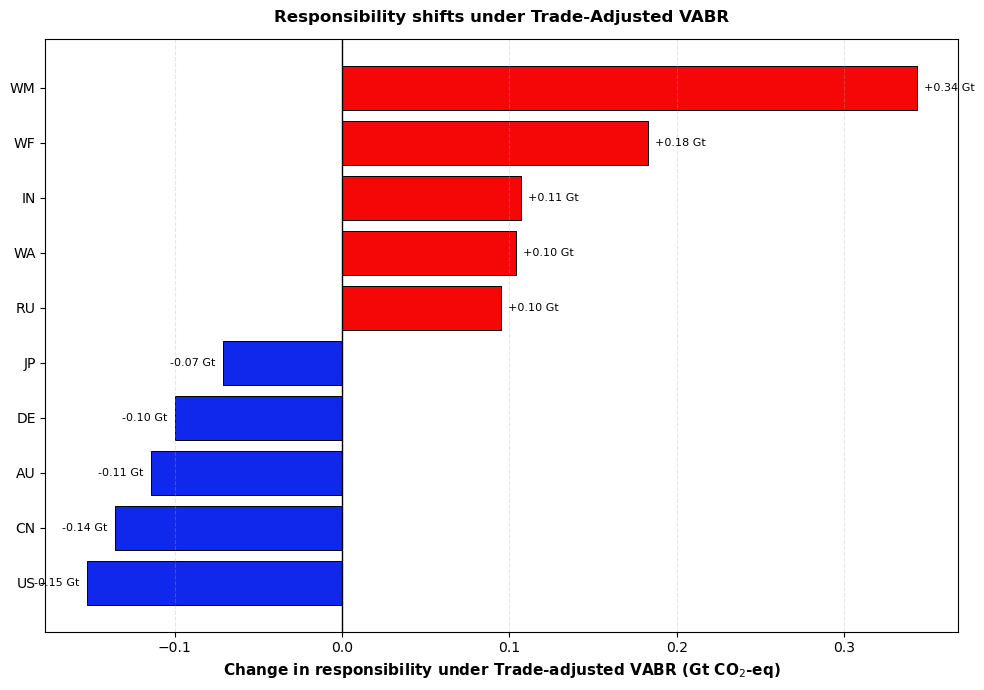


✓ Winners/losers bar chart created (redistribution effect of Trade vs standard VABR).


In [28]:
# ===================================================================
# WINNERS / LOSERS: REDISTRIBUTION UNDER TECH-ADJUSTED VABR (Option A)
# ===================================================================

print("\n" + "="*70)
print("Redistribution Effect of Trade-adjusted VABR")
print("="*70)

# Delta: how much responsibility changes due to TechA (Gt CO2-eq)
delta_A_Gt = (vabr_techA - vabr_all) / 1e9
delta_A_Gt.name = "Δ Responsibility (Gt)"

# Positive = gets MORE responsibility under TechA (loser)
# Negative = gets LESS responsibility (winner)

TOP_WINNERS_A = 5  # biggest reductions
TOP_LOSERS_A  = 5   # biggest increases

# Sort by change
delta_A_sorted = delta_A_Gt.sort_values()

winners_A = delta_A_sorted.head(TOP_WINNERS_A)   # most negative
losers_A  = delta_A_sorted.tail(TOP_LOSERS_A)    # most positive

# Combine for plotting (winners on top, losers bottom)
plot_series_A = pd.concat([winners_A, losers_A])

print("\nTop winners under TechA (responsibility reduced):")
print(winners_A.round(3))

print("\nTop losers under TechA (responsibility increased):")
print(losers_A.round(3))

# -------------------------------------------------------------------
# Diverging bar chart
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 7))

y_pos = np.arange(len(plot_series_A))

colors_A = [
    "#0f28ec" if v < 0 else "#f50707"
    for v in plot_series_A.values
]

ax.barh(
    y_pos,
    plot_series_A.values,
    color=colors_A,
    edgecolor="black",
    linewidth=0.7
)

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_series_A.index)

ax.axvline(0, color="black", linewidth=1)

ax.set_xlabel("Change in responsibility under Trade-adjusted VABR (Gt CO$_2$-eq)",
              fontsize=11, fontweight="bold")
ax.set_title(
    "Responsibility shifts under Trade-Adjusted VABR",
    fontsize=12,
    fontweight="bold",
    pad=12
)

# Add small text labels at bar ends
for i, (country, val) in enumerate(plot_series_A.items()):
    align = "left" if val >= 0 else "right"
    offset = 0.01 * (plot_series_A.abs().max() + 0.1)
    ax.text(
        val + (offset if val >= 0 else -offset),
        i,
        f"{val:+.2f} Gt",
        va="center",
        ha=align,
        fontsize=8
    )

ax.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print("\n✓ Winners/losers bar chart created (redistribution effect of Trade vs standard VABR).")



=== RUNNING SMALL OPTION B ANALYSIS (world_avg, alpha=1) ===

=== VABR + TECHNOLOGY-GAP REDISTRIBUTION (Production-adjusted VABR, mass-conserving) ===
Benchmark: world_avg, alpha=1.0

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

Base VABR total: 44.71 Gt CO2-eq

=== TECHNOLOGY-GAP PENALTY (Producer-Side, benchmark=world_avg) ===
Calculating sectoral benchmarks...
Total actual emissions:   44.72 Gt
Total avoidable emissions: 12.97 Gt (29.0% of global emissions)

Net technology adjustment (sum over countries): 2.25 Gt CO2-eq
Raw total (VABR + alpha * adj): 46.96 Gt CO2-eq

Global totals after scaling (Gt CO2-eq):
  Base VABR total:           44.71
  Raw adjusted total:        46.96
  Scale factor applied:      0.9521
  Mass-conserving total:     44.71

### TOP 10 COUNTRIES BY TECH PENALTY (Gt) ###
    VABR  Tech penalty  Total (VABR + tech)  Change (%)
RU  1.50          3.65                 4.91     

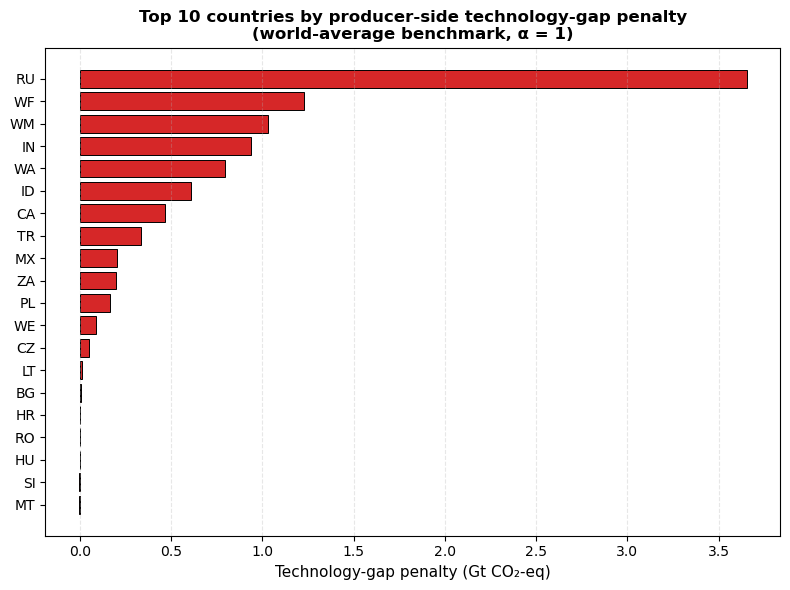


### TOP 10 SECTORS BY AVOIDABLE EMISSIONS (GLOBAL) ###
Production of electricity by coal                              1.529 Gt
Cattle farming                                                 0.880 Gt
Manufacture of cement, lime and plaster                        0.859 Gt
Landfill of waste: Food                                        0.798 Gt
Raw milk                                                       0.555 Gt
Production of electricity by gas                               0.507 Gt
Re-processing of secondary steel into new steel                0.389 Gt
Cultivation of paddy rice                                      0.382 Gt
Landfill of waste: Paper                                       0.346 Gt
Mining of coal and lignite; extraction of peat (10)            0.333 Gt


In [22]:
# ===================================================================
# SMALL ANALYSIS BLOCK FOR OPTION B
# ===================================================================

print("\n=== RUNNING SMALL OPTION B ANALYSIS (world_avg, alpha=1) ===")

resp_B, vabr_base, tech_penalty, gaps = calculate_vabr_with_tech_penalty(
    ixi_data,
    producer_emissions,
    v_clean_all,       # your all-VA coefficients
    benchmark_mode="world_avg",
    alpha=1.0
)

# Comparison DataFrame in Gt
comparison_B = pd.DataFrame({
    "VABR": vabr_base / 1e9,
    "Tech penalty": tech_penalty / 1e9,
    "Total (VABR + tech)": resp_B / 1e9,
})
comparison_B["Change (Gt)"] = comparison_B["Total (VABR + tech)"] - comparison_B["VABR"]
comparison_B["Change (%)"] = comparison_B["Change (Gt)"] / comparison_B["VABR"] * 100

print("\n### TOP 10 COUNTRIES BY TECH PENALTY (Gt) ###")
print(
    comparison_B.nlargest(20, "Tech penalty")[
        ["VABR", "Tech penalty", "Total (VABR + tech)", "Change (%)"]
    ]
)

# Simple bar plot: top 10 penalized countries
top10_penalized = comparison_B.nlargest(20, "Tech penalty").sort_values("Tech penalty")

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(
    top10_penalized.index,
    top10_penalized["Tech penalty"],
    color="#d62728",
    edgecolor="black",
    linewidth=0.7,
)
ax.set_xlabel("Technology-gap penalty (Gt CO₂-eq)", fontsize=11)
ax.set_title(
    "Top 10 countries by producer-side technology-gap penalty\n"
    "(world-average benchmark, α = 1)",
    fontsize=12,
    fontweight="bold",
)
ax.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Sector-level: top 10 sectors with highest avoidable emissions
sector_totals = (
    gaps.groupby(level=1)["excess_emissions"].sum().sort_values(ascending=False) / 1e9
)

print("\n### TOP 10 SECTORS BY AVOIDABLE EMISSIONS (GLOBAL) ###")
for sector, value in sector_totals.head(10).items():
    print(f"{sector[:60]:60s}  {value:6.3f} Gt")


In [40]:
# ===================================================================
# TABLE: COUNTRY-LEVEL EFFECT OF TRADE- & PRODUCTION-ADJUSTED VABR
# ===================================================================

print("\n" + "="*70)
print("COUNTRY TABLE: VABR vs Trade-adjusted vs Production-adjusted")
print("="*70)

# 1) Länder auswählen, die in der Tabelle erscheinen sollen
countries_focus = ['WM', 'WF', 'IN', 'US', 'CN', 'AU', 'EU']  # EU nur, falls du sie vorher aggregiert hast

# 2) Sicherstellen, dass die Serien existieren und in Gt umrechnen
base_vabr = (vabr_all / 1e9).copy()          # Standard VABR in Gt
trade_vabr = (vabr_techA / 1e9).copy()       # Trade-adjusted VABR in Gt
prod_vabr  = (vabr_techB_total / 1e9).copy() # Production-adjusted VABR in Gt

table_rows = []

for country in countries_focus:
    if country not in base_vabr.index:
        print(f"⚠ Warning: {country} not found in VABR index, skipping.")
        continue
    
    base_val  = base_vabr.loc[country]
    trade_val = trade_vabr.loc[country] if country in trade_vabr.index else np.nan
    prod_val  = prod_vabr.loc[country]  if country in prod_vabr.index  else np.nan
    
    # Prozentänderungen relativ zu VABR
    if base_val > 0:
        d_trade_abs = trade_val - base_val if not np.isnan(trade_val) else np.nan
        d_trade_rel = (d_trade_abs / base_val * 100) if not np.isnan(d_trade_abs) else np.nan
        
        d_prod_abs  = prod_val - base_val if not np.isnan(prod_val) else np.nan
        d_prod_rel  = (d_prod_abs / base_val * 100) if not np.isnan(d_prod_abs) else np.nan
    else:
        d_trade_abs = d_trade_rel = np.nan
        d_prod_abs  = d_prod_rel  = np.nan
    
    row = {
        "country": country,
        "VABR (Gt)":                 base_val,
        "Trade-adjusted (Gt)":       trade_val,
        "Δ Trade vs VABR (Gt)":      d_trade_abs,
        "Δ Trade vs VABR (%)":       d_trade_rel,
        "Prod-adjusted (Gt)":        prod_val,
        "Δ Prod vs VABR (Gt)":       d_prod_abs,
        "Δ Prod vs VABR (%)":        d_prod_rel,
    }
    
    table_rows.append(row)

vabr_adjust_table = pd.DataFrame(table_rows).set_index("country")

# Schön runden
vabr_adjust_table_rounded = vabr_adjust_table.copy()
vabr_adjust_table_rounded[[
    "VABR (Gt)",
    "Trade-adjusted (Gt)",
    "Δ Trade vs VABR (Gt)",
    "Prod-adjusted (Gt)",
    "Δ Prod vs VABR (Gt)",
]] = vabr_adjust_table_rounded[[
    "VABR (Gt)",
    "Trade-adjusted (Gt)",
    "Δ Trade vs VABR (Gt)",
    "Prod-adjusted (Gt)",
    "Δ Prod vs VABR (Gt)",
]].round(2)

vabr_adjust_table_rounded[[
    "Δ Trade vs VABR (%)",
    "Δ Prod vs VABR (%)",
]] = vabr_adjust_table_rounded[[
    "Δ Trade vs VABR (%)",
    "Δ Prod vs VABR (%)",
]].round(1)

print("\n=== Country-level adjustment table (VABR vs Trade-/Prod-adjusted) ===")
print(vabr_adjust_table_rounded)



COUNTRY TABLE: VABR vs Trade-adjusted vs Production-adjusted
⚠ Warning: EU not found in VABR index, skipping.

=== Country-level adjustment table (VABR vs Trade-/Prod-adjusted) ===
         VABR (Gt)  Trade-adjusted (Gt)  Δ Trade vs VABR (Gt)  \
country                                                         
WM            2.46                 2.81                  0.34   
WF            1.89                 2.08                  0.18   
IN            2.89                 3.00                  0.11   
US            6.53                 6.38                 -0.15   
CN           11.49                11.35                 -0.14   
AU            0.56                 0.45                 -0.11   

         Δ Trade vs VABR (%)  Prod-adjusted (Gt)  Δ Prod vs VABR (Gt)  \
country                                                                 
WM                     14.00                2.90                 0.44   
WF                      9.60                2.40                 0.51   
IN   


ANALYSIS: Mass-conserving Technology-Adjusted VABR (Option B)

Global standard VABR:      44.71 Gt
Global tech-adjusted total: 44.71 Gt
Mass conserved?            True

Top 12 countries by percentage increase:
    Standard VABR  Total (VABR+TechB)  Change (Gt)  Change (%)
LT           0.03                0.04         0.01       30.29
CZ           0.11                0.15         0.04       36.78
PL           0.28                0.43         0.14       50.75
ZA           0.30                0.47         0.17       58.02
MX           0.58                0.75         0.17       28.49
TR           0.48                0.78         0.29       61.12
CA           0.56                0.98         0.42       73.56
ID           0.94                1.48         0.54       57.28
WF           1.89                2.97         1.08       57.14
WM           2.46                3.33         0.86       35.14
IN           2.90                3.65         0.75       25.98
RU           1.50                

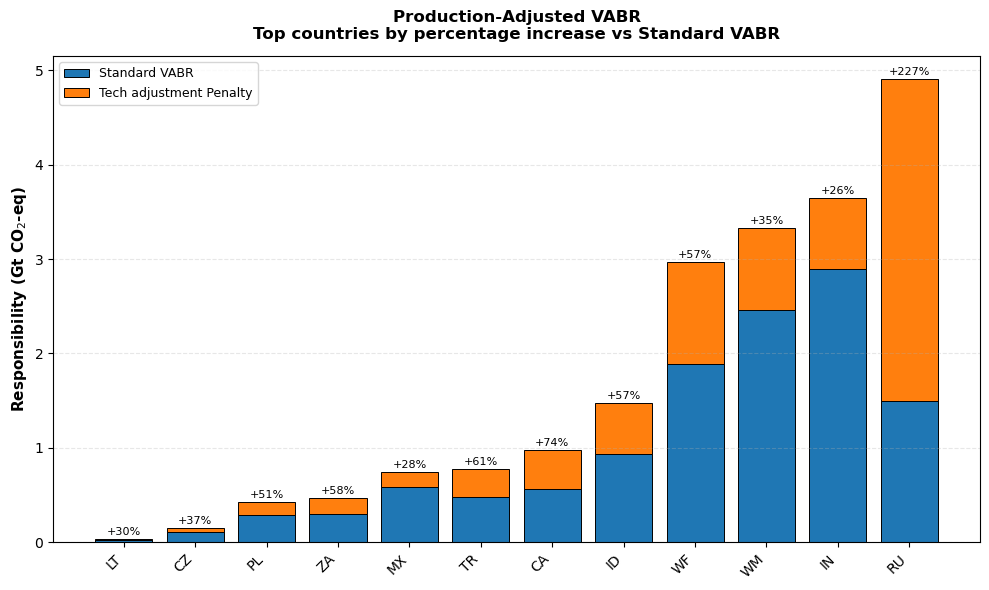


✓ Stacked bar chart created (Standard VABR + Tech adjustment, mass-conserving).

### Countries most penalised (highest % increase) ###
RU: +227% (1.50 → 4.91 Gt)
CA: +74% (0.57 → 0.98 Gt)
TR: +61% (0.48 → 0.78 Gt)
ZA: +58% (0.30 → 0.47 Gt)
ID: +57% (0.94 → 1.48 Gt)
WF: +57% (1.89 → 2.97 Gt)
PL: +51% (0.28 → 0.43 Gt)
CZ: +37% (0.11 → 0.15 Gt)
WM: +35% (2.46 → 3.33 Gt)
LT: +30% (0.03 → 0.04 Gt)

### Countries most rewarded (highest % decrease) ###
MT: -82% (0.01 → 0.00 Gt)
IE: -79% (0.13 → 0.03 Gt)
LU: -75% (0.02 → 0.01 Gt)
CY: -72% (0.01 → 0.00 Gt)
SE: -72% (0.13 → 0.04 Gt)
NO: -63% (0.10 → 0.04 Gt)
DK: -63% (0.10 → 0.04 Gt)
CH: -63% (0.23 → 0.09 Gt)
FI: -59% (0.08 → 0.03 Gt)
ES: -56% (0.38 → 0.17 Gt)


In [19]:
# ===================================================================
# ANALYSIS: MASS-CONSERVING TECH OPTION B (COUNTRY LEVEL)
# ===================================================================

print("\n" + "="*70)
print("ANALYSIS: Mass-conserving Technology-Adjusted VABR (Option B)")
print("="*70)

# We assume you already ran:
# vabr_techB_total, vabr_techB_vabr_part, tech_penalty, sector_gaps = calculate_vabr_with_tech_penalty(...)

# Build comparison table (Gt CO2-eq)
comparison_techB = pd.DataFrame({
    "Standard VABR":      vabr_techB_vabr_part / 1e9,     # Gt
    "Total (VABR+TechB)": vabr_techB_total / 1e9          # Gt
})

# Effective penalty/bonus after rescaling (can be positive or negative)
comparison_techB["Effective Tech Component"] = (
    comparison_techB["Total (VABR+TechB)"] - comparison_techB["Standard VABR"]
)

# Absolute and relative change
comparison_techB["Change (Gt)"] = comparison_techB["Effective Tech Component"]
comparison_techB["Change (%)"] = (
    comparison_techB["Change (Gt)"] 
    / comparison_techB["Standard VABR"].replace(0, np.nan)
) * 100

# Quick global check
global_standard = comparison_techB["Standard VABR"].sum()
global_total    = comparison_techB["Total (VABR+TechB)"].sum()
print(f"\nGlobal standard VABR:      {global_standard:.2f} Gt")
print(f"Global tech-adjusted total: {global_total:.2f} Gt")
print(f"Mass conserved?            {np.isclose(global_standard, global_total)}")

# ===================================================================
# PLOT: TOP N COUNTRIES BY PERCENTAGE INCREASE (ONLY POSITIVE CHANGES)
# ===================================================================

TOP_N = 12   # number of countries to show

# Keep only countries with positive % change (penalised by tech)
pos_changes = comparison_techB[comparison_techB["Change (%)"] > 0].copy()

if len(pos_changes) == 0:
    print("\nNo countries with positive tech penalty under Option B.")
else:
    # Select top N by percentage change
    plot_df = pos_changes.nlargest(TOP_N, "Change (%)").copy()

    # Sort for nicer plotting – e.g. by Total responsibility (ascending)
    plot_df = plot_df.sort_values("Total (VABR+TechB)", ascending=True)

    print(f"\nTop {min(TOP_N, len(plot_df))} countries by percentage increase:")
    print(plot_df[["Standard VABR", "Total (VABR+TechB)", "Change (Gt)", "Change (%)"]].round(3))

    # X positions for plotting
    x = np.arange(len(plot_df))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Base: standard VABR
    ax.bar(
        x,
        plot_df["Standard VABR"],
        label="Standard VABR",
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.7
    )

    # Top: effective tech component (always >= 0 here, because we filtered positive changes)
    ax.bar(
        x,
        plot_df["Effective Tech Component"],
        bottom=plot_df["Standard VABR"],
        label="Tech adjustment Penalty",
        color="#ff7f0e",
        edgecolor="black",
        linewidth=0.7
    )

    # Axes & title
    ax.set_ylabel("Responsibility (Gt CO$_2$-eq)", fontsize=11, fontweight="bold")
    ax.set_title(
        "Production-Adjusted VABR\n"
        "Top countries by percentage increase vs Standard VABR",
        fontsize=12,
        fontweight="bold",
        pad=12
    )

    # Country labels on x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(plot_df.index, rotation=45, ha="right")

    # Grid & legend
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.legend(fontsize=9, loc="upper left")

    # Annotate % increase above bars
    for i, (country, row) in enumerate(plot_df.iterrows()):
        total = row["Total (VABR+TechB)"]
        change_pct = row["Change (%)"]
        ax.text(
            i,
            total + 0.02,
            f"+{change_pct:.0f}%",
            ha="center",
            va="bottom",
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

    print("\n✓ Stacked bar chart created (Standard VABR + Tech adjustment, mass-conserving).")

# ===================================================================
# TEXT SUMMARY: WHO GAINS / WHO LOSES?
# ===================================================================

print("\n### Countries most penalised (highest % increase) ###")
penalised = comparison_techB[comparison_techB["Change (%)"] > 0].sort_values("Change (%)", ascending=False)
for country, row in penalised.head(10).iterrows():
    print(f"{country}: +{row['Change (%)']:.0f}% "
          f"({row['Standard VABR']:.2f} → {row['Total (VABR+TechB)']:.2f} Gt)")

print("\n### Countries most rewarded (highest % decrease) ###")
rewarded = comparison_techB[comparison_techB["Change (%)"] < 0].sort_values("Change (%)", ascending=True)
for country, row in rewarded.head(10).iterrows():
    print(f"{country}: {row['Change (%)']:.0f}% "
          f"({row['Standard VABR']:.2f} → {row['Total (VABR+TechB)']:.2f} Gt)")


In [24]:
# ===================================================================
# SIMPLE COUNTRY TABLE: VABR + SHIFTS FROM TRADE-/PRODUCTION-ADJUSTED
# (based on comparison_df_eu, so 'EU' is included)
# ===================================================================

print("\n" + "="*70)
print("COUNTRY TABLE: VABR and shifts from Trade-/Production-adjusted VABR")
print("="*70)

# 1) Countries you want to show
countries_focus = ['WM', "RU",'WF', 'IN', 'US', 'CN', 'EU']  # adapt as you like

# 2) Make sure comparison_df_eu exists (as in your code above)
#    It should have columns:
#    'VABR (All VA)', 'VABR (TechA)', 'VABR (TechB+Penalty)', ...

# Base VABR and deltas, all already in Gt in comparison_df_eu
base_vabr_Gt   = comparison_df_eu['VABR (All VA)']
trade_vabr_Gt  = comparison_df_eu['VABR (TechA)']
prod_vabr_Gt   = comparison_df_eu['VABR (TechB+Penalty)']

trade_delta_Gt = trade_vabr_Gt - base_vabr_Gt
prod_delta_Gt  = prod_vabr_Gt - base_vabr_Gt

rows = []
for country in countries_focus:
    if country not in base_vabr_Gt.index:
        print(f"⚠ Warning: {country} not in comparison_df_eu index, skipping.")
        continue
    
    rows.append({
        "country": country,
        "VABR (Gt)":               base_vabr_Gt.loc[country],
        "Δ Trade-adjusted (Gt)":   trade_delta_Gt.loc[country],
        "Δ Prod-adjusted (Gt)":    prod_delta_Gt.loc[country],
    })

simple_shift_table = pd.DataFrame(rows).set_index("country")

# Round numeric values
simple_shift_table_rounded = simple_shift_table.round(2)

# Optional: pretty +/- formatting for deltas
pretty_table = simple_shift_table_rounded.copy()
for col in ["Δ Trade-adjusted (Gt)", "Δ Prod-adjusted (Gt)"]:
    pretty_table[col] = pretty_table[col].apply(
        lambda x: f"{x:+.2f}" if pd.notnull(x) else ""
    )

print("\n=== Simple country-level shift table (Gt CO₂-eq) ===")
print(pretty_table)



COUNTRY TABLE: VABR and shifts from Trade-/Production-adjusted VABR

=== Simple country-level shift table (Gt CO₂-eq) ===
         VABR (Gt) Δ Trade-adjusted (Gt) Δ Prod-adjusted (Gt)
country                                                      
WM            2.46                 +0.34                +0.87
RU            1.50                 +0.10                +3.41
WF            1.89                 +0.18                +1.08
IN            2.89                 +0.11                +0.75
US            6.53                 -0.15                -0.88
CN           11.49                 -0.14                -3.37
EU            5.60                 -0.46                -2.07



TECH-GAP ANALYSIS: Avoidable Emissions vs World-Average Technology (2019)

=== TECHNOLOGY-GAP PENALTY (Producer-Side, benchmark=world_avg) ===
Calculating sectoral benchmarks...
Total actual emissions:   44.72 Gt
Total avoidable emissions: 12.97 Gt (29.0% of global emissions)

Global actual producer emissions:   44.72 Gt CO₂-eq
Global avoidable emissions (world-average tech): 12.97 Gt CO₂-eq
Share of emissions that could be avoided:        29.0%

Top 15 sectors by avoidable emissions (absolute):
                                                    total_Gt  avoidable_Gt  \
sector                                                                       
Production of electricity by coal                       9.21          1.53   
Cattle farming                                          2.26          0.88   
Manufacture of cement, lime and plaster                 2.20          0.86   
Landfill of waste: Food                                 1.26          0.80   
Raw milk                      

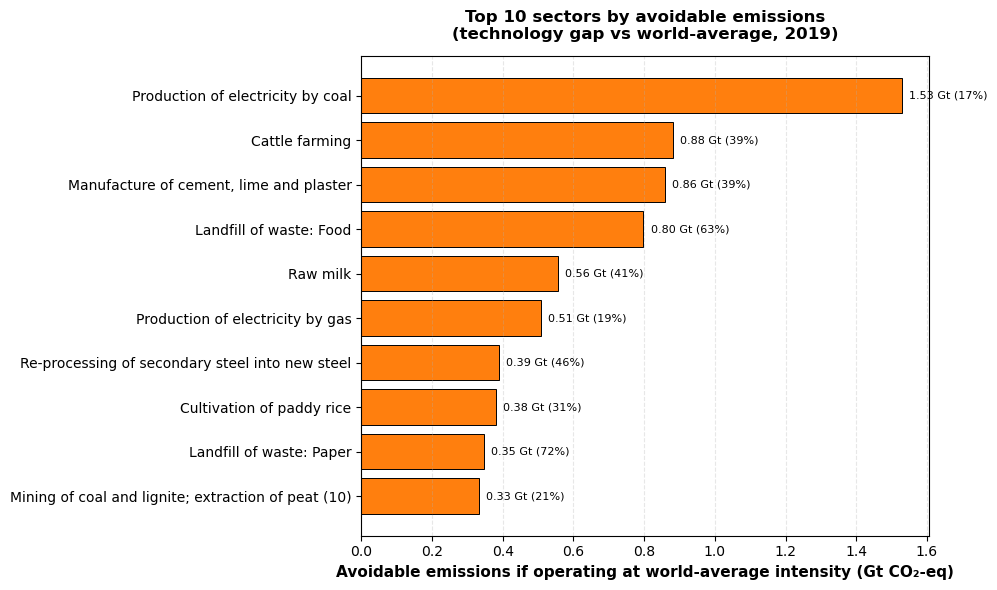


✓ Finished: global avoidable emissions + top-saving sectors.


In [17]:
# ===================================================================
# HOW MANY EMISSIONS COULD BE SAVED? (WORLD-AVERAGE TECHNOLOGY)
# AND WHICH SECTORS COULD SAVE THE MOST?
# ===================================================================

print("\n" + "="*70)
print(f"TECH-GAP ANALYSIS: Avoidable Emissions vs World-Average Technology ({SINGLE_YEAR})")
print("="*70)

# 1) Use existing function to compute excess (avoidable) emissions
excess_emissions, sector_gaps = calculate_tech_gap_penalty(
    ixi_data,
    producer_emissions,
    benchmark_mode="world_avg"   # you can also try "best" or "best_quartile"
)

# excess_emissions: Series indexed by (region, sector)
# sector_gaps: DataFrame with actual_intensity, benchmark_intensity, gap, excess_emissions, output

# 2) Global totals
total_actual = producer_emissions.sum()
total_excess = excess_emissions.sum()

saved_Gt = total_excess / 1e9
actual_Gt = total_actual / 1e9
share_pct = (total_excess / total_actual * 100) if total_actual > 0 else np.nan

print(f"\nGlobal actual producer emissions:   {actual_Gt:.2f} Gt CO₂-eq")
print(f"Global avoidable emissions (world-average tech): {saved_Gt:.2f} Gt CO₂-eq")
print(f"Share of emissions that could be avoided:        {share_pct:.1f}%")

# 3) Which sectors could save the most? (global sector ranking)
# Group excess emissions by *sector name* (2nd level of MultiIndex)
sector_excess = excess_emissions.groupby(
    level=1  # sector level in MultiIndex (region, sector)
).sum().sort_values(ascending=False)

# Also get total emissions per sector to compute relative shares
producer_series_by_sector = pd.Series(
    producer_emissions,
    index=ixi_data.x.index     # same MultiIndex (region, sector)
)
sector_total = producer_series_by_sector.groupby(level=1).sum()

sector_excess_Gt = (sector_excess / 1e9).rename("avoidable_Gt")
sector_total_Gt = (sector_total / 1e9).rename("total_Gt")

sector_summary = pd.concat([sector_total_Gt, sector_excess_Gt], axis=1)
sector_summary["avoidable_%"] = (
    sector_summary["avoidable_Gt"] / sector_summary["total_Gt"].replace(0, np.nan) * 100
)

# Drop sectors with zero total emissions to avoid NaNs
sector_summary = sector_summary.dropna(subset=["total_Gt"])

# Sort by *absolute* avoidable emissions
sector_summary_abs = sector_summary.sort_values("avoidable_Gt", ascending=False)

print("\nTop 15 sectors by avoidable emissions (absolute):")
print(
    sector_summary_abs.head(15)
    .round({"total_Gt": 2, "avoidable_Gt": 2, "avoidable_%": 1})
)

# Optional: sort by relative avoidable share
sector_summary_rel = sector_summary.sort_values("avoidable_%", ascending=False)

print("\nTop 15 sectors by share of avoidable emissions within the sector:")
print(
    sector_summary_rel.head(15)
    .round({"total_Gt": 2, "avoidable_Gt": 2, "avoidable_%": 1})
)

# 4) Simple bar plot: sectors with highest *absolute* avoidable emissions
TOP_SECTORS = 10
top_sectors_plot = sector_summary_abs.head(TOP_SECTORS)

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    top_sectors_plot.index,
    top_sectors_plot["avoidable_Gt"],
    color="#ff7f0e",
    edgecolor="black",
    linewidth=0.7
)

ax.invert_yaxis()  # biggest at top

ax.set_xlabel("Avoidable emissions if operating at world-average intensity (Gt CO₂-eq)",
              fontsize=11, fontweight="bold")
ax.set_title(
    f"Top {TOP_SECTORS} sectors by avoidable emissions\n"
    f"(technology gap vs world-average, {SINGLE_YEAR})",
    fontsize=12, fontweight="bold", pad=12
)

for i, (sector, row) in enumerate(top_sectors_plot.iterrows()):
    ax.text(
        row["avoidable_Gt"] + 0.02,
        i,
        f"{row['avoidable_Gt']:.2f} Gt ({row['avoidable_%']:.0f}%)",
        va="center",
        fontsize=8
    )

ax.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print("\n✓ Finished: global avoidable emissions + top-saving sectors.")



WINNERS & LOSERS: Redistribution Effect of Tech-Adjusted VABR (Option B)

Top winners (responsibility reduced):
CN   -3.37
US   -0.88
DE   -0.53
JP   -0.52
WL   -0.35
Name: Δ Responsibility (Gt), dtype: float64

Top losers (responsibility increased):
WA   0.61
IN   0.75
WM   0.86
WF   1.08
RU   3.41
Name: Δ Responsibility (Gt), dtype: float64


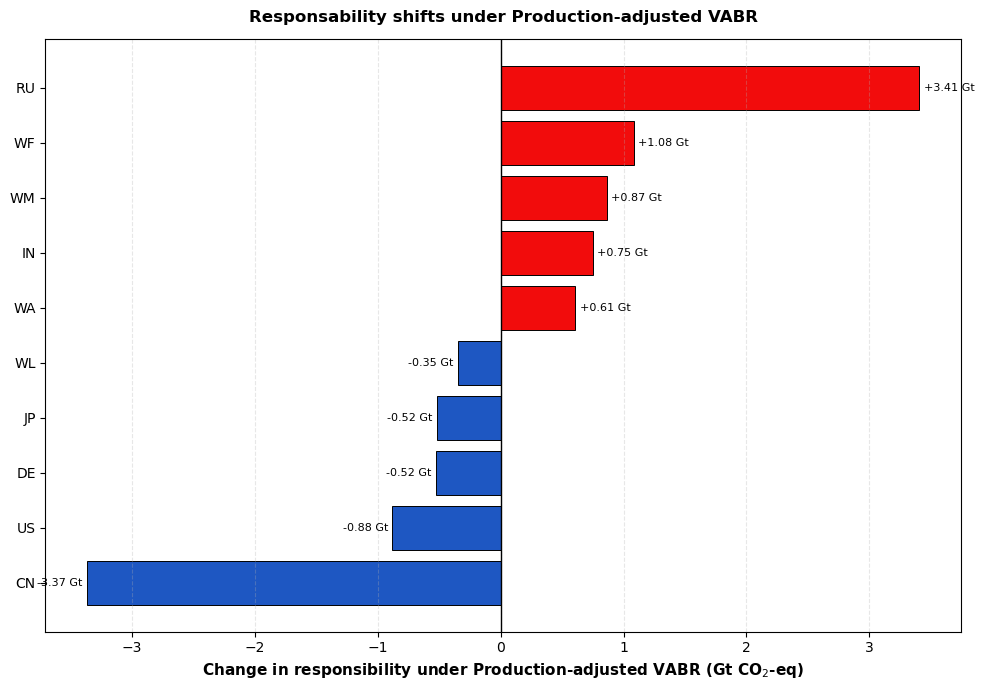


✓ Winners/losers bar chart created (redistribution effect of Option B).


In [15]:
# ===================================================================
# GEWINNER / VERLIERER PLOT: REDISTRIBUTION UNDER OPTION B
# ===================================================================

print("\n" + "="*70)
print("WINNERS & LOSERS: Redistribution Effect of Tech-Adjusted VABR (Option B)")
print("="*70)

# Delta: how much responsibility changes due to Option B (Gt CO2-eq)
delta_Gt = (vabr_techB_total - vabr_techB_vabr_part) / 1e9
delta_Gt.name = "Δ Responsibility (Gt)"

# Positive = bekommt MEHR Verantwortung (Verlierer)
# Negative = bekommt WENIGER Verantwortung (Gewinner)

# Anzahl Gewinner/Verlierer, die wir zeigen wollen
TOP_WINNERS = 5   # most negative deltas (biggest reductions)
TOP_LOSERS  = 5   # most positive deltas (biggest increases)

# Sort by change
delta_sorted = delta_Gt.sort_values()

winners = delta_sorted.head(TOP_WINNERS)   # most negative
losers  = delta_sorted.tail(TOP_LOSERS)   # most positive

# Kombinieren (Gewinner oben, Verlierer unten)
plot_series = pd.concat([winners, losers])

print("\nTop winners (responsibility reduced):")
print(winners.round(3))

print("\nTop losers (responsibility increased):")
print(losers.round(3))

# -------------------------------------------------------------------
# Diverging bar chart
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 7))

y_pos = np.arange(len(plot_series))

colors = [
    "#1e57c2" if v < 0 else "#f20c0c"
    for v in plot_series.values
]

ax.barh(
    y_pos,
    plot_series.values,
    color=colors,
    edgecolor="black",
    linewidth=0.7
)

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_series.index)

ax.axvline(0, color="black", linewidth=1)

ax.set_xlabel("Change in responsibility under Production-adjusted VABR (Gt CO$_2$-eq)",
              fontsize=11, fontweight="bold")
ax.set_title(
    "Responsability shifts under Production-adjusted VABR",
    fontsize=12, fontweight="bold",
    pad=12
)

# kleine Labels an Ende der Balken
for i, (country, val) in enumerate(plot_series.items()):
    align = "left" if val >= 0 else "right"
    offset = 0.01 * (plot_series.abs().max() + 0.1)
    ax.text(
        val + (offset if val >= 0 else -offset),
        i,
        f"{val:+.2f} Gt",
        va="center",
        ha=align,
        fontsize=8
    )

ax.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print("\n✓ Winners/losers bar chart created (redistribution effect of Option B).")


In [26]:
# ===================================================================
# TABLE: DOES TECH-ADJUSTMENT FIX THE EFFICIENCY BIAS?
# ===================================================================

print("\n" + "="*70)
print("EFFICIENCY BIAS TABLE: PBA vs VABR vs Trade- / Production-adjusted VABR")
print("="*70)

alpha = 1.0   # same alpha you used in calculate_vabr_with_tech_penalty

# 1) Producer emissions as Series on (country, sector)
producer_series_sector = pd.Series(
    producer_emissions,
    index=ixi_data.x.index,   # MultiIndex (region, sector)
    name="PBA"
)

# 2) Excess emissions (from Option B) per (country, sector)
#    sector_gaps comes from calculate_vabr_with_tech_penalty(...)
excess_emissions = sector_gaps["excess_emissions"]

# 3) Global scaling factor for Production-adjusted VABR (mass-conserving)
base_total = vabr_all.sum()                         # global VABR total
raw_total = base_total + alpha * excess_emissions.sum()
scale_factor = base_total / raw_total if raw_total > 0 else 1.0

print(f"Global base VABR total: {base_total/1e9:.2f} Gt")
print(f"Global raw VABR+penalty total: {raw_total/1e9:.2f} Gt")
print(f"Scaling factor (Production-adjusted): {scale_factor:.4f}")

# 4) CHOOSE COUNTRY–SECTOR PAIRS HERE 👇
rows_to_show = [
    ('RU', "Mining of coal and lignite; extraction of peat (10)"),
    ('CN', "Manufacture of basic iron and steel and of ferro-alloys and first products thereof"),
    ('AU', "Mining of coal and lignite; extraction of peat (10)"),
    ('WM', "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying"),
    ('IN', "Production of electricity by coal"),
    ("ZA" , "Production of electricity by coal"),
    # Beispiel: weitere Sektoren/Länder
    # ('US', "Other business activities (74)"),
    # ('DE', "Other business activities (74)"),
]

# 5) Build comparison table (ohne Ratios)
table_rows = []

for country, sector in rows_to_show:
    key = (country, sector)
    
    if key not in producer_series_sector.index:
        print(f"⚠ Warning: {key} not found in producer data, skipping.")
        continue
    
    # PBA (producer-based emissions)
    pba = producer_series_sector.loc[key]
    
    # Standard VABR at sector level (All VA)
    if country not in vabr_all_details or key not in vabr_all_details[country].index:
        print(f"⚠ Warning: {key} not found in VABR details, skipping.")
        continue
    vabr_sec = vabr_all_details[country].loc[key]
    
    # Trade-adjusted VABR at sector level
    if country not in vabr_techA_details or key not in vabr_techA_details[country].index:
        trade_sec = np.nan
    else:
        trade_sec = vabr_techA_details[country].loc[key]
    
    # Production-adjusted VABR at sector level (mass-conserving)
    excess_sec = excess_emissions.loc[key] if key in excess_emissions.index else 0.0
    prod_raw_sec = vabr_sec + alpha * excess_sec
    prod_adj_sec = prod_raw_sec * scale_factor
    
    # Zeile (alles in Mt CO₂-eq)
    row = {
        "country": country,
        "sector": sector,
        "PBA (Mt)":                 pba / 1e6,
        "VABR (Mt)":                vabr_sec / 1e6,
        "Trade-adjusted (Mt)":      trade_sec / 1e6 if not np.isnan(trade_sec) else np.nan,
        "Production-adjusted (Mt)": prod_adj_sec / 1e6,
    }

    table_rows.append(row)

# 6) DataFrame bauen
eff_bias_table = pd.DataFrame(table_rows).set_index(["country", "sector"])

# Schön runden
eff_bias_table_rounded = eff_bias_table.round(2)

print("\n=== Efficiency-bias comparison table ===")
print(eff_bias_table_rounded)



EFFICIENCY BIAS TABLE: PBA vs VABR vs Trade- / Production-adjusted VABR
Global base VABR total: 44.71 Gt
Global raw VABR+penalty total: 57.68 Gt
Scaling factor (Production-adjusted): 0.7751

=== Efficiency-bias comparison table ===
                                                            PBA (Mt)  \
country sector                                                         
RU      Mining of coal and lignite; extraction of peat ...     79.99   
CN      Manufacture of basic iron and steel and of ferr...   1234.84   
AU      Mining of coal and lignite; extraction of peat ...     39.75   
WM      Extraction of crude petroleum and services rela...    589.58   
IN      Production of electricity by coal                     952.99   
ZA      Production of electricity by coal                     241.83   

                                                            VABR (Mt)  \
country sector                                                          
RU      Mining of coal and lignite; extracti

In [139]:
# ============================================================
# KORRIGIERT: Efficiency Bias Table mit richtigem PCPR
# ============================================================

print("\n" + "="*70)
print("EFFICIENCY BIAS TABLE: PBA vs VABR vs Tech-adjusted vs PCPR")
print("="*70)

alpha = 1.0

# Producer emissions
producer_series_sector = pd.Series(
    producer_emissions,
    index=ixi_data.x.index,
    name="PBA"
)

# Excess emissions für Production-adjusted
excess_emissions = sector_gaps["excess_emissions"]

# Scaling factor
base_total = vabr_all.sum()
raw_total = base_total + alpha * excess_emissions.sum()
scale_factor = base_total / raw_total if raw_total > 0 else 1.0

# PCPR DOMESTIC: Wie viel bleibt beim Produzenten?
pcpr_domestic = (
    pcpr_flows[pcpr_flows['producing_region'] == pcpr_flows['beneficiary_region']]
    .groupby(["producing_region", "producing_sector"])["allocated_emissions"]
    .sum()
)

# Sektoren
rows_to_show = [
    ('RU', "Mining of coal and lignite; extraction of peat (10)"),
    ('CN', "Manufacture of basic iron and steel and of ferro-alloys and first products thereof"),
    ('AU', "Mining of coal and lignite; extraction of peat (10)"),
    ('WM', "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying"),
    ('IN', "Production of electricity by coal"),
    ("ZA", "Production of electricity by coal"),
]

# Tabelle bauen
table_rows = []

for country, sector in rows_to_show:
    key = (country, sector)
    
    if key not in producer_series_sector.index:
        print(f"Warning: {key} not found in producer data")
        continue
    
    # PBA
    pba = producer_series_sector.loc[key]
    
    # VABR
    if country not in vabr_all_details or key not in vabr_all_details[country].index:
        print(f"Warning: {key} not found in VABR details")
        continue
    vabr_sec = vabr_all_details[country].loc[key]
    
    # Trade-adjusted
    if country not in vabr_techA_details or key not in vabr_techA_details[country].index:
        trade_sec = np.nan
    else:
        trade_sec = vabr_techA_details[country].loc[key]
    
    # Production-adjusted
    excess_sec = excess_emissions.loc[key] if key in excess_emissions.index else 0.0
    prod_raw_sec = vabr_sec + alpha * excess_sec
    prod_adj_sec = prod_raw_sec * scale_factor

    # PCPR DOMESTIC (korrigiert!)
    if key in pcpr_domestic.index:
        pcpr_sec = pcpr_domestic.loc[key]
    else:
        pcpr_sec = 0.0

    row = {
        "Country": country,
        "Sector": sector[:40],
        "PBA (Mt)": pba / 1e6,
        "VABR (Mt)": vabr_sec / 1e6,
        "Trade-adj (Mt)": trade_sec / 1e6 if not np.isnan(trade_sec) else np.nan,
        "Prod-adj (Mt)": prod_adj_sec / 1e6,
        "PCPR domestic (Mt)": pcpr_sec / 1e6,
        "VABR/PBA (%)": (vabr_sec / pba * 100) if pba > 0 else np.nan,
        "Prod-adj/PBA (%)": (prod_adj_sec / pba * 100) if pba > 0 else np.nan,
        "PCPR/PBA (%)": (pcpr_sec / pba * 100) if pba > 0 else np.nan,
    }

    table_rows.append(row)

# DataFrame
eff_bias_table = pd.DataFrame(table_rows).set_index(["Country", "Sector"])
print("\n=== Corrected Efficiency-bias comparison table ===")
print(eff_bias_table.round(1).to_string())

# Key findings
print("\n=== KEY FINDINGS ===")
for _, row in pd.DataFrame(table_rows).iterrows():
    country = row['Country']
    vabr_pct = row['VABR/PBA (%)']
    prod_pct = row['Prod-adj/PBA (%)']
    pcpr_pct = row['PCPR/PBA (%)']
    
    print(f"\n{country} {row['Sector'][:25]}:")
    print(f"  VABR: {vabr_pct:.0f}% | Prod-adj: {prod_pct:.0f}% | PCPR domestic: {pcpr_pct:.0f}%")


EFFICIENCY BIAS TABLE: PBA vs VABR vs Tech-adjusted vs PCPR

=== Corrected Efficiency-bias comparison table ===
                                                  PBA (Mt)  VABR (Mt)  Trade-adj (Mt)  Prod-adj (Mt)  PCPR domestic (Mt)  VABR/PBA (%)  Prod-adj/PBA (%)  PCPR/PBA (%)
Country Sector                                                                                                                                                        
RU      Mining of coal and lignite; extraction o     80.00       1.60            1.60          42.40               26.30          2.00             53.00         32.80
CN      Manufacture of basic iron and steel and    1234.80     362.80          362.90         423.30             1052.90         29.40             34.30         85.30
AU      Mining of coal and lignite; extraction o     39.80      46.20           46.10          35.80               21.90        116.10             90.00         55.00
WM      Extraction of crude petroleum and servic    

In [55]:
# ===================================================================
# TABLE: VABR vs Trade-adjusted vs Production-adjusted
# Absolute Gt + % change in brackets
# ===================================================================

print("\n" + "="*70)
print("TABLE: VABR vs Trade- & Production-adjusted (Gt + Δ%)")
print("="*70)

# 1) Ensure EU is aggregated
comparison_df_eu = aggregate_region_in_df(
    comparison_df,
    group_name="EU",
    members=EU_COUNTRIES,
    drop_members=True
)

# 2) Countries and methods
countries_for_table = ['RU', 'WF', 'WM', 'IN', 'US', 'CN', 'EU']

baseline_col   = 'VABR (All VA)'
trade_col      = 'VABR (TechA)'
prod_col       = 'VABR (TechB+Penalty)'

# Filter to available countries
countries_available = [c for c in countries_for_table if c in comparison_df_eu.index]
if not countries_available:
    raise ValueError("None of the requested countries found in comparison_df_eu.index")

# Make sure all needed columns exist
for col in [baseline_col, trade_col, prod_col]:
    if col not in comparison_df_eu.columns:
        raise ValueError(f"Column '{col}' not found in comparison_df_eu.columns")

sub = comparison_df_eu.loc[countries_available, [baseline_col, trade_col, prod_col]]

# 3) Compute % changes relative to baseline
baseline = sub[baseline_col]

trade_abs = sub[trade_col]
prod_abs  = sub[prod_col]

trade_pct = (trade_abs - baseline) / baseline * 100
prod_pct  = (prod_abs  - baseline) / baseline * 100

# 4) Build pretty string columns like: "1.50 (+7%)"
def format_with_pct(abs_series, pct_series):
    formatted = []
    for a, p in zip(abs_series, pct_series):
        if pd.isna(a) or pd.isna(p) or a == 0:
            formatted.append("NA")
        else:
            formatted.append(f"{a:.2f} ({p:+.0f}%)")
    return formatted

table_df = pd.DataFrame(index=countries_available)
table_df["VABR (Gt)"] = baseline.round(2)
table_df["Trade-adj. VABR (Gt, Δ%)"] = format_with_pct(trade_abs, trade_pct)
table_df["Prod-adj. VABR (Gt, Δ%)"]  = format_with_pct(prod_abs,  prod_pct)

print("\nResult table:")
print(table_df.to_string())

# If you want it as a normal numeric table as well (for export), you can also do:
numeric_df = pd.DataFrame({
    "VABR (Gt)": baseline,
    "Trade-adj. VABR (Gt)": trade_abs,
    "Trade-adj. Δ%": trade_pct,
    "Prod-adj. VABR (Gt)": prod_abs,
    "Prod-adj. Δ%": prod_pct
}).loc[countries_available]

print("\nNumeric version (for Excel export etc.):")
print(numeric_df.round(3))



TABLE: VABR vs Trade- & Production-adjusted (Gt + Δ%)

Result table:
    VABR (Gt) Trade-adj. VABR (Gt, Δ%) Prod-adj. VABR (Gt, Δ%)
RU       1.50               1.59 (+6%)            4.91 (+227%)
WF       1.89              2.08 (+10%)             2.97 (+57%)
WM       2.46              2.81 (+14%)             3.33 (+35%)
IN       2.89               3.00 (+4%)             3.65 (+26%)
US       6.53               6.38 (-2%)             5.65 (-13%)
CN      11.49              11.35 (-1%)             8.12 (-29%)
EU       5.60               5.15 (-8%)             3.54 (-37%)

Numeric version (for Excel export etc.):
    VABR (Gt)  Trade-adj. VABR (Gt)  Trade-adj. Δ%  Prod-adj. VABR (Gt)  \
RU       1.50                  1.59           6.33                 4.91   
WF       1.89                  2.08           9.65                 2.97   
WM       2.46                  2.81          13.95                 3.33   
IN       2.90                  3.00           3.69                 3.65   
US       

In [140]:
# ============================================================
# SIMPLE TABLE: PBA vs PCPR domestic
# ============================================================

import pandas as pd
import numpy as np

# Producer emissions
producer_series_sector = pd.Series(
    producer_emissions,
    index=ixi_data.x.index,
    name="PBA"
)

# PCPR domestic
pcpr_domestic = (
    pcpr_flows[pcpr_flows['producing_region'] == pcpr_flows['beneficiary_region']]
    .groupby(["producing_region", "producing_sector"])["allocated_emissions"]
    .sum()
)

# Sektoren
rows_to_show = [
    ('RU', "Mining of coal and lignite; extraction of peat (10)"),
    ('AU', "Mining of coal and lignite; extraction of peat (10)"),
    ('WM', "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying"),
    ('IN', "Production of electricity by coal"),
    ("ZA", "Production of electricity by coal"),
    ('CN', "Manufacture of basic iron and steel and of ferro-alloys and first products thereof"),
]

# Tabelle bauen
table_rows = []

for country, sector in rows_to_show:
    key = (country, sector)
    
    if key not in producer_series_sector.index:
        continue
    
    pba = producer_series_sector.loc[key]
    pcpr = pcpr_domestic.loc[key] if key in pcpr_domestic.index else 0.0
    
    table_rows.append({
        "Country": country,
        "Sector": sector[:35],
        "PBA (Mt)": round(pba / 1e6, 0),
        "PCPR domestic (Mt)": round(pcpr / 1e6, 0),
        "PCPR/PBA (%)": round(pcpr / pba * 100, 0) if pba > 0 else 0,
    })

# DataFrame
simple_table = pd.DataFrame(table_rows)

print("\n" + "="*70)
print("PBA vs PCPR: How much responsibility stays with the producer?")
print("="*70)
print(simple_table.to_string(index=False))

# Für Word
print("\n--- TABLE FOR WORD ---")
print("Country\tSector\tPBA (Mt)\tPCPR domestic (Mt)\tPCPR/PBA (%)")
for _, row in simple_table.iterrows():
    print(f"{row['Country']}\t{row['Sector'][:25]}\t{row['PBA (Mt)']:.0f}\t{row['PCPR domestic (Mt)']:.0f}\t{row['PCPR/PBA (%)']:.0f}%")


PBA vs PCPR: How much responsibility stays with the producer?
Country                              Sector  PBA (Mt)  PCPR domestic (Mt)  PCPR/PBA (%)
     RU Mining of coal and lignite; extract     80.00               26.00         33.00
     AU Mining of coal and lignite; extract     40.00               22.00         55.00
     WM Extraction of crude petroleum and s    590.00              397.00         67.00
     IN   Production of electricity by coal    953.00              836.00         88.00
     ZA   Production of electricity by coal    242.00              193.00         80.00
     CN Manufacture of basic iron and steel   1235.00             1053.00         85.00

--- TABLE FOR WORD ---
Country	Sector	PBA (Mt)	PCPR domestic (Mt)	PCPR/PBA (%)
RU	Mining of coal and lignit	80	26	33%
AU	Mining of coal and lignit	40	22	55%
WM	Extraction of crude petro	590	397	67%
IN	Production of electricity	953	836	88%
ZA	Production of electricity	242	193	80%
CN	Manufacture of basic iron	1235	1053	8

In [142]:
# Check: Ist PCPR mass-conserving?
for country, sector in rows_to_show:
    key = (country, sector)
    
    # PBA
    pba = producer_series_sector.loc[key]
    
    # PCPR total (alle Empfänger)
    mask = (pcpr_flows['producing_region'] == country) & \
           (pcpr_flows['producing_sector'] == sector)
    pcpr_total = pcpr_flows[mask]['allocated_emissions'].sum()
    
    # PCPR domestic
    mask_domestic = mask & (pcpr_flows['beneficiary_region'] == country)
    pcpr_dom = pcpr_flows[mask_domestic]['allocated_emissions'].sum()
    
    # PCPR foreign
    pcpr_foreign = pcpr_total - pcpr_dom
    
    print(f"{country} {sector[:25]}:")
    print(f"  PBA: {pba/1e6:.1f} Mt")
    print(f"  PCPR total: {pcpr_total/1e6:.1f} Mt")
    print(f"  PCPR domestic: {pcpr_dom/1e6:.1f} Mt ({pcpr_dom/pba*100:.0f}%)")
    print(f"  PCPR foreign: {pcpr_foreign/1e6:.1f} Mt ({pcpr_foreign/pba*100:.0f}%)")
    print()


RU Mining of coal and lignit:
  PBA: 80.0 Mt
  PCPR total: 79.4 Mt
  PCPR domestic: 26.3 Mt (33%)
  PCPR foreign: 53.1 Mt (66%)

AU Mining of coal and lignit:
  PBA: 39.8 Mt
  PCPR total: 39.2 Mt
  PCPR domestic: 21.9 Mt (55%)
  PCPR foreign: 17.4 Mt (44%)

WM Extraction of crude petro:
  PBA: 589.6 Mt
  PCPR total: 589.1 Mt
  PCPR domestic: 396.6 Mt (67%)
  PCPR foreign: 192.5 Mt (33%)

IN Production of electricity:
  PBA: 953.0 Mt
  PCPR total: 952.5 Mt
  PCPR domestic: 835.5 Mt (88%)
  PCPR foreign: 117.0 Mt (12%)

ZA Production of electricity:
  PBA: 241.8 Mt
  PCPR total: 241.2 Mt
  PCPR domestic: 192.7 Mt (80%)
  PCPR foreign: 48.5 Mt (20%)

CN Manufacture of basic iron:
  PBA: 1234.8 Mt
  PCPR total: 1234.4 Mt
  PCPR domestic: 1052.9 Mt (85%)
  PCPR foreign: 181.6 Mt (15%)



PCBR METHOD ANALYSIS

In [30]:
import numpy as np
import pandas as pd

# ================================================================
# PARAMETERS: choose producers and destination breakdown
# ================================================================

# Producers you want rows for (you can change this)
producers_for_table = ['WM', 'RU', 'AU', 'EU', 'US', 'IN']  # WM = Middle East, etc.

# Destination regions of special interest (all others go to "Other")
destinations_of_interest = ['WM', 'RU', 'AU', 'EU', 'US', 'IN']

# Fossil supply-chain sectors: Coal + Oil + Gas
fossil_categories = ['Coal', 'Oil', 'Gas']
fossil_sectors = [
    s for cat in fossil_categories
    for s in sector_classification[cat]
]

print("Number of fossil sectors used:", len(fossil_sectors))

# ================================================================
# HELPER: build fossil-only producer emissions for one producer region
# ================================================================
def build_fossil_emissions_for_producer(producer_code):
    """
    Create a producer_emissions vector that only contains emissions from
    fossil sectors located in the chosen producer region (or EU group).

    Returns:
      fossil_emissions : np.array (same shape as producer_emissions)
    """
    idx = ixi_data.x.index  # MultiIndex (region, sector)
    regions = idx.get_level_values(0)
    sectors = idx.get_level_values(1)
    
    # Start with all zeros
    fossil_emissions = np.zeros_like(producer_emissions, dtype=float)
    
    # Mask for fossil sectors
    mask_fossil = sectors.isin(fossil_sectors)
    
    if producer_code == "EU":
        # All fossil sectors in EU member countries
        mask_region = regions.isin(EU_COUNTRIES)
    else:
        mask_region = (regions == producer_code)
    
    mask = mask_fossil & mask_region
    
    if not mask.any():
        print(f"⚠ No fossil sectors found for producer {producer_code}.")
        return fossil_emissions
    
    fossil_emissions[mask] = producer_emissions[mask]
    print(f"{producer_code}: fossil emissions (t) used in PC-PR = {fossil_emissions.sum():.3e}")
    return fossil_emissions

# ================================================================
# MAIN LOOP: run PCPR for each producer and build the share table
# ================================================================
rows = []

for prod in producers_for_table:
    print(f"\n=== Tracing fossil-fuel profits for producer {prod} ===")
    
    # 1) Build fossil-only producer emission vector for this producer
    fossil_em = build_fossil_emissions_for_producer(prod)
    
    if fossil_em.sum() == 0:
        print(f"  → Skipping {prod}, no fossil emissions in selected sectors.")
        continue
    
    # 2) Run Producer-Centric Profit Responsibility (PCPR)
    #    ✅ use the correct argument name: producer_emissions
    pcpr_totals, pcpr_details = calculate_pcpr(
        ixi_data,
        producer_emissions=fossil_em,
        profit_components=PROFIT_COMPONENTS,
        method='inverse'
    )
    
    # 3) Aggregate EU as destination (so EU is one column)
    pcpr_totals_eu = aggregate_region_in_series(
        pcpr_totals,
        group_name="EU",
        members=EU_COUNTRIES,
        drop_members=True
    )
    
    total_resp = pcpr_totals_eu.sum()
    if total_resp <= 0:
        print(f"  → {prod}: PCPR sum is zero, skipping.")
        continue
    
    # 4) Shares for specific destinations
    # "Stays domestic" = responsibility captured in the producer region itself
    if prod == "EU":
        stays_domestic = pcpr_totals_eu.get("EU", 0.0)
        # For an EU producer, we don't double-count EU again as separate "destination"
        to_eu = 0.0
    else:
        stays_domestic = pcpr_totals_eu.get(prod, 0.0)
        to_eu = pcpr_totals_eu.get("EU", 0.0)
    
    to_us = pcpr_totals_eu.get("US", 0.0)
    to_cn = pcpr_totals_eu.get("CN", 0.0)
    
    # 5) "Other" = all remaining regions not in domestic/US/EU/CN
    explicit_targets = {prod, "US", "EU", "CN"}
    mask_other = ~pcpr_totals_eu.index.isin(explicit_targets)
    other = pcpr_totals_eu[mask_other].sum()
    
    # 6) Convert to percentages of total
    stays_pct = 100.0 * stays_domestic / total_resp
    us_pct    = 100.0 * to_us / total_resp
    eu_pct    = 100.0 * to_eu / total_resp
    cn_pct    = 100.0 * to_cn / total_resp
    other_pct = 100.0 * other / total_resp
    
    rows.append({
        "Producer": prod,
        "Stays domestic (%)": stays_pct,
        "Goes to US (%)":     us_pct,
        "Goes to EU (%)":     eu_pct,
        "Goes to China (%)":  cn_pct,
        "Other (%)":          other_pct
    })

# Build and show the final table
fossil_profit_flows = pd.DataFrame(rows).set_index("Producer")
fossil_profit_flows_rounded = fossil_profit_flows.round(1)

print("\n=== Fossil-fuel profit responsibility shares (PCPR-based) ===")
print(fossil_profit_flows_rounded)


Number of fossil sectors used: 12

=== Tracing fossil-fuel profits for producer WM ===
WM: fossil emissions (t) used in PC-PR = 1.661e+09

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 1.661 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.0 B€
Profit coefficients: mean=0.100
Computing D = (I - S)^(-1)...
  Condition number: 1.25e+01
FD flows: direct=0.200, total=0.515 (ratio: 2.57x)
Per-producer allocation...
  Producers processed: 12
  Zero profit capture: 0
Conservation: 1.6605 Gt (error: 0.000000%)

Top 5 countries:
  WM: 1.240 Gt (0.75x)
  CN: 0.135 Gt (infx)
  IN: 0.045 Gt (infx)
  JP: 0.041 Gt (infx)
  WA: 0.034 Gt (infx)


c:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\functions.py:1329: RuntimeWarning: divide by zero encountered in scalar divide
  mult = value / producer_emissions[ixi_data.x.index.get_level_values(0) == country].sum()



=== Tracing fossil-fuel profits for producer RU ===
RU: fossil emissions (t) used in PC-PR = 9.694e+08

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 0.969 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.0 B€
Profit coefficients: mean=0.100
Computing D = (I - S)^(-1)...
  Condition number: 1.25e+01
FD flows: direct=0.200, total=0.515 (ratio: 2.57x)
Per-producer allocation...
  Producers processed: 11
  Zero profit capture: 0
Conservation: 0.9694 Gt (error: 0.000000%)

Top 5 countries:
  RU: 0.730 Gt (0.75x)
  CN: 0.066 Gt (infx)
  WA: 0.016 Gt (infx)
  US: 0.013 Gt (infx)
  TR: 0.012 Gt (infx)


c:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\functions.py:1329: RuntimeWarning: divide by zero encountered in scalar divide
  mult = value / producer_emissions[ixi_data.x.index.get_level_values(0) == country].sum()



=== Tracing fossil-fuel profits for producer AU ===
AU: fossil emissions (t) used in PC-PR = 2.807e+08

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 0.281 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.0 B€
Profit coefficients: mean=0.100
Computing D = (I - S)^(-1)...
  Condition number: 1.25e+01
FD flows: direct=0.200, total=0.515 (ratio: 2.57x)
Per-producer allocation...
  Producers processed: 11
  Zero profit capture: 0
Conservation: 0.2807 Gt (error: 0.000000%)

Top 5 countries:
  AU: 0.231 Gt (0.82x)
  CN: 0.018 Gt (infx)
  IN: 0.007 Gt (infx)
  WA: 0.006 Gt (infx)
  JP: 0.004 Gt (infx)


c:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\functions.py:1329: RuntimeWarning: divide by zero encountered in scalar divide
  mult = value / producer_emissions[ixi_data.x.index.get_level_values(0) == country].sum()



=== Tracing fossil-fuel profits for producer EU ===
EU: fossil emissions (t) used in PC-PR = 1.033e+09

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 1.033 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.0 B€
Profit coefficients: mean=0.100
Computing D = (I - S)^(-1)...
  Condition number: 1.25e+01
FD flows: direct=0.200, total=0.515 (ratio: 2.57x)
Per-producer allocation...
  Producers processed: 322
  Zero profit capture: 35
Conservation: 1.0330 Gt (error: 0.000000%)

Top 5 countries:
  DE: 0.191 Gt (0.92x)
  PL: 0.117 Gt (0.89x)
  IT: 0.102 Gt (0.95x)
  GB: 0.093 Gt (0.90x)
  ES: 0.068 Gt (0.85x)

=== Tracing fossil-fuel profits for producer US ===
US: fossil emissions (t) used in PC-PR = 2.455e+09

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 2.455 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=

c:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\functions.py:1329: RuntimeWarning: divide by zero encountered in scalar divide
  mult = value / producer_emissions[ixi_data.x.index.get_level_values(0) == country].sum()



=== Tracing fossil-fuel profits for producer IN ===
IN: fossil emissions (t) used in PC-PR = 1.200e+09

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 1.200 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.0 B€
Profit coefficients: mean=0.100
Computing D = (I - S)^(-1)...
  Condition number: 1.25e+01
FD flows: direct=0.200, total=0.515 (ratio: 2.57x)
Per-producer allocation...
  Producers processed: 11
  Zero profit capture: 0
Conservation: 1.2001 Gt (error: 0.000000%)

Top 5 countries:
  IN: 1.044 Gt (0.87x)
  WA: 0.037 Gt (infx)
  WM: 0.025 Gt (infx)
  CN: 0.019 Gt (infx)
  US: 0.013 Gt (infx)


c:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\functions.py:1329: RuntimeWarning: divide by zero encountered in scalar divide
  mult = value / producer_emissions[ixi_data.x.index.get_level_values(0) == country].sum()



=== Fossil-fuel profit responsibility shares (PCPR-based) ===
          Stays domestic (%)  Goes to US (%)  Goes to EU (%)  \
Producer                                                       
WM                     74.70            1.90            2.50   
RU                     75.30            1.40            7.00   
AU                     82.50            0.60            1.10   
EU                     88.60            1.60            0.00   
US                     90.20           90.20            1.60   
IN                     87.00            1.00            1.90   

          Goes to China (%)  Other (%)  
Producer                                
WM                     8.10      12.80  
RU                     6.90       9.50  
AU                     6.30       9.60  
EU                     1.70       8.10  
US                     1.00       7.20  
IN                     1.60       8.40  



=== PLOT: VABR (Profit) vs PCPR (Profit) by sector group ===


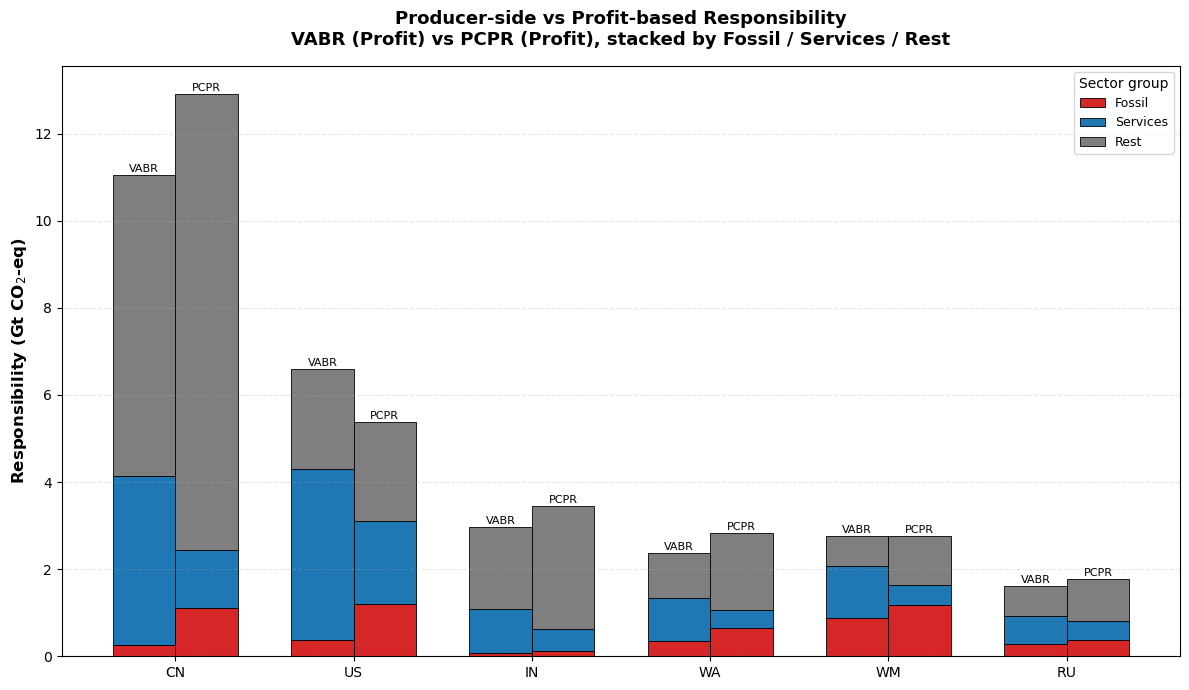

✓ VABR (Profit) vs PCPR (Profit) stacked bar chart created.


In [56]:
# ===================================================================
# PC(P)R vs VABR (Profit) – Stacked by Fossil / Services / Rest
# ===================================================================

print("\n=== PLOT: VABR (Profit) vs PCPR (Profit) by sector group ===")

# 1. Countries to show (adjust to your EXIOBASE region codes)
focus_countries = ["CN", "US", "IN", "EU", "WA", "WM", "RU"]  # <- adjust if needed

# 2. Define which categories count as "Fossil" and "Services"
fossil_categories = [
    "Coal",
    "Oil",
    "Gas",
    "Energy & Utilities Infrastructure",
]

service_categories = [
    "Services",
]

segments = ["Fossil", "Services", "Rest"]

# 3. Methods & their sector-level detail dicts
methods = {
    "VABR (Profit)": vabr_profit_details,   # dict[country] -> Series((region,sector) -> t CO2-eq)
    "PCPR (Profit)": pcpr_details,          # dict[country] -> Series((region,sector) -> t CO2-eq)
}

# 4. Aggregate responsibility into Fossil / Services / Rest
results = {
    method_name: {
        country: {seg: 0.0 for seg in segments}
        for country in focus_countries
    }
    for method_name in methods
}

for method_name, detail_dict in methods.items():
    for country in focus_countries:
        if country not in detail_dict:
            print(f"Warning: {country} not in {method_name} details.")
            continue
        
        series = detail_dict[country]  # Series indexed by (region, sector)
        
        for (region, sector), value in series.items():
            if value == 0:
                continue
            
            base_cat = category_of(sector)  # from your sector classification
            
            if base_cat in fossil_categories:
                seg = "Fossil"
            elif base_cat in service_categories:
                seg = "Services"
            else:
                seg = "Rest"
            
            results[method_name][country][seg] += value

# 5. Convert to Gt CO2-eq for plotting
unit_div = 1e9
unit_label = "Gt CO$_2$-eq"

countries = [c for c in focus_countries if c in vabr_profit.index]  # just in case
x = np.arange(len(countries))
width = 0.35  # bar width per method

colors = {
    "Fossil":   "#d62728",  # red
    "Services": "#1f77b4",  # blue
    "Rest":     "#7f7f7f",  # grey
}

fig, ax = plt.subplots(figsize=(12, 7))

# 6. Plot each method as stacked bars, side-by-side
for i, method_name in enumerate(methods.keys()):
    # left/right shift: VABR = left, PCPR = right
    x_pos = x + (i - 0.5) * width  
    
    bottoms = np.zeros(len(countries))
    for seg in segments:
        heights = np.array([
            results[method_name][country][seg] / unit_div
            for country in countries
        ])
        
        ax.bar(
            x_pos,
            heights,
            width,
            bottom=bottoms,
            label=seg if i == 0 else None,   # legend only once for segments
            color=colors[seg],
            edgecolor="black",
            linewidth=0.6,
        )
        bottoms += heights
    
    # optional: method labels above bars (small text)
    for j, country in enumerate(countries):
        total_height = bottoms[j]
        ax.text(
            x_pos[j],
            total_height + 0.02,
            "VABR" if method_name.startswith("VABR") else "PCPR",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=0,
        )

# 7. Formatting
ax.set_title(
    "Producer-side vs Profit-based Responsibility\n"
    "VABR (Profit) vs PCPR (Profit), stacked by Fossil / Services / Rest",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
ax.set_ylabel(f"Responsibility ({unit_label})", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(countries, fontsize=10)

# Legend: only sector groups
ax.legend(
    title="Sector group",
    fontsize=9,
    title_fontsize=10,
    loc="upper right",
)

ax.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

print("✓ VABR (Profit) vs PCPR (Profit) stacked bar chart created.")



=== PLOT: Producer vs VABR (Profit) vs PCPR (Profit) by sector group ===


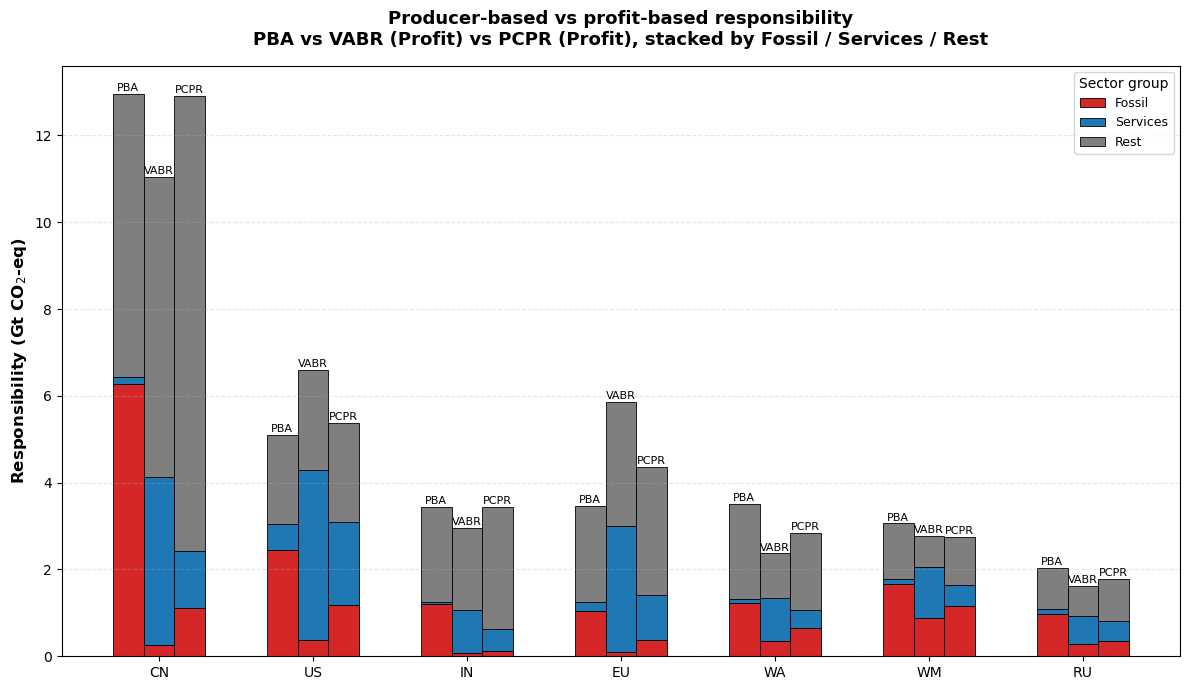

✓ Producer vs VABR (Profit) vs PCPR (Profit) stacked bar chart created.


In [58]:
# ===================================================================
# PC(P)R vs VABR (Profit) vs PRODUCER – Stacked by Fossil / Services / Rest
# ===================================================================

print("\n=== PLOT: Producer vs VABR (Profit) vs PCPR (Profit) by sector group ===")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Countries to show (adjust to your EXIOBASE region codes)
focus_countries = ["CN", "US", "IN", "EU", "WA", "WM", "RU"]

# 2. Define which categories count as "Fossil" and "Services"
fossil_categories = [
    "Coal",
    "Oil",
    "Gas",
    "Energy & Utilities Infrastructure",
]

service_categories = [
    "Services",
]

segments = ["Fossil", "Services", "Rest"]

# -------------------------------------------------------------------
# 3. Build PRODUCER details in same structure as vabr_profit_details
# -------------------------------------------------------------------

producer_series_sr = pd.Series(producer_emissions, index=ixi_data.x.index)
producer_details = {}

for country in focus_countries:
    if country == "EU":
        # Aggregate all EU member regions
        eu_mask = producer_series_sr.index.get_level_values(0).isin(EU_COUNTRIES)
        producer_details[country] = producer_series_sr[eu_mask]
    else:
        mask = producer_series_sr.index.get_level_values(0) == country
        producer_details[country] = producer_series_sr[mask]

# 4. Methods & their sector-level detail dicts
methods = {
    "Producer":      producer_details,   # dict[country] -> Series((region,sector) -> t CO2-eq)
    "VABR (Profit)": vabr_profit_details,
    "PCPR (Profit)": pcpr_details,
}

# -------------------------------------------------------------------
# 5. Aggregate responsibility into Fossil / Services / Rest
# -------------------------------------------------------------------

results = {
    method_name: {
        country: {seg: 0.0 for seg in segments}
        for country in focus_countries
    }
    for method_name in methods
}

for method_name, detail_dict in methods.items():
    for country in focus_countries:

        # ---- EU aggregation for VABR / PCPR ----
        if country == "EU" and method_name != "Producer":
            member_series = []
            for reg in EU_COUNTRIES:
                if reg in detail_dict:
                    member_series.append(detail_dict[reg])
            if not member_series:
                print(f"Warning: no EU members found in {method_name} details.")
                continue
            series = pd.concat(member_series)
        else:
            if country not in detail_dict:
                print(f"Warning: {country} not in {method_name} details.")
                continue
            series = detail_dict[country]

        # Iterate over sectors and map to Fossil / Services / Rest
        for idx, value in series.items():
            if value == 0:
                continue

            # idx can be ('DE','Production of electricity…') or just 'Production of electricity…'
            if isinstance(idx, tuple) and len(idx) >= 2:
                region, sector = idx[0], idx[1]
            else:
                sector = idx

            base_cat = category_of(sector)

            if base_cat in fossil_categories:
                seg = "Fossil"
            elif base_cat in service_categories:
                seg = "Services"
            else:
                seg = "Rest"

            results[method_name][country][seg] += float(value)

# -------------------------------------------------------------------
# 6. Convert to Gt CO2-eq for plotting
# -------------------------------------------------------------------

unit_div = 1e9
unit_label = "Gt CO$_2$-eq"

# keep only countries that actually have some non-zero total
countries = []
for c in focus_countries:
    total_c = 0.0
    for m in methods:
        for seg in segments:
            total_c += results[m][c][seg]
    if total_c > 0:
        countries.append(c)

x = np.arange(len(countries))
n_methods = len(methods)

# thinner bars
width = 0.6 / n_methods  

colors = {
    "Fossil":   "#d62728",  # red
    "Services": "#1f77b4",  # blue
    "Rest":     "#7f7f7f",  # grey
}

method_short = {
    "Producer":      "PBA",
    "VABR (Profit)": "VABR",
    "PCPR (Profit)": "PCPR",
}

fig, ax = plt.subplots(figsize=(12, 7))

# -------------------------------------------------------------------
# 7. Plot each method as stacked bars, side-by-side
# -------------------------------------------------------------------

for i, method_name in enumerate(methods.keys()):
    # symmetric offsets around x
    x_pos = x + (i - (n_methods - 1) / 2) * width  

    bottoms = np.zeros(len(countries))
    for seg in segments:
        heights = np.array([
            results[method_name][country][seg] / unit_div
            for country in countries
        ])
        
        ax.bar(
            x_pos,
            heights,
            width,
            bottom=bottoms,
            label=seg if i == 0 else None,   # legend only once for segments
            color=colors[seg],
            edgecolor="black",
            linewidth=0.6,
        )
        bottoms += heights
    
    # small method label above stacked bar
    for j, country in enumerate(countries):
        total_height = bottoms[j]
        ax.text(
            x_pos[j],
            total_height + 0.02,
            method_short.get(method_name, method_name),
            ha="center",
            va="bottom",
            fontsize=8,
        )

# -------------------------------------------------------------------
# 8. Formatting
# -------------------------------------------------------------------

ax.set_title(
    "Producer-based vs profit-based responsibility\n"
    "PBA vs VABR (Profit) vs PCPR (Profit), stacked by Fossil / Services / Rest",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
ax.set_ylabel(f"Responsibility ({unit_label})", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(countries, fontsize=10)

ax.legend(
    title="Sector group",
    fontsize=9,
    title_fontsize=10,
    loc="upper right",
)

ax.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

print("✓ Producer vs VABR (Profit) vs PCPR (Profit) stacked bar chart created.")



=== PLOT: PBA vs VABR (Profit) vs PCPR (Profit) by sector supergroups ===
Countries in plot: ['CN', 'US', 'IN', 'EU', 'WA', 'WM', 'RU']


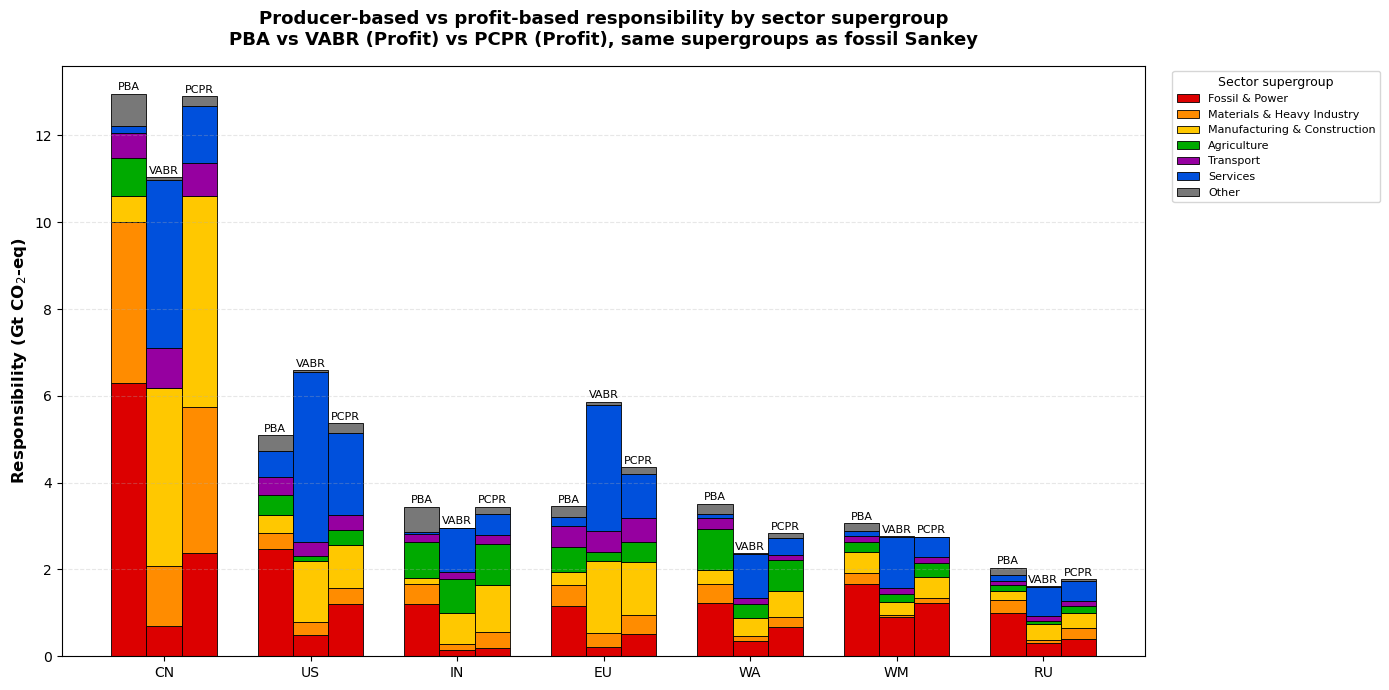

✓ PBA vs VABR (Profit) vs PCPR (Profit) stacked bar chart created (same supergroups & colors as Sankey).


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===================================================================
# PLOT: PBA vs VABR (Profit) vs PCPR (Profit) – stacked by sector supergroups
# using the same supergroups + colors as the fossil Sankey
# ===================================================================

print("\n=== PLOT: PBA vs VABR (Profit) vs PCPR (Profit) by sector supergroups ===")

EU_CODE = "EU"

# ---------------------------------------------------------------
# 0) Make sure EU exists in the VABR / PCPR detail dicts
# ---------------------------------------------------------------
for method_dict_name, method_dict in [("VABR", vabr_profit_details), ("PCPR", pcpr_details)]:
    if EU_CODE not in method_dict:
        member_series = []
        for r in EU_COUNTRIES:   # list like ['AT','BE',...]
            if r in method_dict:
                member_series.append(method_dict[r])
        if member_series:
            eu_series = pd.concat(member_series).groupby(level=[0, 1]).sum()
            method_dict[EU_CODE] = eu_series
        else:
            print(f"⚠ No EU members found in {method_dict_name} detail dict for aggregation.")

# ---------------------------------------------------------------
# 1) Countries to show
# ---------------------------------------------------------------
focus_countries = ["CN", "US", "IN", "EU", "WA", "WM", "RU"]

# Only keep countries that actually exist in BOTH VABR + PCPR
available_countries = [
    c for c in focus_countries
    if (c in vabr_profit_details) and (c in pcpr_details)
]

if len(available_countries) == 0:
    raise ValueError("No overlapping countries in vabr_profit_details and pcpr_details.")

print("Countries in plot:", available_countries)

# ---------------------------------------------------------------
# 2) Supergroup mapping (same logic as in Sankey)
# ---------------------------------------------------------------
def map_to_supergroup(sector_name: str) -> str:
    """
    Map EXIO sector name -> base category (category_of) -> compact supergroup.

    Supergroups:
      - Fossil & Power
      - Materials & Heavy Industry
      - Manufacturing & Construction
      - Agriculture
      - Transport
      - Services
      - Other
    """
    raw_cat = category_of(sector_name)   # your existing helper

    # 1) Fossil & Power
    if raw_cat in [
        "Coal", "Oil", "Gas",
        "Energy & Utilities Infrastructure",
        "Electricity & Heat Infrastructure"
    ]:
        return "Fossil & Power"

    # 2) Materials & Heavy Industry
    if raw_cat in [
        "Metals",
        "Non-metallic Minerals",
        "Chemicals & Plastics"
    ]:
        return "Materials & Heavy Industry"

    # 3) Manufacturing & Construction
    if raw_cat in [
        "Manufacturing (Food & Beverages)",
        "Manufacturing (Textiles, Leather & Wood)",
        "Manufacturing (Machinery & Equipment)",
        "Construction",
        "Trade",
        "Construction & Trade"
    ]:
        return "Manufacturing & Construction"

    # 4) Agriculture
    if raw_cat == "Agriculture":
        return "Agriculture"

    # 5) Transport
    if raw_cat == "Transport":
        return "Transport"

    # 6) Services
    if raw_cat in ["Services", "Finance & Business Services", "Public Services"]:
        return "Services"

    # 7) Everything else (incl. Renewables, Waste, etc.)
    return "Other"


supergroups_order = [
    "Fossil & Power",
    "Materials & Heavy Industry",
    "Manufacturing & Construction",
    "Agriculture",
    "Transport",
    "Services",
    "Other",
]

# ---------------------------------------------------------------
# 3) Build PBA (producer emissions) by country & supergroup
# ---------------------------------------------------------------
producer_series_sr = pd.Series(producer_emissions, index=ixi_data.x.index)  # (region, sector)

pba_results = {country: {sg: 0.0 for sg in supergroups_order} for country in available_countries}

for (region, sector), value in producer_series_sr.items():
    # Map EU members to "EU", keep others as their own region code
    if region in EU_COUNTRIES:
        country = "EU"
    else:
        country = region

    if country not in pba_results:
        continue  # we only track selected focus countries

    sg = map_to_supergroup(sector)
    if sg not in pba_results[country]:
        pba_results[country][sg] = 0.0
    pba_results[country][sg] += value

# ---------------------------------------------------------------
# 4) Build VABR (Profit) & PCPR (Profit) by country & supergroup
# ---------------------------------------------------------------
methods_detail = {
    "VABR (Profit)": vabr_profit_details,   # dict[country] -> Series((region,sector) -> t CO2-eq)
    "PCPR (Profit)": pcpr_details,
}

resp_results = {
    method_name: {
        country: {sg: 0.0 for sg in supergroups_order}
        for country in available_countries
    }
    for method_name in methods_detail
}

for method_name, detail_dict in methods_detail.items():
    for country in available_countries:
        if country not in detail_dict:
            print(f"⚠ {country} not in {method_name} details.")
            continue

        series = detail_dict[country]  # Series indexed by (region, sector)
        for (region, sector), value in series.items():
            if value == 0:
                continue
            sg = map_to_supergroup(sector)
            if sg not in resp_results[method_name][country]:
                resp_results[method_name][country][sg] = 0.0
            resp_results[method_name][country][sg] += value

# ---------------------------------------------------------------
# 5) Convert to Gt CO₂-eq for plotting
# ---------------------------------------------------------------
unit_div = 1e9
unit_label = "Gt CO$_2$-eq"

countries = available_countries
x = np.arange(len(countries))
width = 0.24  # bar width per method (3 bars per country)

# Knallige, farbenblinde-freundliche Farben (ähnlich wie Sankey)
colors = {
    "Fossil & Power":              "#DC0000",  # bright red
    "Materials & Heavy Industry":  "#FF8C00",  # strong orange
    "Manufacturing & Construction":"#FFC800",  # strong yellow
    "Agriculture":                 "#00AA00",  # strong green
    "Transport":                   "#9600A0",  # purple
    "Services":                    "#0050DC",  # strong blue
    "Other":                       "#787878",  # dark grey
}

fig, ax = plt.subplots(figsize=(14, 7))

# ---------------------------------------------------------------
# 6) Plot PBA, VABR, PCPR as stacked bars, side-by-side
# ---------------------------------------------------------------
method_names = ["PBA", "VABR (Profit)", "PCPR (Profit)"]

for i, method_name in enumerate(method_names):
    # horizontal offset: PBA left, VABR middle, PCPR right
    x_pos = x + (i - 1) * width

    bottoms = np.zeros(len(countries))

    for sg in supergroups_order:
        if method_name == "PBA":
            heights = np.array([
                pba_results[country][sg] / unit_div
                for country in countries
            ])
        else:
            heights = np.array([
                resp_results[method_name][country][sg] / unit_div
                for country in countries
            ])

        # skip if this supergroup is zero everywhere
        if np.allclose(heights, 0):
            continue

        ax.bar(
            x_pos,
            heights,
            width,
            bottom=bottoms,
            label=sg if i == 0 else None,  # legend nur einmal
            color=colors.get(sg, "#999999"),
            edgecolor="black",
            linewidth=0.6,
        )
        bottoms += heights

    # kleine Methodenkürzel über den Balken
    for j, country in enumerate(countries):
        total_height = bottoms[j]
        ax.text(
            x_pos[j],
            total_height + 0.03,
            "PBA" if method_name == "PBA"
            else ("VABR" if method_name.startswith("VABR") else "PCPR"),
            ha="center",
            va="bottom",
            fontsize=8,
        )

# ---------------------------------------------------------------
# 7) Formatting
# ---------------------------------------------------------------
ax.set_title(
    "Producer-based vs profit-based responsibility by sector supergroup\n"
    "PBA vs VABR (Profit) vs PCPR (Profit), same supergroups as fossil Sankey",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
ax.set_ylabel(f"Responsibility ({unit_label})", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(countries, fontsize=10)

ax.legend(
    title="Sector supergroup",
    fontsize=8,
    title_fontsize=9,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
)
ax.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

print("✓ PBA vs VABR (Profit) vs PCPR (Profit) stacked bar chart created (same supergroups & colors as Sankey).")



=== PLOT: PBA vs VABR (Profit) vs PCPR (Profit) by sector supergroups ===
Countries in plot: ['CN', 'US', 'IN', 'EU', 'WA', 'WM', 'RU']


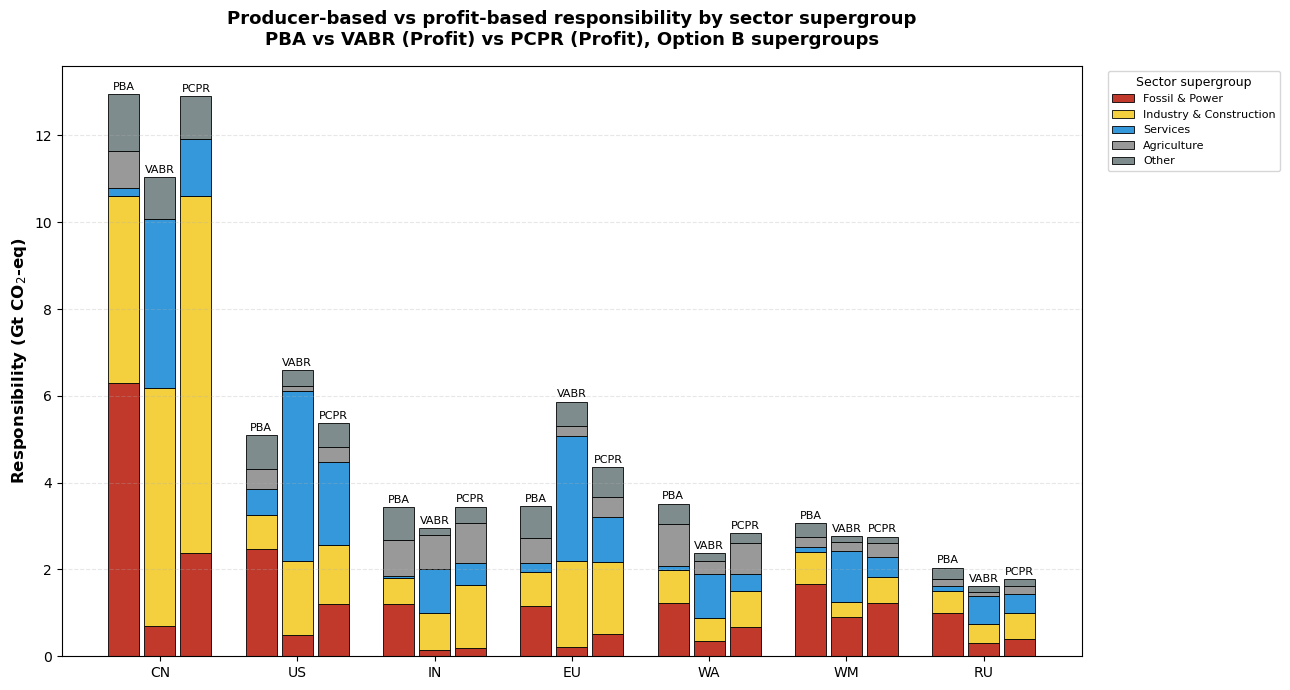

✓ PBA vs VABR (Profit) vs PCPR (Profit) stacked bar chart created (Option B, knallige Farben).

=== Text summary for interpretation (totals + top 3 groups) ===
CN – PBA: total=12.96 Gt; top groups: Fossil & Power=6.31 Gt, Industry & Construction=4.30 Gt, Other=1.31 Gt
US – PBA: total=5.10 Gt; top groups: Fossil & Power=2.47 Gt, Industry & Construction=0.80 Gt, Other=0.78 Gt
IN – PBA: total=3.45 Gt; top groups: Fossil & Power=1.20 Gt, Agriculture=0.83 Gt, Other=0.76 Gt
EU – PBA: total=3.45 Gt; top groups: Fossil & Power=1.15 Gt, Industry & Construction=0.78 Gt, Other=0.73 Gt
WA – PBA: total=3.52 Gt; top groups: Fossil & Power=1.22 Gt, Agriculture=0.96 Gt, Industry & Construction=0.76 Gt
WM – PBA: total=3.06 Gt; top groups: Fossil & Power=1.66 Gt, Industry & Construction=0.73 Gt, Other=0.30 Gt
RU – PBA: total=2.04 Gt; top groups: Fossil & Power=1.01 Gt, Industry & Construction=0.50 Gt, Other=0.27 Gt
CN – VABR (Profit): total=11.04 Gt; top groups: Industry & Construction=5.48 Gt, Services

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===================================================================
# PBA vs VABR (Profit) vs PCPR (Profit) – Stacked by sector supergroups
# Option B grouping with knallige colours
# ===================================================================

print("\n=== PLOT: PBA vs VABR (Profit) vs PCPR (Profit) by sector supergroups ===")

EU_CODE = "EU"

# ---------------------------------------------------------------
# 0) Build PBA sector-level detail dict (like VABR/PCPR)
# ---------------------------------------------------------------
producer_series_sr = pd.Series(producer_emissions, index=ixi_data.x.index)

pba_details = {}
regions = ixi_data.get_regions()

for r in regions:
    mask_r = producer_series_sr.index.get_level_values(0) == r
    pba_details[r] = producer_series_sr[mask_r]

# Aggregate EU for PBA, VABR, PCPR if needed
detail_dicts = [pba_details, vabr_profit_details, pcpr_details]

for method_dict in detail_dicts:
    if EU_CODE not in method_dict:
        member_series = []
        for r in EU_COUNTRIES:   # ['AT','BE',...]
            if r in method_dict:
                member_series.append(method_dict[r])
        if member_series:
            eu_series = pd.concat(member_series).groupby(level=[0, 1]).sum()
            method_dict[EU_CODE] = eu_series
        else:
            print("⚠ No EU members found in detail dict for aggregation.")

# ---------------------------------------------------------------
# 1) Countries to show
# ---------------------------------------------------------------
focus_countries = ["CN", "US", "IN", "EU", "WA", "WM", "RU"]

available_countries = [
    c for c in focus_countries
    if (c in pba_details) and (c in vabr_profit_details) and (c in pcpr_details)
]

if len(available_countries) == 0:
    raise ValueError("No overlapping countries in PBA / VABR / PCPR details.")

print("Countries in plot:", available_countries)

countries = available_countries

# ---------------------------------------------------------------
# 2) Supergroups (Option B)
# ---------------------------------------------------------------
def sector_to_supergroup(sector_name: str) -> str:
    """
    Map EXIO sector name → base category → supergroup (Option B).
    Supergroups:
      - Fossil & Power
      - Industry & Construction
      - Services
      - Agriculture
      - Other
    """
    base = category_of(sector_name)

    # Fossil & Power
    if base in [
        "Coal", "Oil", "Gas",
        "Energy & Utilities Infrastructure",
        "Electricity & Heat Infrastructure"
    ]:
        return "Fossil & Power"

    # Industry & Construction
    if base in [
        "Metals",
        "Non-metallic Minerals",
        "Chemicals & Plastics",
        "Manufacturing (Food & Beverages)",
        "Manufacturing (Textiles, Leather & Wood)",
        "Manufacturing (Machinery & Equipment)",
        "Construction",
        "Trade",
        "Construction & Trade",
    ]:
        return "Industry & Construction"

    # Services
    if base in ["Services", "Finance & Business Services", "Public Services"]:
        return "Services"

    # Agriculture
    if base == "Agriculture":
        return "Agriculture"

    # Everything else
    return "Other"


supergroups_order = [
    "Fossil & Power",
    "Industry & Construction",
    "Services",
    "Agriculture",
    "Other",
]

# ---------------------------------------------------------------
# 3) Methods & aggregate
# ---------------------------------------------------------------
methods = {
    "PBA":            pba_details,
    "VABR (Profit)":  vabr_profit_details,
    "PCPR (Profit)":  pcpr_details,
}

results = {
    method_name: {
        country: {sg: 0.0 for sg in supergroups_order}
        for country in countries
    }
    for method_name in methods
}

for method_name, detail_dict in methods.items():
    for country in countries:
        if country not in detail_dict:
            print(f"⚠ {country} not in {method_name} details.")
            continue

        series = detail_dict[country]  # Series indexed by (region, sector)

        for (region, sector), value in series.items():
            if value == 0:
                continue
            sg = sector_to_supergroup(sector)
            results[method_name][country][sg] += value

# ---------------------------------------------------------------
# 4) Plot with knallige colours + spacing inside groups
# ---------------------------------------------------------------
unit_div = 1e9
unit_label = "Gt CO$_2$-eq"

x = np.arange(len(countries))

methods_plot = ["PBA", "VABR (Profit)", "PCPR (Profit)"]
n_methods = len(methods_plot)

# Total width reserved per country (<= 1.0 looks nice)
group_width = 0.75

# Actual bar width (a bit smaller so you see gaps)
bar_width = group_width / n_methods * 0.9

# Horizontal offsets for each method within the country group
offsets = np.linspace(
    -group_width/2 + bar_width/2,
    group_width/2 - bar_width/2,
    n_methods
)

# knallige, farbenblinden-freundliche Farben
colors = {
    'Fossil & Power': '#C0392B',      # Dunkelrot
    'Industry & Construction': '#F4D03F',  # Gold/Gelb
    'Services': '#3498DB',             # Blau
    'Other': '#7F8C8D'                 # Grau
}

fig, ax = plt.subplots(figsize=(13, 7))

for m_idx, method_name in enumerate(methods_plot):
    x_pos = x + offsets[m_idx]   # shifted positions for this method
    bottoms = np.zeros(len(countries))

    for sg in supergroups_order:
        heights = np.array([
            results[method_name][country][sg] / unit_div
            for country in countries
        ])

        if np.allclose(heights, 0):
            continue

        ax.bar(
            x_pos,
            heights,
            bar_width,
            bottom=bottoms,
            label=sg if m_idx == 0 else None,  # legend only once
            color=colors.get(sg, "#999999"),
            edgecolor="black",
            linewidth=0.6,
        )
        bottoms += heights

    # Small method label on top of each stacked bar
    for j, country in enumerate(countries):
        total_height = bottoms[j]
        ax.text(
            x_pos[j],
            total_height + 0.05,
            "PBA" if method_name == "PBA"
            else ("VABR" if method_name.startswith("VABR") else "PCPR"),
            ha="center",
            va="bottom",
            fontsize=8,
        )

# Axes / legend formatting
ax.set_title(
    "Producer-based vs profit-based responsibility by sector supergroup\n"
    "PBA vs VABR (Profit) vs PCPR (Profit), Option B supergroups",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
ax.set_ylabel(f"Responsibility ({unit_label})", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(countries, fontsize=10)

ax.legend(
    title="Sector supergroup",
    fontsize=8,
    title_fontsize=9,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
)
ax.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

print("✓ PBA vs VABR (Profit) vs PCPR (Profit) stacked bar chart created (Option B, knallige Farben).")

# ---------------------------------------------------------------
# 5) Optional small text summary
# ---------------------------------------------------------------
print("\n=== Text summary for interpretation (totals + top 3 groups) ===")
for method_name in methods_plot:
    for country in countries:
        vals = results[method_name][country]
        total = sum(vals.values()) / unit_div
        top3 = sorted(vals.items(), key=lambda x: x[1], reverse=True)[:3]
        top_str = ", ".join(f"{g}={v/unit_div:.2f} Gt" for g, v in top3)
        print(f"{country} – {method_name}: total={total:.2f} Gt; top groups: {top_str}")


In [88]:
import numpy as np
import pandas as pd

# ================================================================
# Egli-style beneficiary-pays analysis:
# PBA fossil vs VABR (Profit, fossil chain) vs PCPR (fossil emissions)
# ================================================================

print("\n" + "="*70)
print("Egli-style analysis: PBA vs VABR (Profit) vs PCPR from fossil emissions")
print("="*70)

# ------------------------------------------------
# 1) Define fossil sectors via your classifications
# ------------------------------------------------
# Use your existing `sector_classification` dict
# and category names for fossil sectors
FOSSIL_CATEGORIES = ["Coal", "Oil", "Gas"]

fossil_sector_names = [
    s
    for cat in FOSSIL_CATEGORIES
    for s in sector_classification.get(cat, [])
]

print(f"Fossil sector categories: {FOSSIL_CATEGORIES}")
print(f"Number of EXIO fossil sectors: {len(fossil_sector_names)}")

idx = ixi_data.x.index  # MultiIndex (region, sector)

# ================================================================
# 2) PBA: fossil producer emissions by country
# ================================================================
producer_series = pd.Series(producer_emissions, index=idx)

mask_fossil = idx.get_level_values(1).isin(fossil_sector_names)
fossil_pba_by_country = (
    producer_series[mask_fossil]
    .groupby(level=0)
    .sum()
)

print(f"\nCountries with fossil producer emissions: {len(fossil_pba_by_country)}")
print(f"Global fossil PBA: {fossil_pba_by_country.sum()/1e9:.2f} Gt CO₂-eq")

# ================================================================
# 3) VABR (Profit): responsibility from the fossil chain by country
#    → how much of global fossil-chain responsibility each country captures
# ================================================================
vabr_fossil_by_country = {}

for country, s in vabr_profit_details.items():
    # s is a Series indexed by (emitting_region, sector)
    mask = s.index.get_level_values(1).isin(fossil_sector_names)
    vabr_fossil_by_country[country] = s[mask].sum()

vabr_fossil_by_country = pd.Series(vabr_fossil_by_country)
print(f"\nCountries with fossil-chain VABR (Profit): {len(vabr_fossil_by_country)}")
print(f"Global fossil-chain VABR (Profit): {vabr_fossil_by_country.sum()/1e9:.2f} Gt CO₂-eq")

# ================================================================
# 4) PCPR from fossil emissions:
#    run PCPR on a fossil-only emission vector
# ================================================================
fossil_emissions_vec = np.zeros_like(producer_emissions, dtype=float)
fossil_emissions_vec[mask_fossil] = producer_emissions[mask_fossil]

print("\nRunning PCPR on fossil emissions only (this may take a bit)...")
pcpr_fossil_totals, pcpr_fossil_by_sector_region = calculate_pcpr(
    ixi_data,
    fossil_emissions_vec,
    profit_components=PROFIT_COMPONENTS,
    method='inverse'
)

print(f"Countries with fossil PCPR: {len(pcpr_fossil_totals)}")
print(f"Global fossil PCPR: {pcpr_fossil_totals.sum()/1e9:.2f} Gt CO₂-eq")

# ================================================================
# 5) Combine into one country table
# ================================================================
all_countries = (
    fossil_pba_by_country.index
    .union(vabr_fossil_by_country.index)
    .union(pcpr_fossil_totals.index)
)

fossil_table = pd.DataFrame(index=all_countries)
fossil_table["PBA_fossil"] = fossil_pba_by_country
fossil_table["VABR_fossil_chain"] = vabr_fossil_by_country
fossil_table["PCPR_fossil"] = pcpr_fossil_totals

# Drop countries with no info at all
fossil_table = fossil_table.dropna(how="all")

# In Gt for readability
fossil_table_Gt = fossil_table / 1e9
fossil_table_Gt = fossil_table_Gt.rename(
    columns={
        "PBA_fossil": "PBA fossil (Gt)",
        "VABR_fossil_chain": "VABR fossil chain (Gt)",
        "PCPR_fossil": "PCPR from fossil (Gt)",
    }
)

# Add simple differences / ratios
fossil_table_Gt["PCPR − PBA (Gt)"] = (
    fossil_table["PCPR_fossil"] - fossil_table["PBA_fossil"]
) / 1e9

fossil_table_Gt["PCPR / PBA (–)"] = (
    fossil_table["PCPR_fossil"] / fossil_table["PBA_fossil"]
)

fossil_table_Gt["VABR / PBA (–)"] = (
    fossil_table["VABR_fossil_chain"] / fossil_table["PBA_fossil"]
)

fossil_table_Gt = fossil_table_Gt.round(3)

print("\n=== Country table: fossil PBA vs fossil-chain VABR vs fossil PCPR (Gt) ===")
print(fossil_table_Gt.sort_values("PBA fossil (Gt)", ascending=False).head(15))

# ================================================================
# 6) Rank changes: PBA vs PCPR
# ================================================================
rank_pba = fossil_table["PBA_fossil"].rank(ascending=False, method="min")
rank_pcpr = fossil_table["PCPR_fossil"].rank(ascending=False, method="min")

rank_table = pd.DataFrame({
    "PBA fossil rank": rank_pba,
    "PCPR fossil rank": rank_pcpr,
    "Rank change (PCPR − PBA)": rank_pcpr - rank_pba,   # negative = moves UP (more responsibility)
    "PCPR − PBA (Gt)": fossil_table_Gt["PCPR − PBA (Gt)"],
})

print("\n=== Top 10 countries that GAIN responsibility (PCPR − PBA, Gt) ===")
print(
    rank_table
    .sort_values("PCPR − PBA (Gt)", ascending=False)
    .head(10)
    .round(3)
)

print("\n=== Top 10 countries that LOSE responsibility (PCPR − PBA, Gt) ===")
print(
    rank_table
    .sort_values("PCPR − PBA (Gt)", ascending=True)
    .head(10)
    .round(3)
)

# ================================================================
# 7) Compare to Egli superprofit recipients
# ================================================================
# Egli list: US, UK, FR, CA, Saudi, Brazil, China, Norway, Russia
egli_countries = ["US", "GB", "FR", "CA", "SA", "BR", "CN", "NO", "RU"]
egli_present = [c for c in egli_countries if c in fossil_table_Gt.index]

print("\n=== Egli superprofit countries: fossil PBA vs PCPR ===")
print(
    pd.concat(
        [
            fossil_table_Gt.loc[egli_present, [
                "PBA fossil (Gt)",
                "VABR fossil chain (Gt)",
                "PCPR from fossil (Gt)",
                "PCPR − PBA (Gt)",
                "PCPR / PBA (–)",
            ]],
            rank_table.loc[egli_present, [
                "PBA fossil rank",
                "PCPR fossil rank",
                "Rank change (PCPR − PBA)",
            ]],
        ],
        axis=1
    ).sort_values("PCPR − PBA (Gt)", ascending=False).round(3)
)

print("\nNote:")
print("  • Positive 'PCPR − PBA (Gt)' and negative rank change → country gains responsibility under PCPR.")
print("  • Check whether Egli's superprofit countries tend to move up (gain responsibility) in PCPR.")



Egli-style analysis: PBA vs VABR (Profit) vs PCPR from fossil emissions
Fossil sector categories: ['Coal', 'Oil', 'Gas']
Number of EXIO fossil sectors: 12

Countries with fossil producer emissions: 49
Global fossil PBA: 18.89 Gt CO₂-eq

Countries with fossil-chain VABR (Profit): 50
Global fossil-chain VABR (Profit): 3.58 Gt CO₂-eq

Running PCPR on fossil emissions only (this may take a bit)...

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 18.893 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.0 B€
Profit coefficients: mean=0.100
Computing D = (I - S)^(-1)...
  Condition number: 1.25e+01
FD flows: direct=0.200, total=0.515 (ratio: 2.57x)
Per-producer allocation...
  Producers processed: 567
  Zero profit capture: 43
Conservation: 18.8931 Gt (error: 0.000000%)

Top 5 countries:
  CN: 6.226 Gt (0.99x)
  US: 2.522 Gt (1.03x)
  WM: 1.417 Gt (0.85x)
  IN: 1.234 Gt (1.03x)
  WA: 1.107 G


=== 4.4.2 CROSS-BORDER FOSSIL PCBR FLOWS ===
Exporter regions used: ['WM', 'RU', 'AU', 'IN', 'CN', 'US']
Total IO rows: 7987, fossil rows: 588

--- Exporter: WM ---
  Fossil rows for WM: 12
  Fossil emissions input: 1.661 Gt CO2-eq

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 1.661 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.0 B€
Profit coefficients: mean=0.100
Computing D = (I - S)^(-1)...
  Condition number: 1.25e+01
FD flows: direct=0.200, total=0.515 (ratio: 2.57x)
Per-producer allocation...
  Producers processed: 12
  Zero profit capture: 0
Conservation: 1.6605 Gt (error: 0.000000%)

Top 5 countries:
  WM: 1.240 Gt (0.75x)
  CN: 0.135 Gt (nanx)
  IN: 0.045 Gt (nanx)
  JP: 0.041 Gt (nanx)
  WA: 0.034 Gt (nanx)
  Total fossil PCBR allocated: 1.661 Gt

--- Exporter: RU ---
  Fossil rows for RU: 12
  Fossil emissions input: 0.969 Gt CO2-eq

=== PRODUCER-CENTRIC PROFIT-BASED

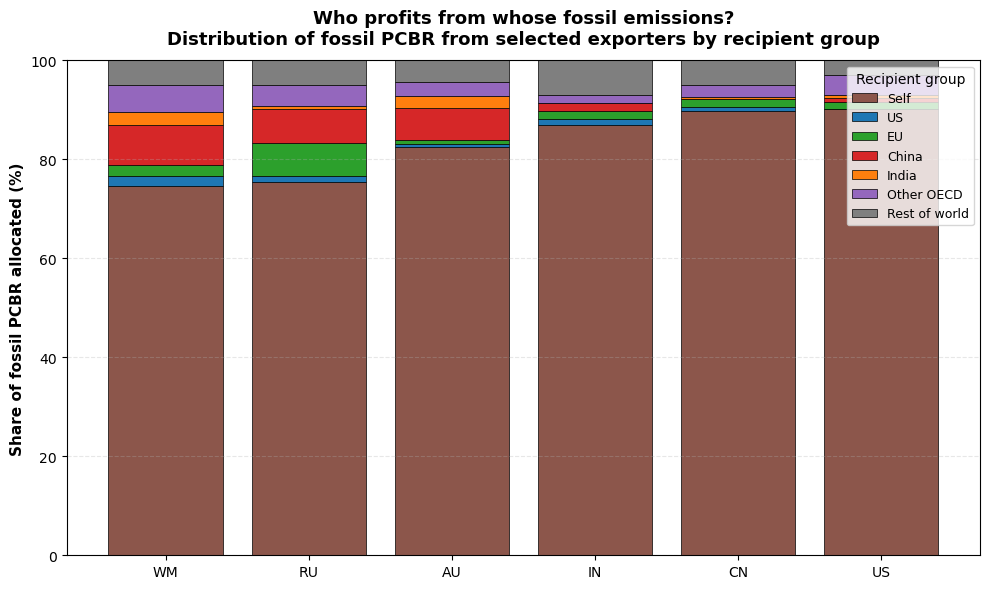


✓ Cross-border fossil PCBR stacked bar chart created.


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===================================================================
# 4.4.2 CROSS-BORDER PROFIT FLOWS: "WHO PROFITS FROM WHOSE EMISSIONS?"
# ===================================================================

print("\n=== 4.4.2 CROSS-BORDER FOSSIL PCBR FLOWS ===")

# -------------------------------------------------
# 1) Choose key fossil exporters (adjust if needed)
# -------------------------------------------------
# Make sure these are valid EXIOBASE region codes in your ixi_data
exporter_regions = ["WM", "RU", "AU", "IN", "CN", "US"]  # e.g. Middle East, Russia, Australia
available_regions = set(ixi_data.get_regions())
exporter_regions = [r for r in exporter_regions if r in available_regions]

print(f"Exporter regions used: {exporter_regions}")

# -------------------------------------------------
# 2) Define fossil sectors (from your classification)
# -------------------------------------------------
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
fossil_sectors_set = set(fossil_sectors)

idx = ixi_data.x.index
regions = idx.get_level_values(0)
sectors = idx.get_level_values(1)

# Boolean mask for fossil rows
mask_fossil_global = sectors.isin(fossil_sectors_set)

print(f"Total IO rows: {len(idx)}, fossil rows: {mask_fossil_global.sum()}")

# -------------------------------------------------
# 3) Define region groupings for recipients
# -------------------------------------------------

# Rough EU and OECD code lists – adjust if needed to match your EXIOBASE region codes
EU_CODES = {
    "AT","BE","BG","CY","CZ","DE","DK","EE","ES","FI","FR","GR","HR","HU","IE","IT",
    "LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"
}
OECD_EXTRA = {
    "US","CA","MX","JP","KR","AU","NZ","NO","IS","CH","TR","IL","CL"
}
# full OECD (roughly)
OECD_CODES = EU_CODES.union(OECD_EXTRA)

def recipient_group(region_code, exporter):
    """
    Map EXIOBASE region code to one of:
    'Self', 'US', 'EU', 'China', 'India', 'Other OECD', 'Rest of world'
    """
    if region_code == exporter:
        return "Self"
    if region_code == "US":
        return "US"
    if region_code == "CN":
        return "China"
    if region_code == "IN":
        return "India"
    if region_code in EU_CODES:
        return "EU"
    if (region_code in OECD_CODES) and region_code not in {"US","CN","IN"}:
        return "Other OECD"
    return "Rest of world"

group_order = ["Self", "US", "EU", "China", "India", "Other OECD", "Rest of world"]

# DataFrame to store shares (%) per exporter
shares_df = pd.DataFrame(index=exporter_regions, columns=group_order, dtype=float)

# -------------------------------------------------
# 4) Loop over exporters: run fossil-only PCBR & aggregate to groups
# -------------------------------------------------
for exporter in exporter_regions:
    print(f"\n--- Exporter: {exporter} ---")

    # Fossil rows IN THIS EXPORTER
    mask_exporter = (regions == exporter)
    mask_fossil_exporter = mask_exporter & mask_fossil_global

    print(f"  Fossil rows for {exporter}: {mask_fossil_exporter.sum()}")

    # Build emissions vector: only fossil sectors of this exporter emit
    pe_exporter_fossil = np.zeros_like(producer_emissions, dtype=float)
    pe_exporter_fossil[mask_fossil_exporter] = producer_emissions[mask_fossil_exporter]

    print(f"  Fossil emissions input: {pe_exporter_fossil.sum()/1e9:.3f} Gt CO2-eq")

    if pe_exporter_fossil.sum() == 0:
        print("  -> No fossil emissions for this exporter, skipping.")
        continue

    # Run PCBR just for this exporter's fossil emissions
    pcpr_totals_exp, _ = calculate_pcpr(
        ixi_data=ixi_data,
        producer_emissions=pe_exporter_fossil,
        profit_components=PROFIT_COMPONENTS,
        method="inverse"
    )

    total_resp = pcpr_totals_exp.sum()
    print(f"  Total fossil PCBR allocated: {total_resp/1e9:.3f} Gt")

    # Aggregate by recipient group
    group_values = {g: 0.0 for g in group_order}

    for r, val in pcpr_totals_exp.items():
        g = recipient_group(r, exporter)
        group_values[g] += val

    # Convert to shares (%)
    if total_resp > 0:
        for g in group_order:
            shares_df.loc[exporter, g] = 100 * group_values[g] / total_resp
    else:
        shares_df.loc[exporter, :] = 0.0

print("\n=== SHARES OF FOSSIL PCBR BY RECIPIENT GROUP (%) ===")
print(shares_df.round(1))


# ===================================================================
# 5) PLOT: STACKED BARS – "WHO PROFITS FROM WHOSE EMISSIONS?"
# ===================================================================

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(exporter_regions))
bottom = np.zeros(len(exporter_regions))

colors = {
    "Self": "#8c564b",
    "US": "#1f77b4",
    "EU": "#2ca02c",
    "China": "#d62728",
    "India": "#ff7f0e",
    "Other OECD": "#9467bd",
    "Rest of world": "#7f7f7f",
}

for group in group_order:
    values = shares_df[group].fillna(0).values
    ax.bar(
        x,
        values,
        bottom=bottom,
        label=group,
        color=colors.get(group, None),
        edgecolor="black",
        linewidth=0.5
    )
    bottom += values

ax.set_title(
    "Who profits from whose fossil emissions?\n"
    "Distribution of fossil PCBR from selected exporters by recipient group",
    fontsize=13,
    fontweight="bold",
    pad=12
)
ax.set_ylabel("Share of fossil PCBR allocated (%)", fontsize=11, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(exporter_regions, fontsize=10)
ax.set_ylim(0, 100)
ax.grid(axis="y", alpha=0.3, linestyle="--")

ax.legend(title="Recipient group", fontsize=9, title_fontsize=10, loc="upper right")

plt.tight_layout()
plt.show()

print("\n✓ Cross-border fossil PCBR stacked bar chart created.")


In [95]:
import numpy as np 
import pandas as pd
import plotly.graph_objects as go

# ============================================================
# 0) Ensure we have PCPR flows (only run if not already computed)
# ============================================================

if 'pcpr_flows' not in globals():
    pcpr_totals, pcpr_by_sector_region, pcpr_flows = calculate_pcpr(
        ixi_data,
        producer_emissions,
        profit_components=PROFIT_COMPONENTS,
        method='inverse',
        return_flows=True,
        min_flow=1e3   # ignore flows < 1000 t CO2-eq
    )
    print("pcpr_flows computed.")
else:
    print("Using existing pcpr_flows.")


# ============================================================
# 1) PARAMETERS
# ============================================================

# Left side: origin countries (fossil producers)
source_regions = ["RU", "WM", "US", "CN"]   # you can extend to AU, CA, ID etc.

# Middle layer: destination regions we want explicit + Rest of World
explicit_dest_regions = ["RU", "WM", "US", "CN", "EU"]

# Right side: compact sector super-groups
sector_supergroups_order = [
    "Fossil & Power",
    "Materials & Heavy Industry",
    "Manufacturing & Construction",
    "Agriculture",
    "Transport",
    "Services",
    "Other",
]

# Minimum flow (tonnes CO2-eq) to draw a link (to avoid hairlines)
MIN_FLOW_FOR_LINK = 1e6   # 1 Mt; adjust if needed


# ============================================================
# 2) Build list of fossil source sectors (Coal, Oil, Gas)
# ============================================================

fossil_categories = ["Coal", "Oil", "Gas"]

fossil_source_sectors = [
    s
    for cat in fossil_categories
    for s in sector_classification.get(cat, [])
]

print("\nSource regions:", source_regions)
print("Fossil categories used as origin:", fossil_categories)
print("Example fossil sectors:", fossil_source_sectors[:10], "...")


# ============================================================
# 3) Prepare flows: filter to fossil sources in selected origins
# ============================================================

flows = pcpr_flows.copy()

# Aggregate EU on beneficiary side
if 'EU_COUNTRIES' in globals():
    flows['beneficiary_region'] = np.where(
        flows['beneficiary_region'].isin(EU_COUNTRIES),
        "EU",
        flows['beneficiary_region']
    )

# Keep only fossil-producing sectors in the selected origin countries
mask_sources = (
    flows['producing_region'].isin(source_regions) &
    flows['producing_sector'].isin(fossil_source_sectors)
)

flows_src = flows.loc[mask_sources].copy()

if flows_src.empty:
    raise ValueError("No PCPR flows found for selected fossil sources and origin regions.")

total_alloc = flows_src['allocated_emissions'].sum()
print(f"\nTotal PCPR from fossil sectors in selected origins: {total_alloc/1e9:.3f} Gt")

# Destination region aggregation: explicit regions + Rest of World
def map_dest_region(raw_region):
    if raw_region in explicit_dest_regions:
        return raw_region
    else:
        return "Rest of World"

flows_src['dest_region_agg'] = flows_src['beneficiary_region'].apply(map_dest_region)


# ============================================================
# 4) Map beneficiary sectors to compact sector super-groups
# ============================================================

def map_to_supergroup(sector_name):
    """
    Map detailed EXIO sector name -> category_of(...) -> compact supergroup.

    Supergroups:
      - Fossil & Power
      - Materials & Heavy Industry
      - Manufacturing & Construction
      - Agriculture
      - Transport
      - Services
      - Other
    """
    raw_cat = category_of(sector_name)

    # 1) Fossil & Power
    if raw_cat in [
        "Coal", "Oil", "Gas",
        "Energy & Utilities Infrastructure",
        "Electricity & Heat Infrastructure"
    ]:
        return "Fossil & Power"

    # 2) Materials & Heavy Industry
    if raw_cat in [
        "Metals",
        "Non-metallic Minerals",
        "Chemicals & Plastics"
    ]:
        return "Materials & Heavy Industry"

    # 3) Manufacturing & Construction
    if raw_cat in [
        "Manufacturing (Food & Beverages)",
        "Manufacturing (Textiles, Leather & Wood)",
        "Manufacturing (Machinery & Equipment)",
        "Construction",
        "Trade",
        "Construction & Trade"
    ]:
        return "Manufacturing & Construction"

    # 4) Agriculture
    if raw_cat == "Agriculture":
        return "Agriculture"

    # 5) Transport
    if raw_cat == "Transport":
        return "Transport"

    # 6) Services
    if raw_cat in ["Services", "Finance & Business Services", "Public Services"]:
        return "Services"

    # 7) Everything else (incl. Renewables, Waste, etc.)
    return "Other"


flows_src['sector_supergroup'] = flows_src['beneficiary_sector'].apply(map_to_supergroup)


# ============================================================
# 5) Aggregate flows for Sankey
#    (origin region → dest region → sector supergroup)
# ============================================================

# Origin → Destination
origin_dest_totals = (
    flows_src.groupby(['producing_region', 'dest_region_agg'])['allocated_emissions']
    .sum()
    .reset_index()
)

# Destination → Sector supergroup
dest_sector_totals = (
    flows_src.groupby(['dest_region_agg', 'sector_supergroup'])['allocated_emissions']
    .sum()
    .reset_index()
)

print("\nOrigin→Destination totals (Gt):")
print(
    origin_dest_totals.assign(
        allocated_Gt=origin_dest_totals['allocated_emissions'] / 1e9
    )[["producing_region", "dest_region_agg", "allocated_Gt"]]
)

print("\nDestination→Sector-group totals (Gt):")
print(
    dest_sector_totals.assign(
        allocated_Gt=dest_sector_totals['allocated_emissions'] / 1e9
    )[["dest_region_agg", "sector_supergroup", "allocated_Gt"]]
)


# ============================================================
# 6) Build Sankey nodes and links (with colors)
# ============================================================

node_labels = []
node_index = {}

def add_node(label):
    """Add a node label (if new) and return its index."""
    if label not in node_index:
        node_index[label] = len(node_labels)
        node_labels.append(label)
    return node_index[label]

# --- Left layer: origin nodes ---
origin_nodes = {}
for src in source_regions:
    label = f"{src} fossil"
    origin_nodes[src] = add_node(label)

# --- Middle layer: destination nodes ---
middle_regions = explicit_dest_regions + ["Rest of World"]
region_nodes = {}
for dest in middle_regions:
    if dest not in origin_dest_totals['dest_region_agg'].values:
        continue
    total_val = origin_dest_totals.loc[
        origin_dest_totals['dest_region_agg'] == dest, 'allocated_emissions'
    ].sum()
    share = total_val / total_alloc if total_alloc > 0 else 0.0
    label = f"{dest} ({share*100:.1f}%)" if dest != "Rest of World" else "Rest of World"
    region_nodes[dest] = add_node(label)

# --- Right layer: sector super-group nodes ---
sector_nodes = {}
for super_cat in sector_supergroups_order:
    if super_cat not in dest_sector_totals['sector_supergroup'].values:
        continue
    total_val = dest_sector_totals.loc[
        dest_sector_totals['sector_supergroup'] == super_cat,
        'allocated_emissions'
    ].sum()
    if total_val <= 0:
        continue
    label = super_cat
    sector_nodes[super_cat] = add_node(label)

# ------------------------------------------------------------
# Color maps (colorblind-friendly)
# ------------------------------------------------------------

# Sector colors = Okabe–Ito palette-ish, RGBA
sector_colors = {
    "Fossil & Power":              "rgba(220, 0, 0, 0.9)",     # knalliges Rot
    "Materials & Heavy Industry":  "rgba(255, 140, 0, 0.9)",   # kräftiges Orange
    "Manufacturing & Construction":"rgba(255, 200, 0, 0.9)",   # sattes Gelb
    "Agriculture":                 "rgba(0, 170, 0, 0.9)",     # sattes Grün
    "Transport":                   "rgba(150, 0, 160, 0.9)",   # kräftiges Violett
    "Services":                    "rgba(0, 80, 220, 0.9)",    # starkes Blau
    "Other":                       "rgba(120, 120, 120, 0.85)" # dunkles Grau
}

# Country / region node colors (neutral greys, but consistent per region)
region_colors = {
    "RU":            "rgba(80, 80, 80, 0.9)",
    "WM":            "rgba(120, 120, 120, 0.9)",
    "US":            "rgba(160, 160, 160, 0.9)",
    "CN":            "rgba(200, 200, 200, 0.9)",
    "EU":            "rgba(60, 60, 60, 0.9)",
    "Rest of World": "rgba(220, 220, 220, 0.9)",
}

neutral_link_color = "rgba(180, 180, 180, 0.4)"  # for origin→dest links

# ------------------------------------------------------------
# Build link arrays
# ------------------------------------------------------------

link_sources = []
link_targets = []
link_values  = []
link_colors  = []

# 1) Links: origin → destination (neutral grey)
for _, row in origin_dest_totals.iterrows():
    val = float(row['allocated_emissions'])
    if val < MIN_FLOW_FOR_LINK:
        continue
    src = row['producing_region']
    dest = row['dest_region_agg']
    if src not in origin_nodes or dest not in region_nodes:
        continue
    s_idx = origin_nodes[src]
    t_idx = region_nodes[dest]
    link_sources.append(s_idx)
    link_targets.append(t_idx)
    link_values.append(val)
    link_colors.append(neutral_link_color)

# 2) Links: destination → sector supergroup (colored by sector group)
for _, row in dest_sector_totals.iterrows():
    val = float(row['allocated_emissions'])
    if val < MIN_FLOW_FOR_LINK:
        continue
    dest = row['dest_region_agg']
    cat  = row['sector_supergroup']
    if dest not in region_nodes or cat not in sector_nodes:
        continue
    s_idx = region_nodes[dest]
    t_idx = sector_nodes[cat]
    link_sources.append(s_idx)
    link_targets.append(t_idx)
    link_values.append(val)
    link_colors.append(sector_colors.get(cat, "rgba(120, 120, 120, 0.8)"))

# Sanity check
assert len(link_sources) == len(link_targets) == len(link_values) == len(link_colors)

# ------------------------------------------------------------
# Build node colors (same color for all nodes of a country;
# sector nodes use the same color as sector flows)
# ------------------------------------------------------------

node_colors = []

for label in node_labels:
    # Origin nodes: e.g. "CN fossil"
    if label.endswith(" fossil"):
        region_code = label.split()[0]
        node_colors.append(region_colors.get(region_code, "rgba(100,100,100,0.9)"))
        continue

    # Middle destination nodes: e.g. "CN (35.0%)", "Rest of World"
    # Check explicit regions first
    matched_region = None
    for reg in ["RU", "WM", "US", "CN", "EU"]:
        if label.startswith(reg + " "):
            matched_region = reg
            break
    if label == "Rest of World":
        matched_region = "Rest of World"

    if matched_region is not None:
        node_colors.append(region_colors.get(matched_region, "rgba(140,140,140,0.9)"))
        continue

    # Otherwise: sector node (label is the supergroup name)
    sg = label
    node_colors.append(sector_colors.get(sg, "rgba(120,120,120,0.8)"))


# ============================================================
# 7) Plot Sankey with Plotly
# ============================================================

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(width=0.5, color="black"),
        label=node_labels,
        color=node_colors   # <— NEW: node colors
    ),
    link=dict(
        source=link_sources,
        target=link_targets,
        value=link_values,
        color=link_colors   # <— flows colored by sector group (right side)
    )
)])

title_str = (
    "Producer-Centric Profit-Based Responsibility from Fossil Emissions\n"
    f"Origins: {', '.join(source_regions)} | "
    "Right side: sector supergroups (colors by sector group)"
)

fig.update_layout(
    title=title_str,
    font=dict(size=11),
    width=1000,
    height=550
)

fig.show()

print("\n✓ 3-layer fossil PCPR Sankey with compact sector supergroups created.")
print("Total PCPR from selected fossil sources:", f"{total_alloc/1e9:.3f} Gt")


Using existing pcpr_flows.

Source regions: ['RU', 'WM', 'US', 'CN']
Fossil categories used as origin: ['Coal', 'Oil', 'Gas']
Example fossil sectors: ['Mining of coal and lignite; extraction of peat (10)', 'Production of electricity by coal', 'Manufacture of coke oven products', 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 'Petroleum Refinery', 'Production of electricity by petroleum and other oil derivatives', 'Retail sale of automotive fuel', 'Extraction of natural gas and services related to natural gas extraction, excluding surveying', 'Extraction, liquefaction, and regasification of other petroleum and gaseous materials', 'Manufacture of gas; distribution of gaseous fuels through mains'] ...

Total PCPR from fossil sectors in selected origins: 11.339 Gt

Origin→Destination totals (Gt):
   producing_region dest_region_agg  allocated_Gt
0                CN              CN          5.64
1                CN              EU         


✓ 3-layer fossil PCPR Sankey with compact sector supergroups created.
Total PCPR from selected fossil sources: 11.339 Gt


In [64]:
import numpy as np 
import pandas as pd
import plotly.graph_objects as go

# ============================================================
# 0) Ensure we have PCPR flows (only run if not already computed)
# ============================================================

if 'pcpr_flows' not in globals():
    pcpr_totals, pcpr_by_sector_region, pcpr_flows = calculate_pcpr(
        ixi_data,
        producer_emissions,
        profit_components=PROFIT_COMPONENTS,
        method='inverse',
        return_flows=True,
        min_flow=1e3   # ignore flows < 1000 t CO2-eq
    )
    print("pcpr_flows computed.")
else:
    print("Using existing pcpr_flows.")


# ============================================================
# 1) PARAMETERS
# ============================================================

# Left side: origin countries (fossil producers)
source_regions = ["RU", "WM", "US", "CN", "EU"]   # you can extend to AU, CA, ID etc.

# Middle layer: destination regions we want explicit + Rest of World
explicit_dest_regions = ["RU", "WM", "US", "CN", "EU"]

# Right side: compact sector super-groups
sector_supergroups_order = [
    "Fossil & Power",
    "Materials & Heavy Industry",
    "Manufacturing & Construction",
    "Agriculture",
    "Transport",
    "Services",
    "Other",
]

# Minimum flow (tonnes CO2-eq) to draw a link (to avoid hairlines)
MIN_FLOW_FOR_LINK = 1e6   # 1 Mt; adjust if needed


# ============================================================
# 2) Build list of fossil *extraction* source sectors (Coal, Oil, Gas)
#    → ONLY extraction sectors are used as origins in the Sankey
# ============================================================

extraction_fossil_categories = {
    "Coal": [
        "Mining of coal and lignite; extraction of peat (10)",
    ],
    "Oil": [
        "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
    ],
    "Gas": [
        "Extraction of natural gas and services related to natural gas extraction, excluding surveying",
        "Extraction, liquefaction, and regasification of other petroleum and gaseous materials",
    ],
}

fossil_categories = ["Coal", "Oil", "Gas"]

fossil_source_sectors = [
    s
    for cat in fossil_categories
    for s in extraction_fossil_categories.get(cat, [])
]

print("\nSource regions:", source_regions)
print("Fossil categories used as origin (EXTRACTION ONLY):", fossil_categories)
print("Extraction-only fossil source sectors:", fossil_source_sectors)


# ============================================================
# 3) Prepare flows: filter to fossil sources in selected origins
# ============================================================

flows = pcpr_flows.copy()

# Aggregate EU on beneficiary side
if 'EU_COUNTRIES' in globals():
    flows['beneficiary_region'] = np.where(
        flows['beneficiary_region'].isin(EU_COUNTRIES),
        "EU",
        flows['beneficiary_region']
    )

# Keep only *extraction* sectors in the selected origin countries
mask_sources = (
    flows['producing_region'].isin(source_regions) &
    flows['producing_sector'].isin(fossil_source_sectors)
)

flows_src = flows.loc[mask_sources].copy()

if flows_src.empty:
    raise ValueError("No PCPR flows found for selected extraction sectors and origin regions.")

total_alloc = flows_src['allocated_emissions'].sum()
print(f"\nTotal PCPR from fossil *extraction* sectors in selected origins: {total_alloc/1e9:.3f} Gt")

# Destination region aggregation: explicit regions + Rest of World
def map_dest_region(raw_region):
    if raw_region in explicit_dest_regions:
        return raw_region
    else:
        return "Rest of World"

flows_src['dest_region_agg'] = flows_src['beneficiary_region'].apply(map_dest_region)


# ============================================================
# 4) Map beneficiary sectors to compact sector super-groups
# ============================================================

def map_to_supergroup(sector_name):
    """
    Map detailed EXIO sector name -> category_of(...) -> compact supergroup.

    Supergroups:
      - Fossil & Power
      - Materials & Heavy Industry
      - Manufacturing & Construction
      - Agriculture
      - Transport
      - Services
      - Other
    """
    raw_cat = category_of(sector_name)

    # 1) Fossil & Power
    if raw_cat in [
        "Coal", "Oil", "Gas",
        "Energy & Utilities Infrastructure",
        "Electricity & Heat Infrastructure"
    ]:
        return "Fossil & Power"

    # 2) Materials & Heavy Industry
    if raw_cat in [
        "Metals",
        "Non-metallic Minerals",
        "Chemicals & Plastics"
    ]:
        return "Materials & Heavy Industry"

    # 3) Manufacturing & Construction
    if raw_cat in [
        "Manufacturing (Food & Beverages)",
        "Manufacturing (Textiles, Leather & Wood)",
        "Manufacturing (Machinery & Equipment)",
        "Construction",
        "Trade",
        "Construction & Trade"
    ]:
        return "Manufacturing & Construction"

    # 4) Agriculture
    if raw_cat == "Agriculture":
        return "Agriculture"

    # 5) Transport
    if raw_cat == "Transport":
        return "Transport"

    # 6) Services
    if raw_cat in ["Services", "Finance & Business Services", "Public Services"]:
        return "Services"

    # 7) Everything else (incl. Renewables, Waste, etc.)
    return "Other"


flows_src['sector_supergroup'] = flows_src['beneficiary_sector'].apply(map_to_supergroup)


# ============================================================
# 5) Aggregate flows for Sankey
#    (origin region → dest region → sector supergroup)
# ============================================================

# Origin → Destination
origin_dest_totals = (
    flows_src.groupby(['producing_region', 'dest_region_agg'])['allocated_emissions']
    .sum()
    .reset_index()
)

# Destination → Sector supergroup
dest_sector_totals = (
    flows_src.groupby(['dest_region_agg', 'sector_supergroup'])['allocated_emissions']
    .sum()
    .reset_index()
)

print("\nOrigin→Destination totals (Gt):")
print(
    origin_dest_totals.assign(
        allocated_Gt=origin_dest_totals['allocated_emissions'] / 1e9
    )[["producing_region", "dest_region_agg", "allocated_Gt"]]
)

print("\nDestination→Sector-group totals (Gt):")
print(
    dest_sector_totals.assign(
        allocated_Gt=dest_sector_totals['allocated_emissions'] / 1e9
    )[["dest_region_agg", "sector_supergroup", "allocated_Gt"]]
)

# ============================================================
# 6) Build domestic-retention stats (per origin)
# ============================================================

retention_by_origin = {}
for src in source_regions:
    mask_src = flows_src['producing_region'] == src
    total_src = flows_src.loc[mask_src, 'allocated_emissions'].sum()
    total_domestic = flows_src.loc[
        mask_src & (flows_src['dest_region_agg'] == src),
        'allocated_emissions'
    ].sum()
    if total_src > 0:
        retention_by_origin[src] = total_domestic / total_src
    else:
        retention_by_origin[src] = np.nan

# ============================================================
# 7) Build Sankey nodes and links (with colors)
# ============================================================

node_labels = []
node_index = {}

def add_node(label):
    """Add a node label (if new) and return its index."""
    if label not in node_index:
        node_index[label] = len(node_labels)
        node_labels.append(label)
    return node_index[label]

# --- Left layer: origin nodes (with domestic-retention %) ---
origin_nodes = {}
for src in source_regions:
    ret = retention_by_origin.get(src, np.nan)
    if np.isfinite(ret):
        label = f"{src} fossil extraction\n({ret*100:.0f}% domestic)"
    else:
        label = f"{src} fossil extraction"
    origin_nodes[src] = add_node(label)

# --- Middle layer: destination nodes (just region names) ---
middle_regions = explicit_dest_regions + ["Rest of World"]
region_nodes = {}
for dest in middle_regions:
    if dest not in origin_dest_totals['dest_region_agg'].values:
        continue
    label = "Rest of World" if dest == "Rest of World" else dest
    region_nodes[dest] = add_node(label)

# --- Right layer: sector super-group nodes ---
sector_nodes = {}
for super_cat in sector_supergroups_order:
    if super_cat not in dest_sector_totals['sector_supergroup'].values:
        continue
    total_val = dest_sector_totals.loc[
        dest_sector_totals['sector_supergroup'] == super_cat,
        'allocated_emissions'
    ].sum()
    if total_val <= 0:
        continue
    label = super_cat
    sector_nodes[super_cat] = add_node(label)

# ------------------------------------------------------------
# Color maps (unchanged)
# ------------------------------------------------------------

sector_colors = {
    "Fossil & Power":              "rgba(220, 0, 0, 0.9)",
    "Materials & Heavy Industry":  "rgba(255, 140, 0, 0.9)",
    "Manufacturing & Construction":"rgba(255, 200, 0, 0.9)",
    "Agriculture":                 "rgba(0, 170, 0, 0.9)",
    "Transport":                   "rgba(150, 0, 160, 0.9)",
    "Services":                    "rgba(0, 80, 220, 0.9)",
    "Other":                       "rgba(120, 120, 120, 0.85)"
}

region_colors = {
    "RU":            "rgba(80, 80, 80, 0.9)",
    "WM":            "rgba(120, 120, 120, 0.9)",
    "US":            "rgba(160, 160, 160, 0.9)",
    "CN":            "rgba(200, 200, 200, 0.9)",
    "EU":            "rgba(60, 60, 60, 0.9)",
    "Rest of World": "rgba(220, 220, 220, 0.9)",
}

neutral_link_color = "rgba(180, 180, 180, 0.4)"

# ------------------------------------------------------------
# Build link arrays
# ------------------------------------------------------------

link_sources = []
link_targets = []
link_values  = []
link_colors  = []

# 1) Links: origin → destination
for _, row in origin_dest_totals.iterrows():
    val = float(row['allocated_emissions'])
    if val < MIN_FLOW_FOR_LINK:
        continue
    src = row['producing_region']
    dest = row['dest_region_agg']
    if src not in origin_nodes or dest not in region_nodes:
        continue
    s_idx = origin_nodes[src]
    t_idx = region_nodes[dest]
    link_sources.append(s_idx)
    link_targets.append(t_idx)
    link_values.append(val)
    link_colors.append(neutral_link_color)

# 2) Links: destination → sector supergroup
for _, row in dest_sector_totals.iterrows():
    val = float(row['allocated_emissions'])
    if val < MIN_FLOW_FOR_LINK:
        continue
    dest = row['dest_region_agg']
    cat  = row['sector_supergroup']
    if dest not in region_nodes or cat not in sector_nodes:
        continue
    s_idx = region_nodes[dest]
    t_idx = sector_nodes[cat]
    link_sources.append(s_idx)
    link_targets.append(t_idx)
    link_values.append(val)
    link_colors.append(sector_colors.get(cat, "rgba(120, 120, 120, 0.8)"))

assert len(link_sources) == len(link_targets) == len(link_values) == len(link_colors)

# ------------------------------------------------------------
# Node colors (same logic as before)
# ------------------------------------------------------------

node_colors = []
for label in node_labels:
    # Left origin nodes: "<REG> fossil extraction ..."
    if "fossil extraction" in label:
        region_code = label.split()[0]
        node_colors.append(region_colors.get(region_code, "rgba(100,100,100,0.9)"))
        continue

    # Middle region nodes
    if label in region_colors:
        node_colors.append(region_colors[label])
        continue

    # Right sector nodes
    sg = label
    node_colors.append(sector_colors.get(sg, "rgba(120,120,120,0.8)"))

# ============================================================
# 8) Plot Sankey with column titles
# ============================================================

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(width=0.5, color="black"),
        label=node_labels,
        color=node_colors
    ),
    link=dict(
        source=link_sources,
        target=link_targets,
        value=link_values,
        color=link_colors
    )
)])

title_str = (
    "Profitflows from fossil extraction emissions (PCPR method)\n"
    f"Origins: {', '.join(source_regions)}"
)

fig.update_layout(
    title=title_str,
    font=dict(size=11),
    width=1000,
    height=550,
    annotations=[
        dict(
            x=0.02, y=1.06, xref="paper", yref="paper",
            text="Origin: fossil extraction countries\n(Oil, Coal, Gas)",
            showarrow=False, font=dict(size=12)
        ),
        dict(
            x=0.50, y=1.06, xref="paper", yref="paper",
            text="Destination countries",
            showarrow=False, font=dict(size=12)
        ),
        dict(
            x=0.98, y=1.06, xref="paper", yref="paper",
            text="Destination sectors",
            showarrow=False, font=dict(size=12), xanchor="right"
        ),
    ]
)

fig.show()

print("\n✓ 3-layer fossil PCPR Sankey with domestic-retention % created.")


Using existing pcpr_flows.

Source regions: ['RU', 'WM', 'US', 'CN', 'EU']
Fossil categories used as origin (EXTRACTION ONLY): ['Coal', 'Oil', 'Gas']
Extraction-only fossil source sectors: ['Mining of coal and lignite; extraction of peat (10)', 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 'Extraction of natural gas and services related to natural gas extraction, excluding surveying', 'Extraction, liquefaction, and regasification of other petroleum and gaseous materials']

Total PCPR from fossil *extraction* sectors in selected origins: 2.504 Gt

Origin→Destination totals (Gt):
   producing_region dest_region_agg  allocated_Gt
0                CN              CN          0.94
1                CN              EU          0.00
2                CN              RU          0.00
3                CN   Rest of World          0.04
4                CN              US          0.01
..              ...             ...           ...
17          


✓ 3-layer fossil PCPR Sankey with domestic-retention % created.


In [68]:
import numpy as np 
import pandas as pd
import plotly.graph_objects as go

# ============================================================
# 0) Ensure we have PCPR flows (only run if not already computed)
# ============================================================

if 'pcpr_flows' not in globals():
    pcpr_totals, pcpr_by_sector_region, pcpr_flows = calculate_pcpr(
        ixi_data,
        producer_emissions,
        profit_components=PROFIT_COMPONENTS,
        method='inverse',
        return_flows=True,
        min_flow=1e3   # ignore flows < 1000 t CO2-eq
    )
    print("pcpr_flows computed.")
else:
    print("Using existing pcpr_flows.")


# ============================================================
# 1) PARAMETERS
# ============================================================

# Left side: origin countries (fossil producers)
source_regions = ["RU", "WM", "US", "CN", "EU"]   # you can extend to AU, CA, ID etc.

# Middle layer: destination regions we want explicit + Rest of World
explicit_dest_regions = ["RU", "WM", "US", "CN", "EU"]

# Right side: compact sector super-groups
sector_supergroups_order = [
    "Fossil & Power",
    "Materials & Heavy Industry",
    "Manufacturing & Construction",
    "Agriculture",
    "Transport",
    "Services",
    "Other",
]

# Minimum flow (tonnes CO2-eq) to draw a link (to avoid hairlines)
MIN_FLOW_FOR_LINK = 1e6   # 1 Mt; adjust if needed


# ============================================================
# 2) Build list of fossil *extraction* source sectors (Coal, Oil, Gas)
#    → ONLY extraction sectors are used as origins in the Sankey
# ============================================================

extraction_fossil_categories = {
    "Coal": [
        "Mining of coal and lignite; extraction of peat (10)",
    ],
    "Oil": [
        "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
    ],
    "Gas": [
        "Extraction of natural gas and services related to natural gas extraction, excluding surveying",
        "Extraction, liquefaction, and regasification of other petroleum and gaseous materials",
    ],
}

fossil_categories = ["Coal", "Oil", "Gas"]

fossil_source_sectors = [
    s
    for cat in fossil_categories
    for s in extraction_fossil_categories.get(cat, [])
]

print("\nSource regions:", source_regions)
print("Fossil categories used as origin (EXTRACTION ONLY):", fossil_categories)
print("Extraction-only fossil source sectors:", fossil_source_sectors)


# ============================================================
# 3) Prepare flows: filter to fossil sources in selected origins
# ============================================================

flows = pcpr_flows.copy()

# Aggregate EU on beneficiary side
if 'EU_COUNTRIES' in globals():
    flows['beneficiary_region'] = np.where(
        flows['beneficiary_region'].isin(EU_COUNTRIES),
        "EU",
        flows['beneficiary_region']
    )

# Keep only *extraction* sectors in the selected origin countries
mask_sources = (
    flows['producing_region'].isin(source_regions) &
    flows['producing_sector'].isin(fossil_source_sectors)
)

flows_src = flows.loc[mask_sources].copy()

if flows_src.empty:
    raise ValueError("No PCPR flows found for selected extraction sectors and origin regions.")

total_alloc = flows_src['allocated_emissions'].sum()
print(f"\nTotal PCPR from fossil *extraction* sectors in selected origins: {total_alloc/1e9:.3f} Gt")

# Destination region aggregation: explicit regions + Rest of World
def map_dest_region(raw_region):
    if raw_region in explicit_dest_regions:
        return raw_region
    else:
        return "Rest of World"

flows_src['dest_region_agg'] = flows_src['beneficiary_region'].apply(map_dest_region)


# ============================================================
# 4) Map beneficiary sectors to compact sector super-groups
# ============================================================

def map_to_supergroup(sector_name):
    """
    Map detailed EXIO sector name -> category_of(...) -> compact supergroup.

    Supergroups:
      - Fossil & Power
      - Materials & Heavy Industry
      - Manufacturing & Construction
      - Agriculture
      - Transport
      - Services
      - Other
    """
    raw_cat = category_of(sector_name)

    # 1) Fossil & Power
    if raw_cat in [
        "Coal", "Oil", "Gas",
        "Energy & Utilities Infrastructure",
        "Electricity & Heat Infrastructure"
    ]:
        return "Fossil & Power"

    # 2) Materials & Heavy Industry
    if raw_cat in [
        "Metals",
        "Non-metallic Minerals",
        "Chemicals & Plastics"
    ]:
        return "Materials & Heavy Industry"

    # 3) Manufacturing & Construction
    if raw_cat in [
        "Manufacturing (Food & Beverages)",
        "Manufacturing (Textiles, Leather & Wood)",
        "Manufacturing (Machinery & Equipment)",
        "Construction",
        "Trade",
        "Construction & Trade"
    ]:
        return "Manufacturing & Construction"

    # 4) Agriculture
    if raw_cat == "Agriculture":
        return "Agriculture"

    # 5) Transport
    if raw_cat == "Transport":
        return "Transport"

    # 6) Services
    if raw_cat in ["Services", "Finance & Business Services", "Public Services"]:
        return "Services"

    # 7) Everything else (incl. Renewables, Waste, etc.)
    return "Other"


flows_src['sector_supergroup'] = flows_src['beneficiary_sector'].apply(map_to_supergroup)


# ============================================================
# 5) Aggregate flows for Sankey
#    (origin region → dest region → sector supergroup)
# ============================================================

# Origin → Destination
origin_dest_totals = (
    flows_src.groupby(['producing_region', 'dest_region_agg'])['allocated_emissions']
    .sum()
    .reset_index()
)

# Destination → Sector supergroup
dest_sector_totals = (
    flows_src.groupby(['dest_region_agg', 'sector_supergroup'])['allocated_emissions']
    .sum()
    .reset_index()
)

print("\nOrigin→Destination totals (Gt):")
print(
    origin_dest_totals.assign(
        allocated_Gt=origin_dest_totals['allocated_emissions'] / 1e9
    )[["producing_region", "dest_region_agg", "allocated_Gt"]]
)

print("\nDestination→Sector-group totals (Gt):")
print(
    dest_sector_totals.assign(
        allocated_Gt=dest_sector_totals['allocated_emissions'] / 1e9
    )[["dest_region_agg", "sector_supergroup", "allocated_Gt"]]
)

# ============================================================
# 6) Build domestic-retention stats (per origin)
# ============================================================

retention_by_origin = {}
for src in source_regions:
    mask_src = flows_src['producing_region'] == src
    total_src = flows_src.loc[mask_src, 'allocated_emissions'].sum()
    total_domestic = flows_src.loc[
        mask_src & (flows_src['dest_region_agg'] == src),
        'allocated_emissions'
    ].sum()
    if total_src > 0:
        retention_by_origin[src] = total_domestic / total_src
    else:
        retention_by_origin[src] = np.nan

# ============================================================
# 7) Build Sankey nodes and links (with colors)
# ============================================================

node_labels = []
node_index = {}

def add_node(label):
    """Add a node label (if new) and return its index."""
    if label not in node_index:
        node_index[label] = len(node_labels)
        node_labels.append(label)
    return node_index[label]

# --- Left layer: origin nodes (with domestic-retention %) ---
origin_nodes = {}
for src in source_regions:
    ret = retention_by_origin.get(src, np.nan)
    if np.isfinite(ret):
        label = f"{src} fossil extraction\n({ret*100:.0f}% domestic)"
    else:
        label = f"{src} fossil extraction"
    origin_nodes[src] = add_node(label)

# --- Middle layer: destination nodes (just region names) ---
middle_regions = explicit_dest_regions + ["Rest of World"]
region_nodes = {}
for dest in middle_regions:
    if dest not in origin_dest_totals['dest_region_agg'].values:
        continue
    label = "Rest of World" if dest == "Rest of World" else dest
    region_nodes[dest] = add_node(label)

# --- Right layer: sector super-group nodes ---
sector_nodes = {}
for super_cat in sector_supergroups_order:
    if super_cat not in dest_sector_totals['sector_supergroup'].values:
        continue
    total_val = dest_sector_totals.loc[
        dest_sector_totals['sector_supergroup'] == super_cat,
        'allocated_emissions'
    ].sum()
    if total_val <= 0:
        continue
    label = super_cat
    sector_nodes[super_cat] = add_node(label)

# ------------------------------------------------------------
# Color maps
# ------------------------------------------------------------

# Node greys (opaque) – one grey per region
region_node_colors = {
    "RU":            "rgba(80, 80, 80, 0.95)",
    "WM":            "rgba(120, 120, 120, 0.95)",
    "US":            "rgba(160, 160, 160, 0.95)",
    "CN":            "rgba(200, 200, 200, 0.95)",
    "EU":            "rgba(40, 40, 40, 0.95)",
    "Rest of World": "rgba(220, 220, 220, 0.95)",
}

# Link greys for origin→destination (same hue, but more transparent)
region_link_colors = {
    "RU":            "rgba(80, 80, 80, 0.95)",
    "WM":            "rgba(120, 120, 120, 0.95)",
    "US":            "rgba(160, 160, 160, 0.95)",
    "CN":            "rgba(200, 200, 200, 0.95)",
    "EU":            "rgba(40, 40, 40, 0.95)",
    "Rest of World": "rgba(220, 220, 220, 0.95)"
}

# Sector colors (right side)
sector_colors = {
    "Fossil & Power":              "rgba(220, 0, 0, 0.9)",
    "Materials & Heavy Industry":  "rgba(255, 140, 0, 0.9)",
    "Manufacturing & Construction":"rgba(255, 200, 0, 0.9)",
    "Agriculture":                 "rgba(0, 170, 0, 0.9)",
    "Transport":                   "rgba(150, 0, 160, 0.9)",
    "Services":                    "rgba(0, 80, 220, 0.9)",
    "Other":                       "rgba(120, 120, 120, 0.85)"
}

# ------------------------------------------------------------
# Build link arrays
# ------------------------------------------------------------

link_sources = []
link_targets = []
link_values  = []
link_colors  = []

# 1) Links: origin → destination (grey tone per *origin* region)
for _, row in origin_dest_totals.iterrows():
    val = float(row['allocated_emissions'])
    if val < MIN_FLOW_FOR_LINK:
        continue
    src = row['producing_region']
    dest = row['dest_region_agg']
    if src not in origin_nodes or dest not in region_nodes:
        continue
    s_idx = origin_nodes[src]
    t_idx = region_nodes[dest]
    link_sources.append(s_idx)
    link_targets.append(t_idx)
    link_values.append(val)
    link_colors.append(region_link_colors.get(src, "rgba(150,150,150,0.4)"))

# 2) Links: destination → sector supergroup (colored by sector)
for _, row in dest_sector_totals.iterrows():
    val = float(row['allocated_emissions'])
    if val < MIN_FLOW_FOR_LINK:
        continue
    dest = row['dest_region_agg']
    cat  = row['sector_supergroup']
    if dest not in region_nodes or cat not in sector_nodes:
        continue
    s_idx = region_nodes[dest]
    t_idx = sector_nodes[cat]
    link_sources.append(s_idx)
    link_targets.append(t_idx)
    link_values.append(val)
    link_colors.append(sector_colors.get(cat, "rgba(120,120,120,0.8)"))

assert len(link_sources) == len(link_targets) == len(link_values) == len(link_colors)

# ------------------------------------------------------------
# Node colors (origins + middle regions + sectors)
# ------------------------------------------------------------

node_colors = []
for label in node_labels:
    # Left origin nodes: "<REG> fossil extraction ..."
    if "fossil extraction" in label:
        region_code = label.split()[0]
        node_colors.append(region_node_colors.get(region_code, "rgba(100,100,100,0.95)"))
        continue

    # Middle region nodes
    if label in region_node_colors:
        node_colors.append(region_node_colors[label])
        continue

    # Right sector nodes
    sg = label
    node_colors.append(sector_colors.get(sg, "rgba(120,120,120,0.85)"))

# ============================================================
# 8) Plot Sankey with column titles
# ============================================================

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(width=0.5, color="black"),
        label=node_labels,
        color=node_colors
    ),
    link=dict(
        source=link_sources,
        target=link_targets,
        value=link_values,
        color=link_colors
    )
)])

title_str = (
    "Profit flows from fossil extraction emissions (PCPR method)\n"
    f"Origins: {', '.join(source_regions)}"
)

fig.update_layout(
    title=title_str,
    font=dict(size=11),
    width=1000,
    height=550,
    annotations=[
        dict(
            x=0.02, y=1.06, xref="paper", yref="paper",
            text="Origin: fossil extraction countries\n(Oil, Coal, Gas)",
            showarrow=False, font=dict(size=12)
        ),
        dict(
            x=0.50, y=1.06, xref="paper", yref="paper",
            text="Destination countries",
            showarrow=False, font=dict(size=12)
        ),
        dict(
            x=0.98, y=1.06, xref="paper", yref="paper",
            text="Destination sectors",
            showarrow=False, font=dict(size=12), xanchor="right"
        ),
    ]
)

fig.show()

print("\n✓ 3-layer fossil PCPR Sankey with domestic-retention % and distinct greys per country created.")


Using existing pcpr_flows.

Source regions: ['RU', 'WM', 'US', 'CN', 'EU']
Fossil categories used as origin (EXTRACTION ONLY): ['Coal', 'Oil', 'Gas']
Extraction-only fossil source sectors: ['Mining of coal and lignite; extraction of peat (10)', 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 'Extraction of natural gas and services related to natural gas extraction, excluding surveying', 'Extraction, liquefaction, and regasification of other petroleum and gaseous materials']

Total PCPR from fossil *extraction* sectors in selected origins: 2.504 Gt

Origin→Destination totals (Gt):
   producing_region dest_region_agg  allocated_Gt
0                CN              CN          0.94
1                CN              EU          0.00
2                CN              RU          0.00
3                CN   Rest of World          0.04
4                CN              US          0.01
..              ...             ...           ...
17          


✓ 3-layer fossil PCPR Sankey with domestic-retention % and distinct greys per country created.


In [38]:
# Für RU und WM: wohin fließen die Profite?
for region in ["RU", "WM"]:
    region_flows = flows_src[flows_src['producing_region'] == region]
    total = region_flows['allocated_emissions'].sum()
    domestic = region_flows[region_flows['beneficiary_region'] == region]['allocated_emissions'].sum()
    print(f"{region}: {domestic/total*100:.1f}% domestic")

RU: 78.6% domestic
WM: 75.5% domestic


In [134]:
# ============================================================
# REPARIERT: Nur EXTRAKTION Sektoren (keine Raffinerien)
# ============================================================

import numpy as np
import pandas as pd

Z = ixi_data.Z.copy()
Y = ixi_data.Y.copy()

# NUR Extraktion-Sektoren (keine Raffinerien, keine Elektrizität)
extraction_sectors = [
    "Mining of coal and lignite; extraction of peat",
    "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
    "Extraction of natural gas and services related to natural gas extraction, excluding surveying"
]

print("Using extraction sectors only:")
for s in extraction_sectors:
    print(f"  - {s}")

# --- Z-Matrix zu Long Format ---
fossil_mask_Z = Z.columns.get_level_values(1).isin(extraction_sectors)
Z_fossil = Z.loc[:, fossil_mask_Z]

z_data = []
for buyer_idx in Z_fossil.index:
    buyer_region = buyer_idx[0]
    buyer_sector = buyer_idx[1]
    for seller_idx in Z_fossil.columns:
        seller_region = seller_idx[0]
        seller_sector = seller_idx[1]
        value = Z_fossil.loc[buyer_idx, seller_idx]
        if value > 0:
            z_data.append({
                'buyer_region': buyer_region,
                'buyer_sector': buyer_sector,
                'seller_region': seller_region,
                'seller_sector': seller_sector,
                'value': value
            })

Z_long = pd.DataFrame(z_data)
print(f"\nZ_long rows: {len(Z_long)}")

# --- Y-Matrix zu Long Format ---
fossil_mask_Y = Y.index.get_level_values(1).isin(extraction_sectors)
Y_fossil = Y.loc[fossil_mask_Y, :]

y_data = []
for seller_idx in Y_fossil.index:
    seller_region = seller_idx[0]
    seller_sector = seller_idx[1]
    for buyer_idx in Y_fossil.columns:
        buyer_region = buyer_idx[0]
        fd_category = buyer_idx[1]
        value = Y_fossil.loc[seller_idx, buyer_idx]
        if value > 0:
            y_data.append({
                'seller_region': seller_region,
                'seller_sector': seller_sector,
                'buyer_region': buyer_region,
                'fd_category': fd_category,
                'value': value
            })

Y_long = pd.DataFrame(y_data)
print(f"Y_long rows: {len(Y_long)}")

# --- EU aggregieren ---
if 'EU_COUNTRIES' in globals():
    Z_long['seller_region'] = np.where(
        Z_long['seller_region'].isin(EU_COUNTRIES), "EU", Z_long['seller_region'])
    Z_long['buyer_region'] = np.where(
        Z_long['buyer_region'].isin(EU_COUNTRIES), "EU", Z_long['buyer_region'])
    Y_long['seller_region'] = np.where(
        Y_long['seller_region'].isin(EU_COUNTRIES), "EU", Y_long['seller_region'])
    Y_long['buyer_region'] = np.where(
        Y_long['buyer_region'].isin(EU_COUNTRIES), "EU", Y_long['buyer_region'])

# --- Nur EXPORTE (seller ≠ buyer) ---
Z_exports = Z_long[Z_long['seller_region'] != Z_long['buyer_region']].copy()
Y_exports = Y_long[Y_long['seller_region'] != Y_long['buyer_region']].copy()

print(f"\nZ exports rows: {len(Z_exports)}")
print(f"Y exports rows: {len(Y_exports)}")

# --- Export und Import Shares ---
Z_export_by_seller = Z_exports.groupby('seller_region')['value'].sum()
Y_export_by_seller = Y_exports.groupby('seller_region')['value'].sum()
total_exports_by_seller = Z_export_by_seller.add(Y_export_by_seller, fill_value=0)

Z_import_by_buyer = Z_exports.groupby('buyer_region')['value'].sum()
Y_import_by_buyer = Y_exports.groupby('buyer_region')['value'].sum()
total_imports_by_buyer = Z_import_by_buyer.add(Y_import_by_buyer, fill_value=0)

total_global_trade = total_exports_by_seller.sum()
export_shares = (total_exports_by_seller / total_global_trade * 100).sort_values(ascending=False)
import_shares = (total_imports_by_buyer / total_global_trade * 100).sort_values(ascending=False)

print("\n=== EXPORT SHARES (Wer extrahiert und verkauft?) ===")
print(export_shares.head(10).round(1))

print("\n=== IMPORT SHARES (Wer kauft Rohstoffe?) ===")
print(import_shares.head(10).round(1))

# --- PCPR für gleiche Sektoren ---
fossil_pcpr = pcpr_flows[
    pcpr_flows['producing_sector'].isin(extraction_sectors)
].copy()

if 'EU_COUNTRIES' in globals():
    fossil_pcpr['producing_region'] = np.where(
        fossil_pcpr['producing_region'].isin(EU_COUNTRIES), "EU", fossil_pcpr['producing_region'])
    fossil_pcpr['beneficiary_region'] = np.where(
        fossil_pcpr['beneficiary_region'].isin(EU_COUNTRIES), "EU", fossil_pcpr['beneficiary_region'])

fossil_pcpr['is_domestic'] = fossil_pcpr['producing_region'] == fossil_pcpr['beneficiary_region']
total_fossil_pcpr = fossil_pcpr['allocated_emissions'].sum()

foreign_profits = fossil_pcpr[~fossil_pcpr['is_domestic']].groupby('beneficiary_region')['allocated_emissions'].sum()
foreign_profit_shares = (foreign_profits / total_fossil_pcpr * 100).sort_values(ascending=False)

domestic_profits = fossil_pcpr[fossil_pcpr['is_domestic']].groupby('producing_region')['allocated_emissions'].sum()
domestic_profit_shares = (domestic_profits / total_fossil_pcpr * 100).sort_values(ascending=False)

print("\n=== PROFIT FROM FOREIGN (extraction only) ===")
print(foreign_profit_shares.head(10).round(2))

print("\n=== PROFIT RETAINED (extraction only) ===")
print(domestic_profit_shares.head(10).round(2))

# --- Vergleichs-Tabellen ---
importer_table = pd.DataFrame({
    'Import Share (%)': import_shares,
    'Profit from Foreign (%)': foreign_profit_shares
}).fillna(0)
importer_table['Difference (pp)'] = importer_table['Profit from Foreign (%)'] - importer_table['Import Share (%)']
importer_table = importer_table.sort_values('Import Share (%)', ascending=False)

exporter_table = pd.DataFrame({
    'Export Share (%)': export_shares,
    'Profit Retained (%)': domestic_profit_shares
}).fillna(0)
exporter_table['Difference (pp)'] = exporter_table['Profit Retained (%)'] - exporter_table['Export Share (%)']
exporter_table = exporter_table.sort_values('Export Share (%)', ascending=False)

print("\n" + "="*70)
print("IMPORTER TABLE (extraction only)")
print("="*70)
print(importer_table.head(10).round(1).to_string())

print("\n" + "="*70)
print("EXPORTER TABLE (extraction only)")
print("="*70)
print(exporter_table.head(10).round(1).to_string())

# --- Key Messages ---
print("\n" + "="*70)
print("KEY MESSAGES")
print("="*70)

print("\n--- IMPORTERS ---")
for region in ['EU', 'CN', 'JP', 'IN', 'US']:
    if region in importer_table.index and importer_table.loc[region, 'Import Share (%)'] > 1:
        imp = importer_table.loc[region, 'Import Share (%)']
        prof = importer_table.loc[region, 'Profit from Foreign (%)']
        print(f"{region}: Imports {imp:.1f}% of fossil extraction exports, receives {prof:.1f}% of profits")

print("\n--- EXPORTERS ---")
for region in ['WM', 'RU', 'AU', 'US', 'CN', 'WA']:
    if region in exporter_table.index and exporter_table.loc[region, 'Export Share (%)'] > 1:
        exp = exporter_table.loc[region, 'Export Share (%)']
        prof = exporter_table.loc[region, 'Profit Retained (%)']
        print(f"{region}: Exports {exp:.1f}% of fossil extraction, retains {prof:.1f}% of profits")

print("\n✓ Analysis complete (extraction sectors only).")

Using extraction sectors only:
  - Mining of coal and lignite; extraction of peat
  - Extraction of crude petroleum and services related to crude oil extraction, excluding surveying
  - Extraction of natural gas and services related to natural gas extraction, excluding surveying

Z_long rows: 459039
Y_long rows: 15629

Z exports rows: 324898
Y exports rows: 10698

=== EXPORT SHARES (Wer extrahiert und verkauft?) ===
seller_region
US   29.00
EU   11.30
JP    9.80
CN    7.80
WA    7.70
WM    6.20
RU    4.70
NO    4.10
WF    3.70
WE    3.10
Name: value, dtype: float64

=== IMPORT SHARES (Wer kauft Rohstoffe?) ===
buyer_region
EU   16.50
CA   14.20
WA   10.30
US    9.60
CN    7.60
WM    5.90
MX    5.40
WL    4.40
NO    4.00
KR    4.00
Name: value, dtype: float64

=== PROFIT FROM FOREIGN (extraction only) ===
beneficiary_region
CN   7.43
US   4.03
EU   3.57
IN   1.52
WA   1.47
JP   1.21
KR   1.10
MX   0.90
WM   0.69
ID   0.62
Name: allocated_emissions, dtype: float64

=== PROFIT RETAINED (e

In [119]:
# Woher importiert EU fossile Brennstoffe?
Z_to_EU = Z_long[Z_long['dest_region_agg'] == 'EU']
Y_to_EU = Y_long[Y_long['dest_region_agg'] == 'EU']

print("\n=== EU fossil imports by source (Z) ===")
print(Z_to_EU.groupby('seller_region')['trade_value'].sum().sort_values(ascending=False).head(10))

print("\n=== EU fossil imports by source (Y) ===")
print(Y_to_EU.groupby('seller_region')['trade_value'].sum().sort_values(ascending=False).head(10))


=== EU fossil imports by source (Z) ===
seller_region
CN   20988.94
WM   19510.65
RU    5971.41
US    4894.06
Name: trade_value, dtype: float64

=== EU fossil imports by source (Y) ===
seller_region
RU   7638.34
WM   6859.96
US   6286.99
CN    668.30
Name: trade_value, dtype: float64


In [ ]:
# ============================================================
# TEIL 1: Export Shares (Wer VERKAUFT fossile Brennstoffe an andere?)
# ============================================================

import numpy as np
import pandas as pd

Z = ixi_data.Z.copy()
Y = ixi_data.Y.copy()

# Fossile Sektoren
fossil_categories = ["Coal", "Oil", "Gas"]
fossil_source_sectors = [
    s for cat in fossil_categories
    for s in sector_classification.get(cat, [])
]

# --- Z-Matrix: Intermediate Trade ---
# Filter für fossile Verkäufer-Sektoren
fossil_mask_Z = Z.columns.get_level_values(1).isin(fossil_source_sectors)
Z_fossil = Z.loc[:, fossil_mask_Z]

# Long format
Z_fossil.columns = pd.MultiIndex.from_tuples(Z_fossil.columns, names=['seller_region', 'seller_sector'])
Z_fossil.index = pd.MultiIndex.from_tuples(Z_fossil.index, names=['buyer_region', 'buyer_sector'])

Z_long = Z_fossil.stack(['seller_region', 'seller_sector']).reset_index()
Z_long.columns = ['buyer_region', 'buyer_sector', 'seller_region', 'seller_sector', 'value']

# --- Y-Matrix: Final Demand ---
fossil_mask_Y = Y.index.get_level_values(1).isin(fossil_source_sectors)
Y_fossil = Y.loc[fossil_mask_Y, :]

Y_fossil.index = pd.MultiIndex.from_tuples(Y_fossil.index, names=['seller_region', 'seller_sector'])
Y_fossil.columns = pd.MultiIndex.from_tuples(Y_fossil.columns, names=['buyer_region', 'fd_category'])

Y_long = Y_fossil.stack(['buyer_region', 'fd_category']).reset_index()
Y_long.columns = ['seller_region', 'seller_sector', 'buyer_region', 'fd_category', 'value']

# --- EU aggregieren ---
if 'EU_COUNTRIES' in globals():
    Z_long['seller_region'] = np.where(
        Z_long['seller_region'].isin(EU_COUNTRIES), "EU", Z_long['seller_region'])
    Z_long['buyer_region'] = np.where(
        Z_long['buyer_region'].isin(EU_COUNTRIES), "EU", Z_long['buyer_region'])
    Y_long['seller_region'] = np.where(
        Y_long['seller_region'].isin(EU_COUNTRIES), "EU", Y_long['seller_region'])
    Y_long['buyer_region'] = np.where(
        Y_long['buyer_region'].isin(EU_COUNTRIES), "EU", Y_long['buyer_region'])

# --- Nur EXPORTE (seller ≠ buyer) ---
Z_exports = Z_long[Z_long['seller_region'] != Z_long['buyer_region']].copy()
Y_exports = Y_long[Y_long['seller_region'] != Y_long['buyer_region']].copy()

# Export Share per seller region
Z_export_by_seller = Z_exports.groupby('seller_region')['value'].sum()
Y_export_by_seller = Y_exports.groupby('seller_region')['value'].sum()
total_exports_by_seller = Z_export_by_seller.add(Y_export_by_seller, fill_value=0)

# Als Share
total_global_exports = total_exports_by_seller.sum()
export_shares = (total_exports_by_seller / total_global_exports * 100).sort_values(ascending=False)

print("=== EXPORT SHARES (Wer verkauft fossile Brennstoffe an andere?) ===")
print(export_shares.head(10).round(1))
# ============================================================
# TEIL 2: Import Shares (Wer KAUFT fossile Brennstoffe von anderen?)
# ============================================================

# Import Share per buyer region (nur von anderen Ländern)
Z_import_by_buyer = Z_exports.groupby('buyer_region')['value'].sum()
Y_import_by_buyer = Y_exports.groupby('buyer_region')['value'].sum()
total_imports_by_buyer = Z_import_by_buyer.add(Y_import_by_buyer, fill_value=0)

# Als Share
total_global_imports = total_imports_by_buyer.sum()  # sollte = total_global_exports sein
import_shares = (total_imports_by_buyer / total_global_imports * 100).sort_values(ascending=False)

print("\n=== IMPORT SHARES (Wer kauft fossile Brennstoffe von anderen?) ===")
print(import_shares.head(10).round(1))

# Sanity check
print(f"\nSanity check: Total exports = {total_global_exports:.0f}, Total imports = {total_global_imports:.0f}")
# ============================================================
# TEIL 3: PCPR Profit Shares (domestic vs foreign)
# ============================================================

# Filter für fossile Quellsektoren
fossil_pcpr = pcpr_flows[
    pcpr_flows['producing_sector'].isin(fossil_source_sectors)
].copy()

# EU aggregieren
if 'EU_COUNTRIES' in globals():
    fossil_pcpr['producing_region'] = np.where(
        fossil_pcpr['producing_region'].isin(EU_COUNTRIES), "EU", fossil_pcpr['producing_region'])
    fossil_pcpr['beneficiary_region'] = np.where(
        fossil_pcpr['beneficiary_region'].isin(EU_COUNTRIES), "EU", fossil_pcpr['beneficiary_region'])

# Domestic vs Foreign
fossil_pcpr['is_domestic'] = fossil_pcpr['producing_region'] == fossil_pcpr['beneficiary_region']

# Total PCPR
total_fossil_pcpr = fossil_pcpr['allocated_emissions'].sum()

# Profit received from FOREIGN producers (für Importeure relevant)
foreign_profits = fossil_pcpr[~fossil_pcpr['is_domestic']].groupby('beneficiary_region')['allocated_emissions'].sum()
foreign_profit_shares = (foreign_profits / total_fossil_pcpr * 100).sort_values(ascending=False)

# Profit retained from OWN production (für Exporteure relevant)
domestic_profits = fossil_pcpr[fossil_pcpr['is_domestic']].groupby('producing_region')['allocated_emissions'].sum()
domestic_profit_shares = (domestic_profits / total_fossil_pcpr * 100).sort_values(ascending=False)

# Total profit received (domestic + foreign)
total_profits = fossil_pcpr.groupby('beneficiary_region')['allocated_emissions'].sum()
total_profit_shares = (total_profits / total_fossil_pcpr * 100).sort_values(ascending=False)

print("\n=== PROFIT SHARES ===")
print("\nProfit received from FOREIGN producers:")
print(foreign_profit_shares.head(10).round(2))

print("\nProfit retained from OWN production:")
print(domestic_profit_shares.head(10).round(2))

=== EXPORT SHARES (Wer verkauft fossile Brennstoffe an andere?) ===
seller_region
CN   23.20
EU   14.50
WA    9.10
IN    8.60
US    8.00
JP    7.90
KR    7.20
WM    5.60
WL    2.40
CA    2.00
Name: value, dtype: float64


In [129]:
# ============================================================
# REPARIERT: Nur EXTRAKTION Sektoren (keine Raffinerien)
# ============================================================

import numpy as np
import pandas as pd

Z = ixi_data.Z.copy()
Y = ixi_data.Y.copy()

# NUR Extraktion-Sektoren (keine Raffinerien, keine Elektrizität)
extraction_sectors = [
    "Mining of coal and lignite; extraction of peat",
    "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
    "Extraction of natural gas and services related to natural gas extraction, excluding surveying"
]

print("Using extraction sectors only:")
for s in extraction_sectors:
    print(f"  - {s}")

# --- Z-Matrix zu Long Format ---
fossil_mask_Z = Z.columns.get_level_values(1).isin(extraction_sectors)
Z_fossil = Z.loc[:, fossil_mask_Z]

z_data = []
for buyer_idx in Z_fossil.index:
    buyer_region = buyer_idx[0]
    buyer_sector = buyer_idx[1]
    for seller_idx in Z_fossil.columns:
        seller_region = seller_idx[0]
        seller_sector = seller_idx[1]
        value = Z_fossil.loc[buyer_idx, seller_idx]
        if value > 0:
            z_data.append({
                'buyer_region': buyer_region,
                'buyer_sector': buyer_sector,
                'seller_region': seller_region,
                'seller_sector': seller_sector,
                'value': value
            })

Z_long = pd.DataFrame(z_data)
print(f"\nZ_long rows: {len(Z_long)}")

# --- Y-Matrix zu Long Format ---
fossil_mask_Y = Y.index.get_level_values(1).isin(extraction_sectors)
Y_fossil = Y.loc[fossil_mask_Y, :]

y_data = []
for seller_idx in Y_fossil.index:
    seller_region = seller_idx[0]
    seller_sector = seller_idx[1]
    for buyer_idx in Y_fossil.columns:
        buyer_region = buyer_idx[0]
        fd_category = buyer_idx[1]
        value = Y_fossil.loc[seller_idx, buyer_idx]
        if value > 0:
            y_data.append({
                'seller_region': seller_region,
                'seller_sector': seller_sector,
                'buyer_region': buyer_region,
                'fd_category': fd_category,
                'value': value
            })

Y_long = pd.DataFrame(y_data)
print(f"Y_long rows: {len(Y_long)}")

# --- EU aggregieren ---
if 'EU_COUNTRIES' in globals():
    Z_long['seller_region'] = np.where(
        Z_long['seller_region'].isin(EU_COUNTRIES), "EU", Z_long['seller_region'])
    Z_long['buyer_region'] = np.where(
        Z_long['buyer_region'].isin(EU_COUNTRIES), "EU", Z_long['buyer_region'])
    Y_long['seller_region'] = np.where(
        Y_long['seller_region'].isin(EU_COUNTRIES), "EU", Y_long['seller_region'])
    Y_long['buyer_region'] = np.where(
        Y_long['buyer_region'].isin(EU_COUNTRIES), "EU", Y_long['buyer_region'])

# --- Nur EXPORTE (seller ≠ buyer) ---
Z_exports = Z_long[Z_long['seller_region'] != Z_long['buyer_region']].copy()
Y_exports = Y_long[Y_long['seller_region'] != Y_long['buyer_region']].copy()

print(f"\nZ exports rows: {len(Z_exports)}")
print(f"Y exports rows: {len(Y_exports)}")

# --- Export und Import Shares ---
Z_export_by_seller = Z_exports.groupby('seller_region')['value'].sum()
Y_export_by_seller = Y_exports.groupby('seller_region')['value'].sum()
total_exports_by_seller = Z_export_by_seller.add(Y_export_by_seller, fill_value=0)

Z_import_by_buyer = Z_exports.groupby('buyer_region')['value'].sum()
Y_import_by_buyer = Y_exports.groupby('buyer_region')['value'].sum()
total_imports_by_buyer = Z_import_by_buyer.add(Y_import_by_buyer, fill_value=0)

total_global_trade = total_exports_by_seller.sum()
export_shares = (total_exports_by_seller / total_global_trade * 100).sort_values(ascending=False)
import_shares = (total_imports_by_buyer / total_global_trade * 100).sort_values(ascending=False)

print("\n=== EXPORT SHARES (Wer extrahiert und verkauft?) ===")
print(export_shares.head(10).round(1))

print("\n=== IMPORT SHARES (Wer kauft Rohstoffe?) ===")
print(import_shares.head(10).round(1))

# --- PCPR für gleiche Sektoren ---
fossil_pcpr = pcpr_flows[
    pcpr_flows['producing_sector'].isin(extraction_sectors)
].copy()

if 'EU_COUNTRIES' in globals():
    fossil_pcpr['producing_region'] = np.where(
        fossil_pcpr['producing_region'].isin(EU_COUNTRIES), "EU", fossil_pcpr['producing_region'])
    fossil_pcpr['beneficiary_region'] = np.where(
        fossil_pcpr['beneficiary_region'].isin(EU_COUNTRIES), "EU", fossil_pcpr['beneficiary_region'])

fossil_pcpr['is_domestic'] = fossil_pcpr['producing_region'] == fossil_pcpr['beneficiary_region']
total_fossil_pcpr = fossil_pcpr['allocated_emissions'].sum()

foreign_profits = fossil_pcpr[~fossil_pcpr['is_domestic']].groupby('beneficiary_region')['allocated_emissions'].sum()
foreign_profit_shares = (foreign_profits / total_fossil_pcpr * 100).sort_values(ascending=False)

domestic_profits = fossil_pcpr[fossil_pcpr['is_domestic']].groupby('producing_region')['allocated_emissions'].sum()
domestic_profit_shares = (domestic_profits / total_fossil_pcpr * 100).sort_values(ascending=False)

print("\n=== PROFIT FROM FOREIGN (extraction only) ===")
print(foreign_profit_shares.head(10).round(2))

print("\n=== PROFIT RETAINED (extraction only) ===")
print(domestic_profit_shares.head(10).round(2))

# --- Vergleichs-Tabellen ---
importer_table = pd.DataFrame({
    'Import Share (%)': import_shares,
    'Profit from Foreign (%)': foreign_profit_shares
}).fillna(0)
importer_table['Difference (pp)'] = importer_table['Profit from Foreign (%)'] - importer_table['Import Share (%)']
importer_table = importer_table.sort_values('Import Share (%)', ascending=False)

exporter_table = pd.DataFrame({
    'Export Share (%)': export_shares,
    'Profit Retained (%)': domestic_profit_shares
}).fillna(0)
exporter_table['Difference (pp)'] = exporter_table['Profit Retained (%)'] - exporter_table['Export Share (%)']
exporter_table = exporter_table.sort_values('Export Share (%)', ascending=False)

print("\n" + "="*70)
print("IMPORTER TABLE (extraction only)")
print("="*70)
print(importer_table.head(10).round(1).to_string())

print("\n" + "="*70)
print("EXPORTER TABLE (extraction only)")
print("="*70)
print(exporter_table.head(10).round(1).to_string())

# --- Key Messages ---
print("\n" + "="*70)
print("KEY MESSAGES")
print("="*70)

print("\n--- IMPORTERS ---")
for region in ['EU', 'CN', 'JP', 'IN', 'US']:
    if region in importer_table.index and importer_table.loc[region, 'Import Share (%)'] > 1:
        imp = importer_table.loc[region, 'Import Share (%)']
        prof = importer_table.loc[region, 'Profit from Foreign (%)']
        print(f"{region}: Imports {imp:.1f}% of fossil extraction exports, receives {prof:.1f}% of profits")

print("\n--- EXPORTERS ---")
for region in ['WM', 'RU', 'AU', 'US', 'CN', 'WA']:
    if region in exporter_table.index and exporter_table.loc[region, 'Export Share (%)'] > 1:
        exp = exporter_table.loc[region, 'Export Share (%)']
        prof = exporter_table.loc[region, 'Profit Retained (%)']
        print(f"{region}: Exports {exp:.1f}% of fossil extraction, retains {prof:.1f}% of profits")

print("\n✓ Analysis complete (extraction sectors only).")

Using extraction sectors only:
  - Mining of coal and lignite; extraction of peat
  - Extraction of crude petroleum and services related to crude oil extraction, excluding surveying
  - Extraction of natural gas and services related to natural gas extraction, excluding surveying

Z_long rows: 459039
Y_long rows: 15629

Z exports rows: 324898
Y exports rows: 10698

=== EXPORT SHARES (Wer extrahiert und verkauft?) ===
seller_region
US   29.00
EU   11.30
JP    9.80
CN    7.80
WA    7.70
WM    6.20
RU    4.70
NO    4.10
WF    3.70
WE    3.10
Name: value, dtype: float64

=== IMPORT SHARES (Wer kauft Rohstoffe?) ===
buyer_region
EU   16.50
CA   14.20
WA   10.30
US    9.60
CN    7.60
WM    5.90
MX    5.40
WL    4.40
NO    4.00
KR    4.00
Name: value, dtype: float64

=== PROFIT FROM FOREIGN (extraction only) ===
beneficiary_region
CN   7.43
US   4.03
EU   3.57
IN   1.52
WA   1.47
JP   1.21
KR   1.10
MX   0.90
WM   0.69
ID   0.62
Name: allocated_emissions, dtype: float64

=== PROFIT RETAINED (e

In [72]:
import numpy as np
import pandas as pd

# ================================================================
# 1) Define fossil sectors (Coal + Oil + Gas)
# ================================================================
fossil_categories = ["Coal", "Oil", "Gas"]

fossil_sector_names = [
    s
    for cat in fossil_categories
    for s in sector_classification.get(cat, [])
]

print("Fossil EXIO sectors (sample):", fossil_sector_names[:10], "...")

# ================================================================
# 2) Producer-based fossil emissions (PBA_fossil by country)
# ================================================================
producer_series = pd.Series(producer_emissions, index=ixi_data.x.index)

mask_fossil = producer_series.index.get_level_values(1).isin(fossil_sector_names)

# Only fossil sectors
producer_fossil = producer_series[mask_fossil]

# Sum by country
pba_fossil_by_country = producer_fossil.groupby(
    producer_fossil.index.get_level_values(0)
).sum()

# Aggregate EU as one region
pba_fossil_by_country_eu = aggregate_region_in_series(
    pba_fossil_by_country,
    group_name="EU",
    members=EU_COUNTRIES,
    drop_members=True
)

print("\nFossil PBA by country (Gt):")
print(
    (pba_fossil_by_country_eu / 1e9)
    .round(3)
    .reindex(["RU","WM","US","CN","AU","CA","ID","EU"])
)

# ================================================================
# 3) Run PCPR only on fossil emissions (PCPR_fossil by country)
# ================================================================
# Build fossil-only emission vector (same length as producer_emissions)
fossil_emissions_vec = np.zeros_like(producer_emissions, dtype=float)
# ⬇⬇ FIX: mask_fossil is already a boolean ndarray, no ".values"
fossil_emissions_vec[mask_fossil] = producer_emissions[mask_fossil]

pcpr_fossil_totals, pcpr_fossil_by_sector_region = calculate_pcpr(
    ixi_data,
    fossil_emissions_vec,
    profit_components=PROFIT_COMPONENTS,
    method='inverse'
)

# Aggregate EU as destination region
pcpr_fossil_totals_eu = aggregate_region_in_series(
    pcpr_fossil_totals,
    group_name="EU",
    members=EU_COUNTRIES,
    drop_members=True
)

print("\nPCPR from fossil producers by country (Gt):")
print(
    (pcpr_fossil_totals_eu / 1e9)
    .round(3)
    .reindex(["RU","WM","US","CN","AU","CA","ID","EU"])
)

# ================================================================
# 4) Build summary table for selected countries (aggregate fossil)
# ================================================================
countries_for_table = ["RU", "WM", "US", "CN", "AU", "CA", "ID", "EU"]

rows = []
for c in countries_for_table:
    pba_fossil = pba_fossil_by_country_eu.get(c, np.nan)       # tonnes
    pcpr_fossil = pcpr_fossil_totals_eu.get(c, np.nan)         # tonnes
    
    if pba_fossil > 0:
        ratio = pcpr_fossil / pba_fossil
    else:
        ratio = np.nan
    
    rows.append({
        "Country": c,
        "Fossil PBA (Gt CO₂-eq)":   pba_fossil / 1e9,
        "Fossil PCPR (Gt CO₂-eq)":  pcpr_fossil / 1e9,
        "PCPR / PBA (–)":           ratio
    })

fossil_table = pd.DataFrame(rows).set_index("Country")

fossil_table_rounded = fossil_table.copy()
fossil_table_rounded[["Fossil PBA (Gt CO₂-eq)",
                      "Fossil PCPR (Gt CO₂-eq)"]] = fossil_table_rounded[
    ["Fossil PBA (Gt CO₂-eq)", "Fossil PCPR (Gt CO₂-eq)"]
].round(2)
fossil_table_rounded["PCPR / PBA (–)"] = fossil_table_rounded["PCPR / PBA (–)"].round(2)

print("\n=== Fossil PBA vs PCPR table (all fossil sectors) ===")
print(fossil_table_rounded)


Fossil EXIO sectors (sample): ['Mining of coal and lignite; extraction of peat (10)', 'Production of electricity by coal', 'Manufacture of coke oven products', 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 'Petroleum Refinery', 'Production of electricity by petroleum and other oil derivatives', 'Retail sale of automotive fuel', 'Extraction of natural gas and services related to natural gas extraction, excluding surveying', 'Extraction, liquefaction, and regasification of other petroleum and gaseous materials', 'Manufacture of gas; distribution of gaseous fuels through mains'] ...

Fossil PBA by country (Gt):
region
RU   0.97
WM   1.66
US   2.46
CN   6.27
AU   0.28
CA   0.30
ID   0.43
EU   1.03
dtype: float64

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 18.893 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.0 B€
Profit coefficie

In [ ]:
import pandas as pd
import numpy as np

# Make producer emissions a Series with (region, sector) MultiIndex
producer_sr = pd.Series(producer_emissions, index=ixi_data.x.index)

def coal_responsibility_ratios(country_code, 
                               vabr_details_dict, 
                               pcpr_details_dict,
                               category_name="Coal"):
    """
    Compute PBA, VABR, PCPR for all coal sectors of a given country
    and return VABR/PBA and PCPR/PBA.
    """
    # Filter producer emissions for this country
    mask_country = producer_sr.index.get_level_values(0) == country_code
    prod_country = producer_sr[mask_country]
    
    if len(prod_country) == 0:
        raise ValueError(f"No producer emissions found for country {country_code}")
    
    # Get sector-level VABR + PCPR for this country
    if country_code not in vabr_details_dict or country_code not in pcpr_details_dict:
        raise ValueError(f"{country_code} missing in vabr or pcpr details dict.")
    
    vabr_series = vabr_details_dict[country_code]
    pcpr_series = pcpr_details_dict[country_code]
    
    # Sanity: check same index structure
    # (optional, but helpful for debugging)
    # print(vabr_series.index[:5], pcpr_series.index[:5])
    
    total_pba_coal = 0.0
    total_vabr_coal = 0.0
    total_pcpr_coal = 0.0
    
    for (reg, sector), pba_val in prod_country.items():
        if category_of(sector) != category_name:
            continue
        
        # Producer emissions (PBA)
        total_pba_coal += pba_val
        
        # VABR and PCPR responsibility for this (reg, sector)
        if (reg, sector) in vabr_series.index:
            total_vabr_coal += vabr_series.loc[(reg, sector)]
        else:
            # If missing, assume 0 (can print warning if you like)
            pass
        
        if (reg, sector) in pcpr_series.index:
            total_pcpr_coal += pcpr_series.loc[(reg, sector)]
        else:
            pass
    
    if total_pba_coal == 0:
        vabr_ratio = np.nan
        pcpr_ratio = np.nan
    else:
        vabr_ratio = total_vabr_coal / total_pba_coal
        pcpr_ratio = total_pcpr_coal / total_pba_coal
    
    return {
        "country": country_code,
        "PBA_coal_tonnes": total_pba_coal,
        "VABR_coal_tonnes": total_vabr_coal,
        "PCPR_coal_tonnes": total_pcpr_coal,
        "VABR/PBA": vabr_ratio,
        "PCPR/PBA": pcpr_ratio,
    }

# Run analysis for Russia & China
results = []
for c in ["RU", "CN"]:
    res = coal_responsibility_ratios(
        c,
        vabr_details_dict=vabr_all_details,
        pcpr_details_dict=pcpr_details,   # your PCPR per-sector dict
        category_name="Coal"
    )
    results.append(res)

coal_ratios_df = pd.DataFrame(results).set_index("country")

# Optionally convert tonnes to Gt for readability, ratios are unitless
coal_ratios_df_display = coal_ratios_df.copy()
coal_ratios_df_display[["PBA_coal_Gt", "VABR_coal_Gt", "PCPR_coal_Gt"]] = (
    coal_ratios_df_display[["PBA_coal_tonnes", "VABR_coal_tonnes", "PCPR_coal_tonnes"]] / 1e9
)
coal_ratios_df_display = coal_ratios_df_display[
    ["PBA_coal_Gt", "VABR_coal_Gt", "PCPR_coal_Gt", "VABR/PBA", "PCPR/PBA"]
]

coal_ratios_df_display


,PBA_coal_Gt,VABR_coal_Gt,PCPR_coal_Gt,VABR/PBA,PCPR/PBA
country,,,,,
RU,0.27,0.01,0.03,0.02,0.10
CN,5.66,0.10,0.71,0.02,0.13


,PBA_coal_Gt,VABR_coal_Gt,PCPR_coal_Gt,VABR/PBA,PCPR/PBA
country,,,,,
RU,0.27,0.01,0.03,0.02,0.10
CN,5.66,0.10,0.71,0.02,0.13


In [10]:
import numpy as np
import pandas as pd

# ================================
# 0) CHECK INPUT SERIES
# ================================
# Hier ggf. Namen anpassen, falls sie bei dir anders heissen
methods = {
    "PBA share":              producer_totals,   # producer-based emissions
    "VABR-profit share":      vabr_profit,       # profit-only VABR
    "VABR tech-adj (B) share": vabr_techB_total, # tech-adjusted VABR, Option B
    "PCPR share":             pcpr_totals,       # producer-centric profit responsibility
}

# Kleiner Check
for name, s in methods.items():
    if not isinstance(s, (pd.Series, pd.DataFrame)):
        raise TypeError(f"{name} is not a pandas Series/DataFrame")
    if isinstance(s, pd.DataFrame):
        # falls es mal ein DataFrame ist, erste Spalte nehmen
        methods[name] = s.iloc[:, 0]

# ================================
# 1) HILFSFUNKTION: SUMME ÜBER CODES
# ================================
def sum_over(series, codes):
    """Summe über alle Codes, die in der Series vorkommen."""
    codes_existing = [c for c in codes if c in series.index]
    if not codes_existing:
        return 0.0
    return float(series.loc[codes_existing].sum())

# ================================
# 2) GRUPPENDEFINITION
# ================================
# Du kannst diese Listen bei Bedarf anpassen
OTHER_ANNEXII = ["JP", "CA", "AU", "CH", "NO"]        # "other Annex II"
POTENTIAL_NEW = ["CN", "WM", "RU", "IN"]  # potential new contributors

# ================================
# 3) SHARES FÜR ALLE METHODEN BERECHNEN
# ================================
rows = []

for method_name, series in methods.items():
    s = series.astype(float).copy()
    
    # Gesamt
    total = s.sum()
    if total <= 0:
        print(f"⚠ {method_name}: total <= 0, skipping.")
        continue
    
    # EU: entweder bereits aggregierte "EU" Region, 
    # oder aus EU_COUNTRIES zusammensetzen
    if "EU" in s.index:
        EU_codes = ["EU"]
    elif "EU_COUNTRIES" in globals():
        EU_codes = [c for c in EU_COUNTRIES if c in s.index]
    else:
        EU_codes = []  # falls weder EU noch Liste verfügbar
    
    val_EU     = sum_over(s, EU_codes)
    val_US     = sum_over(s, ["US"])
    val_otherA = sum_over(s, OTHER_ANNEXII)
    
    val_CN     = sum_over(s, ["CN"])
    val_WM     = sum_over(s, ["WM"])
    val_RU     = sum_over(s, ["RU"])
    val_IN     = sum_over(s, ["IN"])
    
    # Rest der Welt: alles, was nicht in den obigen Codes ist
    used_codes = set(EU_codes + ["US"] + OTHER_ANNEXII + POTENTIAL_NEW)
    all_codes  = set(s.index)
    rest_codes = list(all_codes - used_codes)
    val_rest   = sum_over(s, rest_codes)
    
    # Hilfsfunktion zum Hinzufügen einer Zeile
    def add_row(country_group, region_label, value):
        share = (value / total) * 100 if total > 0 else np.nan
        rows.append({
            "Country group": country_group,
            "Region":        region_label,
            "Method":        method_name,
            "Share (%)":     share,
        })
    
    # Annex II
    add_row("Annex II", "EU",    val_EU)
    add_row("Annex II", "US",    val_US)
    add_row("Annex II", "other", val_otherA)
    
    # Potential new contributors
    add_row("Potential new contributors", "CN", val_CN)
    add_row("Potential new contributors", "WM", val_WM)
    add_row("Potential new contributors", "RU", val_RU)
    add_row("Potential new contributors", "IN", val_IN)
    
    # Rest of the world
    add_row("Rest of the world", "Rest of the world", val_rest)

# ================================
# 4) TABELLE WIDE-PIVOTIEREN
# ================================
shares_long = pd.DataFrame(rows)

ncqg_table = shares_long.pivot_table(
    index=["Country group", "Region"],
    columns="Method",
    values="Share (%)"
)

# Spaltenreihenfolge sortieren / setzen
desired_cols = [
    "PBA share",
    "VABR-profit share",
    "VABR tech-adj (B) share",
    "PCPR share",
]
ncqg_table = ncqg_table.reindex(columns=desired_cols)

# optional: Current status hinzufügen
status_map = {
    ("Annex II", "EU"):    "obligated",
    ("Annex II", "US"):    "obligated",
    ("Annex II", "other"): "obligated",
    ("Potential new contributors", "CN"): "voluntary",
    ("Potential new contributors", "WM"): "not obligated",
    ("Potential new contributors", "RU"): "not obligated",
    ("Potential new contributors", "IN"): "not obligated",
    ("Rest of the world", "Rest of the world"): "",
}

ncqg_table = ncqg_table.reset_index()
ncqg_table["Current status"] = ncqg_table.apply(
    lambda row: status_map.get((row["Country group"], row["Region"]), ""),
    axis=1
)

# Spalten für die Word-Tabelle schön anordnen
col_order = [
    "Country group",
    "Region",
    "Current status",
    "PBA share",
    "VABR-profit share",
    "VABR tech-adj (B) share",
    "PCPR share",
]
ncqg_table = ncqg_table[col_order]

print("\n=== NCQG contribution shares by method ===")
print(ncqg_table.round(2).to_string(index=False))



=== NCQG contribution shares by method ===
             Country group            Region Current status  PBA share  VABR-profit share  VABR tech-adj (B) share  PCPR share
                  Annex II                EU      obligated       7.72              13.12                     7.91        9.75
                  Annex II                US      obligated      11.41              14.74                    12.64       12.01
                  Annex II             other      obligated       5.34               7.22                     5.67        5.91
Potential new contributors                CN      voluntary      28.98              24.69                    18.17       28.88
Potential new contributors                IN  not obligated       7.71               6.63                     8.16        7.71
Potential new contributors                RU  not obligated       4.57               3.60                    10.97        3.99
Potential new contributors                WM  not obligated       6